<a href="https://colab.research.google.com/github/jeremycssun/kzg-commitment-exploration/blob/main/KZG_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP6453 - 25T2 - Project: KZG Commitments

* Created on: 22 June 2025
* Latest updated: 2 August 2025

by Team S^quad
  * Sabine Torres Lao (z5399900)
  * Daiva Krisnu Faisa Addia (z5508443)
  * Jeremy Sun (z2174357)
  * Wahid Hasan (z5421649)
  * Nuren Alahee (z5406774)

> <font color="red">
Before you continue: </font>This file takes approximately 4 hours to run on Google Colab with the 4000-degree polynomials across the 5 optimisation benchmarks. Please take this into account if you plan to change the codes and run them for yourself. For better quick code experience, set the variable <code>Fast_Mode = 1</code> in the first cell. This reduces the maximum polynomial degree at the data convertion and brings the total runtime down to under 5 minutes.



# Readme

## Aim of this project

To explore different optimisation of KZG Commitment implementation in Python and reduce the run time of any of the 4 core elements.

* write up something

## Target to meet

1. Implement a KZG commitment scheme in Python
  * Completed implementation
  * Detailed documentation
  * Includes test cases with real data, and
  * Automated benchmarking.
    * Benchmark the KZG with an existing Merkle Tree commitment scheme
    * Benchmark all optimisation demonstrations

2. Optimises the performance -
  * of more than two parameters
  * improve the algorithm significantly as a bonus

### How to load this file

1. Download this file from the Github repository

2. Load the file up in:

* Google Colab with a Google account, an Internet connection and a browser, _or_

* Jupyter Notebook running Python 3.11

  * <font color="red">Note:</font> The <code>py_ecc.bls12_381.pairing</code> module has a known issue with <code>Windows</code> -> <code>Python 3.11</code> and may lead to a kernel crash.

  * You also need the py_ecc library installed, or the ability to install this library if it is not available in your environment. It will not work in the CSE environment as you do not have the administrator right to install python libraries.


## Project Overview

### Component
> This notebook showcases a variety of KZG commitment implementations, performance benchmarks, and optimizations. It consists of the following components.

* Libraries Installation and Importing
  * Basic setup for required dependencies.

* Utilities Functions
  * Helper functions used throughout the notebook for commitments, timing, and verification.

* Global Variables
  * Real data and how they are converted into polynomials
  * Number of proofs, etc.


* KZG implementation
  * Our implementation, initially using the py_ecc.bls12_381 library
    * GitHub: [ethereum/py_ecc](https://github.com/ethereum/py_ecc)
  * Our implementation, switching over to the more advanced py_ecc.optimised_bls12_381
    * GitHub: [ethereum/py_ecc](https://github.com/ethereum/py_ecc)
  * A slight modification of kzg-python-toy
    * GitHub: [kassandraoftroy/kzg-python-toy](https://github.com/kassandraoftroy/kzg-python-toy)

* Includes a separate implementation of Merkle Trees to benchmark against KZG commitments.
  * *Note: Implemented in separate `.py` files (not part of this notebook).*

* Showcase Benchmarks
  
  * A. Compare 3 KZG Libraries
    * Setup time
    * Commitment time
    * Proof/Witness generation
    * Proof verification

  * B. Compare KZG and Merkle Tree
    * Commitment Time vs Input Size
    * Proving Time vs Input Size
    * Verification Time vs Input Size
    * In separated .py files, not in this file ATM

* Optimizations Benchmarks

  * Multi-point Batch Verification
    * Prove and Verify 25 points using batch techniques

  * Additive Homomorphism
    * Combine 8 commitments into 1 proof/verification using KZG's homomorphic properties

  * Trusted Setup (Trusted SRS)
    * Use pre-generated SRS up to degree 4095 (skip on-the-fly generation)

  * Combined Optimizations
    * Apply **all** optimizations for best performance




## How to Run This Notebook

1. **You do not have to run this Notebook**
    * Everything is already done for you, including the codes and the outputs.

2. **That said, if you want to play around with it, you may**
    * Search for the string "Fast_Mode" and change it to 1
      * The optimisation demonstrations would now run a lot faster.
    * Search for the string "Tuning Variables"
      * It will bring you to the cell containing all configurable parameters.
      * Adjust them according to your needs
    * Press run all.
      * Note this may take more than 30 minutes to run everything.
    * That is it.

>_Note: The default configuration uses a **3991-degree polynomial**, which causes the baseline (no optimization) showcase to take **~45 minutes**, and the entire notebook **~4 hours** to complete._

>_For quicker testing or debugging, set all polynomial degrees **below 100** to reduce the total runtime to **under 20 minutes**._


## Acknowledgements & References

- **KZG Commitment Scheme**  
  *Constant-Size Commitments to Polynomials and Their Applications*  
  *Aniket Kate, Gregory M. Zaverucha, Ian Goldberg*  
  [Read the paper](https://iacr.org/archive/asiacrypt2010/6477178/6477178.pdf)

- **py_ecc** — Ethereum Foundation's elliptic curve library  
  [GitHub Repository](https://github.com/ethereum/py_ecc/)

- **kzg-python-toy** — A reference implementation by *Kassandra of Troy*  
  [GitHub Repository](https://github.com/kassandraoftroy/kzg-python-toy/)

- **Public Trusted SRS** — From the Ethereum KZG Ceremony  
  [ceremony.ethereum.org](https://ceremony.ethereum.org/#/record)


In [1]:
# Automatically install py_ecc in the Google Colab session every time the file is loaded
try:
    installed_py_ecc
except NameError:
    !pip install py_ecc
    installed_py_ecc = 1

DEBUG_OUTPUT = 0    # 0: nothing, 1: turn on debug messages
FAST_MODE = 0      # 0: generate up to 4000 degree polynomials, 1: to 40 degrees only

In [2]:
# The following libraries are used spanning across cells
import time
import secrets
import requests
import pandas as pd
import matplotlib.pyplot as plt
from math import log10

In [3]:
# Utilities Functions

from py_ecc.optimized_bls12_381 import curve_order
import ssl, socket
from PIL import Image
from io import BytesIO

# --------------------------------
# Data to fx Convertion
# --------------------------------

# ------------------------------------------------------------
# SSL to fx
#   - Usage example: ssl_to_coeffs("www.google.com")
# ------------------------------------------------------------
def ssl_to_coeffs(hostname):
    print("Retrieving the SSL cert from:", hostname, "...",end="")
    ctx = ssl.create_default_context()
    with ctx.wrap_socket(socket.socket(), server_hostname=hostname) as s:
        s.connect((hostname, 443))
        der_cert = s.getpeercert(binary_form=True)  # binary format
    print(" Done. Size of DER certificate:", len(der_cert), "bytes")
    if DEBUG_OUTPUT: print_data(der_cert)
    return data_to_coeffs(der_cert)

# ------------------------------------------------------------
# Online images to fx
#   - Usage example: img_to_coeffs("https://www.abc.edu/xyz.png")
# ------------------------------------------------------------
def img_to_coeffs(url):
    print("Downloading image from:", url, "...",end="")
    response = requests.get(url)
    response.raise_for_status()
    img = Image.open(BytesIO(response.content)).convert("L")  # "L" = grayscale
    print(f"Done. Image size {img.size} = {img.width * img.height} bytes")
    img_data = img.tobytes()
    if DEBUG_OUTPUT: print_data(img_data)
    return data_to_coeffs(img_data)

# ------------------------------------------------------------
# Text to fx
#   - Usage exmaple: msg_to_coeffs("I like cats and dogs.")
# ------------------------------------------------------------
def msg_to_coeffs(msg):
    print(f"Converting a message (length {len(msg)}) to coeffs: first 20 characters [{msg[:20]}]")
    msg_bytes = msg.encode()
    return data_to_coeffs(msg_bytes)

# ------------------------------------------------------------
# Text to fx
#   - Usage example: data_to_coeffs(b'\xff'*160)
#   - Cap the degree of a polynomial at 4,000 for performance
#     reason
# ------------------------------------------------------------
def data_to_coeffs(data):
    data_len = len(data)
    if FAST_MODE==1:
        if (data_len <= 1240):
            chunk_size = 31
        else:
            chunk_size = (data_len // 40) + 1
    else:
        if (data_len <= 124000):
            chunk_size = 31
        else:
            chunk_size = (data_len // 4000) + 1
    # print(f"Chunk size: {chunk_size}")
    chunks = [data[i:i+chunk_size] for i in range(0, data_len, chunk_size)]
    return [int.from_bytes(chunk, 'big') % curve_order for chunk in chunks]

# ------------------------------------------------------------
# Print first 100 bytes of binary data in hex
#   - DEBUG use
#   - Usage example: print_data(data)
# ------------------------------------------------------------
def print_data(data):
    print("-- First 5 lines of data ", end='')
    print("-" * 55)
    if (len(data) > 200):
      print_data = data[:198]
    else:
      print_data = data[:]
    for i in range(0, len(print_data), 40):
        chunk = print_data[i:i+32]
        print(print_data[i:i+40].hex(), end="")
        if (((len(print_data)) == len(data)) or i < 160):
            print()
        else:
            print(' ...')
    print("-" * 80)

# ------------------------------------------------------------
# Polynomial helper methods
#   - Usage example: evaluate_polynomial([a,b,c,d], x)
#     - y = a + bx + cx^2 + dx^3
#     - return y
# ------------------------------------------------------------

def evaluate_polynomial(poly, x):
    """Evaluate polynomial f(x) at x."""
    result = 0
    for coeff in reversed(poly):
        result = result * x + coeff
    return result

# ------------------------------------------------------------
# Find number digits
#   - Usage example: digit_count_bitwise(int)
# ------------------------------------------------------------

def digit_count_bitwise(n):
    if n == 0:
        return 1
    return int((n.bit_length() - 1) * log10(2)) + 1


In [4]:
# Tunable Variables

# Points to generate proofs/witnesses for verification
if FAST_MODE==1:
    points = 2
else:
    points = 25
toy_data = b'\xfa'*1086

# Inputs/Data
# - At this point, there are 8 pieces of inputs, randomly choosen from the Internet
fx_list = list()
fx_list.append(ssl_to_coeffs("www.google.com"))
fx_list.append(ssl_to_coeffs("github.com"))
fx_list.append(img_to_coeffs("https://webcms3.cse.unsw.edu.au/static/uploads/profilepic/z2174357/cef25c143e963d74d79797dd46b7a8923de6e1a9b4c1e5b67b2d1e124a0667ec/2759992_200709212142031.gif"))
fx_list.append(img_to_coeffs("https://www.unsw.edu.au/content/dam/images/medicine-health/biomedical-sciences/buildings-facilities/2018-05-micro-biomedical-research-centre-1321/2018-05-micro-biomedical-research-centre-1321-0046.cropimg.width=1170.crop=square.jpg"))
if FAST_MODE < 1:
    fx_list.append(msg_to_coeffs("A commitment scheme is a cryptographic primitive that allows one to commit to a chosen value (or chosen statement) while keeping it hidden to others, with the ability to reveal the committed value later.[1] Commitment schemes are designed so that a party cannot change the value or statement after they have committed to it: that is, commitment schemes are binding. Commitment schemes have important applications in a number of cryptographic protocols including secure coin flipping, zero-knowledge proofs, and secure computation. A way to visualize a commitment scheme is to think of a sender as putting a message in a locked box, and giving the box to a receiver. The message in the box is hidden from the receiver, who cannot open the lock themselves. Since the receiver has the box, the message inside cannot be changed—merely revealed if the sender chooses to give them the key at some later time. Interactions in a commitment scheme take place in two phases: the commit phase during which a value is chosen and committed to the reveal phase during which the value is revealed by the sender, then the receiver verifies its authenticity In the above metaphor, the commit phase is the sender putting the message in the box, and locking it. The reveal phase is the sender giving the key to the receiver, who uses it to open the box and verify its contents. The locked box is the commitment, and the key is the proof. In simple protocols, the commit phase consists of a single message from the sender to the receiver. This message is called the commitment. It is essential that the specific value chosen cannot be extracted from the message by the receiver at that time (this is called the hiding property). A simple reveal phase would consist of a single message, the opening, from the sender to the receiver, followed by a check performed by the receiver. The value chosen during the commit phase must be the only one that the sender can compute and that validates during the reveal phase (this is called the binding property). The concept of commitment schemes was perhaps first formalized by Gilles Brassard, David Chaum, and Claude Crépeau in 1988,[2] as part of various zero-knowledge protocols for NP, based on various types of commitment schemes.[3][4] But the concept was used prior to that without being treated formally.[5][6] The notion of commitments appeared earliest in works by Manuel Blum,[7] Shimon Even,[8] and Adi Shamir et al.[9] The terminology seems to have been originated by Blum,[6] although commitment schemes can be interchangeably called bit commitment schemes—sometimes reserved for the special case where the committed value is a bit. Prior to that, commitment via one-way hash functions was considered, e.g., as part of, say, Lamport signature, the original one-time one-bit signature scheme."))
    fx_list.append(data_to_coeffs(toy_data))
    fx_list.append([ord(c) for c in "One particular motivating example is the use of commitment schemes in zero-knowledge proofs. Commitments are used in zero-knowledge proofs for two main purposes: first, to allow the prover to participate in 'cut and choose' proofs where the verifier will be presented with a choice of what to learn, and the prover will reveal only what corresponds to the verifier's choice. And add a few more words at the end of this data to make it longer for the test. One particular motivating example is the use of commitment schemes in zero-knowledge proofs. Commitments are used in zero-knowledge proofs for two main purposes: first, to allow the prover to participate in 'cut and choose' proofs where the verifier will be presented with a choice of what to learn, and the prover will reveal only what corresponds to the verifier's choice. And add a few more words at the end of this data to make it longer for the test. One particular motivating example is the use of commitment schemes in zero-knowledge proofs. Commitments are used in zero-knowledge proofs for two main purposes: first, to allow the prover to participate in 'cut and choose' proofs where the verifier will be presented with a choice of what to learn, and the prover will reveal only what corresponds to the verifier's choice. And add a few more words at the end of this data to make it longer for the test. One particular motivating example is the use of commitment schemes in zero-knowledge proofs. Commitments are used in zero-knowledge proofs for two main purposes: first, to allow the prover to participate in 'cut and choose' proofs where the verifier will be presented with a choice of what to learn, and the prover will reveal only what corresponds to the verifier's choice. And add a few more words at the end of this data to make it longer for the test."])
    fx_list.append([500,400,300,200,100,90,80,70,60,50,40,30,20,10,9,8,7,6,5,4,3,2,1])

print("\nPolynomials and their first 50 coeffs:")
for i in range(len(fx_list)):
    print(f"fx_list[{i}] (length: {len(fx_list[i])}):\t{fx_list[i][:50]}")

# Reports
library_benchmark_result = [["","Setup","Commit","Proof","Verify","Total time (s)"]]
optimisation_benchmark_result = [["","Trusted Setup","Commitment generation","Proof generation","Verification","Total time (s)"]]



Retrieving the SSL cert from: www.google.com ... Done. Size of DER certificate: 1113 bytes
Retrieving the SSL cert from: github.com ... Done. Size of DER certificate: 1189 bytes
Converting a message (length 2825) to coeffs: first 20 characters [A commitment scheme ]

Polynomials and their first 50 coeffs:
fx_list[0] (length: 36):	[85706002945731658518239922346352111249629591870840406278262108132107802569, 84898544536854935880549900999275537616048718928132222646191383141569352497, 53337451279748650685740110848289173869829426320902785021856176039029597555, 86659622263338870133449070660892151818346381336428718210910205268748219482, 40728558791133898288891573789417768093690035133354281344372688746995742583, 81988849139815462946319420832197915441539089127943760996298308143035239997, 5307632003396341113353789599494700948060095705664752136447968530305695823, 434609194292094439738492552079085931693623084291449957912722286554835244255, 20185093844525527119901008596579316252043256963921250730546

In [5]:
# @title
# Public Trusted SRS
SRS_str = '''
{
    "SRS": {
        "G1Powers": [
                "0x97f1d3a73197d7942695638c4fa9ac0fc3688c4f9774b905a14e3a3f171bac586c55e83ff97a1aeffb3af00adb22c6bb",
                "0xad3eb50121139aa34db1d545093ac9374ab7bca2c0f3bf28e27c8dcd8fc7cb42d25926fc0c97b336e9f0fb35e5a04c81",
                "0x8029c8ce0d2dce761a7f29c2df2290850c85bdfaec2955626d7acc8864aeb01fe16c9e156863dc63b6c22553910e27c1",
                "0xb1386c995d3101d10639e49b9e5d39b9a280dcf0f135c2e6c6928bb3ab8309a9da7178f33925768c324f11c3762cfdd5",
                "0x9596d929610e6d2ed3502b1bb0f1ea010f6b6605c95d4859f5e53e09fa68dc71dfd5874905447b5ec6cd156a76d6b6e8",
                "0x851e3c3d4b5b7cdbba25d72abf9812cf3d7c5a9dbdec42b6635e2add706cbeea18f985afe5247459f6c908620322f434",
                "0xb10f4cf8ec6e02491bbe6d9084d88c16306fdaf399fef3cd1453f58a4f7633f80dc60b100f9236c3103eaf727468374f",
                "0xade11ec630127e04d17e70db0237d55f2ff2a2094881a483797e8cddb98b622245e1f608e5dcd1172b9870e733b4a32f",
                "0xaf58c8a2f58f904ce20db81005331bf2d251e227e7d1bef575d691bdca842e6233eb2e26c2e116a61a78594772b38d25",
                "0xb3c1313c31ec82da5a7a09e9cf6656ca598c243345fe8d4828e520ade91787ffb8b9867db789b34ad67cef47b26ff86d",
                "0xa8ed8a235355948e0b04be080b7b3e145293accefb4704d1da9050796b2f6870516c1ebf77ae6a65359edcfd016c0f36",
                "0x80e792d5ba24b8058f6d7291a2ec5cb68aab1e16e96d793128e86815631baf42c56b6205c19e25ce9727bd1fd6f9defb",
                "0x816288c5d726b094e3fdf95cb8882f442c4d9d1101b92c7938a7dfd49bc50636d73ea1b05f75eb731c908c8fd8dee717",
                "0xae009128d128ba2e1519bfa7a0c01ed494a7d461c3aba60f8a301701fed61fe4e31d6c79ce189542ae51df91e73ce1b3",
                "0x96a866d60a9007d05825c332476a83e869e15b11d7257172a67690ea9bd3efea44bf9c8d42191454eb04fcf110b16396",
                "0x8b250a2a06419adb9b611e89f7f8f2990aa301949b533ad3bf17c4a61ab5f5be0b1d5e2b571864d13f1bb75805c7795d",
                "0x8450f49facf2e620fa45ee90e1801178842d927a2a25fc6ed7ba99a4eec7ae40eebfee41028eaa84f107f4a777694976",
                "0x91049080cf659c0985a22d1366e59191bb89663f922e8168b9b7d85c8a73d74a6d9dceefd855d3d858b493670c750581",
                "0xa1e167aeb2008087f3195926f1985c0a459d6ec57237255b1473a96de4e2c1cf766127c862c7dc853a6909e67cb06cf7",
                "0xb667c0d4e26e20698b07567358625d5f003839c92de8088e12dbd74a6f6a3156b4ea8d252c9ad62af5f6c4fec1cf6cc7",
                "0x8e4b5e304c0b1b161ae3e4b68b5e3ac66c42acd7c1ee2458044f6527c508a93995e50894d72d57c1350f91afe72775ff",
                "0x8c642640aa7915421cdc21fd639f88a42052b1cfa358ff7702e60793a92b7b5926dae15a0c8f8f59cd3013f01c159ba3",
                "0xa356f35e713cfc283056bf539de54a21731e61efb4c47319f20de4a4b723d76a33b65f4a67d298b9ec5c2a1579418657",
                "0x93ce204146ce95f484dc79c27919a16c9e3fc14a9111c6c63d44491158d5838117d20851cc3227a5e8ba6ccf79e77f39",
                "0xb585664cbb9a84b52f89114e1cf0cf1171bea78a136dc1404ac88a11210b2debc3b7a55e702da93ff629095c134a295e",
                "0xb6dfd444ec7fdceb14c6328f26ca12c3f9fc4327d8d8c68948e92e7e61262b82d833a65a9e3af6353ffa832b6da25705",
                "0xb4d4b8eb9ecfffe3f0d48fb4149c7b31aec1da7041ec03bd0750c52a2a7cbc3a7cfbf09d5bfdc56e3860826a62d0bb91",
                "0xa4e248e3d61db52da9683fef188579c470d65e2df9064726847b1599fc774049ffdc6ef2ae578d5ed7874f1298ecdf69",
                "0xa68a0fffc2e37d3183feb01b42234c0f4e510f9dc29d09c571e6da00fecad9da224cd0f31550070148667e226c4ca413",
                "0x86adda2ffecb77236c18005051f31f9657a0d50fef2a1175dfda32e74d5d53df825c10f289eb0ad39df0c64fc9bc7729",
                "0x998266d5c9c3764ed97d66fa9ed176af043999652bae19f0657c8328629d30af453230e3681c5a38e2f01e389ed8d825",
                "0xa05261554d3c620af0c914cf27ab98f5d3593c33ab313c198e0c40d6c72022eb5943778cd4f73e9fe8383392a7004976",
                "0xad243fb3631bf90fedb9d679fd71fc0cf06bda028591ded2bd4c634ea7b3c2bd22eca2ab318fcdaa6c2cda1e63e1c57b",
                "0x89b9859a04f903c95e97fb2951f01cc6418a2505eee0b5bc7266b4d33e01b69b9fe7dc56fa9ebb5856095be0925a422d",
                "0xa68d118343a5bbfbbab95ff9bfe53aeb7fdbaf16db983e6f4456366df2aa01fbdb6ee9901cb102fc7d2bd099be2f1f3e",
                "0xb49301f25d5a9dd2ec60ddb0b4b477291958487efea9e54dc0e4ef388f03b8bbadd13259d191f7a0b7513876767d8282",
                "0x8b93df7fb4513f67749905fd43db78f7026589b704ebb9ea3255d0ad6415437799f40f02e07efccda1e6fd5e8cd0a721",
                "0xad88769ace96455da37c3c9019a9f523c694643be3f6b37b1e9dcc5053d1fe8e463abebdb1b3ef2f2fb801528a01c47c",
                "0x80f0eb5dcbfaaf421bf59a8b9bd5245c4823c94510093e23e0b0534647fb5525a25ea3aeea0a927a1ee20c057f2c9234",
                "0xb10ad82ea6a5aeabe345d00eb17910d6942b6862f7f3773c7d321194e67c9cced0b3310425662606634dcd7f8b976c04",
                "0x82f6fd91f87822f6cc977808eeac77889f4a32fb0d618e784b2331263d0ffa820b3f70b069d32e0319c9e033ab75d3b4",
                "0x9436d3dc6b5e25b1f695f8c6c1c553dab312ccace4dac3afddc141d3506467cd50cb04a49ea96ea7f5a8a7b0fc65ef37",
                "0x8e0a9491651d52be8ebf4315fbbb410272f9a74b965d33b79ff1b9e1be3be59e43d9566773560e43280549c348e48f01",
                "0x8809137e5d3a22400d6e645a9bd84e21c492371736c7e62c51cef50fee3aa7f2405724367a83fd051ff702d971167f67",
                "0xb536a24f31a346de7f9863fc351fa602158404d2f94747eebe43abf1f21bf8f95a64146c02a4bec27b503f546789a388",
                "0xb5cdf5a04fc12a0e0ef7545830061dff7fd8abea46e48fbe6235109e6c36ee6bffcb9529e2f3d0d701cf58bbfb6a4197",
                "0xab15377525753467d042b7931f66f862cbbb77464212c9aa72d4e5c04375ef55f619b3a446091c1ba1a3b5d9f05e538f",
                "0x905a75b943ad017ff78ea6ddd1d28a45c7273ee1c2e5e3353685813793ead3370c09cabd903fcab9d8b1c6961372d486",
                "0x8147df4324faddc02fb0896367a7647b719b6499a361aecfdd3a34296fa6768ad31c34f9e873fd1e683386c44651883e",
                "0xac91d08570dd91f89d2e01dca67cdc83b640e20f073ea9f0734759c92182bb66c5d645f15ebd91ed705b66486ed2088d",
                "0xac6295ef2513bbea7ef4cdcf37d280300c34e63c4b9704663d55891a61bf5c91b04cc1d202a3a0a7c4520c30edc277c7",
                "0xb604be776a012095c0d4ebc77797dd8dec62a54c0559fb2185d7bac6b50d4e5fd471ac2d7f4523206d5d8178eabd9a87",
                "0x80ead68def272ce3f57951145e71ed6dc26da98e5825ef439af577c0c5de766d4e39207f205d5d21db903d89f37bbb02",
                "0x9950b4a830388c897158c7fe3921e2fe24beedc7c84e2024e8b92b9775f8f99593b54a86b8870ec5087734295ba06032",
                "0xb89ba714adabf94e658a7d14ac8fc197376a416841c2a80e1a6dde4f438d5f747d1fb90b39e8ea435c59d6ecda13dea1",
                "0xb0c78e7cc60bd05be46d48fbb0421a678c7f14b8d93730deb66fbe1647613b2c62b5075126d917047820c57fc3509cb9",
                "0xa860c4acc5444e9ae987e8c93cb9a5f17d954d63c060cc616f724e26bc73d2c54cd36e0492d1fde173847278e55942ba",
                "0x8fb8269c9d5c15428e8d45da1251e4c4a4b600d47da0caea29fef246854d8fb6acae86a8e6440d0c429d8dd9c2dfee0c",
                "0x96c5d8eb6fd5c525b348ee4335d200139e437e4be83690af0f35b7f336a7cda8c6d2958647988b84da9f2dd7bbb7710b",
                "0xa7f62141c4346cc14e9823dc38ac7d587b0427022afc1498d12ee2c43f6ac3a82167057e670dd524b74137f8c3ceb56d",
                "0x956aac50d06b46a3e94397f163f593f5010d366aa2d816c2205c7d0f47f90cf0f36c169e964f9bcf698d49182d47d91f",
                "0xb812899bcdc0e70d79ca729cb01104bf60e1357b9085a10f64f3ba9865d57e9abd0a505a502d4de07afb46f4d266be2f",
                "0xabce02c7e1372e25d40944dc9ece2904a8f59c8854c5f2875fe63ace8ce37d97881f4f9ab4f7bad070ec8e0daee58d3f",
                "0x8fb13c515b2d6abb4e14ed753fad5cc36c3631dfe21a23d0f603aad719423dd5423157eefcbd9a9c6074e155b79eb38d",
                "0xa9ef67304dc297ab5af778cf8afa849eeac27db4b6978963e97b95ef7a8d3264d0d07775f728c298a2b6daed2ecf5053",
                "0xa9b975520adb066e2ff2a4cde53284c23bc84261a22dc43b1634d99eff8e7892e46bb6e6da7319c9e72788aa9ea7a1ea",
                "0xa6eaea4ab4206294474d9b956d9d3188d558a5633de2bd05df0d3bac03dbcbe4ed85406349c1d2e660b77c6da1f5bf8c",
                "0xaf4a19f77290dddee762e1e0d4bc9945aacea3f75756ae46cd3e58a8f74d1b5db73e4834687946b0f39191e32f2fed0c",
                "0xaafa6523f58f1a4cabc924c86d842816d606afeea21fa4b2b8b9573425810fdcc41c98888318e868f9c05e2be12178a3",
                "0x8ef38fba0a3fa4ebe985239c8b759c22aaef0c57e6f39050a651c869487803b0d1e389c3d958fb5a7f37740f050ac69e",
                "0xb07dfc9f85913c608ca7596a2e361f05e4853fad00e796fd492d247de6414892ce160f627669b1ba933b6ad726415d4e",
                "0x94da679ad1d78b2bff5283c938f17b2a7d6e9cbcdf59d340e6dfb652951c7a9e852ac0590f99cfee9631b9410f6f00ea",
                "0x98a907c9c021a5b034d3720197c160a82c4b7146cb73d48efeed99b9d0c6b831812cf80ac7e19e85a676a8cd3ead72de",
                "0xadb746595466a12929019d0048cea33236b05c1229d2eba73b259a18a786f2bc3f05fc0598d8ce253cecb80bdf679aaf",
                "0xa2fbac016996d68f9027a157b0a3f6a336144a798d6113adfcda3a5d05b62c31f108f112aa915906aef22b7f83b9228b",
                "0x81841dea1904406d1b6fa49b4b3f7f6cb40b7646cf44d36c9fa07e3dee29f8e47324b40d8356ddf653109673c3374e9b",
                "0xa3edbb8aac5e60c775775cbdb19067341b2e2530de48738e84c2c07151241ee31f0d8333bf20c2bc9dcb7b2e638a6b5e",
                "0xb8aa6890e22964828787ce86460d3a32f12a655bb5c28de500f2fcf6b61e3334640ec6ba96029a4912af0d18df4b4139",
                "0x8ca43169f04243ad0fdb0152de17c60d9e31ee0ab520970fccd98590e05508821a183b4b367967e60d53c2c826ec5dbd",
                "0xb179fffd9df8c00486c5a8b9327d599f5a11745ef564f06e126849b06fe2f99273c81f65bc941efb0debaadfecbfec1c",
                "0xacf068f1c2b1926279cc82750ce21b0d6b0bfd0406f0d8bbfa959bd83935932957c7f6b8de318315bf0b75f6ee41a0f2",
                "0xb97831da260919c856e9f71a41687f5979bc16f8a53b1037285b4a2f9ce93af5cfe70bf0ad484744827fb55c847b58eb",
                "0xaff50b0bd907383b0c241727af364fe084d021221bfb1b09fb6c1a7752eeba45d662493d590f1f182764b90b25f17906",
                "0xaeeef044c14e3ad41e1235c9e816e1eb49087fd3abe877b89b3bade74459186126e160bb569bcd77779e701b19b5f71a",
                "0x8483deb2b7001ca7c438fcdca8ca6aba96c9cbc4becfd9b16a6062705eae270011bcaedcae69bb54630d8c78129e57c7",
                "0xaeee8d24be4ac0d9784c029e239fb5e64316ce29b88f47394cfaaa8bb966a72061bff72f99d02dc51c9705854686e77f",
                "0x90ae09525a16bb2422169e15d6831c87968a14ebc0d1d27e11a759839c73c655b9d33ee5b12f275d6f440688146fbd2f",
                "0xa3a41fc7fefef101422465e506bea7f3ff23c26fe35f5732b86f5f2471fb93b37ebc339f84c6be1e8d22abc812c2e212",
                "0x86f4b5293e8aea4af1f1fb05dcf99714cb3aff1cfc849b1bb73524061c921c9da9ad92579a852e1889da29d952f02fe5",
                "0x8932ef39d4050a1e9dc0fd8afeaf159472d71c5c27f458c69d2730836606ea56e19c8c4febf2535f930d3260e9bc7637",
                "0x86307b9f3696bb21c20e4558e30310389e7367803c353d437e9b696039a0ff054d9a4953b75237ab1d1dd6f71118c189",
                "0x96e57730e683ef5b550c91de18b19ac73879f3e26234297db68d28747ed0953beb0f3913cfb720c602720bf9330685d8",
                "0xb04a19ee70123782e47b238abde55baf60ac0c66292a998af0d14afc8bbeb1134e557b94cd17a020084631c09a0d3c02",
                "0x829abc8718be8139569fcb2c398962f38f4201114d30e2b2fb23566f8a27a5c380f5605cec543415202a12ed859e33f6",
                "0xa0744fa488c8fa92a722c5fc4ef5a47dfe824eccd87d26c8bab9c174cbb151d44b1b29082c48652f03d3177e5ec86001",
                "0x81d4035ae9fd28bdcd78b135cb54955d3b685a527319df6ee7e904b8e6d796f5f5a5f5035ee1de750c4cb6050e452b9e",
                "0xb205e8c2ec24d7104fa0106c09ad34b5a912c1adef553fb718838dd627355993c2ec01055c11d00b2c75b68e9516d44b",
                "0xb12d09da7968fa7394e449624fc7174d1d76c069ccb03e140d4d87a2d3f6d1f7b9cfc930f0c80becc673406ebe63f08e",
                "0xb23752c158695da85048fdf38b395681cc0e8998630af8a9ed41efbda08c9964c2dc8ae6e53377264be4467d702c0de4",
                "0xb0d84582fd73628d96b8c1ec96197697c41a963542451a2ade0890af0d33c7161d0f18e1a1ce2c168ca2dc1e9119d55e",
                "0x8b877e618b469aa187632e410b125d2999d5738fd66d482000706b51fd904a0c7e7daa8c9b729fa33817bbc4154cba2a",
                "0xb1cfc8a7551b601723b937d497d01dec3ee7614c2bf13d430b1058d5ebc1406045009ff02c2ac15bf8cf16f860193d1e",
                "0xb6d9da84f97b21e13175bbb0b5cc8e79e88b470c87a3e115726c1bd98e0288526c58f3faaa8aa170ace0cd6a60852525",
                "0xad2e773c2d527671ca5fab7085dde4da31cd35f45d4315dd95d8893ff5fb900494dca08eccfc1a2fc7bf7c7fd2fcab97",
                "0x8d5a79b34aeb761d4a0c73f09f02e9548e6d382c33ee6887a759ab05762b490b8a549ef2933c7e3a46415c154c0221c0",
                "0xb6f2cbe81bd0a7298403be392f8456bed30aed7ef30216959357698f789affd2942ae5fbaf3f48ecebeb7c273b20cb57",
                "0xb5b6c45d99cea7ce6a1dc134aff4a8f630f299b42bd59592a7592345f8cd35bcbee944e61b0723de732fcad6e4425b63",
                "0x8077d64dfcb2418974e956ea6dbf8a4c05b25d2a025333ad7e2a379f1976dc036771403383a51bfa3476c9c619ef8bef",
                "0xad2e0a9d479c77a5fb73b3613a177fdaad50dcb50fed50e756ba18164c153af30b07fb2565e80ff7469f1b0338b7b5de",
                "0x81017d1d80a6b6df4e99d0d7f85a8180b5523e8fa2ea2672fddff604933f8a113cab27fce098dcb454d7d1f7ed266e04",
                "0x852355479d68e76c7febf6dfe2ef8e80d575c0d3bd52c983803592021cfa898c571c0b884412c21e66f0dbfe03167b53",
                "0x98e1bf8ad48421467c93b9f72b47dded7c41b4fcd36ea55ca43ab24b0d0b876f5a731f422579b7167c7138fad2121266",
                "0x803369314abd5422019ed4b0ef652b4dbe97ef5a87b0ea373eec9628b64a12120b2c3d4eb53db405131ff786d14c7ac6",
                "0xadf2613fc34f73e1160975c140e925ed84d254e03cc3bc7fc1d19957b499c9ba9d9e4c1639981b594a7095c0a52c6757",
                "0xa2f6a68efdff6e4173c00692abcfdfcdaf6f8b62369afad3dafaae4f2f38c4860780b4624d185e20e4f4498b75b5fe94",
                "0x8b1658aa0e119fb8401d486ed08d60240d26a8623ef9788e3b45ad09ae31259395b021bd16be395139cbb7149714e764",
                "0xa7dd8bf21121285e00672ee8bb84e0cb39b2496fb53a26e35dfbca7f2b04e9a9ff9db15f53fe63fcbeafeb2deeaf2ca4",
                "0xb6d8d709e44bc18f3b41d69608edce60c02bcba48d3b7e2fd420842657f0665a7343246dea149a25e8f3416284abae66",
                "0xaaf744ca5e9bcb63e3e2939b7a1e96e4a93c88c76bec0cf4294dd7db95cdd3f6a7d92196e352d08680e2328bc4592899",
                "0x84434b015a7c398d35f1ec71fce455d62ba4ed4f62da042ec31bb2b4db47073314354cd50bc322297a1cfe35138bf490",
                "0x8d70b3a3cd9d5dfefdacfa418c0b775a112a47ce538d33a560a519660009c3f141fd6221c18539129e9c0acdaceeeb80",
                "0xb8c6903412a800ec78a4c15f31c24385a267b0c0ece32fd31bbbb557fd70c3b2d60d8fc0f90fbd70f43baa1928ea30ba",
                "0x8e391dd445ea06cabb433f057853f8159511b2f9bef41aed9ccd14e0a6fcd912bbaebd38fd5fb736cfde0fa34b7a4874",
                "0xa40cd988f70613df32babbd1bbc2f1b29ff1ab0147b01161555a81d56c9621657999bcdb1df38485f687afc51d5d0f23",
                "0xb6a008b4426b3d7b28ae04eee4698fc8ef6a35d89008ef5394da39ce582ce1a45dcfae9a33b90f6fa4237f3667803873",
                "0x8987280debfb175c3b44a2f152ea82548e4f680966f1fcbee9bf7d714e31bf8080c33f52705ef3aeee70544b22516aba",
                "0xa78a51a2c11eea7680a5a0ae417a2981f8c69c396e06da621eadd7510a3664ade49d065617bec67b3de779548a4f4509",
                "0xa4d9163f0a1bc048385e94d5e0bcafeee1b18f28eb23505623b9e8ef16f3df76408254dfbe790e45f2884198060d388d",
                "0x83dcae2568a0c518793c0f6e38b42f9ceb50673d100b556a17ec8bd9faeec84afe50b8d72422c6b2356959667bb8e2de",
                "0x874731941be4474b4576226e5906b5dee89fc9b56a9870dcc7289c1a7d494d345ba6aba31f7546a16f9963283c05f744",
                "0x82c1cfab1f501189ac20147fc4631075dbf1abf9125b7d42fcb4f31cf73f3d6461b1bd08fdf6e45cc54bc08a7d5d51d1",
                "0xb978228286f5d4a10ce027b6bea3021affcaa805340ca4b5192c69e8c56db59f48e4a14a284ec015f53baf97389f62b2",
                "0xaf125f4fdccd1c1b64fdffecb5ec7cf8c7392bbe476e1b89a5b5329c5ba4a526e58c11e72ab9de8a38d60af648d75adc",
                "0x8411a41ec14295acab0d36389013535a80dfff6e024bffeb32fb3070762f61256419e8c51b2ad6de9dbe4f1e8e286912",
                "0x8ea67a91112a41f9c65515cd496f4b0cdefa1400fc06568eef000c9eae6dc250fb7622eb3f2deca10b37287cd96fa463",
                "0x8da99b6c55c31dee6a49aabb54da249d348a31d4416201a10c45a3b04b11e99d4ae9813632f0ee36c523b5cca62f6f49",
                "0x8b44656341e039e2bd83a19c3bb9a88f6209482e274f8cd4f8557b728e5948dd80b5745f621b96f4562928689314e8c2",
                "0xa02d424a615ba0dce8ed91f477e79852215a3a39d025059826fa278e7eebef19824b2a2844f5b3865a0f471b609a23f5",
                "0xa1f115cebc3fff3bcf233da27cef19eae791660f155d088003460f75567a550bef0722885010ddc384acdeac635939dc",
                "0xb61a55ce9d143c17876776e064b58a10baf0ba13553c785c1e47f57b5f94c0cda8bc89d43d73386e57816c15b61a8ec8",
                "0xb4073f47041e20a8e548c7fb00e07ba3b9056c34eb4ab63bb0e7b48f8e338e8b56a17611a1b5f4c03b352450b86f1d69",
                "0xa7b1a07b213205b682fc5b6acb7e76fdf97b280c26621d8f3b76b7c1deb3511957da33a4e358c8e8f3d98b2a8855d67e",
                "0xb797e67c2670fbd9844e8a68c585f404b035dc14bd4ec75c3f95f932c777f9db5d5f5df7629164af488fc1213035cc5f",
                "0x99618200797b945f595794d6468e5c618649554ad9ba896330f1cc844090eb956ae9fc23132912f9047085c5f0c3bf7b",
                "0x81194aa1319abf534cb3927af9adfb178a99d0e3e8c99ab1105f1d3b4fed40ec2971caf1d6647acb0c8d681eca53097b",
                "0x80673f18e4978dbc226a6cd4b128a1259d9a7f833879c6e2fbe24d69fef2c3c23a51a4f3e8d88fa4533434bbb0723661",
                "0x8125bf6c7dbb2fb63aaa3f53283559f172c788223674adbeb6d5bd17cfe888e6b87a79aec774917f20ce911c1f85f8e7",
                "0x884bcdb1878b14fc38adc9fb8b4dd0b3afde404fbeb664f26ddfebc81736018551f23e75ce4cfe4865f610bcd454fbd7",
                "0xaec65c8d4be8316e98aa54888af01bc6703a0c5d04b69756ff39a0a947b66817ec59d76afe9f61a25749b5e890f03e02",
                "0xaa457aaa1b014a4c5a8992847a187a23321bb43452c98745987d038e3b04046102ae859b7a8e980eea978a39d76a88ef",
                "0xa9832ee63b08e19123f719bfe2fe742125f32463efa966c7709a98ebfc65277670e9ea1fa2d2d78b96bdc7523b0c4c3e",
                "0xa87b6b1b7858f96d55064274f29fbde56067064962cf3c3e2ba3110b22ea633bc037a74d23543ce3307a46208855d74f",
                "0x897cbe4ab68a753020fec732dfcc052c7ed9905342b5a6fe0aa25c631f9ad9b659e0ee75d46f0df6507b6720675ee28c",
                "0x97c3b5f0d54c1fc45e79445c3ff30458959e406a069f5bbf7979d684195b4fa0406b87c1c008f4075bc9e602ed863152",
                "0x921e65d582ea9322ddfad1c855331c3cac81f53c700b96db5305a643c084eb6793094e07944bfd41dc02c3b3cf671530",
                "0x8f23ef1aca02a260a3b65d25b110f28d3bafca44727448c8f2d03c5e77eda620c1721b06681bd816ee6027664d76352a",
                "0x946a89b132ec0795aea9ff9dde7b77e7feafffe6e4a2f093042a7e6c71cd6ab87ce0ca914a1b5fabad4e1f96a795f163",
                "0xa01e2de9db33df6511172123ad6f7c64074237471df646b32dd9aff8c15278e2723108e4facaedca97e9f49503f8c792",
                "0x99dcdcde45b2ea3f15279936feede5f7d3b63ca4972f335b0559c2fa6f9faabd8127aa892a36deb114357ca906553ed8",
                "0xa3f8af37bfcf66b04d1896a4bd5d343f4733d4c3305369ac7e75a08f20f2004c10c642d2c7577f4e5c4d1f2cd851ac3b",
                "0xb7294d15a3d674a56099f97a1adc9e82c15e90832eaf1722df110fc2abc8634c51515e5ad8522015498a3753b1fa8c49",
                "0xb4f27f5062ba7a04ea0048b3025b5e3d5b5d319a9e80310c808a5fb4e8e77b38c10a0f3172cb805cadbcc8bc66d36ec7",
                "0xaefe5decee0ae2dc372cc6cf4217daf97c4c908d145f100f0daf1ccdfdf641c78432c2e473e7e4b77dcdf2d4c2bb05f0",
                "0xacc84af7648a535ffd218c0cc95c8f7b092418c548815f1bafc286b1fe14f6ccb51b2044db3bff864d0bb70e88604084",
                "0x84d8e3dac0df6a22beb03742e1d4af684f139f07e2ea0f7fb27fc2d7d4f1e89b5e89f71af32ff115ed5e6092133535f0",
                "0x8ada001e1a03a823c4c056f636e77adc0f9dc08689d28de0d99e0feecab5db13abf37b41ec268dbdb42c75419a046c68",
                "0x87dac6c798d1744dff81d8bc3e0e04f3c9bf260e811685ddb9a9a8d6eda73927439b344f9a818d2103fad633de5a4a17",
                "0xad9929a7d8a7d5d5954e48281a87e5c84f67e19110d73296b9989a09c76767a57a8115629239ffb4d99dfdf9c52ef6d9",
                "0x81ac7cbeef8ec35a5c3b61cc887080c29e6cd3e08af37e45830d17400dbacfb374dd07bf370b979828c3875b2027d5c6",
                "0x97f92c9182953b7e10f7a1bbb6b5b5c40b8275eb5a6eec1e29874c4712814749aa8c409651380216e1ff01d7b8511041",
                "0xa09794d0bbe7db013045d3fd857c1544fe6231d21afa3495fa300371f6301a3a0f4b8ea175b281503dd06078ff371ae4",
                "0x839bb58d320aa08116dd387a57a2b9bd9efc89c4cdfd82d0e47a00cabe644631d09be5436bd485df3b61b75ddf81a3ef",
                "0xb1cdaa344f783757e8b9c1f84421da3c5be4c69f019a8fd4c1aa5bf1a63e8970c99e35c22cf3b48a0e6738bc6ba7ce8d",
                "0x92af68e3216c78998208fb24b5ba0e645d0d3f5e28222b805668d7e9cdd6c033d3b22fd6df4c2d745d7f910d133cd226",
                "0x87640a4ea4e605e2204e5232b29a6c1c31152d83547eef14122cb76a0da52b8653801af48455a3ed713b9dcfee7b1ef1",
                "0x8147e5bf0c8f4731155ca0517ef3fae5a32b4d5d2d98ed0007b23893d8dbb7f8a1199c50c1750c2fa7c9cebe594b1bb0",
                "0xa76b4473c63c3ab6103c729afd2482822e4150f3155af39983b0ff0766c71cb622455ce6304e23853661eaa322219d18",
                "0xb3e2f05ca551bc3adec0067e4034aaffd72e0b64ac18ae25452c996927976c6727966e26d213b032521889be2170800d",
                "0xa8414cd14cb3be658e9e0004ce511ef7063439b1cbc3166a11de030613fde4b59caad4e91d426927863c55382afbf476",
                "0xb2f0f8ab99f4d0ea785ac84fdbc00b20217b1df59b30b51d9d209d489d53b69dd5d82cdacc16fd1dd15c3a4001595f50",
                "0x8b2025d5fd658c9bbed619f3e3f6ac8efe7aeff8aa9401bd66a7ceb0062c44b353608ca073f95be99204f0a913bb77eb",
                "0x94a46bc5a87291b42024b2137e623c70115b9c6b196604106bfbfa20f3f56ac7779763f56b580190d3cb2f1c648cada1",
                "0xaca9355545118d0769cacf69c4b23d6d68d229cd8f68f1bc0c847c05569c5af6bbbd8c4dceb637b4a6b3b5c83841bf5e",
                "0xb0731992cab87c7116406b283a84707a34838bfa3284b0f6082dfabeaf41c5ac2b0ddc1b420547a1b0955aee92de2dc0",
                "0xb671f77588c0f69f6830a5b28e7d07ed161b81fa9791bb3a24aae6638e3aa5e186df74978a82549c370c18ebee04d4f0",
                "0xb5621ed841780f3e6681d880a76cf519cdd20d35197b112eeaa686764d57b5dfa78ffe1a294b6bc76b6e3949cd2a2369",
                "0xafeba2524659d00caecf089645611553187a6ed7102050f6dd20f5a19bed08ac7065912d88371ee06242897d58d652a4",
                "0xb78bfb83d44ced14a20135804aba3f00128c3ce1f302e95567ce4097b0d973414153fb305b9f156882a5a0554bf25973",
                "0x98510aede95d26b1adf214053eae051ffaf24894e2fa37961a91d0ff5392dd09388196648d95b73e90bd88f2587cc4bf",
                "0xb35c682d49c295946b9f120fbc47b95abd9ee86d294abb003a92139fb825b509209562575015856a270eb3eea86397a7",
                "0xb9641bf685571dd9c478dd2033a1f1b11cd3a662b26502c78595863b8e536a189674a9a85f7a253453ebfd1b99fbd841",
                "0xb2ad37036a59b1c9b8457972665720a6868422ed8157b6810a9c0783006103be34ab732d7aeb8629653edd18fd0f1717",
                "0xaf0920cff05179a3896ea6ea322c39adf91ada5bc40fe3f6fb1b1b4e121e907c904bbaa8ca00468b3749f3da144d71f3",
                "0x8e269672818ef1e2f9e0c8aa65c84442fcd9151d74bb8e870cee8c0e3fe24526e1a5388b430cef47b67f79b4e4056bcc",
                "0xaa29a16fe00ea3d143b1032b1dd26b8ce638f37f95c085c7e777e8e2784bd724bd5c38b1583c61a6ec7c451dd78fd3fb",
                "0x87452b7435911cc5f513b0c81b15aa04972ecbe3d7bbd0a5d676c96a8a311301c0e07fac925c53a350b46fbd3d4d0fc1",
                "0x869a81c351096f47748e41566ae7b77a454b1cdfaa41d34a5742f80df38fbf5cbb08924b6fdff58e3b18f05c62bbbbb1",
                "0x8b7bc1b0486300981147a40a449ada9a41afc06d735cce8bf0fab3ee94ba2e2ea57b1397e3cd31bc295352beb8334ef7",
                "0x93e93fc41adb2df279d95654921b4c2edf0d293dab58d0afefb221f777349ef88d0985b3447e3b935954a81f1580a92c",
                "0x970fa7cdca8324faf3e62348bb50d78f580b4f43f2e1c11bd8382d48d0074a3c55c6407203a0c9cb1c5f2163ba421ef4",
                "0x924983929e608d27e4a36d4ed919297869e3c64de51aca794d32d6e90aea546bf898d98ceca28a0b2187734821b78504",
                "0x8d395332529c703d943d68415d443332b5c1342ca9d9a59bfa8bd4ab63e93358c4b0dde6ce1f2e8ea9dc8f52ad7ebd95",
                "0x80200dda853e588256599e7f905add5d5ee7c74272780317694fbae39318ae9be05d5bcd7b20cf460069743f3d4ef240",
                "0xa287d51d6359c9ef7c7ac1b20e479ce7d0146dba5606397bd04b7a622cec642508d5b45d51b31de71f9763595b6ac88e",
                "0xa320396c075175d6599225cf2e1de8c7cab549f6316c07feb0f6eaa21f06b2dd29ab14fbdf2af4543b4890ec0fd08a4d",
                "0xb1e9fe230418d20368691058adcbbe30011bab3000422f0371015ff8bd09c60fb5fa85d18550d35b1c900977ca48f58b",
                "0x9718fc26a51783b971744933f20490e9b5cd9162f86b84788c4c5217f5409e37b5a39d628b18e5b35a757acf67596321",
                "0xa0cf81fdb161f4f1b419c5e4caa36d4bdca2325f0cd25b119a30178016f171bd6fb88403e4e3aec026c4089f180d540e",
                "0x8ab1e36bd04625ee794ef04c4dcb8e004d61aceb2b62438377f49ad95dcf025ba25eb799280004941e555bf7172af6fe",
                "0x9257b9e3d14d37fc7efae49b0c68d36eaac546035f4a2654d566b3ce1b2c4564cbb03dc8ec66efceb768559a8a507a18",
                "0x945d1123b839637ab5154a1972c3c83a0ff34a3b1a3465de6ef0416b1950f649869a3ef88d7f1036648ee385265ce2df",
                "0x81449639d708860fc0229c94f754f7262e8a3c7f67960ff12dfd15df95f57a9ffcee2013e81978b7703dd42bd5d0816f",
                "0xa865481deaae5a690fd53892791e5fa729db283b75a525a11cdfee1ce17e8e7f0b449d25f20b3c1b43da128dbdf98a8b",
                "0x98766812a65fcd25b853546e3bba618a3edc9fd61510e4f8ab60c038a7fa50d197abeec8776109df0f2119be9445ad00",
                "0xb1b8dd5379d903dc41d74e999b1ab693607a0d2905692f4fb96adf08f738e5d31f9d00df28ccb8b5856145ca552c3e3c",
                "0x99d20be7b511bec78a8ed03c207aa4aa9097ba39d85e18f1b8d52f65431ab7e9a773c7b9ac3e8d8b25458bc91bd00703",
                "0xb1b7c3563fe8cb33c7d3e0b89d00bdd13e86452ff507c2e69db7b3af06f247f139155396e9b0278753310dc63940a10b",
                "0xb3dc9c08451b1de7c9969b1e47574bffff50490f4a16c51e12390195d9e9c72f794790caf7b0a835d64e01fec995d3ac",
                "0xaaaa4761a00022ede0809d7063d3532b7bfae90ff16f45e17a340ad4ebaa2fbac40728ccc5fbe36a67ab0e707566c5dc",
                "0x8319a1903314eab01f5442d2aee6ae9c3f6edfda0d9a88b416d0f874d7d1d05d08bb482102f8ca70a4fa34836d0840c1",
                "0x932949a6e9edfec344932a74d4f81eec3667ece1e8b8ca840ce07ffd4b5d6d8f01657c764d64ac1b9190f876b136490e",
                "0x904db1568128487e312fe629dd8bb920cecafd3bb9cad8b63e269ae0129f2f5c80cd82f0d81e7feca9835c3945a72d28",
                "0xa17280693d30dcd43c85de8f6b02d5f30cb9097274ad680cede1ef105c903615b4c40f3c6aaca478642de324972514e0",
                "0x8d5f76e093aee71d0cdeb017fdfcb13bd068039746de90690ce150a0bfdbe7ddc4d539df0f82c2d2890a40b191900594",
                "0x96fa1f2196a3883cdd73c66d28403cbbb58f6a939a3697ee0d308d8a076393cbb4be86255af986869230ee410c01bcfa",
                "0xa8b74438dc5cabd70a91bf25601af915c4418d074327a9b01e0190c27d3922c89bb9b41e0b366e82e313edda8f21983d",
                "0xac9fdc1a9b2e3ff379eb2370979372e13c4177bf4574f1490fadf05a7073e6d61e703e2d8eed9ce984aba317d411e219",
                "0xa45a6c9b958169f2f8df70143e6ac3e2f6f969a4eed6fd9f1c620711bc2454739bb69f0094079464790c5429c0d8aedd",
                "0x8901cbdd1009864386577842c1e3d37835fddf834064d9613b4559ea9aef3084204e1f863c4306f874141f4374f449ff",
                "0xb6c582161691e3635536686825be9c4d7399d668a7675738417e0363e064dfd28acdbd8dbc9e34c1dab8a1990f1f0eba",
                "0x89e89ddaf3cacc78428f3168549c161283ca8337345750667c98212717b21e7d994eae4e45bbddacc832a18df1d79276",
                "0x84be275627eed8e1a73c7af8a20cee1ef5cc568cfeea7ec323d7f91b44e9653e9aeed47c1896a8240b99dde545f0e1fa",
                "0xa779a54ab4f40228f6e2539595fb8d509b70aab7c19e1928c1be69ec1dc19285c3898cf15e5f8b8bc725e13af177fe17",
                "0x92e2a49d2b9b36349d442283b17d46f8f9bf5932c34223015ce62d2f285e7363b2c12232be4a838b5b6cf08e694c094c",
                "0x8b4e28c6f3f36caa2cfb82ba88066c830f8017bd35608b077143dff236f3181230166f5a5c02fa0e5272297331726aed",
                "0x85fd77d46162ffac4b8adb25baff0eb0512a53a3d01638b3a376ea34702279ce21c8e7d8884308c03e00c9bcc1a9fd29",
                "0xaad5e46916ff1be29009b595d1d8fa160cc7aa01c7fbf3a68f445c87615790dcab1fcdbdceda533d182b6541f09f2f73",
                "0x948df7654726250dae393325addd3c0a20431c81f00470962190335ea4b6d9f7463d6f308cda46b92084c1f24390b1da",
                "0x8f577474dea132676504376c5542b730b6604fe3d965eaa194659fd11c52233bd0b11ab62e198c0f442327ff1c00e501",
                "0xae2f1001546db3e0c19700adad997cd9f765fe7a51a502cbcd9a2a07a3a5db79c8f603e05cf96d80b688cb6c9b6cd3ae",
                "0x953b68e5d9561088dd20406ea7fb6894cba33868a38ace38fc30b5813140cb15dd6dd2171befae5b4df2e4a9658889d8",
                "0x86c52901655ff11419b084a04da8fc3596eae59d81d3461601c0baff59ba59e3d1dd0b7ce719e741a3e97c013e898579",
                "0xb9a72dd5eff73f9912a28b55de073568efb3eb0241a10b77a2bfd4f30c2aa4fbfe0c89eb345c9f07fb725660873cb515",
                "0x8e7353f5f2932e4ffd95811caf46c9bd1a53643c27eb41a4ebd211f230955cd71a8b27e17cfe8aa708d8514c0de67a66",
                "0xa096b8e66312a92fb10839ebe60189a8d1bd34dff55f7dfae85e4d2f53a1a4a88211c19fc84494f066358ddce82be131",
                "0x931c5cd82719d76596832b007969b5f75d65cffabb41b9dac7910300db677c1309abe77eeb9837a68c760bb72013b73a",
                "0x8ba10f5118d778085122065b55dd1918fddb650cce7854d15a8f0da747da44d7b12d44fc29ad7dc38f174be803db74c6",
                "0x8c971deec679372a328587d91fd24ab91043e936ca709c333453d7afd43ee256d08c71cb89f0ab0e89ae119831df6d86",
                "0xa2ac28a58034fbd8fd518f409221bad0efec52670880f202e09c0530e2aabc2171ed95e99891790596ffad163d86c110",
                "0xb3354e3dfa8068aba4f3741152b9204baa4e342c1cc77e6dd1419cbaf8da1d118be605846b8609e997d6a62a11f3423a",
                "0xa12ab65a213c9d95c24865fddc2dffe0cf9fc527dd6bcdacc1bd7271e79929a4ab3427a231f4f49d0530474e6cbc88f9",
                "0x90afd65b7e6973f8aafbe74da0f42441840d3c93bd69bc1bec8fa56824e7ca97ad1b427c8a85da7d588469bd4ccc50c3",
                "0xa09175940c59489bac3d3da3a4091270d9118948cbbdd57f2bcc63fbf45b8010651c801d3e58dccf42733ce1d6b446a3",
                "0xa843bbf286e3cecc1fe370ff1bcf5f1001bc2e95b34246625ff50d48ee62343e82fba2d25b8a4bd5f7b5ffe90920efa2",
                "0xa3c4d1003219157fdbee2707ce07afa6c2a64ae8e450182c307ed7f070024071f30b12c4b0032960ff913c74e73a9976",
                "0xb24af3f68d66f825d06fc3ff94fcccebe28b1a0d4ba29c48d3a3c953b9bf7ae6707f193fef25e2dcbd2b74e483c774f0",
                "0xb0f657f7723184ef7d7e4381143f1ac8020d8c6c6f2dcbebb0eaf9870d61a81f2d452596503311e46d1b38f625d4756b",
                "0xb90091004fc8f6205c51bec68547ac82dba0f5525631e7632cf6efe54eecd9020729fbee6105d1b8012402d3b79c54aa",
                "0x8e3fa187713c60eb0a416d6900a894cdf81e6b6b69dae0bb64f6287f3c3f030cfa85c665f7aace1eab4937f380b8f728",
                "0x879bf0784ccf6725c9cd1ea8c49fde31c91c605de1ea664a33c2ce24c277ee45d20b66309f98d989acb2ff3b77e13101",
                "0xaf3f3a3ddc4e11abd627d5aef8adffa91c25df5f0c68b4d2b5d51e7d9af3395ba4f6f7ae2325a6672847e1ecc6cad628",
                "0x973e667289e796d3a40f072e6fea575a9b371a9997cf8961677f8dd934619ddc47c1a3efe91bae9ef95acb11a8fe6d09",
                "0xafa81c5606de82f46b93f4bb6db3fc0670f4e0d1091388b138a66b3827322d95a56168c951c30831d59eeadc227500bd",
                "0xb83eff77db5b4c18574662942eb36f6261c59f655f8a9c3d3731412d0f257c8e80aacc995c4b2303058a1ba32522a434",
                "0x912e5ac9234b9445be8260393ff08e4859a7a385e800b74d1534eeb971f58f74cfb518dfdb89f8705d89fbf721439129",
                "0xab27c8ece4a51d23e22c2e22efa43487c941139b37ea1182e96efb54ca4809d8245eae0ebe8ba94f0ed4457896fe11b1",
                "0xa6630585d104a745bc79dba266d9292bbdad346449c8ee8140a5e6e8a6194411df9cdbf3d3ef83468a536d4f052e9335",
                "0x8b8c128244da48e7fec641a882d0005a2d05c7138d86a293e6a0a97c76bf632b44767d0ce44663c975e7f9f9679e25e3",
                "0x87dbcaca67351a4e7d2297d7cdba4796d12f58857e7ee4abd0645563577ff33544a44cd84e50b3a3b420d6998de9b57c",
                "0xb859ba43df259d7f8e7fac70bfd7aae546d57a5dc90e107b174a95bf7fd3cf00f740c4434848e69b2a7e6061f66c1ef1",
                "0x99d6e20978fefc40c6d310187eb2ad3a39296f189ee122ed64d74f81033c3069d44f7a9d3988a1df635b609603a17272",
                "0x99a5ddf3420cc0c92b21f71a805245608d4995ead447d8f73a670d26d33e26920d5f07bfe1f6230bd5f15978055b4253",
                "0xb936ac0944d3c5e4b494f48f158000abb37b80b5c763f77fe856398c664b0f1ddbcc0a9a2a672db9278f08b4bafbe2ec",
                "0xb4af85fbf4040e35a686dd016adec037c99b47cc2e4dfccaf7870ee9e8c97bff30f3035992def2a9d4af323c0b3af8ae",
                "0xa5ee32b8bd5f8fa9000da4da0bf00565659a43285393d37080b555d0166bde64d87317b2eab2d48a0e7b287caa989be2",
                "0x894d4ad58ecb1c9ebc4f5a97407082e56cb7358d7a881ba7da72321c5027498454f2c7fa2bd5f67a4b11d38c7f14344a",
                "0x965be9eeaa0d450dacc1b1cc2fbf0d5d4b0dd188f2c89aaa9260e7307a2a1eb22db6092fccb662269e9a1abfc547cabb",
                "0x805893c424aec206260c1c2d2509d2cb9e67ee528bd5179a8417a667aa216a3f318ed118b50d28da18e36c01f0805e3f",
                "0x972d7040d4963b35260ef0cc37cd01746f1a2a87cedc0dc7b0ee7e838c9e4573784ea743f563b5267eb3905d4fa961ba",
                "0x8c7156991d4c2e561888feaecf501f721b4174e7d14109e9deeac5a9d748301c07e11fb2b04b09799f0d34ff42cb77d1",
                "0x894722ac35af3d507e81d737d21e16c5ba04686f8f004aa75934aae5e17acd3e065b96e229eb011c2f34096f4c62048b",
                "0x81237937c247c88e8e31e2c72412189fe59c1daf65c5513489d86cf29ee922c0bb08e5f7890f09f4ada7e5262083d266",
                "0x8cf62cda2fe0d9a6b42aa2a1c483f4ad26378c7cc2c2d1510a76df7560b07dba8528b33aaacb15f7f20b9d4c7c9f61f6",
                "0xaaf0921fb3e1920eee5d0acb59dcc268b42f4b435d60d25d30357edd7dd758d035919691bd15311d85489dfa2e5ee696",
                "0x92cec07be2247ef42002ebcaf65ec855611b8e893a5675796f2225f55412201b0bf9f4761924d0c8377b9f131e09e39f",
                "0x8e514a62ac1e91773d99588415426c97ad63e917c10d762fe06ace5277a5c3bf3730e4b9e5d116f8493b9ab8687b70e3",
                "0x83932df2d923a5052468a3ea87f7b55c6a80ede3594046ee4fe233046570921822bc16555b92ba6aeabaef9b1dc0805a",
                "0xa2b5bfb249de3472113fd3f35bfabf3c21d5609da62a27ea6aab5f309c9068d94bc58ba03efb4ec11be06306d59e60e8",
                "0x8106cf3ebe6f0507be8c6e8d137987315fe3689ecb75bb27980f36ba5efac504baccea0e7603549b6d126beccc278804",
                "0xa73ee70b6fe8c082443972102c453fc0e386852476cf22224fc0bfe554735c12f96037fbf10922795f4502c4f052b5f4",
                "0x932b27e175440169958504f3ed6400e7d6dcd5e716c19dcd0f15c56c04503ed133d5a993e111c016f141e32d68b29886",
                "0x96f7ce4595318e0b4a6b368f788ff82226aac676aed4ace343867f751de414453a9aaaabef6e6224ce5aedc3d5cf77c4",
                "0xa950c1e3bc9a14484997013d44d876374b939af437ae7c821c131fb886063ee9fe7214a25a0c7084f0b07b99412eff75",
                "0xa9dba3886ed6855303106a1bdd26010f294218684e1c178afcfea3f37a2f04fd01724a31d82de3449046617e3507a115",
                "0x87a2f776b32a6b550cf3ceeaf78db02819be74968d228b1d14e0d74a1cdf994bb500b7abef6619455e98d728701fac5c",
                "0x8cd887b07e335edc0b27e6a660cebb64d210741395be431d79d570139687b056557159407459799a8197b6079644f666",
                "0xb81a61fce00588909c13a90c1caa150f15788786af443ff60ce654b57147601f7e70b95659e01f470334a220b547611b",
                "0x8aebc51141544c5f3d3b99422250424b9800031a8fdfbf22c430907a3a446fecaa2392105d66d64b1c8e847240da4a6a",
                "0x90db7dc12baa02f3f86d3edadf9434e2b9318d4f6f0eca08276b765dbb38d8eb0d08be2fe70adf2bf16ceda5db08d3ca",
                "0xaa1839894152d548cc6ad963de20fb6fcc843bc9af2a2bf967c63626b8ad19e900894d6106265f38f3afccca317c22f0",
                "0x848e27b741496988a582515c0c8847b2bfc6a001259396cdeea1e1b1d2828ca3a626693a1bf4adf3a3d7f8b1fa3d75fe",
                "0xa0aa11754d4ee136ac3ca609b17bcae77758763b2016544ca7921dddedd8aafcc7ad5f2b337c8bf53084eb8e43ea41fb",
                "0xb8713b7aa1c112178195fdcc9b7024f46e6bc04c4e76c41abe620aa265287809200d98eaed6c9703fa97e81d6964f0ec",
                "0x8605b5b33309e9ea6823542b85383c496794b8481c577497aaf99ba90496e794dce405be615bf92c7b6361460e6b82e3",
                "0x826fa34faa7f83e063a7bf172addfc07badabada59cfc6604fdf481d29085251c0a67a1355b2cbd374e2975934b84cb6",
                "0xb45d131082dc16fa53af010d43eefb79200dc23d2f3ee26af95ac6a5cebc49c84a9ed293e534ed16ff3ef9a4a25456ec",
                "0x91bd6ce3c5396a7a0de489e49f0cdf6dce1cd2d0be7a410326423c3185bd1125ce1e610768be7f15f4e44b62f8834fc3",
                "0x903ffbe3d33fbf106c01c727dc3a385201a67ded70d4df623934882f69a3a96c909b027a124f3d70cb072b0046a149e8",
                "0xb405359db9d9ef4821a181b440ef2918c240595141d861d19a85867a5afa74d2972d22c988775eab441e734700bae4a3",
                "0x8abb756d027233c83751910a832b0ef4d28d100077f1c5d656720c94906f91d85dd0ea94b1cc0ed95b692efee14c786e",
                "0xa78ee77ab476a41a3454160ba7ca4085d8b1f7057c63e76db8b07cf20afdeddd2250cd00771a6329133bb4ad48ccc20a",
                "0xa41810271d8c37197aa9b3dfcefe3498e42f5978d3f3d59defff4676d6402d8575b40683834f184f143b6cfbfc859b3a",
                "0x90c24a0750242660bcc6d487358a3cc015730538a0a8beb00ad5ac2ef33cb8ca8a62121e50bec8f3d2f43900f8e3134a",
                "0x8b96c39695d864ef5796941754978a1fd612b369f6b77fe5ae6587beac936ee28190af8f0a3822b63060af35e49a5c8b",
                "0xacde2548883d0e63c0fc257bb9dadd919aba60a985b69ebcfa1bca78acca42fc1322ec30bcc8e7c188818f858d04ad33",
                "0x895c86ae9ff8d95f2707d4838a3bc8ddb05b2611f0476f014b9c150d0e8332bc73285037a747426f09ac8179ba4e19fc",
                "0x821761fe406e18bd86fa9ca9db99d382cd3b5c70c456f471fa3706d57763d147706304c75d54f51ce8f3115aa26e59d9",
                "0xa803a80e3e8f47dc3c59ea23eafdec017458eac648b360cd42cbd075e0dde6f6f450b48c7646fb1e178c04f82ae51a12",
                "0x91f40e1b6f588bd592829ce937996452c40be0fd6c43793c607866701ac6a8c7227e0891d45c6e7b1599382b0a3fbdbb",
                "0x9408246d996a634a58689337f2526dfb3ba9ffef1d3ff91c32aa8cbbed900861ef25d6477308b67d76491edfcc70d65e",
                "0xa492325a427f3df1c9c690c5b553daa8ac41f62f5ae55f425539222bacf959e2f67afabbba1732e120d3e7a6dcdf7049",
                "0x8fd0c3e15477cae228613a171b6e9ec29ddc63ef74854d99b638adeffe39f89f34346a42851e8445e855a9f2bbef0f57",
                "0xb735ed01fafa051004dbaad5e8c9e2faca8f6049ef9b590f256ea4d75b04594af12764ad4e6031735eae36f83179db93",
                "0xa7d35f43fca06c86b3425dcb68a87186834ba9740664fd657915771beca4cdc0fa2fc9b4c2e9d9bdad8ec33543ddfa59",
                "0xa1156e71e2db1b17df5da28747c88e091bd687bfee59d89096437ab4dc9a543fe5c5272d5023d72adbaab397a6fc94d1",
                "0xab06a58bd81b33a411bade8d8c5232d38fadc2e38507159edea6e2e104b8ebd65ca02b05335118f691d44197b847a4dd",
                "0x848b67a10f1e6ff8f5c228f226ef2ffeb67fb8f50925fc94cbb588d61896d9dc79726959e649898fd3354fe3ff7b7ee3",
                "0xaa933397361f32b388edcf832f0db172a38e756b34d5f7a4a050fa7325058006c22cede26ee27917e8f1b0f301792bd7",
                "0x89e49e7f02cfaae4a4b9c4180c9f6559d76e3a45774955859d4147970b1470dac37bdc9aedca1c32a20b045049161590",
                "0xadc1825d5ab94fc719f25d8c9773f4d518134ed88eb13ac33cb910b2be3523ef9ef88d9e4aea2418b806e20108317bf6",
                "0x96c4b444c8a023da644f3a343ebeeed19a8392d2ce175992461451c318a54273b76c3574d8f2dceda2947ddd34d1a674",
                "0x8aa7e97e87c8c5b29bbd51a6d30396a6be1fb82b716ef83800f2c36d5b85467ade7e0f59d2db82c310fa92a9265f0b03",
                "0x9146c32d99f02c3a6f764dcd9b4807f1585f528ac69dc4f84e4380f6fda4f9d5057c375671d51e7aca2b2b4140e83da0",
                "0xa10760a533d9bc57536bcaf65f080302086aa50225437efd64e176841544711828c23a15c49c0dd1f357d3f10722ab72",
                "0xacb0811777e17f7ae7aaba5f6fce81b759c067a4908730916195a2505c7450d0e6e2194c2ef0f241090597d58e70de47",
                "0xb24f161e9bcdbad56665e2490b5e4c7768390d4668cd69a04ed74739062dbe832636dd33cda89e9b0afa8c77e93fc641",
                "0x96b4d01106b831868a88ef016500ef2fa42d0ce87a37ca8ca4194a92a22c113edfe04eb2ca037329f3c1acc635148f55",
                "0xaebbb95fb4f7adcc8e7a217aeb73f9e037cbb873d08c1cd9d68c6c6834511adf1af8b44567fee84327599bdcb734dedb",
                "0xa9bd8b17300532fb94d028659bcafbe7bbdf32f8945baf5db4cfaa1bac09e57c94cad0ba046b4514044b8fe81ea8596d",
                "0xa5557cbda599857c512533e7cadcf27bf8444daa0602aa7499cafc1cf1cf21f9d16429915db7485f0e9a1b5046cf01c5",
                "0x8810307c40bc661c478a9747ebf2a30e5a5ead942d1ac0418db36ba5db0709c476f7d19685cabe6959e33ec1f3bff914",
                "0x8829b741f41f2c32e10b252d9338deb486dba2f23996a44cf1dd888ad967a589d51329be34d764139f372a1043f6c2e5",
                "0xa6b4728d18857c5fa082fa67bfb3b1d801e76b251b1e211a19c87cea5fe7ce757f943c85071f7a03a718388cd5690e95",
                "0x86da7f397e2533cd487f962ae58e87bea2cd50af70ef2df9ea0f29f70b5843cde664d30ec207ab84fc817f3851277e02",
                "0x8085776ef4ac6d42ab85b9d9135ecc6380720efd274f966544eeedf4684028197de76ecab919fa5414302597e1962bca",
                "0xb05a065c733033d223ba13d16baa7a97bd8c8b8b1f0e59a9bdd36ee17e9922d48eb39bd180c168b122088a77f0bf321a",
                "0xa89343fe44a93023dcc7ef71bd3bcb6786f68e1885ad260edc56a52445d34757f476395ba7ad35437f89bc573c7618dc",
                "0xa114a9cd6105b524f3969c69faa2e09afe21753a93361a296f9e0e3b4e3e63726ddf2e6bfd3ddc046043e50bd44e539e",
                "0x8a5611fec539cf681c05636bb580f29acc06f628bb012649ffa41ea6c1521194a5643d5dd843f09b6eb2c3bdb4d41acd",
                "0xade247c4011ec73ec90b72f35afa59a999e64ba5a7e664a4b30874fea53ba6a14a76a41b58a5f891a20d019e5f091bdb",
                "0x905b5d96df388160ade1ffe210d0c6d1979081bc3de3b8d93ac0d677cc2fc2dc1ef6dcd49d3947055514292a3fa2932e",
                "0xa9520796ca9fccd11b7524d866507f731f0f88976f0de04286e68d7cf6dbd192d0d269f0cd60fd3d34011a9fe9e144c2",
                "0x989a1edf4d7dae811eb57a865c8e64297837ffeeaae6ee6ac3af0f1044f023f1ca552bf00f1642491f0f0f20e820632e",
                "0x879c8e63713f4935ed6e020559e140ea3073ced79d3096c152c430141272117b4fd9a9fc3eef012e81262df02ea14bd7",
                "0x95074738ac1540c0312274333acd1ecad9c5509fee883c4d9295fa8d8200f6e637c363de395f9fa612f05c0dc58fae88",
                "0xa770e4fc595269eb806b113ab3187ea75c8f96b57bf9fcfaf535f3eedc1d4d7e6285a20990575de0ff09f62d06ed0692",
                "0x81283e5dfb6423439ff513eca1cc316941d196df8da2d1069d2d0b63f5289e630af2fd4119bc0144c002d33313372dab",
                "0xabd1b108e743887b78f698f2aba9d5492f87a22868d1351d705d93a1084fd45be67170c68a6e18b07f400d9a01cda8c2",
                "0x8509c3f67b92908cea8144f4e2a71631a66a61ac3547601c788907e52e380e5fe8ae4110aed95d13c67d3bcdd5b55a61",
                "0x8fa5a790ec5cce6d4114128c295390120869aac5490a82feebd3c37a167120df2e7fdfaf2a4050a7dfebf48fb093212f",
                "0x944753e1ea7d8bc727d46a7702077dc01dc0c6574e8263a16579b57ee155ca5901f71bb347a01a9a922b329d3ff75135",
                "0xb46bc1fd4590b7a6275e20036d247c5909fc549c78e95b64ae7ed96e3b05bb044840f19f7650ebfe7008ba09fa83c3c9",
                "0xb1e47e4d88e59a06c465348c6cc4181d40f45b91e5e883966d370c26622c328415c6144aa2f61ddb88ec752482c550ca",
                "0x8bd4f8e293e3f1815c7e67167618fb3b0ea76424bc0985908957cfcede36109378e41b4d89555b8c2541b4c447e00461",
                "0xa70589a867b2bfb63d0106083d58475d506637148549ed35c83f14e5c8de996e1b1f3447ecc80cf5cd134ef4db9d2fb6",
                "0x8048b80ba6131d07370162724127b0f7cb17fa7f71855e55e5a75bd0a9e4fd71b0d0ea2d16ec98858e458528df8d06b5",
                "0x97326cb94bae7530f4ec3235770c5a7ba042759e789d91c31fedbd979e3c0e6a2c69e2af3c1979c6fe0094274dbd53ce",
                "0xa18e9c1d3eabd62af4e31a4b8e08494f4167fd4598c95d0123f39c46c53f9e93f76615900246e81a286c782ac37c569f",
                "0x80309c59d4522b15aba617cd3c6238663e8b1c7ad84456346082c8f281140fc0edf9caa19de411c7e7fb809ca4fa3f4d",
                "0x8e450c0990e2f65923f252311623038899eeff7b5c2da85b3a224e0ef7132588b291b782d53c477ecb70f34501466178",
                "0x87843f96f41484e254e754c681a65681b9ae5c96c292140368743df9e60f7e2ada58ca2bb95fa39abe064b2ebf21eeba",
                "0x858e8d5bf2a1cf26d8af5036b28b831d450a446026f58a1734b696c18f1f41482796b91cab0e5b443dd2f0b9cffa52b4",
                "0x99627dd6bad8c05c5904cd23aa667d664da846496dbbb8452705c4ec01e1480e9c7295504a5a8529e4a0c842306b038d",
                "0xb64b33256c18b2c886a837a0c0730fdfe73befb0e2796207c4dc592c5a33cd51f8c2ef47c584dd5773abf9ce9c1b0082",
                "0x944f6da2a1546f0bfc4d98c3e73c79e935e33d208b6be26b0b5f8df6d0e3b74a5bda649853b99281bd3a3ec799a7dd04",
                "0xa266d165435784d4e884640155e35b2a911b3f89e1e715986de419b166a36a341ba724877d80583fa3da566f6a828971",
                "0xadff2698409d0756e78c534032ee926560c13d578cb178d5073172d049ebbce32a92692f7e2033ec781b9b0d894ddce0",
                "0xa91933f110756c699c28bf9e24fd405bf432002a28c4349e0ca995528e56a5a2d101b8d78afa90a178ff1a9bf2ba515c",
                "0x8e77839c0eb4da2d01e4053912cd823eddffbdc6b9c42199fba707ca6ab49fc324288b57be959fbfb11d59085d49324a",
                "0xaa124517c76692036c737e987f27c2660514e12a953e63ff4bcb269dd18fc44dae95e282de8444bed09639ef6577af88",
                "0xb285deae99688f1bd80f338772472fa2b35e68887c7eb52c4ef30fc733812444c5cd110050275ad999d5a9b57f782911",
                "0x8877b0fa85b44ef31f50bdb70b879fa6df5eb1940e2b304fd0c8f08abb65f3118fa3d97ff93919038c1e452fb1160334",
                "0x8a89f3b50dcbca655024542ca7d93df17deff5c7d01c7da2bdb69e76b3e0b4490d85c800fb3debb4b0b4d20c9527f7ad",
                "0xb7e5dbe36e985354ac2f4ab7730fea01b850af00767a6c4d8ee72e884d0fe539bb81f2e34638fcf5d07b7c8d605f4c06",
                "0xa85a1d78f6d4f9d5d83ec0f2a426708342d4e4a5d15625554e8452f6a843d9aa4db0c7e68caebdaf767c5b3a6a6b2124",
                "0xa518078a9dac63c5bf511b21ed8e50d1ccede27ebfe9d240937be813f5ee56aef93dc3bf7c08606be1e6172f13f352ce",
                "0x91144eedebda4d1ad801654ef4ecd46683489b177ba1de7259f7dd8242c8c1700e15938e06c5d29aa69f4660564209a0",
                "0xa16c4657bc29d1d3271f507847b5a4f6401cee4ad35583ad6b7a68e6c2b9b462d77b5dd359fd88ea91ce93bb99130173",
                "0x85b855778f4b506880a2833b8468871c700440a87112fa6a83fd3ddb7e294b3a232d045dc37dfc7100b36f910d93c2ae",
                "0x8d86bb149d31bfbf1fabcae1b8183d19087fd601c3826a72a95d2f9cedb8bb0203d1136a754aa2dd61f84b7f515acfa9",
                "0xacfe7264eee24e14e9f95251cbcfdd7e7f7112955a1972058444df3c2d2a1070627baefada3574ebd39600f7f2ea7595",
                "0x906bd14ecca20ac4ae44bff77cc94eb5a4ecc61eba130de9838e066e8766ed3b58705f32c650e1e222b3100691b3806b",
                "0x8f2cbc7b8593c4be941dd01b80dc406fe9dfdf813ef87df911763f644f6309d659ea9e3830ff9155e21b195fc3c01c57",
                "0xa68eb15ed78fae0060c6d20852db78f31bebb59d4ddc3c5bdd9a38dbe4efa99141b311473033ff8f8ea23af219bc8125",
                "0xa95cb76c9d23fc478c7e8a73161f2ff409c1e28a2624c7d5e026e3cee9e488f22225a0c5907264545a73e83260e3a4ec",
                "0xb76f90e55fa37c9e2732fd6eba890dd9f1958c1a3e990bd0ce26055e22fe422d6f0bcc57a8a9890585717f0479180905",
                "0xb80cc95f365fabd9602ec370ca67aa4fb1219a46e44adf039d63c432e786835bb6b80756b38f80d0864ecb80e4acb453",
                "0xb753c86c82d98a5b04e89de8d005f513f5ea5ea5cf281a561d881ed9ad9d9a4be5febb6438e0dba3d377a7509d839df0",
                "0xa664733f3b902fac4d1a65ea0d479bb2b54a4f0e2140ed258570da2e5907746e2ac173ace9120d8de4a5e29657ae6e05",
                "0x9479722da1a53446e2559bb0e70c4e5bf3f86c0ce478eede6f686db23be97fcd496f00a9e174ceb89ab27f80621f9b80",
                "0xb707fd21b75a8d244d8d578f3302d1b32bb2d09f2bd5247dff638d8b8b678c87d4feab83fe275c5553720a059d403836",
                "0x93214c16831c6e1d6e5a1266f09f435bbed5030c3c4c96794b38d4a70871782002e558d960778e4465b1ff296ffedad8",
                "0x8648f84e18eb63dad624e5fa0e7a28af2ee6d47c28f191be0918c412bf24b5460c04bf2b7a127c472914a0741843f78b",
                "0xb67f61e75d6b773a6b58b847d87084b94f3cdac3daa7bef75c2238903a84250355a986b158ff96ba276ca13a6035fdd6",
                "0xae9b094b7b5359ee4239d0858d3755a51aba19fce8ad82b0936cca48017523319c3309409ea6e9883a41bece2077e4d8",
                "0x8d1d8e1fba8cebd7a0e1effea785a35e16b1a10842f43e2b161d75add11eccf8f942d2ae91c20eef6c1a0c813731ea9a",
                "0xb82bd387458e3603782d5e2dec32ae03890a3fc156d7138d953f98eff4200de27c224f626e3648e80cd3dfc684c4790f",
                "0xa6dd02a89ad1c84e25e91176c26355e21a01b126c1df4d22546159dab9d502dbc69bc0d793a017c1456516e4aa5fa53f",
                "0xa9ab74a5c5459b8500beb0ad13e9cfe2656e966dc9b4f3f98bec7588023b4ddebf74e4fc722d30423f639f4ee1b2587f",
                "0xb03e5f33ab7ecec12cbc547038d3fa4f7ea0437e571891c39660c38d148212d191be29e04eb2dc001b674219b7a15a9c",
                "0x925df4fc6e898ca55090ad1a8f756cc5014167a042affda5b24896eeb6aac408545134920586a8e1a2b997de9758b78a",
                "0x98c8580fb56ed329fad9665bdf5b1676934ddfb701a339cc52c2c051e006f8202e1b2b0f5de01127c2cacf3b84deb384",
                "0xafc3765d374c60fac209abd976fe2c6f03ce5cc5c392f664bb8fac01be6d5a6e6251ac5fb54cfcd73e3b2db6af587cbb",
                "0x8e7e98fb5a0b5b50d1a64a411f216c6738baaca97e06d1eba1c561e5c52809b9dab1da9f378b5f7d56a01af077e4f8cf",
                "0xb724bf90309651afb2c5babaa62dc6eac2b8a565701520fe0508cee937f4f7b6f483fc164b15d4be4e29414ce5d3c7d4",
                "0x9665160e7bf73c94f956ecb8ba8c46fe43ae55c354ce36da40ccc7594beae21d48d9c34d1af15228c42d062a84353a0c",
                "0x8600ab3aa86b408ee6e477c55572573ed8cfb23689bbdadf9fccb00161b921ec66427d9988763a7009b823fa79f8a187",
                "0xb0d8d19fd1022e7bc628d456b9bd1a2584dce504eb0bf0802bdb1abd7a069abbeeccdb97ce688f3f84a229342dbc1c33",
                "0x8f447d5e5a65bb4b717d6939cbd06485b1d9870fe43d12f2da93ca3bb636133a96e49f46d2658b6c59f0436d4eede857",
                "0xb94e327d408d8553a54e263f6daa5f150f9067364ded7406dcb5c32db3c2dffd81d466ee65378db78d1c90bc20b08ab3",
                "0xb58c02781b74ef6f57f9d0714a96161d6bfa04aa758473fb4d67cc02094cd0c0f29d0527c37679a62b98771420cf638b",
                "0x8cfa0a687ea51561713e928271c43324b938aa11bb90f7ffaa0e4a779b3e98899f2af59364ce67b73a46a88748c76efa",
                "0x95d6d39c814c5362df69116558d81ce6f1c65fb400fc62de037f670d85f23f392c1451d43341c59bc342bc31842c8582",
                "0xaf888b384c52d9e04e4db6c4e507c2037eb5857e9bcc33acf84fc3a02d93cbde8cce32141fce9f5fec715b5f24d56356",
                "0xa7822bbc3c236fd58bd978f0fc15fe0b60933a0c953db6436a233441219418090ae0c07c490a6548e319029771cdaba7",
                "0x8c53729f750922e5eb461774be8851a3f40fe42eed170881cc8024d590bf0a161d861f5c967144d15cdcdc3dc6b5cf88",
                "0xa052a25a4aeab0d5bb79bc92a6ae14b5ad07d1baca73f4f6684ccecfc7ea69bc21eadeb9510452fdba116c0502dd698f",
                "0x923946b83d37f60555dbac99f141f5a232728c6eb819a37e568c8c6e4d9e97a4229fb75d1de7e9d81f3356f69e6d36f1",
                "0x8cab82cf7e415b64a63bd272fe514d8b1fa03ba29852ec8ef04e9c73d02a2b0d12092a8937756fdec02d27c8080fb125",
                "0xb1123314852495e8d2789260e7b3c6f3e38cb068a47bdf54ed05f963258d8bcabaa36ccbea095ba008e07a2678ec85a7",
                "0xa685b779514961e2652155af805996ceb15fb45c7af89c5896f161cac18e07b78c9776047c95b196362c9ad5430bcb22",
                "0xb734dd88f6cc6329c1cb0316c08ade03369a11dc33191086c6a177cf24540c7ceee8199b7afa86c344d78d513f828e81",
                "0xb0bf492fb136ecdb602c37636ed4deef44560ab752c0af5080a79c9f76a1f954eba60a0bf6ba8bd7b8cac21848c29741",
                "0xa5c74682323e85ac20f912ab9c1d6e1b9246c4c829dca40c8a7d58ec07ea0ad3524be30623f351269552f49b65a1245c",
                "0x837403b9cf830fb33ecc11a7c8433e07745973c36acdeb3fc9ea8f7d8d690d462e1250b7410f79f2f4180fe8f3962a4f",
                "0xb03d64b944d49c83608f2c5b9c14070c025f7568c4c33d4eeb1da31d07f0bc5897e498b35b50d557ee129f0c3c68e254",
                "0x827272aab8bf757e2483156e00fbebe1093a58070dd3af9855bbf946c7abfb9c8a850a6a8acda8c620902f391f968b8f",
                "0x84c4eb863a865282d321302d06b362f8bd11c2bb0090f90ebffedd3eb3e7af704cff00d39a6d48cbea4262942e95200b",
                "0xb044eb91653dc55dce75c8d636308a5a0dae1298de4382d318e934140a21ca90e8a210e06fdf93aadbbeab1c2ef3904a",
                "0xa8c08955a4378522e09a351ecb21b54025a90f2936b974068e80862803e7da2b5380c4b83b4b4aad0409df8d6c8cc0cb",
                "0xa763a5fb32bd6cb7d7c6199041f429782deacac22b6a8467077fab68824dd69343ebca63a11004c637b9cb3129dbf493",
                "0x8c44c8afa9a623f05c2e2aba12e381abdb6753bb494da81f238452f24c758c0a0d517982f3999d2537b7279d381625ed",
                "0x8613f47fda577cd3bda7c99b80cf4b2dd40699edfd3df78acb5e456dd41fd0773bc8da6c5e8cbf726a519b9fb7646ccc",
                "0xb21a30d49d7e1c52068482b837a4475568d0923d38e813cea429c1000b5f79b8905b08f6db237e2eccf7ef3e29848162",
                "0xb9bdf4915f3fbb8d84cdfd0deedf2c9dc5b14f52bf299ef5dca2f816988e66322df078da2c54b934b69728fd3bef40b5",
                "0x993b45f389f55eba8e5ba1042d9a87242c383a066cbf19bc871b090abe04de9ff6c1438cb091875d21b8c10fac51db58",
                "0xa85a95d14633d52d499727f3939979a498c154fd7ebb444b08f637b32c1caf5cca5e933a2f5d94f26851ae162707b77d",
                "0xb9874c7c4be1c88a9646e0c2f467cd76bc21765b5ab85d551305f5ec0b4419e39d90703d4ac1bb01feb3b160517e97b7",
                "0xad6771177fc78812904c90594712956357de1533a07fec3082ba707f19c5866596d624efc3e11773b3100547d8f6c202",
                "0xa79f31921134f7197f79c43a4b5d5b86736a8d3ad5af1bdf4ad8789c2bfe1c905199c5e9f21e9f446247224f82b334f8",
                "0xa7f1b6c45321222a350a86543162c6e4e3d2a7c2dce41aeb94c42c02418f0892dbd70c31700245d78c4d125163b2cd5e",
                "0x92abafe3ec9dbe55c193fb69042500067eb8f776e9bf0f1cb5ab8eb12e3d34986d1204136856fb115c12784c3b8dea6e",
                "0x89bc761238a4d989006ca5af5303c910c584fe7e6f22aa9f65f0718a1bc171e452c43695e9f5a591725e870770c0eceb",
                "0xaa0e44c2b006a27d35e8087779411ba2f9f1966a0f5646ff6871bcf63a8b1a4a7638751b94c9b9798ccd491c940bc53f",
                "0x8736fe82862b8106e7fdab7b5a964d87ec291a74b8eb1cb5a6c046a648c1b686064ef3d52297043b8940bfe870c712f8",
                "0x956a3def1942f05144d8e9c3a82fd2d3610064b53b9eefde3d5594a8f705bf8f6849eb2c22181796beffeba43cc74ee4",
                "0xaf27416d00cf97d5a1f4a1b6b51c010884cceca294f1151c3b684a3f83c3c8a3c30771df1166d833cbddf6c873c400c3",
                "0xaac3b8dca2336fc4ffc63c362df461289e4bbd3418c621bde6c581d3ecedf66e2b3e523d4db39e3d8ba014577bf85efd",
                "0x94c3a8167f62074e5b28c2bffe4b6ce645439a9a0c5da3ca1b3ee956590a465d6f84a8a4dbbe9070ffbd6bbc734e4d62",
                "0x95e23ba6986d25ed4451215da05bd72c5491528271726d79a94c8cb16aef1c85b190d6c5b8a3a1191c7cafbab1dccf0c",
                "0x953e3dadb5ad68f7de31ac09692948655d174fe16d88b96930ef35b331da7f1dbc4c17863cd07b4ec3135b5205891a27",
                "0x915d018f18b5d63cb3301c2bb5c6e85e75a88ba80663c964d06575b6bacbbe59139d030b218ce0998271d5b28c00b26d",
                "0x8c871ba3dd138a908b2f7effeea0e71df096b23e0dd47cab10b9762b250abfd1221da94a8ee884e05bdf02271fb85a04",
                "0x96bad5c6ebc3080ecbe337409ae398bbeada651221c42a43ea3b7c08c21841ddbcfde544c9b8d4772de6f2ce92c0b963",
                "0xb5dbcd0b1c44c62108841558ec0a48df4b327a741e208c38b1c052321eda6e6ad01af71d49dfcdd445ab6fa6f0c34e6d",
                "0x97dba59219b69e8aef2659d1f10bbea98d74aefff1f6451de3f41be39acbac0122b8ff58b02e90554469e88911ec3547",
                "0xb7e5682ec306478be4858296f5d03364a61f3260636a4242f984d351a02e8723378496beb30c4ca22def9c9ca193ea70",
                "0x9656a7a3df4d11df3d8bc35930dff70a5e78a488ca57bba20bb06814fc390fc6c7cb3f39b22134992aad196cced577de",
                "0x8b269695aa63eb56d0324ba984279dc4c88e565321f1d61d553622bd4f1910d5eff68393d3a830eb924472bd478c2aa3",
                "0x9177bcd04b28c87bc0440268b4c8995c6790cad6039594971b2c177f0e197055231e776927d3fa30d98fb897a2ba401f",
                "0xae0e943973482001c4f214b9da82e1c27e38aa254d0555e016095c537c835d3702bc2de5c67b234ab151e02b3b7a43a6",
                "0x82fc719a7d38bf4787fe1888019ad89fbf29beb951d2fece8686d2beb9119d0c8c6d13bc598748c72c70d73d488140ca",
                "0xb716dc66f87eb16b95df8066877353962d91bf98cf7346a7f27056c2a4956fb65e55cb512af278783887ab269e91cd76",
                "0x81d58cd8bc6657362d724b966321cd29a1b5cdc4601a49fa06e07e1ad13b05e9f387ca4f053ed42396c508cd065c5219",
                "0xb32ad0280df6651c27bb6ddbdc61d5eb8246722140a2e29c02b8b52127de57a970e1ded5c2a67f9491ae9667349f4c46",
                "0xb68a2eb64cc43f423be8985b1a068e3814b0d6217837fb8fbfd9c786db9cca91885c86899c50a1242040b53bf304ced9",
                "0x85887515d4e371eabb81194cbc070e0c422179e01dbda050b359bd5870449c7950e6b3947b7a4a0eb68199341cc89fc3",
                "0xac5fff3c27dfbab78eb8aad37ac31cc747a82401ebf3644a4f4f5aa98d37b8bf3b3f4bd8a3428b32a127c25c9e19d239",
                "0x86fceaa6fbf8913553a9e1e907fcb1f1986d5e401a7eafd353beefd1899d571454fea96ff5b2a21254d9fb693ec94951",
                "0xb6778bb296d3f0de2531b67d36fdbfa21475be0ca48b9dfcc38f396c41b557823735ed0b583e525a2bae1fe06e04058c",
                "0x898088babeb5b9866537d6489f7514524c118704abd66b54210dc40a1c1ddb0a1edf7fe0b6e0db53b836f1828ecf939e",
                "0xb27854364b97274765f0fb8d1f80d3660d469785d1b68da05e2bd1e4b8cbbe04304804d4c8aabb44cf030eba6c496510",
                "0x8c55bbf3603dc11cb78b6395ccbc01e08afcef13611f7c52956b7a65ccf9c70551bff3ae274367200be9fc2d5cb26506",
                "0x947726f73cd6281cd448d94f21d3b91b96de7ad3ff039f9153befbb5f172db9f53cacb4f88c80a3db26e6a0f7a846eb0",
                "0xa7b733a05e97528812d71cecb4f638a90d51acf6b8fcbc054787d6deb7e2595b7b8d1cbe1aa09d78375b5e684a2019bc",
                "0x8d5ca6d161341461544c533314fe0a6655cde032c2d96f0e4ea7e41098b8b39fa075d38e2d8c74e2d0308f250d6cf353",
                "0xb960e9f081393e2260b41f988935285586a26657a3d00b0692ea85420373b9f279b2f1bb2da2caae72dd2e314045f1bd",
                "0x852a49c7388c10821b387c6d51617add97ba72485f52be95d347bac44c638c92e9c6a44ba0d32afc4d59178a497d944a",
                "0x8412162a65147e1334ad5af512982b2b48eef565682b3f3e0bbe93fbc5e1103db9375a0c486bdb1b2c57e4cb3a8e7851",
                "0x8f52c3eb5d4f1e1e82cfd2b291d4910195427603b796f6c311deb35ef14a01a57a9e6cad39619ad108f3e86f384f9e1c",
                "0x88d221088f2bf0103c53e44d0d96cd7881ec2b0a965db9121a47481771a8b796edd5ac23c4f9c208a171dab301f7d3bb",
                "0xb49c3235e8b3617ed08a1891b9e2bcb33dbdacceb94ca96330555b7e00904fe6a749ced9312b8634f88bcb4e76f91cb1",
                "0xa85834215e32f284d6dfb0cbfd97f6cffc7b9d354e8f8126d54598bb42d7f858a2b914cf84fa664069632db2ff89a332",
                "0xaa3d48eb483c6120c27d9b3e3d0178c1c942632ff54b69f5b3cfbc6ad4ff5b2b9ce6eb771fd1eea8edf4a74c97027265",
                "0xa446cfded353cdd9487783b45846402b973cdeddf87e2bf10cf4661610fff35743cc25e8d3b5771dcedfb46b018a5d18",
                "0x80998377b3b393ef3073f1a655ad9d1e34980750e9a5cfb95f53a221b053ddb4d6985747217e9c920735b0c851d7551f",
                "0xa35ac469790fac6b8b07b486f36d0c02421a5f74ea2f0a20ffc5da8b622ac45dfccabfb737efa6e1689b4bd908234536",
                "0x8fb1f6d8e9c463b16ac1d0f36e04544320d5a482dd6ffaec90ea0f02b4611aaca984828bf67f84dcc3506b69af0a00a1",
                "0xb6e818d61aea62c5ed39c0a22ccbb327178feebdabda0c9927aa1549d2c5bb0637785c4aed2a6d9a7b4989fa8634c64a",
                "0xb4e7208d16018bf67caafe996d436113eac619732e3f529a6efb7e6f094d8ebea55b7be0e122be075770f5957b6ea6f0",
                "0xb691d38b552befac61f6d367287c38d01fec73b7f2efdb6713ca30314a37fb7c177eb111fe6bee657f2681014e07630a",
                "0x9817587e418e6e7e8e97ae27067f17b55d25dfb14e98f63f530620c855d9a348c9fa571c8508e2741f902f8b9fdc0c5c",
                "0xb6a6e5ca779ba140bf1d84cd5394ede8262f7479637ec0087a4b152243a1774ba916d8115ce759a3bebd1b409de5f2fc",
                "0xb53d1c84ad766ff794bf497db3228efd2cc8ed5fc1958d89c1126efdff361610ecb45ea8e329b39035ab00a66c1259c7",
                "0xadc31333c507c8e0f4aa2934fcdca57fd9c786722a50dbd5404e129541f7ac182cc7373bf14e1e4e06e6cf94b31b90eb",
                "0xa82b7fde4642d982d95cec669efee140ad797a2442c7f6620580527d163accbf021b893446cbb8038ea82fe25b15d029",
                "0x91f7acf8a8903979afa281646fdecb54aa4d2ed905748e156e92f0910de268fa29d67107d40863935d677d1de8039be2",
                "0x86fea71c6d43a7d93216a92fc24dfce8521fd4534a9558b33762d002081247867a6eff54cad7116023277fb4049403ad",
                "0x8ae5369a7f9f4c91f3be44b98089efd9c97c08f5bb4cd8b3150c115ecd86288fa0865a046a489c782973a111eb93966e",
                "0xb6fb9e829aa2c81c2d9eac72bb2fd7f3a08e0cd763532c2ce3287444d33cf48b3621f205e9603ec58525934b61a795a9",
                "0x83e35ca808d84e41fc92115e9f6e283e928c3a614e6dfc48fe78c33b6411262e7bfa731eadb1e1937bc03cff60032e1d",
                "0x832fca5196c95098ad47b7d24ba2f9d042e1c73ad2273edd1c2ce36386796ccc26e8567847697f3fcc2a0536a2a2087a",
                "0x8fdb7038bc8f462ab2b76bf7053362f9c030019f1b6105cf42219a4e620ecc961e3eacb16a8e581a562a97f1418b0128",
                "0x8d3a5a404b51b1ad8ce3b23970e0d5cc57b573922341008e3a952a1dd24a135e19e55b79d86a70cfd82e1c0e9630f874",
                "0xba00c025c1c21c57c03cdfc0bfd094b35422281ff0a64b68b240617aa58c6b18800af5f2047d3ff9068bbe987d6c7980",
                "0xb468f0dd51964b3806b0aa04f3fe28a035e8f5567fc7d27555be33d02701a838b8dbfe1348b6422c4eac46d2c75c40c7",
                "0x8a73a18c97da9958903c38584b08d0e7e26993a5d9b068a5e0e1ee0d8a873942745cf795f94f7a3d3ba88790a9fbb2f6",
                "0x953a0a40c2c8102723736854d13b228698c14a02d85c8d2e61db1a768019ac305faf0d5db62ac976430ce087a5b20f1e",
                "0x8998219da6b34f657cb8a621c890a52cb98c2bc0f26f26e2af666eebeadadc5e8bdf4f830a91d04aca8ce186190152c8",
                "0x8941e08c3155ad432236ed05460420a05dd0aaab30477493ffb364b14c00ea5b9183d30d3442b6321d2d20c36e4f5c7e",
                "0x93f293ff7fb56cf5b03aee6f3ad2ad78444398ed5b3be56d7bf5b56b5aa5a2b980d13895dd57a5726d1b067c20cc55e2",
                "0x84a16f313e3f75e31824f58d19ab24c6611fb4c75140a7cadc3c166f68819547c1d0ff7f7d13f5d8ae30dff1d80e2aa4",
                "0xb6e3e830b15039d3e28b08f5465bb089eade11ee3bd80afe39e010df7db1fcf0c56d698717677a41ddbc91eeaf6544d3",
                "0x95e928e6dfff51351281568ae72da7d1edeb6e9fe01f30af0499e7505ba35a22b5bb919d41bb809a432dce83f3977663",
                "0xaabeeb60ca46f9b0232ff82ea7766dcab8cc5aaf9d23539f30174f9486640bc9312868ca493b59b314519fc399973e47",
                "0xb393a11e957d0bbb3ecf617b075b5906a3450b348e62916c04791b366f0a7397cccd6648440ac544bc30526e1f95aad8",
                "0xabb5bfc3964a6d246da60bd809d0ea6daf4f8222efdc12ceb6730194e85f413ee7eb03bae300abf7ea900dbbc3d08971",
                "0x96c1bd1d1d216a4bfbcf000c123f296c0d31e1684e9e3884c14df23bf528c8d599f82bb98fcea491716b617216a8e0be",
                "0x92d1e570a56f1741fd9f3d9f488cc336421c6256c14a08d340a63720be49b0029e3780e3e193a2e22bf66cc652fa22a3",
                "0x8769c08551e3a730e46f8e5d0db9cf38e565a001dfb50db3c30fa7fa0e98b19438edc23c6e03c8c144581b720d7b33a4",
                "0xb850bd67fdf5d77d9288680b2f6b3bc0f210580447fb6c404eb01139a43fccb7ed20051999ae2323ea5a58de9676bfb4",
                "0x80285da7a0aaf72c4528a137182d89a4db22a446e6c4a488cf3411937f4e83f7b00ec7549b0b4417682e283f91225dfe",
                "0x80520368a80b97d80feb09dbc6908096c40ff7120f415702c1614d7112b0b57f6729581c71f4a3ce794ac959a46494ff",
                "0x9817b4c27a490b1cd5a6337e7bc7e8005fa075dd980c6bf075ddfa46cd51cc307ad1d9f24e613b762a20fc6c877eab41",
                "0xad66bda1a3034ec5e420b78107896ecf36126ce3ef9705163db259072dfa438c6107717a33572272062b9f60cb89557c",
                "0x876114ef078c2915288e29c9abe6b0ad6a756b5ee2930ba1b8a17257f3f0557602d1225e8aa41ce8606af71ada2a971b",
                "0xaa3d6cde4c3b9d3d5d0c77a33e67f182a3e1cf89b0921423b2024236171955b34afc52b1f25b1dad9da9b001371771d7",
                "0x984d3e3a72412d290e3459339757af7520d1739c7af0cbcf659c71999328db44f407d92e8a69fea11625612c49eac927",
                "0xae890d0faf5bd3280dcad20a5f90e23a206661be8842375fea2ab22aadc500849ffbc52fe743b376d46bb926cedae6a6",
                "0xb1f231f3f4d710c3fe80099faeb56dac67c1baf53b8fe67a9920fe4f90e52cb9a4bf19211249a6456613b28efe337f18",
                "0x8caa54b418ba609d16520af3dff2e96d5f2eeb162c065a1763beb926547b2cfb3ae41d738db2c5681a9bc8bc9e6b9a1a",
                "0x932157ff56c5ac29cf6cf44f450c882b3acfbb9f43d12d118da3d6256bde4e6eb3183aea304ab6967f37baa718ffec99",
                "0x9360bed8fc5b6aac36aa69473040689bfc30411d20ffb7275ef39b9ff5789f9055d149383ce9f0f7709a1f9d683adbfe",
                "0x98b5b33209068335da72782179d0c7aeeabe94b5560a19d72088fe8323e56db7ce65debe37a97536b6b8a0ca3b840b61",
                "0x89a385c11be40064160b030a1bb28c3921fc8078522618a238c7ea0f86f34717ed9af9b4e2e20f5128e5f7fc66ad841e",
                "0xb615703cbc64b4192990cc7e4903b74aed6a0076ce113b59ef7719197ffa46fb29eb78ca56b49873487432d0625c0faa",
                "0x90f0d77abae9d3ad73a218e5ccec505ad108ea098451461567ae8ef9661606ca8e78df53b5d628b20b7037bd24622330",
                "0x92e0e7cc4dfadc5fa0ee6da0c8de0493030db6e54ba0317f52f232a6708b732068b6077bd13a17eb7eb40b88368085b5",
                "0xa24dad20094985bfccc6df1343506ed3bf9dcbdf4b2085a87627a5d71f7568db067304e465f8f380c5c88e8a27291a01",
                "0x8629a45a10619354c84bdc2f6c42f540eab5a46f53f2ae11970433d7a2aef007897590bf31dfba1c921614c6d6fe1687",
                "0x84ac64040d4206f82b08c771f375da4b7d752e41d2aa0da20ce845f6bc1b880a855d3ee966bca19b8ec327b4b43e7f0e",
                "0x9608e6050c25996c052509f43f24a85cdf184135f46eaac520a9a6e78e0d44a6cee50ebc054048c708aefde8cd6651c2",
                "0xa32032b0e0d7cc35e480c328f315327f9385adb102a708c9ba637878deb74582ae26bb6d6e5f8c9e3a839b0e0154b82a",
                "0xb7e3c78d63acc6564a49e9f00b0a820b56d4f37a2374af1f7f1d016268011df9e7af0670ed2b0eee961f15aa948328dd",
                "0x8b88bfdd353acc91ad0d308a43e5fb40da22c228f2fe093c6d6904d70f69c6203f56636ed898b05df51d33f1095ef609",
                "0xb1d7a430c51fc857af55047683fc18c453b013527196c5e1bf776819a3dffca802217e9249ae03f084e2ea03ad67fcc2",
                "0x80558e28a819ddb5e72e97c54be0f57c173ccf78038d360d190b7f1350a19577b8e3f43fa2f7bf113a228cd3b965b2e4",
                "0xb4b2ec44e746c00dfc5661ba2514930934fc805cdc29adc531c02d28ce3cc754414b0485d4ee593232cd1175f357ad66",
                "0xb57cee5d32835f76572330f61ccd25a203f0e4a7e5053d32965db283aad92f287645533e8e615137208383ec51b1fd99",
                "0x930256086b419a8a6581c52590d0dbd9f8a3564c79424198fca3866b786df2f6098a18c50dc4abd20853a7184b1ce15d",
                "0x8e75fd01181cffcd618a983492390f486e8c889972a46c1f34a4e1b38f384e8e4efc7e3c18533aa2057da9f9623e2238",
                "0xb375d927dd988429f9e2764e5943916131092c394fce13b311baa10f34b023dd3571da02553176091a0738cc23771b9a",
                "0xb9e28e4c0d0477518034d000e32464852e6951c8db6f64ccdb1d2566f5094716213fbf2fc0e29ac88d0e79f725e3c926",
                "0x963981e99392afbd2b8318d5a6b2b0cc69c7f2f2f13f4b38dddbfedb2b0eaf0584aecfcbda20a4c60789c15d77970a58",
                "0xa7804e1977aa77c263c7c001afa6cf568032dea940e350d6a58ce4614f1a91c13ae1c78bfea740c229dce2444556976a",
                "0x8787204177da3cde6d35cd3497fa8774d244f9faa9f4bd91b636a613a32ce2ea0326378cf9c4cf475e73ef751b355c4b",
                "0x895aeef46a07152a04ec812f1aa1fd431389fa0ef6c6e96a5b833e70ea14073bc9984757a8ee456dbec9788e74e6f0ca",
                "0x8d17f0e5826783440d1f0ec868003510a4d9952bfe4a638e44a36d94482ac18ba70ef7ff773bdf7a3b62d714dcf0fcba",
                "0x810d5e36b31310b2e054a666d3b3f7ed16dfcb1765532d87ca2a3920316f0187303c27dd113db145d47e8961062a6c03",
                "0xb4e2fb48ae04cf8580bb6a28095076c9b95e5f13122b917328f334d4ac8a8648ce442919e28319a40148987350ab5303",
                "0xb85549a313544fa1eb3ceb78473b7d3d717fc85b808de7b79db7dbd0af838ebb020622a7503f1cbacab688dddb648f84",
                "0x80665adee057088eae827a5fe904ec3ad77d8843cdce0322d535e0659b4abc74a4d7ddd8a94c27f2def5c34ac2c038ee",
                "0xad72fc19c2ce99b5b717e35528fe7d3ac8add340b02ebeb4889d9a94c32f312a0b45ea84d21c54f84cc40ee4958b72e1",
                "0x99d530c843dff89a47a5ee8c87303ab18f8a82b0d5b808fca050354b35da5c5a5594d55921c6362d6cc917d75bdc18dc",
                "0x99c7286c293e1be21c5b2a669dfdfcd5aa587105d2886fc5a8eaf8984da4e907f7d7b8c2362d64a4f1621b077a2a08a0",
                "0xb4a39e1a9ed5d80c9563c3ca3fadf76f5478c63a98f4346a61b930c9c733e002f3ff02bc16abfdb53d776184cc3f87ba",
                "0x9378ea71b941979404c92d01fb70b33fa68d085bf15d60eb1c9fc2b5fcdee6379f5583389a3660a756a50019a2f19a69",
                "0xb68e17344a2bc45b8e2e19466b86dc139afefbf9bad2e2e28276a725099ebac7f5763f3cb52002261e3abe45ef51eb1a",
                "0x819e64dc412b2d194d693b9b3157c1070a226af35c629837df145ea12ad52fa8eabd65b025a63c1fb0726207a58cdde8",
                "0xa5e8ff8748419466ff6df5d389125f3d46aedacf44eaf12cbfe2f68d218c7d5ab6de4a8279d13aecc25f3b1d98230894",
                "0x91560d54a9715cfda9cf7133ae51c432d0bf7fcbaeb468004994e6838bfc5ddcfa30e4e780667d0c4c0376780b083017",
                "0xae8adb3309cc89d79a55ff74f129bb311fe4f5351a8b87600a87e0c3ba60825f71fccf67eadcf7e4b243c619417540fd",
                "0x8d92cc1a6baa7bfa96fbce9940e7187b3d142f1888bdcb09bb5c8abf63355e9fb942ac4b4819d9be0e0e822d3e8e2e08",
                "0xa6e8b79fdd90c34735bb8fbef02165ccbe55ea726dc203b15e7a015bf311c9cac56efd84d221cc55eaa710ee749dbdfe",
                "0xa409b151de37bddf39ce5f8aa3def60ee91d6f03ddd533fce9bf7bdbeac618cc982c4f1ffbf6e302b8353d8f28f8c479",
                "0xb9693975ef82171b3b9fc318ca296e4fe6110b26cbdfd653418f7754563fa7b6e22d64f8025ee4243483fa321572bfe4",
                "0xa039ebe0d9ee4a03ade08e2104ffd7169975b224061924cca2aae71464d250851e9f5f6f6cb288b5bf15df9e252712a6",
                "0xb27834db422395bd330e53736a001341ce02c9b148c277dabac67dc422741bfa983c28d47c27e8214cd861f2bad8c6f6",
                "0xa2bafaf4e2daf629fd27d7d5ac09fb5efc930ff2ae610f37519808683aa583fe1c6f37207daf73de1d8a164f79a0c981",
                "0xb856cee1cfcf5e50db9af4ab0aed3db2f43c936eaea369b5bba65582f61f383c285efbda97b1c068c5d230cbe94f7722",
                "0xa61ab205554c0550fa267e46a3d454cd1b0a631646b3df140623ff1bfffaa118e9abe6b62814968cc2a506e9c03ea9a0",
                "0x8c78edcd106377b9cbdfa2abd5278724aed0d9e4ae5869b5d2b568fdabb7804c953bae96294fcc70ef3cd52ba2cbe4ed",
                "0x8570869a9bbf6cc84966545a36586a60be4d694839f367b73dfc40b5f623fc4e246b39b9a3090694aa2e17e652d07fd1",
                "0xa905b82c4da8d866a894da72315a95dc98faa3c7b3d809aef18f3b2be4801e736a1b79a406179e8cac8f74d27e71ac52",
                "0xa8eb8679ff1a64908515f6720ff69434cb33d63aeb22d565fde506618908b1d37585e3bd4d044fd0838b55787af06b42",
                "0xaf4d86b2fbd1684a657dffe4210321a71e6ae560c144d44668d1f324dc9630e98348c3d444622a689327c1a59cc169dd",
                "0x80359c6eab16954559ab0e6a1fee9a0526c45d3cae1a371159a2e3aa9b893afdc3a785c9559a5fd9cd8cd774234bf819",
                "0x8d4e5ff81eb5d17bbe8ae6416538ca51a9427ce142b311f5cbb14febbbbb9c1ffc6489fd625b9266264c366c12a9d997",
                "0x92e181c66489c5fa063ba2a1a354b6fd3439b8b4365a8c90e42e169bfaa1fb5766bf3e0fe804399d18bc8fbcafb5c3b1",
                "0xa9ddf229360a095393885083716cb69c819b2d7cfb100e459c2e6beb999ff04446d1e4a0534832ae3b178cbe29f4f1d3",
                "0x8e085ef7d919302a1cc797857b75cff194bdbc1c5216434fa808c3dea0cf666f39d9b00f6d12b409693d7a9bd50a912c",
                "0x916dc4dc89e5e6acf69e4485a09fc66968f9b292eac61a146df1b750aa3da2425a0743d492179f90a543a0d4cd72c980",
                "0xb9cbf17e32c43d7863150d4811b974882da338cf0ed1313765b431b89457021dd1e421eeaa52840ef00551bb630962dc",
                "0xa6fb875786daec1a91484481787093d8d691dd07e15c9c0c6ae0404bf9dc26083ed15d03c6d3fe03e29f28e20da21269",
                "0xa870fcb54b9a029e8086de9b08da8782c64ad2cc2e7fdf955b913d294038bb8136193256b85267e75a4ca205808a76b4",
                "0x99883f057e09b88bf0e316f9814c091837fd5c26eeb16fec108c9fed4b7a2bd1c783dac0e4242b5a906621ab606c1e50",
                "0x85d89069ca3190577dab39bbec43c16bf6dbca439ad3eebd8f5e9f507d84c3c43e77fd6323224582566a3aa2c8018951",
                "0x9363ba219e0003f6e8a9d8937b9e1449e4b2c5cd57194563b758bea39deab88778e8f8e4f7816970a617fb077e1e1d42",
                "0x820622f25553c035326145c1d2d537dc9cfd064c2f5bdf6d4ec97814de5fe9a0fbd443345fa2ea0a9d40d81d3936aa56",
                "0x87e31110aaf447e70c3316459250e4f7f8c24420c97828f9eb33b22107542c5535bdb48b0e58682dd842edea2886ff08",
                "0x95bf80cac6f42029d843d1246588acb40a74802f9e94b2bf69b1833936767e701ef7b0e099e22ab9f20f8c0c4a794b6c",
                "0xa46ecf612b2763d099b27fb814bd8fdbaee51d6b9ac277ad6f28350b843ce91d701371adfaaf4509400dc11628089b58",
                "0x8604decf299fb17e073969708be5befeb1090ab688ad9f3f97a0847a40ea9a11bbcfc7a91e8dc27bc67a155123f3bd02",
                "0x8eb765c8dc509061825f3688cb2d78b6fef90cf44db33783d256f09be284bc7282205279725b78882688a514247c4976",
                "0xb5c30b2244fa109d66b3a5270b178960fdec47d31e63db0b374b80d2b626409eb76d2e8d1ebf47ef96c166743032fc5e",
                "0xaab01e76290a7e936989530221646160bf8f64e61e79282e980c8c5dcaaa805ff096efd01d075a2c75917a3f4bf15041",
                "0xb9d79671debd0b83d0c7c7c3e64c0fb1274300564b262771f839b49218501e7f38ef80cae1f7e5a3c34acdc74c89dab6",
                "0x92c0eaceadf036b3b9dfd2712013aba3dd7c30b7760f501f52141618265baa31840fe77850a7014dc528f71f8cf39ce6",
                "0xb3cdd098059980455dd5b1c04182df1bd12fa844a866f02a9f8a86aab95b59945baa9af99f687410bffc5b07153cb23c",
                "0xb361b73a62f71256b7f6ea8e0f6615e14fc5a06ee98b928ab3c9dd3eef9d9d30070e9855c82b7facb639cacb3401e01f",
                "0xb9c85fc0f25a3271cf28b1ca900078eaaa66cbab0a3e677606e898ac32781a2dfce4d9cbd07404599e2c3c02fa161c9d",
                "0xac5b4fdac2a0b2e6430d9fc72bde4249d72183b197fc7347bb1546ae6f544426686bbe0caec3ee973b6836da5e831c44",
                "0xb675aebf24b92e398e166f171a6df442b3f5919b6bee192f31675a5e8eeb77d34c6590a6f0c0857417e0f78cfb085db8",
                "0xa9bef942044d8d62e6a40169f7dc7b49e40cd0d77f8678dd7c7bae6f46c46786f9b1e319a3fa408f22a54fd2a4d70804",
                "0xa20d19cd917d5102ae9ca0cf532127d2b953aa3303310e8a8c4b3da025dded993a47e3a28e6b02acfadb6d65dc2d41a3",
                "0xa47fdb04059b83b2afb86a47b2368bbd7247c337a36d3333b6e5ef2cc9476a92c4907e4c58a845c9ef9b497621e0b714",
                "0x94a9e9ffc14b411e11a4ffa59878d59460263589003dc7b6915247c549f67feede279bf3645fdd92379022fb21e3caeb",
                "0xb92e1177dd9ecdaf1370c71b14954219cf0851f309bc216d5907a4e2e84e0df3457018224150c142cc6bf86644bb4b73",
                "0x8bc57fadd68a265b7df9b42227a9c0968db7b1bb50dc12f7d755505779f1ff2c408672b3091e903366acc9ce15d19fb6",
                "0xb6b5efbe1ac4e1bd2e8447c45000d09397b772ca5496acc447b881022608a41c4f60388814607a01890190105bee7be3",
                "0x95f7c85fd614df968f8ccf8d086579c9e1cec4644ecf06da26e3511cb39635a7326b3cec47bd51cf5646f1c660425e9c",
                "0xb81765fb319bcdc74b4d608383ccb4af7dd84413b23af637be12e2827a75f7e4bcd14441cf979ed9038ae366fbb6f022",
                "0xa120ea76cda8c6c50c97035078f6648afe6537809bdba26e7c9e61de8f3070d2347160f9d34010effbf2ec7e94f5749f",
                "0x92c1b8631953b40d3cc77eee2c72a064b999c09a9b92c11d8fa7b4072966273901c9dba25f9f79f384d9f11a56f3fc7a",
                "0xa4b00dc0ab67b2300abc9c516e34daf444d6497b066a90cfe3381ed2812304ed37b14f3b948990443dc6c1cf1bed460c",
                "0xa9e9f7e13c9f031bc7b9e6f1417c7abcc38894fe7d3f54869ee277afd2efa3e6fb50757dd36c8c94d591e0abdea322cc",
                "0x84f3e98f831792b5ad14bcfe62a4c9f296476c6087c4c1ec7767fc642fbca141ff6a3deeb8b4d4106a9cda5a9937eea0",
                "0x8eb1a7931bbea9a714226fd74b0100ab88355287d9b0a349c095e9b5809b98f237ffd706bce7d67a770da355fb9cec7b",
                "0x9738ef8739e1742c1f26b51a1621be0b89d37406a370c531e236f635c7064c661818817bb3858908986aa687b28b21be",
                "0xa9cf3ce8501b003ccaf57552a4c4ec31081e44526d3aa3791d3dc4a7e438a357c0956f93c500356186d8fd4588ffac5e",
                "0xa7af6a219cca59225839a9de5b19263cb23d75557d448bc7d677b62591a2e068c45e5f4457cceb3e9efa01d0601fc18a",
                "0x972a24ece5eda7692cbb6fb727f92740451bc1281835e2a02931b2b05824a16b01dbe5edd03a0ed5b441ff25a5cc0188",
                "0xb21d1ec7597ce95a42f759c9a8d79c8275d7e29047a22e08150f0f65014702f10b7edce8c03f6e7ab578ce8c3b0ec665",
                "0xa13a1c7df341bd689e1f8116b7afc149c1ef39161e778aa7903e3df2569356ad31834fa58ceb191485585ce5ef6835c3",
                "0xa57bdb08119dc3bc089b5b2b5383455c4de0c2fcdac2dcfa21c7ac5071a61635ff83eceb7412f53fab42d1a01991de32",
                "0xb2968748fa4a6921ee752d97aa225d289f599a7db7a222450e69706533573ded450380c87f8cdd4a8b8c8db1b42b5c97",
                "0x8718ec04e0d5f38e3034ecd2f13dfde840add500f43a5e13457a1c73db0d18138f938690c8c315b5bcbeb51e8b9a2781",
                "0x82094789e26c4a04f2f30bdb97b9aecca9b756cbd28d22ab3c8bed8afc5b2963340ddfc5a5f505e679bf058cbc5dcbb8",
                "0xa35b8a566dd6ab67eddc2467906bffc76c345d508e52e9e4bb407b4f2b2c5f39b31d5a4bf5022f87bf7181dc6be2fe41",
                "0xa8c93b1e893d4777c0e3a1b4bef3be90c215781501407c4011457fc3240e13524b4d2bea64a6d0a3efe3f3b0dae9b8ab",
                "0x877095ad18b1e5870818f7a606127ba1736a0b55b0dbcd281ec307c84b08afc0c9117e3a880fe48bfc225fbf37671a97",
                "0x84405ee0421ed2db1add3593df8426a9c1fcc8063e875f5311a917febc193748678dd63171d0c21665fb68b6d786c378",
                "0xa52cdc8209c3c310bed15a5db260c4f4d4857f19c10e4c4a4cfe9dfc324dfac851421bb801509cf8147f65068d21603c",
                "0x8f8a028a70dda7285b664722387666274db92230b09b0672f1ead0d778cee79aae60688c3dfd3a8ed1efdeda5784c9d4",
                "0xa0be42fecc86f245a45a8ed132d6efc4a0c4e404e1880d14601f5dce3f1c087d8480bad850d18b61629cf0d7b98e0ae0",
                "0x83d157445fc45cb963b063f11085746e93ab40ece64648d3d05e33e686770c035022c14fdf3024b32b321abf498689ad",
                "0x8a72bbf5a732e2d4f02e05f311027c509f228aef3561fc5edac3ef4f93313845d3a9f43c69f42e36f508efcc64a20be0",
                "0xb9ca29b0ec8e41c6a02f54d8c16aebf377982488cbe2ed1753090f2db4f804f6269af03e015d647a82ef06ffaa8cba6c",
                "0xb4df3858d61bbb5ded1cf0be22a79df65ae956e961fbb56c883e1881c4c21fe642e3f5a0c108a882e553ac59595e3241",
                "0x86457d8890ac8858d7bab180ef66851247c2bf5e52bf69a4051d1d015252c389684fcc30bb4b664d42fbf670574ab3a3",
                "0x86d5576ea6dfa06d9ebce4cd885450f270c88a283e1e0d29cab27851c14ed2f00355e167b52e1539f1218ad11d8f13dd",
                "0x883ad1364dc2a92388bfafaa9bc943c55b2f813525831e817a6208c666829a40455dde494eba054b2495a95f7ce69e8a",
                "0x8942371e6925231c2c603b5f5a882d8404d39f0c7c4232557c2610b21c2c07f145466da798ea78b7932da2b774aa3128",
                "0xa799eb71496783cc7faf12c9d9804bf6180699a004b2f07fc5cc36840f63ce7eee7dde9275819a9aa3f8d92dc0d47557",
                "0x8eb3fb5c769548ee38c7882f51b959c5d5a42b5935269ccf987d6ddbb25a206e80c6000bcc328af149e0727c0b7c02c0",
                "0x8f3910d64e421a8f2d8db4c7b352ba5b3fc519d5663973fea5962efe4364fb74448770df944ef37ffe0382648fb56946",
                "0xb41413e0c26ff124cf334dab0dc8e538293d8d519d11cc2d10895a96b2064ac60c7da39f08589b38726cffa4c3f0bfef",
                "0xb46ef2eb10abae0f35fa4c9c7ee2665e8044b8d9f91988a241da40fd5bbc63166925582151941b400006e28bbc5ba22a",
                "0xb8baa8b4c420bb572a3b6b85479b67d994c49a7ebfe1274687d946a0d0b36dfed7630cfb897350fa166f5e2eff8f9809",
                "0x964b46d359c687e0dcfbdab0c2797fc2bd1042af79b7418795b43d32ffca4de89358cee97b9b30401392ff54c7834f9f",
                "0x8410d0203d382ebf07f200fd02c89b80676957b31d561b76563e4412bebce42ca7cafe795039f46baf5e701171360a85",
                "0xb1a8d5d473c1a912ed88ea5cfa37c2aea5c459967546d8f2f5177e04e0813b8d875b525a79c29cb3009c20e7e7292626",
                "0xafaab9a1637429251d075e0ba883380043eaf668e001f16d36737028fded6faa6eeed6b5bb340f710961cee1f8801c41",
                "0xaef17650003b5185d28d1e2306b2f304279da50925f2704a6a3a68312f29fe5c2f2939f14e08b0ba9dee06ea950ad001",
                "0x97bcc442f370804aa4c48c2f8318d6f3452da8389af9335e187482d2e2b83b9382e5c297dce1a0f02935e227b74e09a3",
                "0x8a67a27b199f0bcd02d52a3e32f9b76a486b830ec481a49a4e11807e98408b7052b48581b5dd9f0b3e93052ec45dfb68",
                "0xb113bf15f430923c9805a5df2709082ab92dcdf686431bbad8c5888ca71cc749290fa4d4388a955c6d6ee3a3b9bc3c53",
                "0x8629ca24440740ce86c212afed406026f4ea077e7aa369c4151b6fa57bca7f33f9d026900e5e6e681ae669fd2bd6c186",
                "0x933a528371dcecc1ec6ded66b1c7b516bd691b3b8f127c13f948bfbcda3f2c774c7e4a8fbee72139c152064232103bdf",
                "0x8568ddd01f81a4df34e5fa69c7f4bb8c3c04274147498156aec2e3bd98ea3e57c8a23503925de8fa3de4184563a2b79e",
                "0x8160874ec030f30fda8f55bcf62613994ff7ed831e4901c7560eac647182b4a9b43bfaff74b916602b9d6ae3bfcaf929",
                "0xae71c48d48cf9459800cdf9f8e96bc22e2d4e37259e5c92a2b24fbe2c6ca42675e312288603c81762f6ceb15400bc4c9",
                "0xb05f39bb83fda73e0559db1fd4a71423938a87ad9f060d616d4f4a6c64bf99472a2cbfb95f88b9257c9630fc21a0b81f",
                "0x80c8479a640ed7a39e67f2db5ad8dfd28979f5443e8e6c23da8087fc24134d4b9e7c94320ffa4154163270f621188c27",
                "0x9969ba20ee29c64cb3285a3433a7e56a0fe4ddc6f3d93e147f49fe021bed4a9315266ebb2fb0eb3036bb02001ae015e6",
                "0xa198c89fef2ab88e498703b9021becc940a80e32eb897563d65db57cc714eaa0e79092b09dd3a84cfab199250186edcc",
                "0x8df14a3db8fe558a54d6120bad87405ba9415a92b08c498812c20416c291b09fed33d1e2fcf698eb14471f451e396089",
                "0x81e245ef2649b8a5c8d4b27188dd7e985ef6639090bdc03462c081396cf7fc86ed7d01bfe7e649d2b399255e842bdc21",
                "0x8659f622c7ab7b40061bcf7a10144b51ad3ab5348567195924f2944e8c4ce137a37f1ba328e4716c10806f3fb7271689",
                "0xa575d610fc8fe09334ca619ecdadf02d468ca71dd158a5a913252ca55ea8d8f9ce4548937c239b9cb8ab752a4d5af24a",
                "0x94744549cd9f29d99f4c8c663997bdfa90e975b31f1086214245de9c87b0c32209f515a0de64d72d5ef49c09b0a031fa",
                "0x80a8677862b056df59e350c967a27436c671b65d58854e100115bac9824ba177e94c2a1bfcaa191a071b9cefdbee3989",
                "0x91be9a5504ec99922440f92a43fe97ddce2f21b9d94cd3a94c085a89b70c903696cec203bbab6d0a70693ba4e558fb01",
                "0x8c5a0087bcd370734d12d9b3ab7bc19e9a336d4b49fc42825b2bfedcd73bb85eb47bf8bb8552b9097cc0790e8134d08c",
                "0x933aa9e6bd86df5d043e0577a48e17eea3352e23befdbb7d7dcac33b5703d5ace230443ac0a40e23bf95da4cc2313478",
                "0x984b7ee4bd081ee06c484db6114c2ce0ba356988efb90f4c46ff85ed2865fb37f56a730166c29ef0ae3345a39cdeae7a",
                "0xae830f908ea60276c6c949fb8813e2386cf8d1df26dcf8206aa8c849e4467243e074471380ed433465dc8925c138ea4c",
                "0x874c1df98d45b510b4f22feff46a7e8ed22cfc3fad2ac4094b53b9e6477c8dfc604976ca3cee16c07906dece471aa6c6",
                "0xa603eb60d4c0fb90fa000d2913689126849c0261e6a8649218270e22a994902965a4e7f8c9462447259495fe17296093",
                "0xa7c73d759a8ad5e3a64c6d050740d444e8d6b6c9ade6fb31cb660fa93dc4a79091230baccb51c888da05c28cb26f6f3f",
                "0xa4411b79b6a85c79ea173bd9c23d49d19e736475f3d7d53213c5349ebb94a266d510d12ba52b2ac7a62deaaaec7339b8",
                "0x943b84f8bbcee53b06266b5c4cd24d649d972593837fe82b0bf5d5e1bbc1a2bf148e1426c366d7c39ab566b10224cadc",
                "0x8300012096a8b4cefecc080054bf3ceb0918162ba263c6848860423407796b5eb517170c0bad8e4905ac69a383055a21",
                "0x8244a1e3ad41908c6f037e2f8db052e81f281646141334829f36c707f307448b9ab79a7f382a1e8d86f877c90b59271c",
                "0x8eca1b74687802ecc36a5d39e4516a9dee3de61a2047252d9ed737b49e0090c386e9d792ac004c96337681c7f29a16ad",
                "0xb70fa47535f0524835039a20036c61e77f66146ad79d3d339214d8744742db41ceeb577c829d000011aeafbb12e09579",
                "0x84b3abbce48689f3adbb99889c7fd1f3e15ab455d477e34f5151c5c1c358ed77a5b6a581879f7e0f1f34106e0792e547",
                "0xab45ecb58c0ef0dbce3d16afc6ac281e0d90ec48741ea96a141152647e98fcc87f3a3ff07ba81f3179118453ce123156",
                "0x90d231a145ba36a59087e259bbfc019fa369201fcfeaa4347d5fd0a22cd8a716e5a797f3cc357f2779edb08f3b666169",
                "0xa4f6074d23c6c97e00130bc05f25213ca4fa76c69ca1ace9dece904a2bdd9d987661f5d55023b50028c444af47ff7a08",
                "0x933af884939ad0241f3f1f8e8be65f91d77ac0fb234e1134d92713b7cfb927f1933f164aec39177daa13b39c1370fac8",
                "0x80d1db6933ce72091332ae47dc691acb2a9038f1239327b26d08ea9d40aa8f2e44410bbda64f2842a398cbe8f74f770f",
                "0xa7a08605be2241ccc00151b00b3196d9c0717c4150909a2e9cd05538781231762b6cc6994bebbd4cddae7164d048e7b2",
                "0x96db0d839765a8fdbbac03430fa800519e11e06c9b402039e9ae8b6503840c7ecac44123df37e3d220ac03e77612f4e4",
                "0x96d70f8e9acd5a3151a8a9100ad94f16c289a31d61df681c23b17f21749c9062622d0a90f6d12c52397b609c6e997f76",
                "0x8cf8e22273f7459396ff674749ab7e24c94fe8ab36d45d8235e83be98d556f2b8668ba3a4ec1cb98fac3c0925335c295",
                "0x97b7e796a822262abc1a1f5a54cb72a1ea12c6c5824ac34cd1310be02d858a3c3aa56a80f340439b60d100e59c25097d",
                "0xa48208328b08769737aa1a30482563a4a052aea736539eceab148fa6653a80cb6a80542e8b453f1f92a33d0480c20961",
                "0xb612184941413fd6c85ff6aa517b58303b9938958aa85a85911e53ed308778624d77eadb27ccf970573e25d3dfd83df7",
                "0xb3717068011648c7d03bbd1e2fc9521a86d2c3ae69113d732c2468880a3b932ebec93596957026477b02842ed71a331b",
                "0xa0ad363e1352dcf035b03830fef4e27d5fd6481d29d5e8c9d51e851e3862d63cdcbaf8e330d61c1b90886921dac2c6fd",
                "0x8db409fdacfa4bfdaf01cc87c8e97b53ca3a6e3a526d794eaad1c2023f3df4b888f1bf19fee9a990fe6d5c7c3063f30c",
                "0xb34d6975310ab15938b75ef15020a165fc849949065d32d912554b51ffa1d3f428a6d1a396cb9329367670391de33842",
                "0x9117285e9e6762853fc074b8a92b3923864de2c88c13cea7bab574aaf8cdd324843455d2c3f83c00f91f27c7ecc5592a",
                "0xb4b2e8f190ea0b60819894710c866bf8578dd1b231ae701d430797cc7ede6e216e8ca6a304f3af9484061563645bf2ab",
                "0x8c493c6853ab135d96a464815dd06cad8b3e8b163849cdefc23d1f20211685753b3d3e147be43e61e92e35d35a0a0697",
                "0x9864d7880f778c42d33cf102c425e380d999d55a975a29c2774cad920dfddb80087a446c4f32ed9a6ab5f22ec6f82af0",
                "0x90f67fe26f11ca13e0c72b2c2798c0d0569ed6bc4ce5bbaf517c096e7296d5dd5685a25012f6c6d579af5b4f5d400b37",
                "0xa228872348966f26e28a962af32e8fa7388d04bc07cfc0224a12be10757ac7ab16a3387c0b8318fcb0c67384b0e8c1a4",
                "0xa9d9d64bba3c03b51acf70aeb746a2712ddafe3b3667ae3c25622df377c2b5504e7ab598263bec835ab972283c9a168b",
                "0x932128971c9d333f32939a1b46c4f7cf7e9d8417bd08dc5bd4573ccbd6ec5b460ac8880fb7f142f7ef8a40eef76d0c6d",
                "0x964115e7838f2f197d6f09c06fbb2301d6e27c0ecdf208350cf3b36c748436dac50f47f9f9ac651c09ab7ad7221c7e43",
                "0xa5941f619e5f55a9cf6e7f1499b1f1bcddcc7cf5e274efedaaad73a75bc71b1fc5c29cd903f6c69dc9a366a6933ca9d1",
                "0xa154bf5eaec096029e5fe7c8bf6c695ae51ace356bb1ad234747776c7e1b406dee2d58864c3f4af84ed69f310974125e",
                "0xb504e6209d48b0338ab1e4bdab663bac343bb6e0433466b70e49dc4464c1ec05f4a98111fd4450393607510ae467c915",
                "0x813411918ea79bdde295393284dc378b9bdc6cfcb34678b9733ea8c041ac9a32c1e7906e814887469f2c1e39287e80f8",
                "0x8be0369f94e4d72c561e6edb891755368660208853988647c55a8eed60275f2dd6ee27db976de6ecf54ac5c66aaf0ae6",
                "0xa7e2701e55b1e7ea9294994c8ad1c080db06a6fc8710cd0c9f804195dce2a97661c566089c80652f27b39018f774f85e",
                "0x956b537703133b6ddf620d873eac67af058805a8cc4beb70f9c16c6787bf3cc9765e430d57a84a4c3c9fbdd11a007257",
                "0x835ae5b3bb3ee5e52e048626e3ddaa49e28a65cb94b7ecdc2e272ff603b7058f1f90b4c75b4b9558f23851f1a5547a35",
                "0x85d67c371d1bf6dc72cca7887fa7c886ce988b5d77dc176d767be3205e80f6af2204d6530f7060b1f65d360a0eaeff30",
                "0xa84a6647a10fcef8353769ef5f55a701c53870054691a6e9d7e748cbe417b3b41dbb881bae67adc12cb6596c0d8be376",
                "0x87ffe271fc0964cb225551c7a61008d8bcb8b3d3942970dbcc2b9f4f9045a767971880368ea254e2038a3a0b94ecf236",
                "0x964bb721c51d43ee7dd67c1a2b7dd2cc672ce8fad78c22dcddb43e6aab48d9a4a7dc595d702aa54a6fb0ffabf01f2780",
                "0xa89b3f84bb7dcbe3741749776f5b78a269f6b1bebb8e95d3cc80b834fd2177c6be058d16cacfd0d5e1e35e85cde8b811",
                "0xb4314538e003a1587b5592ff07355ea03239f17e75c49d51f32babe8e048b90b046a73357bcb9ce382d3e8fbe2f8e68b",
                "0x86daf4bf201ae5537b5d4f4d734ed2934b9cf74de30513e3280402078f1787871b6973aa60f75858bdf696f19935a0e2",
                "0xb1adf5d4f83f089dc4f5dae9dbd215322fa98c964e2eaa409bf8ca3fa5c627880a014ed209492c3894b3df1c117236c4",
                "0xb508d52382c5bac5749bc8c89f70c650bb2ed3ef9dc99619468c387c1b6c9ff530a906dfa393f78f34c4f2f31478508a",
                "0xa8349a5865cb1f191bebb845dfbc25c747681d769dbffd40d8cedf9c9a62fa2cbc14b64bb6121120dab4e24bef8e6b37",
                "0xaf0500d4af99c83db8890a25f0be1de267a382ec5e9835e2f3503e1bac9412acf9ff83a7b9385708ef8187a38a37bc77",
                "0xb76d57a1c1f85b8a8e1722a47057b4c572800957a6b48882d1fc21309c2e45f648a8db0fcff760d1dbc7732cf37c009b",
                "0xb93c996cec0d3714667b5a5a5f7c05a7dc00bbc9f95ac8e310626b9e41ae4cc5707fac3e5bd86e1e1f2f6d9627b0da94",
                "0x93216fdb864217b4c761090a0921cf8d42649ab7c4da1e009ec5450432564cb5a06cb6e8678579202d3985bd9e941cef",
                "0x8b8be41105186a339987ae3a5f075fbc91f34b9984d222dfed0f0f85d2f684b56a56ab5dc812a411570491743d6c8b18",
                "0x959b72782a6b2469e77fe4d492674cc51db148119b0671bd5d1765715f49fa8a87e907646671161586e84979ef16d631",
                "0x86b7fc72fb7e7904ea71d5e66ba0d5d898ace7850985c8cc4a1c4902c5bf94351d23ce62eed45e24321fb02adfa49fc8",
                "0xa2f244e7c9aa272cb0d067d81d25e5a3045b80b5a520b49fd5996ece267a7f1bea42e53147bbf153d9af215ea605fc9e",
                "0x81aa2efa5520eebc894ce909ba5ce3250f2d96baa5f4f186a0637a1eea0080dd3a96c2f9fadf92262c1c5566ddb79bab",
                "0xb607dd110cfe510d087bcff9a18480ba2912662256d0ab7b1d8120b22db4ad036b2266f46152754664c4e08d0fc583f6",
                "0x8f588d5f4837e41312744caac5eee9ddc3ad7085871041694f0b5813edf83dc13af7970f7c9b6d234a886e07fa676a04",
                "0x924921b903207783b31016cbec4e6c99e70f5244e775755c90d03a8b769738be3ba61577aca70f706a9c2b80040c9485",
                "0xae0a42a222f1a71cd0d3c69ffb2f04c13e1940cce8efabe032629f650be3ceed6abb79651dbb81cb39a33286eb517639",
                "0xa07d7d76460f31f5f0e32e40a5ea908d9d2aebf111ac4fadee67ef6540b916733c35a777dcdc05f6417726ca1f2d57dd",
                "0x88d7f8a31f8c99794291847d28745e5d0b5d3b9684ca4170b686ffbb5bb521a3ef6746c3c8db22e4250a0cdff7939d96",
                "0x849573071fd98c020dc9a8622a9eff221cb9f889bde259e7127a8886b73bef7ad430b87750915658918dcfb6b7b4d8d3",
                "0xb12d59f732fa47fad175d6263734da8db89230fd340a46ad1cdee51e577041a5c80bf24cd195593e637daf1a66ef5a98",
                "0xabbcfb8a4a6d5e269ee1ac5e277df84416c73ca55ec88317f73608201af25af0cb65b943c54684a5651df3a26e3daca2",
                "0xab157f589bdbaf067a6a7ba7513df0492933855d39f3a081196cf2352e0ddc0162d476c433320366e3df601e0556278d",
                "0xa86c0619b92e5ae4f7daa876a2abc5ba189156afc2fa05eef464dfa342ba37fc670d0dc308ad3822fcb461ab001bac30",
                "0xa3f292946476cfe8d5e544a5325439a00e0165a5f9bf3bb6a53f477baeac7697cc0377745536681aa116f326ce911390",
                "0x8aecbbfd442a6a0f01c1c09db5d9d50213eb6f1ff6fab674cde3da06a4edff3ed317e804f78300c22ef70c336123e05d",
                "0x834ed4b58211fcd647d7bf7c0a3ba9085184c5c856b085e8a0fcd5215c661ef43d36f3f0f6329a9f1370501b4e73b6e4",
                "0xa114ea5ad2b402a0de6105e5730907f2f1e458d28ae35144cf49836e0ad21325fe3e755cfb67984ae0a32e65402aad1e",
                "0xa005f12bed97d71cee288b59afe9affb4d256888727343944a99913980df2c963fe02f218e6ea992f88db693a4498066",
                "0xa010f286ab06b966e3b91ff8f1bdbe2fe9ab41a27bc392d5787aa02a46e5080e58c62c7d907818caae9f6a8b8123e381",
                "0x857bd6df2ddef04dbc7c4f923e0b1696d3016c8bfed07fdfa28a3a3bd62d89b0f9df49aae81cbb6883d5e7b4fadae280",
                "0xb3927030da445bc4756ac7230a5d87412a4f7510581fb422212ce2e8cf49689aca7ba71678743af06d4de4914c5aa4a0",
                "0xb86403182c98fcce558d995f86752af316b3b2d53ba32075f71c7da2596747b7284c34a1a87de604fcc71e7e117a8add",
                "0x98dd19b5527733041689b2a4568edaf6aa0fe1a3dd800c290cda157b171e053648a5772c5d3d4c80e5a795bc49adf12e",
                "0x88a3c227bb7c9bff383f9ad3f7762245939a718ab85ae6e5e13180b12bf724d42054d3852b421c1cd1b3670baddecb63",
                "0xb3cfd9ad66b52bbe57b5fff0fad723434d23761409b92c4893124a574acc1e6b1e14b4ec507661551cbbe05e16db362e",
                "0x923e1bb482cf421dd77801f9780f49c3672b88508a389b94015fd907888dc647ee9ea8ec8d97131d235d066daf1f42b7",
                "0x8d5e16240f04f92aa948181d421006bdbc7b215648fb6554193224d00cf337ebbb958f7548cf01b4d828acffb9fbc452",
                "0x8b2b8f18ad0559746f6cda3acca294a1467fb1a3bc6b6371bc3a61a3bfe59418934fa8706f78b56005d85d9cb7f90454",
                "0xa9316e2a94d6e31426d2ae7312878ba6baaac40f43e2b8a2fa3ab5a774c6918551554b2dbb23dc82f70ba3e0f60b5b0d",
                "0x9593116d92cf06b8cd6905a2ce569ee6e69a506c897911f43ae80fc66c4914da209fc9347962034eebbc6e3e0fe59517",
                "0x887d89d2b2d3c82b30e8f0acf15f0335532bd598b1861755498610cb2dd41ff5376b2a0bb757cb477add0ce8cfe7a9fc",
                "0xb514cfe17875ecb790ad055271cc240ea4bda39b6cfa6a212908849c0875cb10c3a07826550b24c4b94ea68c6bb9e614",
                "0xa563d5187966d1257d2ed71d53c945308f709bcc98e3b13a2a07a1933dc17bcb34b30796bd68c156d91811fbd49da2cb",
                "0xa7195ccc53b58e65d1088868aeeb9ee208103e8197ad4c317235bb2d0ad3dc56cb7d9a7186416e0b23c226078095d44c",
                "0xa838e7a368e75b73b5c50fbfedde3481d82c977c3d5a95892ac1b1a3ea6234b3344ad9d9544b5a532ccdef166e861011",
                "0x9468ed6942e6b117d76d12d3a36138f5e5fb46e3b87cf6bb830c9b67d73e8176a1511780f55570f52d8cdb51dcf38e8c",
                "0x8d2fc1899bc3483a77298de0e033085b195caf0e91c8be209fd4f27b60029cbe1f9a801fbd0458b4a686609762108560",
                "0x8f4e44f8ca752a56aa96f3602e9234ad905ad9582111daf96a8c4d6f203bf3948f7ce467c555360ad58376ee8effd2ba",
                "0x8fb88640b656e8f1c7c966c729eb2ba5ccf780c49873f8b873c6971840db7d986bdf1332ba80f8a0bb4b4ee7401468fa",
                "0xb72aa3235868186913fb5f1d324e748cd3ce1a17d3d6e6ea7639a5076430fe0b08841c95feb19bb94181fe59c483a9eb",
                "0xb8b102690ebb94fc4148742e7e3fd00f807b745b02cbe92cd92992c9143b6db7bb23a70da64a8b2233e4a6e572fc2054",
                "0x8c9ae291f6cd744e2c6afe0719a7fc3e18d79307f781921fb848a0bf222e233879c1eca8236b4b1be217f9440859b6ce",
                "0xa658ede47e14b3aad789e07f5374402f60e9cacb56b1b57a7c6044ca2418b82c98874e5c8c461898ebd69e38fecd5770",
                "0x89c0cb423580e333923eb66bda690f5aca6ec6cba2f92850e54afd882ba608465a7dbb5aa077cd0ca65d9d00909348ab",
                "0xaed8e28d98d5508bd3818804cf20d296fe050b023db2ed32306f19a7a3f51c7aaafed9d0847a3d2cd5ba5b4dabbc5401",
                "0x96a0fcd6235f87568d24fb57269a94402c23d4aa5602572ad361f3f915a5f01be4e6945d576d51be0d37c24b8b0f3d72",
                "0x935d0c69edd5dfa8ed07c49661b3e725b50588f814eb38ea31bcc1d36b262fae40d038a90feff42329930f8310348a50",
                "0x900518288aa8ea824c7042f76710f2ea358c8bb7657f518a6e13de9123be891fa847c61569035df64605a459dad2ecc8",
                "0x947d743a570e84831b4fb5e786024bd752630429d0673bf12028eb4642beb452e133214aff1cfa578a8856c5ebcb1758",
                "0xa787266f34d48c13a01b44e02f34a0369c36f7ec0aae3ec92d27a5f4a15b3f7be9b30b8d9dd1217d4eeedff5fd71b2e5",
                "0xa24b797214707ccc9e7a7153e94521900c01a1acd7359d4c74b343bfa11ea2cdf96f149802f4669312cd58d5ab159c93",
                "0x97f5ee9c743b6845f15c7f0951221468b40e1edaef06328653a0882793f91e8146c26ac76dd613038c5fdcf5448e2948",
                "0x80abd843693aed1949b4ea93e0188e281334163a1de150c080e56ca1f655c53eb4e5d65a67bc3fc546ed4445a3c71d00",
                "0x908e499eb3d44836808dacff2f6815f883aeced9460913cf8f2fbbb8fe8f5428c6fc9875f60b9996445a032fd514c70f",
                "0xae1828ef674730066dc83da8d4dd5fa76fc6eb6fa2f9d91e3a6d03a9e61d7c3a74619f4483fe14cddf31941e5f65420a",
                "0xa9f4dbe658cd213d77642e4d11385a8f432245b098fccd23587d7b168dbeebe1cca4f37ee8d1725adb0d60af85f8c12f",
                "0x93e20ee8a314b7772b2439be9d15d0bf30cd612719b64aa2b4c3db48e6df46cea0a22db08ca65a36299a48d547e826a7",
                "0xa8746a3e24b08dffa57ae78e53825a9ddbbe12af6e675269d48bff4720babdc24f907fde5f1880a6b31c5d5a51fbb00e",
                "0xb5e94dfab3c2f5d3aea74a098546aa6a465aa1e3f5989377d0759d1899babf543ad688bb84811d3e891c8713c45886c5",
                "0xa3929bada828bd0a72cda8417b0d057ecb2ddd8454086de235540a756e8032f2f47f52001eb1d7b1355339a128f0a53b",
                "0xb684231711a1612866af1f0b7a9a185a3f8a9dac8bde75c101f3a1022947ceddc472beb95db9d9d42d9f6ccef315edbc",
                "0xaf7809309edbb8eb61ef9e4b62f02a474c04c7c1ffa89543d8c6bf2e4c3d3e5ecbd39ec2fc1a4943a3949b8a09d315a6",
                "0xb6f6e224247d9528ef0da4ad9700bee6e040bbf63e4d4c4b5989d0b29a0c17f7b003c60f74332fefa3c8ddbd83cd95c1",
                "0xadbcec190a6ac2ddd7c59c6933e5b4e8507ce5fd4e230effc0bd0892fc00e6ac1369a2115f3398dfc074987b3b005c77",
                "0x8a735b1bd7f2246d3fa1b729aecf2b1df8e8c3f86220a3a265c23444bdf540d9d6fe9b18ed8e6211fad2e1f25d23dd57",
                "0x96b1bf31f46766738c0c687af3893d098d4b798237524cb2c867ed3671775651d5852da6803d0ea7356a6546aa9b33f2",
                "0x8036e4c2b4576c9dcf98b810b5739051de4b5dde1e3e734a8e84ab52bc043e2e246a7f6046b07a9a95d8523ec5f7b851",
                "0x8a4f4c32ee2203618af3bb603bf10245be0f57f1cfec71037d327fa11c1283b833819cb83b6b522252c39de3ce599fa5",
                "0xad06ed0742c9838e3abaaffdb0ac0a64bad85b058b5be150e4d97d0346ed64fd6e761018d51d4498599669e25a6e3148",
                "0x8d91cb427db262b6f912c693db3d0939b5df16bf7d2ab6a7e1bc47f5384371747db89c161b78ff9587259fdb3a49ad91",
                "0xae0a3f84b5acb54729bcd7ef0fbfdcf9ed52da595636777897268d66db3de3f16a9cf237c9f8f6028412d37f73f2dfad",
                "0x8f774109272dc387de0ca26f434e26bc5584754e71413e35fa4d517ee0f6e845b83d4f503f777fe31c9ec05796b3b4bc",
                "0xa8670e0db2c537ad387cf8d75c6e42724fae0f16eca8b34018a59a6d539d3c0581e1066053a2ec8a5280ffabad2ca51f",
                "0xac4929ed4ecad8124f2a2a482ec72e0ef86d6a4c64ac330dab25d61d1a71e1ee1009d196586ce46293355146086cabba",
                "0x845d222cb018207976cc2975a9aa3543e46c861486136d57952494eb18029a1ebb0d08b6d7c67c0f37ee82a5c754f26f",
                "0xb99fa4a29090eac44299f0e4b5a1582eb89b26ed2d4988b36338b9f073851d024b4201cd39a2b176d324f12903c38bee",
                "0x9138823bc45640b8f77a6464c171af2fe1700bdc2b7b88f4d66b1370b3eafe12f5fbb7b528a7e1d55d9a70ca2f9fc8e6",
                "0x8ac387dc4cf52bc48a240f2965ab2531ae3b518d4d1f99c0f520a3d6eb3d5123a35ef96bed8fa71ee2f46793fa5b33b3",
                "0x864adec6339d4c2ba2525621fceabd4c455902f6f690f31a26e55413e0722e5711c509dc47ce0bcc27bbdc7651768d2d",
                "0xa0a52edb72268a15201a968dabc26a22909620bda824bd548fb8c26cc848f704166ed730d958f0173bd3b0a672f367bd",
                "0x949e445b0459983abd399571a1a7150aab3dd79f4b52a1cd5d733e436c71c1d4b74287c6b0ce6cc90c6711ba4c541586",
                "0x858966355dac11369e3b6552f2b381665181693d5a32e596984da3314021710b25a37d8c548b08700eea13d86cb22f21",
                "0x974bcbb8d38c5e6518745cc03ad436e585b61f31d705e7e2e5085da9655d768ac4d800904f892c3dab65d6223e3f1fd6",
                "0x8092b6506b01308bf6187fde5ebd4fa7448c9a640961ba231be22ac5fa2c7635ef01e8b357722c7695d09b723101ea2a",
                "0xa5b8ef360bf28533ee17d8cd131fff661d265f609db49599085c0c7d83b0af409a1b5c28e3a5e5d7f8459a368aa121e8",
                "0xb031b6d5e3ceab0f0c93314b3b675f55cf18cbc86f70444af266fe39cb22fd7dad75d8c84e07f1c1bfa2cb8283e1361a",
                "0x93ad489e4f74658320c1cceed0137c023d3001a2c930ed87e6a21dbf02f2eb6ad1c1d8bcb3739c85dcfbecb040928707",
                "0xb15e4ec2cdab0d34aec8d6c50338812eb6ecd588cf123a3e9d22a7ca23b5a98662af18289f09e6cdd85a39a2863c945c",
                "0xb304f71a9717cf40c22073f942618b44bf27cd5e2ed4a386ad45d75b0fcb5a8dafd35158211eaf639495c6f1a651cedb",
                "0xb82d78d3eaaa7c5101b7a5aae02bd4f002cd5802d18c3abcda0dd53b036661c6d3c8b79e0abe591eab90b6fdc5fef5e3",
                "0xabbd1884243a35578b80914a5084449c237ee4e4660c279d1073a4d4217d1b55c6b7e9c087dfd08d94ac1416273d8d07",
                "0x92f4b61c62502745e3e198ec29bca2e18696c69dcb914d1f3a73f4998d012b90caf99df46e9bb59942e43cce377fe8fd",
                "0x906e79df98185820c8208844e1ba6bd86cb96965814b01310bd62f22cbec9b5d379b2ef16772d6fc45a421b60cfd68fe",
                "0xa0eae2784ef596e2eb270dd40c48d6c508e4394c7d6d08d4cc1b56fde42b604d10ba752b3a80f2c4a737e080ef51b44f",
                "0x94c084985e276dc249b09029e49a4ef8a369cd1737b51c1772fbb458d61e3fe120d0f517976eba8ffa5711ba93e46976",
                "0x83619a0157eff3f480ab91d1d6225fead74c96a6fd685333f1e8e4d746f6273e226bad14232f1d1168a274e889f202f1",
                "0xa724fe6a83d05dbbf9bb3f626e96db2c10d6d5c650c0a909415fbda9b5711c8b26e377201fb9ce82e94fa2ab0bf99351",
                "0xa8a10c1b91a3a1fa2d7fd1f78a141191987270b13004600601d0f1f357042891010717319489f681aa8a1da79f7f00d5",
                "0xa398a2e95b944940b1f8a8e5d697c50e7aa03994a8a640dfad4ea65cfb199a4d97861a3ec62d1c7b2b8d6e26488ca909",
                "0xa2eedfe5452513b2a938fffd560798ef81379c5a5032d5b0da7b3bb812addbaad51f564c15d9acbbfc59bb7eddd0b798",
                "0xab31c572f6f145a53e13b962f11320a1f4d411739c86c88989f8f21ab629639905b3eedb0628067942b0dc1814b678ca",
                "0xad032736dd0e25652d3566f6763b48b34ea1507922ed162890cd050b1125ec03b6d41d34fccba36ec90336f7cdf788ed",
                "0x83028a558a5847293147c483b74173eca28578186137df220df747fccd7d769528d7277336ea03c5d9cdd0bc5ae3d666",
                "0xab5d182cd1181de8e14d3ef615580217c165e470b7a094a276b78a3003089123db75c6e1650bf57d23e587c587cd7472",
                "0xa4793e089fbdb1597654f43b4f7e02d843d4ab99ee54099c3d9f0bd5c0c5657c90bb076379a055b00c01b12843415251",
                "0x98bdc52ee062035356fb2b5c3b41673198ddc60b2d1e546cb44e3bb36094ef3c9cf2e12bbc890feb7d9b15925439d1ea",
                "0xa4f90cca6f48024a0341bd231797b03693b34e23d3e5b712eb24aba37a27827319b2c16188f97c0636a0c115381dc659",
                "0x8888e6c2e4a574d04ba5f4264e77abc24ccc195f1a7e3194169b8a2ceded493740c52db4f9833b3dbf4d67a3c5b252cb",
                "0x83dc4e302b8b0a76dc0292366520b7d246d73c6aebe1bdd16a02f645c082197bcff24a4369deda60336172cefbcf09af",
                "0xa4eb2741699febfeb793914da3054337cc05c6fa00d740e5f97cb749ae16802c6256c9d4f0f7297dcdbb8b9f22fc0afa",
                "0x8b65557d5be273d1cb992a25cfce40d460c3f288d5cb0a54bdef25cbd17cdea5c32ec966e493addf5a74fd8e95b23e63",
                "0x97c6577e76c73837bcb398b947cb4d3323d511141e0ddd0b456f59fbb1e8f920a5c20d7827a24309145efddee786140f",
                "0xabcc0849ffe2a6a72157de907907b0a52deece04cf8317bee6fe1d999444b96e461eac95b6afde3d4fe530344086a625",
                "0x9385c0115cb826a49df1917556efa47b5b5e4022b6a0d2082053d498ec9681da904ecf375368bb4e385833116ea61414",
                "0x8b868c1841f0cdc175c90a81e610b0652c181db06731f5c8e72f8fafa0191620742e61a00db8215a991d60567b6a81ca",
                "0xa8df15406f31b8fcf81f8ff98c01f3df73bf9ec84544ddec396bdf7fafa6fe084b3237bf7ef08ad43b26517de8c3cd26",
                "0xa9943d21e35464ce54d4cc8b135731265a5d82f9ccf66133effa460ffdb443cdb694a25320506923eede88d972241bf2",
                "0xa1378ee107dd7a3abcf269fd828887c288363e9b9ca2711377f2e96d2ed5e7c5ec8d3f1da995a3dcbedf1752d9c088fc",
                "0x8a230856f9227b834c75bdebc1a57c7298a8351874bf39805c3e0255d6fd0e846f7ad49709b65ec1fd1a309331a83935",
                "0x877bcf42549d42610e1780e721f5800972b51ba3b45c95c12b34cb35eeaf7eac8fa752edd7b342411820cf9093fea003",
                "0x84c7a0b63842e50905624f1d2662506b16d1f3ea201877dfc76c79181c338b498eceb7cad24c2142c08919120e62f915",
                "0x8e18b1bd04b1d65f6ed349b5d33a26fe349219043ead0e350b50ae7a65d6ff5f985dd9d318d3b807d29faa1a7de4fe42",
                "0x8ea7b5a7503e1f0b3c3cd01f8e50207044b0a9c50ed1697794048bbe8efd6659e65134d172fb22f95439e1644f662e23",
                "0xb1954a2818cad1dad6d343a7b23afa9aa8ad4463edc4eb51e26e087c2010927535020d045d97d44086d76acdb5818cbf",
                "0xa5271ea85d0d21fa1ff59b027cf88847c0f999bbf578599083ff789a9b5228bc161e1c81deb97e74db1a82a0afd61c50",
                "0xaa2fa4c05af3387e2c799315781d1910f69977ec1cfea57a25f1a37c63c4daaa3f0ecd400884a1673e17dd5300853bcf",
                "0xb1cd2a74ca0b8e6090da29787aef9b037b03b96607983a308b790133bd21297b21ca4e2edec890874096dbf54e9d04c3",
                "0x801931607ec66a81272feaa984f0b949ad12d75ecf324ba96627bd4dc5ddead8ebf088f78e836b6587c2b6c0b3366b6c",
                "0x95d79504710bdf0ad9b9c3da79068c30665818c2f0cdbba02cc0a5e46e29d596032ac984441b429bd62e34535c8d55b0",
                "0x9857d41e25e67876510ff8dadf0162019590f902da1897da0ef6fc8556e3c98961edb1eb3a3a5c000f6c494413ded15e",
                "0x8740c9ffe6bd179c19a400137c3bd3a593b85bd4c264e26b4dfb9e2e17ac73e5b52dfacc1dcb4033cfc0cd04785f4363",
                "0x977f98f29d948b4097a4abdf9345f4c1fb0aa94ba0c6bf6faa13b76f3a3efc8f688e1fe96099b71b3e1c05041118c8d1",
                "0xa364422b1239126e3e8d7b84953ce2181f9856319b0a29fcab81e17ac27d35798088859c1cfc9fc12b2dbbf54d4f70b3",
                "0xa0f6ba637f0db7a48e07439bb92ddb20d590ce9e2ed5bab08d73aa22d82c32a9a370fe934cbe9c08aeb84b11adcf2e0e",
                "0xa2c548641bd5b677c7748327cca598a98a03a031945276be6d5c4357b6d04f8f40dd1c942ee6ec8499d56a1290ac134d",
                "0x9863e9cc5fbcdbd105a41d9778d7c402686bfd2d81d9ed107b4fda15e728871c38647529693306855bee33a00d257a7e",
                "0xa54173bf47b976290c88fd41f99300135de222f1f76293757a438450880e6f13dbde3d5fe7afc687bdfbcfc4fbc1fc47",
                "0xb8db413917c60907b73a997b5ab42939abd05552c56a13525e3253eb72b83f0d5cc52b695968a10005c2e2fe13290e61",
                "0xa1f8388ef21697c94ba90b1a1c157f0dc138e502379e6fc5dc47890d284563e5db7716266e1b91927e5adf3cde4c0a72",
                "0x9949013a59d890eb358eab12e623b2b5edb1acbee238dfad8b7253102abc6173922e188d5b89ec405aa377be8be5f16d",
                "0xa00fdb7710db992041f6ddb3c00099e1ce311dea43c252c58f560c0d499983a89de67803a8e57baa01ee9d0ee6fa1e44",
                "0xa8b1bcbed1951c9cdb974b61078412881b830b48cd6b384db0c00fa68bcc3f4312f8e56c892ea99d3511857ef79d3db9",
                "0x8f3ee78404edc08af23b1a28c2012cee0bdf3599a6cb4ea689fc47df4a765ef519191819a72562b91a0fbcdb896a937e",
                "0x8155bbb7fa8d386848b0a87caae4da3dec1f3dade95c750a64a8e3555166ccc8799f638bd80ed116c74e3a995541587a",
                "0xabfe30adbc0a6f1fd95c630ed5dac891b85384fa9331e86b83217f29dff0bd7cad19d328485715a7e3df9a19069d4d2f",
                "0x89d0783e496ee8dbb695764b87fb04cee14d4e96c4ba613a19736971c577d312079048142c12ce5b32b21e4d491d281b",
                "0x856b8dbc9c5d8f56b6bb7d909f339ca6da9a8787bba91f09130a025ab6d29b64dbf728ba6ed26e160a23c1cdb9bc037b",
                "0x8a30dd2ea24491141047a7dfe1a4af217661c693edf70b534d52ca547625c7397a0d721e568d5b8398595856e80e9730",
                "0xae7e1412feb68c5721922ed9279fb05549b7ef6812a4fd33dbbbd7effab756ab74634f195d0c072143c9f1fd0e1ee483",
                "0xb7ce970e06fa9832b82eef572f2902c263fda29fdce9676f575860aae20863046243558ede2c92343616be5184944844",
                "0x85ed0531f0e5c1a5d0bfe819d1aa29d6d5ff7f64ad8a0555560f84b72dee78e66931a594c72e1c01b36a877d48e017ca",
                "0xb8595be631dc5b7ea55b7eb8f2982c74544b1e5befc4984803b1c69727eac0079558182f109e755df3fd64bee00fcaa5",
                "0x99e15a66e5b32468ef8813e106271df4f8ba43a57629162832835b8b89402eb32169f3d2c8de1eb40201ce10e346a025",
                "0x844c6f5070a8c73fdfb3ed78d1eddca1be31192797ad53d47f98b10b74cc47a325d2bc07f6ee46f05e26cf46a6433efb",
                "0x974059da7f13da3694ad33f95829eb1e95f3f3bfc35ef5ef0247547d3d8ee919926c3bd473ab8b877ff4faa07fcc8580",
                "0xb6f025aecc5698f6243cc531782b760f946efebe0c79b9a09fe99de1da9986d94fa0057003d0f3631c39783e6d84c7d5",
                "0xb0c5358bc9c6dfe181c5fdf853b16149536fbb70f82c3b00db8d854aefe4db26f87332c6117f017386af8b40288d08f9",
                "0xa3106be5e52b63119040b167ff9874e2670bd059b924b9817c78199317deb5905ae7bff24a8ff170de54a02c34ff40a4",
                "0xad846eb8953a41c37bcd80ad543955942a47953cbc8fb4d766eac5307892d34e17e5549dc14467724205255bc14e9b39",
                "0xb16607e7f0f9d3636e659e907af4a086ad4731488f5703f0917c4ce71a696072a14a067db71a3d103530920e1ec50c16",
                "0x8ed820e27116e60c412c608582e9bb262eaaf197197c9b7df6d62b21a28b26d49ea6c8bb77dfde821869d9b58025f939",
                "0x97bc25201d98cde389dd5c0c223a6f844393b08f75d3b63326343073e467ac23aacef630ddc68545ea874299ba4a3b4f",
                "0xb73c9695ad2eefd6cc989a251c433fab7d431f5e19f11d415a901762717d1004bb61e0cc4497af5a8abf2d567e59fef4",
                "0xadaabe331eea932533a7cc0cf642e2a5e9d60bbc92dd2924d9b429571cbf0d62d32c207b346607a40643c6909b8727e2",
                "0xa7b1bbfe2a5e9e8950c7cb4daab44a40c3ffab01dc012ed7fe445f4af47fa56d774a618fafe332ab99cac4dfb5cf4794",
                "0xb4a3c454dcd5af850212e8b9ba5fe5c0d958d6b1cabbf6c6cfe3ccbc4d4c943309c18b047256867daf359006a23f3667",
                "0xa5c0b32f6cef993834c1381ec57ad1b6f26ae7a8190dd26af0116e73dadc53bb0eeb1911419d609b79ce98b51fdc33bc",
                "0xac2f52de3ecf4c437c06c91f35f7ac7d171121d0b16d294a317897918679f3b9db1cef3dd0f43adb6b89fe3030728415",
                "0x94722ae6d328b1f8feaf6f0f78804e9b0219de85d6f14e8626c2845681841b2261d3e6a2c5b124086b7931bf89e26b46",
                "0xa841a0602385d17afabca3a1bb6039167d75e5ec870fea60cfcaec4863039b4d745f1a008b40ec07bca4e42cb73f0d21",
                "0x8c355f0a1886ffced584b4a002607e58ff3f130e9de827e36d38e57cb618c0cb0b2d2dea2966c461cb3a3887ede9aef1",
                "0xa6a9817b0fc2fd1786f5ba1a7b3d8595310987fb8d62f50a752c6bb0b2a95b67d03a4adfd13e10aa6190a280b7ee9a67",
                "0xa1d2e552581ecbafeaef08e389eaa0b600a139d446e7d0648ac5db8bbbf3c438d59497e3a2874fc692b4924b87ff2f83",
                "0xa1b271c55389f25639fe043e831e2c33a8ba045e07683d1468c6edd81fedb91684e4869becfb164330451cfe699c31a8",
                "0x8c263426e7f7e52f299d57d047a09b5eeb893644b86f4d149535a5046afd655a36d9e3fdb35f3201c2ccac2323a9582e",
                "0xb41c242a7f7880c714241a97d56cce658ee6bcb795aec057a7b7c358d65f809eb901e0d51256826727dc0dc1d1887045",
                "0x93001b9445813c82f692f94c0dc1e55298f609936b743cf7aae5ebfa86204f38833d3a73f7b67314be67c06a1de5682d",
                "0x82087536dc5e78422ad631af6c64c8d44f981c195ddea07d5af9bb0e014cdc949c6fa6e42fce823e0087fdb329d50a34",
                "0x8e071861ceba2737792741c031f57e0294c4892684506b7c4a0fc8b2f9a0a6b0a5635de3d1e8716c34df0194d789ae86",
                "0xb471c997e1e11774bd053f15609d58838a74073a6c089a7a32c37dd3f933badf98c7e5833263f3e77bc0d156a62dd750",
                "0x8d2d8686fb065b61714414bb6878fff3f9e1e303c8e02350fd79e2a7f0555ded05557628152c00166ce71c62c4d2feaa",
                "0xae4c75274d21c02380730e91de2056c0262ffcecf0cbdb519f0bdb0b5a10ae2d4996b3dc4b3e16dbaea7f0c63d497fef",
                "0x97140d819e8ca6330e589c6debdee77041c5a9cedb9b8cbd9c541a49207eeb7f6e6b1c7e736ec8ba6b3ab10f7fcd443a",
                "0xaf6659f31f820291a160be452e64d1293aa68b5074b4c066dac169b8d01d0179139504df867dc56e2a6120354fc1f5be",
                "0xa5e5d8088a368024617bfde6b731bf9eee35fc362bed3f5dfdd399e23a2495f97f17728fec99ca945b3282d1858aa338",
                "0xa59cfc79d15dbdde51ab8e5129c97d3baba5a0a09272e6d2f3862370fdbaf90994e522e8bd99d6b14b3bb2e9e5545c6f",
                "0xa30499b068083b28d6c7ddcc22f6b39b5ec84c8ee31c5630822c50ea736bb9dca41c265cffc6239f1c9ef2fd21476286",
                "0x88ffe103eca84bbe7d1e39a1aa599a5c7c9d5533204d5c4e085402a51441bb8efb8971efe936efbbfa05e5cb0d4b8017",
                "0xb202356fbf95a4d699154639e8cb03d02112c3e0128aab54d604645d8510a9ba98936028349b661672c3a4b36b9cb45d",
                "0x8b89bb6574bf3524473cff1ff743abcf1406bd11fb0a72070ccd7d8fce9493b0069fb0c6655252a5164aee9e446ea772",
                "0x93247b1038fa7e26667ee6446561d4882dc808d1015daafb705935ddc3598bb1433182c756465960480f7b2de391649e",
                "0xb027f94d3358cbb8b6c8c227300293a0dee57bf2fee190a456ad82ecfb6c32f8090afa783e2ab16f8139805e1fb69534",
                "0xa18bb1849b2f06c1d2214371031d41c76ffa803ee3aa60920d29dbf3db5fbfac2b7383d5d0080ba29ce25c7baa7c306b",
                "0x827bf9fd647e238d5ac961c661e5bbf694b4c80b3af8079f94a2484cb8fba2c8cf60e472ebcd0b0024d98ae80ad2ff5a",
                "0x838e891218c626a7f39b8fd546b013587408e8e366ecc636b54f97fa76f0a758bc1effa1d0f9b6b3bc1a7fcc505970a0",
                "0x836523b5e8902d6e430c6a12cff01e417d2bd7b402e03904034e3b39755dee540d382778c1abe851d840d318ebedce7f",
                "0x850a77dda9ac6c217e2ef00bf386a1adec18b7f462f52801c4f541215690502a77ef7519b690e22fdf54dc2109e0ca38",
                "0xa8265c6ae7b29fc2bda6a2f99ced0c1945dd514b1c6ca19da84b5269514f48a4f7b2ccbab65c9107cfd5b30b26e5462f",
                "0xab3d02ee1f1267e8d9d8f27cc388e218f3af728f1de811242b10e01de83471a1c8f623e282da5a284d77884d9b8cde0e",
                "0x831edaf4397e22871ea5ddee1e7036bab9cc72f8d955c7d8a97f5e783f40532edbbb444d0520fefcffeab75677864644",
                "0x80484487977e4877738744d67b9a35b6c96be579a9faa4a263e692295bb6e01f6e5a059181f3dd0278e2c3c24d10a451",
                "0xaae65a18f28c8812617c11ecf30ad525421f31fb389b8b52d7892415e805a133f46d1feca89923f8f5b8234bd233486a",
                "0xb3a36fd78979e94288b4cefed82f043a7e24a4a8025479cc7eb39591e34603048a41ee606ee03c0b5781ebe26a424399",
                "0xb748b3fc0d1e12e876d626a1ba8ad6ad0c1f41ea89c3948e9f7d2666e90173eb9438027fadcd741d3ae0696bd13840f1",
                "0xacdd252d7c216c470683a140a808e011c4d5f1b4e91aeb947f099c717b6a3bad6651142cde988330827eb7d19d5fb25c",
                "0xb9a25556a6ca35db1ed59a1ec6f23343eab207a3146e4fc3324136e411c8dba77efd567938c63a39c2f1c676b07d8cdb",
                "0xa8db6aef8f5680d2bdb415d7bcaae11de1458678dcb8c90c441d5986c44f83a9e5855662d0c1aace999172d8628d8fe1",
                "0xaf58147108e9909c3a9710cc186eab598682dca4bfd22481e040b8c000593ecb22c4ede4253ac9504e964dfa95a9b150",
                "0x8dd8bb70f1c9aec0fcc9478f24dfc9c3c36c0bf5ff7a67c017fa4dab2ec633fbd7bc9d8aa41ea63e2696971ed7e375f5",
                "0xaa98d600b22aff993a4d7a3ccabd314e1825b200cb598f6b797d7e4d6a76d89e34a4d156c06bddfc62f2ef9b4c809d1d",
                "0x8a8fc960d6c51294b8205d1dabe430bef59bda69824fa5c3c3105bef22ac77c36d2d0f38ffc95ce63731de5544ccbeff",
                "0xb6d1020efe01dc8032bd1b35e622325d7b9af9dcd5c9c87c48d7d6ebc58644454294c59b7f4b209204b5b1f899f473bf",
                "0x8a750dc9fe4891f2dfe5759fb985939810e4cdc0b4e243ff324b6143f87676d8cb4bcb9dfb01b550801cedcaaa5349e2",
                "0x98c13142d3a9c5f8d452245c40c6dae4327dd958e0fda85255ea0f87e0bcbaa42a3a0bd50407ed2b23f9f6317a8a4bc5",
                "0x99f2b83d9ec4fc46085a6d2a70fd0345df10f4a724c1ba4dee082a1fde9e642e3091992ebf5f90a731abcb6ec11f6d9b",
                "0xb218546ab2db565b2489ea4205b79daa19ef2acbf772ccaaa5e40150e67ea466090d07198444b48e7109939aa2319148",
                "0x84f9d1d868e4b55e535f1016558f1789df0daa0ead2d13153e02f715fe8049b1ce79f5bc1b0bbbb0b7e4dd3c04783f3f",
                "0x80d870d212fbddfdda943e90d35a5a8aa0509a7a1e7f8909f2fcb09c51c3026be47cc7a22620a3063406872105b4f81a",
                "0xb5b15138ff6551fac535d4bbce2ea6adc516b6b7734b4601c66ec029da2615e3119dc9ad6a937344acfd7b50e4a1a2ae",
                "0x95d2f97652086e7ceb54e1d32692b1c867ffba23c4325740c7f10d369283d1b389e8afa0df967831ade55696931e7934",
                "0x8a5b580403e1a99cd208f707e8ce0d3f658c8280417683f69008d09cc74d835a85f7380f391b36ead9ac66d9eedd1cbe",
                "0xa8b0c90bff34c86720637b5a2081f0f144cfe2205c1176cacd87d348609bc67af68aed72414dc9aa6f44a82c92c2a890",
                "0x865abbdd96c496892c165a8de0f9e73348bf24fce361d7a9048710178a3625881afb0006e9f5ee39124866b87904c904",
                "0xace67bb994adef4b6f841cdf349195608030044562780a7e9b00b58a4ff117268a03ff01e5a3a9d9d7eff1dd01f5f4bf",
                "0xb9371d59185b3d2d320d3fefeadb06ba2aa7d164352fb8dc37571509509fa214d736d244ac625a09a033a10d51611e2e",
                "0xa8ef992771422dcf2d6d84386fde9fe5dba88bfded3dfcd14074ca04331b4fd53a7f316615cdfaf10ed932cbb424a153",
                "0x868cbc75f8f789ea45eded2768a1dac0763347e0d8e8028d316a21005f17be179d26d5965903e51b037f2f57fe41765d",
                "0xb607111bcdfd05fa144aa0281b13ee736079ebbbf384d938a60e5e3579639ed8ef8eb9ca184868cdb220a8e130d4a952",
                "0xaca55702af5cae4cae65576769effd98858307a71b011841c563b97c2aa5aeb5c4f8645d254f631ed1582df3dbbf17da",
                "0xb9b5cbace76246e80c20dfcc6f1e2c757a22ab53f7fd9ff8a1d309538b55174e55e557a13bf68f095ff6a4fa637ef21a",
                "0x8571b0a96871f254e2397c9be495c76379faf347801cb946b94e63212d6a0da61c80e5d7bebbabcd6eaa7f1029172fe5",
                "0x902540326281e6dc9c20d9c4deaaf6fbbbcc3d1869bd0cf7f081c0525bea33df5cfa24ead61430fda47fb964fcc7994b",
                "0x841af09279d3536a666fa072278950fabf27c59fc15f79bd52acb078675f8087f657929c97b4bc761cbade0ecb955541",
                "0xa1f958b147ddf80ab2c0746ba11685c4bae37eb25bfa0442e7e1078a00d5311d25499da30f6d168cb9302ea1f2e35091",
                "0x863d939381db37d5a5866964be3392a70be460f0353af799d6b3ed6307176972686bd378f8ad457435a4094d27e8dfb7",
                "0x835cd4d7f36eff553d17483eb6c041b14280beb82c7c69bca115929658455a1931212976c619bafb8179aed9940a8cc6",
                "0x8d0770e3cb8225e39c454a1fc76954118491b59d97193c72c174ecc7613051e5aed48a534016a8cf0795c524f771a010",
                "0x91aa4edb82f6f40db2b7bd4789cc08786f6996ebed3cb6f06248e4884bc949793f04a4c5ea6eefe77984b1cc2a45d699",
                "0x8fb494ca2449f659ff4838833507a55500a016be9293e76598bbae0a7cb5687e4693757c2b6d76e62bd6c7f19ed080bb",
                "0xb59b104449a880a282c1dd6a3d8debb1d8814ef35aab5673c1e500ee4cb0e840fb23e05fa5a0af92509c26b97f098f90",
                "0xaca908e3bad65e854ae6be6c5db441a06bcd47f5abafdfa8f5a83c8cd3c6e08c33cab139c45887887a478338e19ceb9f",
                "0x806f5d802040313a31964fc3eb0ee18ac91b348685bed93c13440984ee46f3d2da7194af18c63dea4196549129660a4e",
                "0xae4b2dca75c28d8f23b3ab760b19d839f39ff5a3112e33cb44cff22492604a63c382b88ec67be4b0266924dd438c3183",
                "0x99d1c29c6bd8bf384e79cd46e30b8f79f9cbc7d3bf980e9d6ffba048f0fc487cac45c364a8a44bb6027ad90721475482",
                "0xa16e861c1af76d35528c25bf804bfc41c4e1e91b2927d07d8e96bffe3a781b4934e9d131ecf173be9399800b8269efac",
                "0xa253303234fb74f5829060cdcef1d98652441ab6db7344b1e470d195a95722675988048d840201c3b98e794b1e8b037c",
                "0x905ac8a0ea9ce0eb373fb0f83dd4cbe20afb45b9d21ae307846fd4757d4d891b26a6711924e081e2b8151e14a496da18",
                "0xb485315791e775b9856cc5a820b10f1fa5028d5b92c2f0e003ba55134e1eddb3eb25f985f2611a2257acf3e7cfdfab5e",
                "0xb6189c0458b9a043ebc500abc4d88083a3487b7ac47ed5e13ab2a41e0a1bee50d54a406063f92bc96959f19e822a89a7",
                "0xa30e15f995fd099a223fc6dc30dad4b8d40bee00caa2bc3223ba6d53cd717c4968a3e90c4618c711ed37cc4cd4c56cf3",
                "0xa1b1ed07fcc350bb12a09cd343768d208fc51a6b3486f0ece8f5a52f8a5810b4bc7ab75582ec0bc2770aed52f68eace5",
                "0x88aa739fbae4bece147ba51a863e45d5f7203dbc3138975dc5aef1c32656feb35f014d626e0d5b3d8b1a2bda6f547509",
                "0xab570f3c8eabfca325b3a2ea775ef6b0c6e6138c39d53c2310329e8fb162869fde22b0e55688de9eb63d65c37598fca3",
                "0x89d274762c02158e27cb37052e296a78f2b643eb7f9ae409f8dac5c587d8b4d82be4ef7c79344a08ebec16ac4a895714",
                "0x99c411d2ad531e64f06e604d44c71c7c384424498ecd0a567d31ec380727fb605af76643d0d5513dd0a8d018076dd087",
                "0x80d0777fa9f79f4a0f0f937d6de277eec22b3507e2e398f44b16e11e40edf5feff55b3b07a69e95e7e3a1621add5ed58",
                "0xb2430a460783f44feb6e4e342106571ef81ad36e3ddd908ec719febeb7acaf4b833de34998f83a1dab8f0137a3744c11",
                "0xb8f38ccfc7279e1e30ad7cefc3ea146b0e2dff62430c50a5c72649a4f38f2bac2996124b03af2079d942b47b078cc4f8",
                "0xa178a450a62f30ec2832ac13bbc48789549c64fc9d607b766f6d7998558a0e2fad007ae0148fc5747189b713f654e6ba",
                "0x98c5ede296f3016f6597f7ccc5f82c88fd38ed6dc3d6da3e4a916bfd7c4c95928722a1d02534fe89387c201d70aa6fd2",
                "0xa8cc5e98573705d396576e022b2ba2c3e7c7ece45cd8605cb534b511763682582299e91b4bb4100c967019d9f15bbfaf",
                "0x848480ea7b7d9536e469da721236d932870b7bbee31ccf7ae31b4d98d91413f59b94a1e0d1786ee7342295aa3734969c",
                "0xb88ea38f9ee432f49e09e4e013b19dff5a50b65453e17caf612155fff6622198f3cba43b2ea493a87e160935aaaf20a9",
                "0x949376934a61e0ef8894339c8913b5f3b228fa0ae5c532ad99b8d783b9e4451e4588541f223d87273c0e96c0020d5372",
                "0x96f90bb65ca6b476527d32c415814b9e09061648d34993f72f28fae7dc9c197e04ef979f804076d107bb218dfd9cb299",
                "0xa4402da95d9942c8f26617e02a7cef0ebc4b757fac72f222a7958e554c82cc216444de93f659e4a1d643b3e55a95d526",
                "0x81179cbc26a33f6d339b05ea3e1d6b9e1190bd44e94161ae36357b9cdf1e37d745d45c61735feed64371fe5384102366",
                "0xad4dc22bdbd60e147fdac57d98166de37c727f090059cfc33e5ee6cf85e23c2643996b75cf1b37c63f3dc9d3c57ffa18",
                "0x8a9b1b93dc56e078ce3bb61c2b0088fd6c3e303ba6b943231cc79d4a8e8572f4109bbde5f5aa7333aae3287909cb0fe2",
                "0x8876ef583bc1513322457a4807d03381ba1f4d13e179260eaa3bddfede8df677b02b176c6c9f74c8e6eab0e5edee6de6",
                "0xb6c67e228bf190fbaeb2b7ec34d4717ce710829c3e4964f56ebb7e64dc85058c30be08030fa87cc94f1734c5206aef5f",
                "0xa00cb53b804ee9e85ce12c0103f12450d977bc54a41195819973c8a06dcb3f46f2bf83c3102db62c92c57ab4dd1e9218",
                "0xa7675a64772eefddf8e94636fb7d1d28f277074327c02eea8fae88989de0c5f2dc1efed010f4992d57b5f59a0ab40d69",
                "0x8d42bb915e0bf6a62bcdf2d9330eca9b64f9ec36c21ae14bf1d9b0805e5e0228b8a5872be61be8133ad06f11cb77c363",
                "0xa5b134de0d76df71af3001f70e65c6d78bed571bc06bfddf40d0baad7ea2767608b1777b7ef4c836a8445949877eeb34",
                "0xaeadbc771eaa5de3a353229d33ed8c66e85efbd498e5be467709cb7ff70d3f1a7640002568b0940e3abd7b2da81d2821",
                "0x8c28da8e57a388007bd2620106f6226b011ee716a795c5d9f041c810edf9cf7345b2e2e7d06d8a6b6afa1ee01a5badc1",
                "0x8ed070626a4d39ffd952ddb177bc68fd35b325312e7c11694c99b691f92a8ea7734aeb96cf9cc73e05b3c1b1dcad6978",
                "0xada83e18e4842f3d8871881d5dbc81aed88a1328298bfdc9e28275094bd88d71b02e7b8501c380fa8d93096cbc62f4fb",
                "0x8befc3bec82dcf000a94603b4a35c1950ba5d00d4bed12661e4237afa75062aa5dcef8eac0b9803136c76d2dd424a689",
                "0x97c6f36c91ca5ca9230bfcbf109d813728b965a29b62e5f54c8e602d14a52ac38fa1270de8bfe1ab365426f3fc3654c7",
                "0xb01d192af3d8dbce2fe2fece231449e70eb9ac194ec98e758da11ca53294a0fa8c29b1d23a5d9064b938b259ea3b4fb5",
                "0x819a2c20646178f2f02865340db1c3c6ebc18f4e6559dd93aa604388796a34bd9fed28ad3ccc8afc57a5b60bb5c4e4ec",
                "0xa9ffc877470afc169fecf9ec2dc33253b677371938b0c4ffa10f77bb80089afa2b4488437be90bb1bcf7586a6f4286e3",
                "0xb533051c7ce7107176bcb34ad49fdb41fac32d145854d2fe0a561c200dcf242da484156177e2c8f411c3fdf1559ecf83",
                "0x8fe2caff2e4241d353110a3618832f1443f7afe171fd14607009a4a0aa18509a4f1367b67913e1235ac19de15e732eb1",
                "0x84705c6370619403b9f498059f9869fdf5f188d9d9231a0cb67b1da2e8c906ead51b934286497293698bba269c48aa59",
                "0x899dddf312a37e3b10bdaaacc1789d71d710994b6ee2928ac982ad3fd8a4f6167672bc8bf3419412711c591afe801c28",
                "0xb2f7916d946b903ded57b9d57025386143410a41a139b183b70aeca09cf43f5089ead1450fce4e6eb4fba2c8f5c5bbe5",
                "0x8d5f742fe27a41623b5820914c5ca59f82246010fa974304204839880e5d0db8bc45ebab2ad19287f0de4ac6af25c09e",
                "0xb93d4a1f6f73ac34da5ffbd2a4199cf1d51888bc930dc3e481b78806f454fcb700b4021af7525b108d49ebbbaa936309",
                "0x8606f8d9121512e0217a70249937e5c7f35fbfe019f02248b035fa3a87d607bc23ae66d0443e26a4324f1f8e57fd6a25",
                "0xb21312cdec9c2c30dd7e06e9d3151f3c1aceeb0c2f47cf9800cce41521b9d835cb501f98b410dc1d49a310fdda9bc250",
                "0xa56420b64286bdddda1e212bba268e9d1ba6bdb7132484bf7f0b9e38099b94a540884079b07c501c519b0813c184f6b4",
                "0x80b2cf0e010118cb2260f9c793cef136f8fa7b5e2711703735524e71d43bce2d296c093be41f2f59118cac71f1c5a2ff",
                "0xadcb12d65163804d2f66b53f313f97152841c3625dbbda765e889b9937195c6fcd55d45cc48ebffabb56a5e5fe041611",
                "0x8b8a42e50dc6b08ab2f69fc0f6d45e1ea3f11ba0c1008ee48448d79d1897356599e84f7f9d8a100329ed384d6787cfc4",
                "0xaaa9c74afa2dec7eccfbd8bb0fc6f24ed04e74c9e2566c0755a00afdfdf3c4c7c59e2a037ec89c2f20af3fae1dd83b46",
                "0xaa9f6e8fd59187171c6083ae433627d702eb78084f59010ff07aff8f821f7022ef5fbbe23d76814d811b720a8bfa6cc3",
                "0xa56a3ded501659ad006d679af3287080b7ee8449e579406c2cae9706ef8bf19c1fc2eb2a6f9eaf2d3c7582cded73e477",
                "0x81971e077c1da25845840222b4191e65f6d242b264af4e86800f80072d97d2a27a6adc87c3a1cb1b0dd63d233fbafa81",
                "0xa6fa5453c4aaad2947969ee856616bf6448224f7c5bf578f440bcfc85a55beb40bef79df8096c4db59d1bd8ef33293ea",
                "0x87c545adbfaaf71e0ab4bac9ae4e1419718f52b0060e8bb16b33db6d71b7248ae259d8dd4795b36a4bbb17f8fae9fd86",
                "0xb4c7a9bc0910e905713291d549cec5309e2d6c9b5ea96954489b1dff2e490a6c8b1fa1e392232575f0a424ba94202f61",
                "0x802350b761bcaba21b7afe82c8c6d36ee892b4524ab67e2161a91bbfa1d8e92e7e771efb1f22c14126218dd2cb583957",
                "0xb4e7ddb9143d4d78ea8ea54f1c908879877d3c96ee8b5e1cb738949dcfceb3012a464506d8ae97aa99ea1de2abf34e3d",
                "0xa49a214065c512ad5b7cc45154657a206ef3979aa753b352f8b334411f096d28fd42bca17e57d4baaafb014ac798fc10",
                "0x8a80c70a06792678a97fe307520c0bf8ed3669f2617308752a2ab3c76fdf3726b014335a9b4c9cbcfc1df3b9e983c56f",
                "0xa34721d9e2a0e4d08995a9d986dc9c266c766296d8d85e7b954651ad2ca07e55abb1b215898ee300da9b67114b036e0d",
                "0x8cfce4564a526d7dca31e013e0531a9510b63845bbbd868d5783875ed45f92c1c369ce4a01d9d541f55f83c2c0a94f03",
                "0xab3f5f03a5afc727778eb3edf70e4249061810eba06dc3b96b718e194c89429c5bfbec4b06f8bce8a2118a2fdce67b59",
                "0xaa80c2529fc19d428342c894d4a30cb876169b1a2df81a723ab313a071cba28321de3511a4de7846207e916b395abcc9",
                "0x82b7828249bf535ef24547d6618164b3f72691c17ca1268a5ee9052dba0db2fdd9987c8e083307a54399eab11b0f76b1",
                "0x8fbcb56b687adad8655a6cf43364a18a434bf635e60512fad2c435cf046f914228fb314f7d8d24d7e5e774fb5ffb1735",
                "0xa3010a61a2642f5ebbce7b4bc5d6ecb3df98722a49eb1655fe43c1d4b08f11dfad4bcec3e3f162d4cc7af6a504f4d47c",
                "0xb3dcc0fdf531478e7c9ef53190aa5607fd053a7d2af6c24a15d74c279dbb47e3c803a1c6517d7e45d6534bb59e3527f5",
                "0x8648f6316c898baaca534dff577c38e046b8dfa8f5a14ee7c7bc95d93ae42aa7794ba0f95688a13b554eeb58aeedf9ba",
                "0x89fca6fc50407695e9315483b24f8b4e75936edf1475bcf609eed1c4370819abac0e6a7c3c44f669560367d805d9ba63",
                "0xa367a17db374f34cd50f66fb31ba5b7de9dbe040f23db2dcc1d6811c0e863606f6c51850af203956f3399000f284d05f",
                "0x91030f9ca0fff3e2dbd5947dcf2eba95eb3dbca92ee2df0ed83a1f73dbf274611af7daf1bb0c5c2ee46893ab87013771",
                "0x84d56181f304ce94015ea575afeef1f84ea0c5dbb5d29fb41f25c7f26077b1a495aff74bd713b83bce48c62d7c36e42d",
                "0x8fe2f84f178739c3e2a2f7dcac5351c52cbed5fa30255c29b9ae603ffd0c1a181da7fb5da40a4a39eec6ce971c328fcf",
                "0xa6f9b77b2fdf0b9ee98cb6ff61073260b134eb7a428e14154b3aa34f57628e8980c03664c20f65becfe50d2bdd2751d4",
                "0x8c6760865445b9327c34d2a1247583694fbeb876055a6a0a9e5cb460e35d0b2c419e7b14768f1cc388a6468c94fd0a0f",
                "0xaf0350672488a96fe0089d633311ac308978a2b891b6dbb40a73882f1bda7381a1a24a03e115ead2937bf9dcd80572ad",
                "0xa8e528ec2ee78389dd31d8280e07c3fdd84d49556a0969d9d5c134d9a55cd79e1d65463367b9512389f125ed956bc36a",
                "0x942c66589b24f93e81fe3a3be3db0cd4d15a93fb75260b1f7419f58d66afaa57c8d2d8e6571536790e2b415eec348fd9",
                "0x83fe4184b4b277d8bf65fb747b3c944170824b5832751057e43465526560f60da6e5bbee2f183cb20b896a20197168c7",
                "0x88a71aada494e22c48db673d9e203eef7a4e551d25063b126017066c7c241ee82bedaa35741de4bd78a3dd8e21a8af44",
                "0x8c642a3186ca264aac16ee5e27bd8da7e40e9c67ae159b5d32daa87b7de394bf2d7e80e7efb1a5506c53bfd6edd8c2c3",
                "0x81855d6de9a59cef51bef12c72f07f1e0e8fe324fcc7ec3f850a532e96dcd434c247130610aaee413956f56b31cbb0dc",
                "0xa01e61390dcd56a58ad2fcdb3275704ddfbedef3ba8b7c5fce4814a6cdd03d19d985dba6fd3383d4db089444ea9b9b4d",
                "0x96494e89cbf3f9b69488a875434302000c2c49b5d07e5ff048a5b4a8147c98291ae222529b61bb66f1903b2e988e5425",
                "0xb9689b3e8dddc6ec9d5c42ba9877f02c1779b2c912bba5183778dc2f022b49aed21c61c8ec7e3c02d74fe3f020a15986",
                "0xa2a85e213b80b0511395da318cbb9935c87b82c305f717a264155a28a2ea204e9e726bae04ce6f012e331bd6730cbb9d",
                "0x91b70f44c7d8c5980ce77e9033a34b05781cbe773854d3f49d2905cc711a3d87c20d5d496801ad6fd82438874ce732b8",
                "0x884596417ff741bb4d11925d73852ffeea7161c7f232be3bdce9e6bbe7884c3a784f8f1807356ae49d336b7b53a2b495",
                "0xae2aed8ab6951d8d768789f5bc5d638838d290d33ccc152edfb123e88ba04c6272b44294b0c460880451ad7b3868cc6a",
                "0x89d8ebfb9beebc77189d27de31c55f823da87798a50bca21622cbf871e5d9f1d3182cf32ee9b90f157e6ce298e9efccf",
                "0xafd00a4db4c2ed93cf047378c9402914b6b3255779f3bb47ded4ab206acb7eaebba0fd7762928e681b1aebcfee994adc",
                "0xa2e49b6cd32e95d141ebc29f8c0b398bb5e1a04945f09e7e30a4062142111cd7aa712ac0e3e6394cfb73dd854f41ad77",
                "0xae8e714ab6e01812a4de5828d84060f626358bb2b955f6fb99ae887b0d5ce4f67ebc079ab9e27d189bf1d3f24f7c2014",
                "0xa3100c1eebf46d604e75ebf78569c25acf938d112b29ccbe1a91582f6bd8ef5548ae3961c808d3fb73936ac244e28dbc",
                "0xa9a02dcff0e93d47ead9cdddc4759971c2d848580bf50e117eb100cafca6afeaa7b87208513d5f96b1e1440ffc1b0212",
                "0x894ab01462137e1b0db7b84920a3b677fbb46c52b6f4c15320ef64f985e0fc05cec84cd48f389ce039779d5376966ea3",
                "0xb1e40e8399ee793e5f501c9c43bde23538e3ce473c20a9f914f4a64f5b565748d13ab2406efe40a048965ee4476113e4",
                "0xa5a7d97a19e636238968670a916d007bf2ce6ae8e352345d274101d0bbe3ac9b898f5b85814a7e4c433dd22ac2e000ff",
                "0xb6394c43b82923231d93fd0aa8124b757163ba62df369898b9481f0118cb85375d0caac979a198ece432dbb4eb7cc357",
                "0x82d522ae3ff4fe2c607b34b42af6f39c0cf96fcfe1f5b1812fca21c8d20cece78376da86dcbd6cdb140e23c93ae0bcb2",
                "0xb6e0d986383bc4955508d35af92f2993e7e89db745f4525948c5274cfd500880cb5a9d58a5b13d96f6368bb266a4433e",
                "0xb0b4325772ec156571d740c404e1add233fb693579f653b0fae0042b03157d3b904838f05c321d2d30f2dbd27c4d08ad",
                "0xac41367250263a2099006ef80c30bac1d2f25731d4874be623b6e315c45b0dc9a65f530fce82fb3dc25bd0610008c760",
                "0xb6c0b1ed7df53da04a6f3e796d3bfa186f9551c523bc67898bc0ecfc6b4a4a22f8c4d3bfc740ebf7b9fa5b0ea9431808",
                "0x8e78fca17346601219d01e5cd6a4837161a7c8f86fe2a8d93574d8006da5f06ae7c48eea7d2b70992c2a69184619663c",
                "0xa21f91f47e04fafbfafacf3185b6863766a2d0c324ccac2c3853a4748af5897dbbe31d91473b480f646121339c9bae2d",
                "0xa464d68786ab1fc64bd8734fce0be6fbe8dc021d3e771ff492ada76eedff466577c25e282b7c8ab4c1fd95ef5ff3631e",
                "0x829a24badc7714081e03509ccfb00818ce40430682c1c0e4a399cd10b690bda1f921aabcbf1edfb1d8a2e98e6c0cedd6",
                "0x87ccf7e4bbcb818ef525435e7a7f039ecbb9c6670b0af163173da38cbdb07f18bc0b40b7e0c771a74e5a4bc8f12dfe2c",
                "0x94087bd2af9dbeb449eb7f014cfbf3ee4348c0f47cde7dc0ad401a3c18481a8a33b89322227dee0822244965ae5a2abb",
                "0x896b83ed78724dac8a3d5a75a99de8e056a083690152c303326aa833618b93ef9ec19ab8c6ef0efe9da2dbcccac54431",
                "0x821e6a0d7ccf3c7bd6a6cc67cde6c5b92fb96542cb6b4e65a44bbc90bbc40c51ff9e04702cb69dd2452f39a2ff562898",
                "0xb35b2096cda729090663a49cb09656c019fef1fc69a88496028d3a258ad2b3fd6d91ab832163eaa0077989f647e85e7e",
                "0xb7857ef62c56d8bce62476cdb2ab965eddff24d932e20fc992bd820598686defe6cc0a7232d2be342696c2990d80721a",
                "0xb343d974dfda3f6589043acd25d53aecf7c34b1e980ae135a55cda554ff55e531bc7c2dfe89b0d2c30e523c7b065dad1",
                "0x8d139e16a73cd892b75f3f4e445a10d55d1118f8eeafc75b259d098338419e72e950df6ca49cb45677a3c4e16fb19cdc",
                "0x817b8535bd759da392b2c5760c51b3952ecf663662a137c997f595c533cd561ed7e655673c11144242160e41d1f2dd71",
                "0x817ee0f0819b0ccb794df17982d5b4332abff5fec5e23b69579db2767855642156d9b9acccf6ceab43332ccc8d2744dc",
                "0x9835d2b652aec9b0eba0c8e3b6169567e257a6a3f274ec705dbc250ee63f0f8e4b342e47b9e0c280c778208483d47af8",
                "0xb78c40177f54f0e6d03083a4f50d8e56b5aafdb90f1b047bb504777d6e27be5a58170330aee12fbaa5f1e9d4f944acfc",
                "0xab8eebacf3806fac7ab951f6a9f3695545e2e3b839ca399a4ef360a73e77f089bb53d3d31dbd84ddfde55e5f013626e0",
                "0x96c411fc6aecca39d07d2aff44d94b40814d8cfc4ee5a192fd23b54589b2801694d820a0dd217e44863ccff31dda891b",
                "0x8249c424a0caf87d4f7ff255950bbc64064d4d1b093324bfe99583e8457c1f50e6996e3517bf281aa9b252c2a7c5a83a",
                "0xacf6ed86121821a3dd63f3875b185c5ebe024bdb37878c8a8d558943d36db0616545a60db90789c0925295f45d021225",
                "0xa37f155621a789f774dd13e57016b8e91b3a2512b5c75377ec8871b22a66db99655d101f57acaecd93115297caabfc21",
                "0x92e60ee245bd4d349f1c656e034b1a7f0c6415a39ac4c54d383112734305488b3b90b0145024255735e0a32f38dba656",
                "0xacec614e562ccfc93366309cfdc78c7d7ee0a23e3a7782a4fc4807b8803e6ebfb894a489d03e9a3c817ff2ec14813eba",
                "0xb912f9dd26ed552cb14b007b893e6ed2494d12517e5761dbeb88521270144f8c3eb9571a0ad444b30a8a65e80bd95996",
                "0x8375408dae79c547a29e9a9e5d4ec8241b36b82e45e4ca3b0c36d2227c02d17bb171528d3778eac3bbdc75d6c4e8a367",
                "0x8c2d0e6e4406836da112edbbb63996408bb3cda4a2712fd245e4bb29a0100fdc89a2746d859b84a94565bc1cfa681813",
                "0xa7431bf59e111c072d28c97626cd54fcdf018421d053a787d2aef454b91251ee8ff9d3702d06b088f92b9ad2bbebff15",
                "0x8f3659b0fbeb90b7f30b7a49233325e806551a32911a654dca86e290b314483bbb33fe6482387bc48c35d85c1dd0441c",
                "0x8dca5ba23f0bb76f7dacabf12886053552ba829a72827b472a2f01e19a893155cdce65f1fb670000f43e8c75ba015a31",
                "0x8c1514c083c77624eeb5d995d60994a2866192e15c4474d0be4189fae0e9dbd62494ebb4c02fbc176b53be548abbc5a1",
                "0x80498d2ed153381baf3b0f81da839ed0eea6af5796c422b8e59be805dba48c4395bb97824ac308170bb4f14f319c5ddf",
                "0x84f5ebc3bf96362457993e9fa31493c31c4283075e2403f63d581b6b0db8a3df294b2085643f2007f4de38cb5d627776",
                "0x958e6e38774da518193a98397978dbc73d1c3827b4996ec00b4183da2c305a187a0ada9aa306242814b229a395be83c9",
                "0xab8b8fbf73845615e7fab3e09e96cc181159eab09f36b4c1239b3c03313c9aeb4bbb51e16316fe338b2319ed2571b810",
                "0x977e4e33b33bd53394e591eba4f9a183e13704c61e467d74b28f4ad0b69aa51501a5221cb1e0e42bcb548ca518caa619",
                "0xa9bb7ecb9846cc30d04aad56d253c3df7004cebb272f6adf7b40a84adef9f57291e0d08d64c961b9fc406cdb198aab9b",
                "0x8d2b72dc36406a545a9da44e1fddfb953d4894710ca026d6421a4ac91e02d0373a599f2acfe41d8258bc9679cf6f43d3",
                "0x904192fc8fe250f61ecb8a36abbbccae85f592bbf00c10039c30b5a1c733d752a04e4fd8a1000c6578616f8a16aa83a3",
                "0x87f5fdfe20bbbf931b529ec9be77bbfcc398cad9d932d29f62c846e08a91d2f47ae56ad5345122d62a56f629f9a76c4d",
                "0x84cc3a53b2e7b7e03015f796b6cb7c32d6ded95c5b49c233ac27fafa792994b43c93cda6e618b66fce381f3db69838ba",
                "0xaab58da10d7bbe091788988d43d66a335644f3d0897bbc98df27dcc0c0fcee0ac72e24f1abdd77e25196a1d0d0728e98",
                "0xa10ea8677c2b7da563d84aa91a314a54cab27bb417c257826ebdd3b045d2a0f12729fe630bbbf785d04874f99f26bee8",
                "0xacc4970ef2a4435937a9b8a5a5a311226ca188d8f26af1adfcd6efb2376a59155b9a9ff1cff591bde4b684887d5da6e5",
                "0x8dc7cf6fcca483c44eb55e7fb924bf3f76cf79b411ae4b01c6c968910877ac9c166b71350f4d935f19bdffb056477961",
                "0xac2dd1182ded2054c2f4dbf27b71a0b517fb57193733a4e4e56aca8a069cff5078ffd3fd033683d076c1c639a4de63c7",
                "0x932ec87c450cd0dc678daf8c63cd1bf46124fa472934e517fbbfb78199f288ff7f354b36e0cc6c8739d3f496cfe0913b",
                "0xb0d631ced213e8492be60ea334dbe3b7799b86d85d5e8e70d02beef3ae87b1d76e1df3bdb5f7ba8a41904c96f6a64455",
                "0x929d7239ead7575867e26b536b8badf2e11ca37840034d0e5c77039f8cce122eff5a1bf6e0bcadde6b3858e9f483d475",
                "0xaaae5d372d02ee25b14de585af6fbc48f2c7cd2a6af4f08352951b45aa469599eff41e820df642ca1a0f881120e89dbe",
                "0xb23c411741a6b059f04fa4f5fd9dd10e2a64915f2de6ea31e39c32f2f347a776a953320e5f7613fcb1167efe502f5c5c",
                "0xa4581b0ae633fe29c6f09928e5efb16db019eeac57f79fef2fa1d3c9bee42ce0e852bc60b9d0133265373747e52a67a4",
                "0x81b33afffd7b2575d4a9a1c5dd6eee675c084f82e06b9b3a52a3c9f76e087f12dca6e0ffddc42fb81ce1adb559d47a38",
                "0x89cc890f06b424591556aabdfdbb36d7a23700425e90c9cfed7d3da226b4debe414ac5bdf175273828ce6c5355712514",
                "0xa4399438be75cfae2bf825496704da5ed9001bed8538d8ac346c8cf0d4407808e9ee67573eb95fe1c6872ac21f639aaa",
                "0xad537f7ce74a1ca9a46fc06f15c1c8a6c32363bd6ac78a3c579ed8f84252e38a914cac16709fe65360e822ef47896de4",
                "0x8e53b69f5e3e86b86299452e20ea8068b49565d0d0ab5d50ce00158a18403ae44e1b078a3cfd3f919aa81eb049a30c6e",
                "0xa59f2542c67a430fd3526215c60c02353ee18af2ff87cb6231a2564fe59b8efec421f18d8b8cc7f084675ecf57b3fd05",
                "0xb8d9bac93ef56cb4026dd1c731d92260a608fd55b8321e39166678e1dab834d0efddb717685da87786caeb1aaf258089",
                "0xaa2df56f4c6fe9e0f899116c37302675f796a1608338700f05a13e779eb7cf278e01947864a8c2c74cc9d9a763804446",
                "0xb0108ff2e327dcb6982961232bf7a9a0356d4297902f4b38d380ff1b954bfbcae0093df0f133dd9e84d5966c7b1aada7",
                "0xb06b813b01fe7f8cf05b79dc95006f0c01d73101583d456278d71cd78638df2b1115897072b20947943fa263ddab0cd6",
                "0xaa41e6c4d50da8abf0ea3c3901412fe9c9dff885383e2c0c0c50ed2f770ada888a27ea08bbb5342b5ff402e7b1230f12",
                "0xa48635dbb7debac10cb93d422c2910e5358ba0c584b73f9845028af4a763fd20da8f928b54b27782b27ca47e631ebf38",
                "0x80a574c208e994799e4fa9ef895163f33153bc6487491d817c4049e376054c641c4717bda8efbeb09152fa421a7268a7",
                "0xb592bfd78ae228afc219c186589b9b0b5c571e314976d1ed5c1642db9159d577679a73c049cfc3dcfefcd5a4f174eeea",
                "0xaa1f08af3918c61eadf567a5b1a3cdcdfb1b925f23f1f9e3c47889762f4d979d64686ce1ce990055ef8c1030d98daa3b",
                "0x857df4cfd56d41c6d0c7fcc1c657e83c888253bae58d33b86e0803a37461be5a57140a77fb4b61108d1d8565091ada1c",
                "0x8fae66a72361df509d253012a94160d84d0b2260822c788927d32fd3c89500500908c8f850ef70df68ddaeb077fd0820",
                "0xaa1dbefc9aef1e7b896ff7303837053c63cfb5c8a3d8204680d3228ac16c23636748fe59286468c99699ae668e769a0c",
                "0xb64b1cb2ba28665ed10bad1dddc42f3f97383c39bad463c6615b527302e2aaf93eb6062946d2150bd41c329697d101be",
                "0xb6d35e3b524186e9065cee73ea17c082feff1811b5ab5519dd7991cdff2f397e3a79655969755309bd08c7d5a66f5d78",
                "0xa4dae7f584270743bbba8bb633bdb8bc4dcc43580e53d3e9e509ff6c327e384f14104b5bdfe5c662dc6568806950da37",
                "0xaae84d3d9ad4e237b07c199813a42ed2af3bf641339c342d9abf7ebec29b5bd06249c4488ce5c9277d87f7b71b3ddd37",
                "0xb82a463cf643821618a058bddf9f2acb34ac86a8de42a0fa18c9626e51c20351d27a9575398a31227e21e291b0da183e",
                "0x8b6c921e8707aded3ea693f490322971b1a7f64786ef071bc9826c73a06bd8ae6bf21bc980425769627b529d30b253ce",
                "0x80724937b27fc50f033c11c50835c632369f0905f413b1713a2b0a2274bec5d7a30438e94193d479ba6679dbe09a65ef",
                "0xa1d9b259a2ca9cff8af6678b3af0a290c2f51e9cf26d5fe3c6a4fa3d28cbf33cb709b7f78b4f61cb9419427983c61925",
                "0x96a3e69a5ed7a98ce59c4481f2ffb75be9542122ad0eb4952c84d4536760df217854d4ec561ce2f4a79d3793c22fa4f4",
                "0x990c4d9a4a22d63a8976d34833cafc35936b165f04aed3504e9b435f0de1be4c83b097bbaa062483cf3dee3833b4f5b6",
                "0xb9bf5e4b270aec4a0dc219457b5fed984b548892c4b700482525ba1a7df19284464f841dab94abfabcaa9a7b7a757484",
                "0xacaecf49cb4786d17cf867d7a93bd4ffee0781766e11b5c1b29089ae0024c859d11b45828fbff5330b888543264d74a9",
                "0xb0e1a0865b1e6f9e4a0e31d0c885526ac06678acc526fda5124742a2c303bd0e8871a0cb7951ec8ed9540fc247c8d844",
                "0x82b3d327b3d1a631758451e12870816956cd0cef91fcf313a90dd533d5291193a0ff3cc447054564ce68c9b027a7ffd7",
                "0xa2843602abb98f0f83e000f3415039788da1e9a096bfe8fed6b99bab96df948c814560424ffebe755cb72f40436fb590",
                "0xab1c7b43cf838798d1e314bc26e04fc021e99a7bfbfc8ffde62fa8d7f92139de86a377289d5177021154229de01ede15",
                "0x95e5cf5dd87ae3aed41b03c6c55f9dfad38dc126b17e7e587c156f7745c8da0bd1d60acb718fc1a03b61344f01e3de4d",
                "0x86f021a3762bb47167f80d4ef1b1c873a91fe83409f9704f192efeebbc3ece0729cd2f92f63419907ea38ae47bc907d2",
                "0xaaa1445dafbbcd645d4332d9806225e9346ee5ac6b22ad45e8922134fe12f3d433f567a6a4c19efdd9d5775a7de1e92f",
                "0x8fd7e15688eef75df7b8bca3d61bc9fca4f56e047cdb6d0b864e7d1c4966eac27d6094b0c8482b49739f83ec51050198",
                "0x80aab8b4d394eb011d4ec6a4c2815617308c9b847c6fa6a3d7e6af1c79420ef6ff2a13934a398581c40ee4cf1cac02ac",
                "0x8970b97ac076a1d8a321ce00eada0edf974a46bf3cc26f6854e4218cdfc8d2b0c32199d9658f254b4fbae5a2c5535f41",
                "0xa1aa2ec5b03df0a630e73dd048680ed6d3032c324941423f45cd1f16038789e5e75b876a13948732e9079a422f66a9fc",
                "0xb5fe5f5e2f2ae2beeb8e95859a02fc45f01f9fb0ebb2bd8ec9ec976b3e806228821a9775096d341d662bc536c4d89452",
                "0xa2bc1f170b62d0d5788b02391337b2ab157c38e725694e80aeead7383e05599be0e2f0fa27ef05db007061809356e147",
                "0xa8a69701d4a8d0d972390e9f831fd8e9f424b2c2ef069e56bd763e9e835b3ce5f7cf5de5e5c297c06ace4aa74df1067c",
                "0xb43d551af4ff3873557efe3f3fb98e5ede9008492f181f4796dd1a6bcda8b9445c155e8146966baa812afae1abe06b48",
                "0xb4b1dae44fd596813f30602ab20e9b1fb20cb1bd650daacc97b7e054e5c0178b8131d439a9e5b142ca483cc012a362b3",
                "0xb95b8a94c30a831eaaebea98c65cc5d0228c78afd6603d4aa426d8186aecc951f1a11c33951f51df04c7e6fa43ffb5ae",
                "0xb100059624cf9db371bec80013a57a8f296d006c139a8766308f1ea821c7eccc26cad65bc640ab3f6cef9062653bf17d",
                "0x8e5a2cb76716e0000d13bce5ef87acac307362a6096f090f5f64e5c5c71a10fddfdee8435e7166ba8c3ad8c3f540f3e4",
                "0x93d2c43e21588c1e83c4255c52604b4ac3f40e656352d1827e95dd5222a45aebff9674e34fbbe7ed21eca77bd9b8dcbc",
                "0x8aeaed611546bb9073b07512a9a1f38a7f436ab45e11775a0f9754baaf63e9bcc7bb59b47546a5ded5e4ba2f698e3b5f",
                "0xaf9e6792e74a1163fe27612f999a2f3cfa9048914c5bef69e3b2a75162bb0ce6ece81af699ad7f0c5278a8df0ba000d2",
                "0x850bf2d5d34791c371a36404036ad6fdcd8fb62d1bb17a57e88bda7a78ea322397ce24d1abf4d0c89b9cf0b4cc42feb3",
                "0x87f7e2a1625e2b7861b11d593aaac933ed08a7c768aebd00a45d893ed295bbb6ed865037b152bb574d70be006ddc1791",
                "0x8dcce8f4ad163b29a2348ea15431c2c6ea1189ece88d2790e9f46b9125bd790b22503ec391bc2dee8f35419863b2c50c",
                "0xb4bf5266c37f12421dd684b29517982d5e4b65dfdfba5fc7bd7479fd854aabf250627498f1e1188a51c0a88d848ec951",
                "0x8651623c690247f747af8fdffdc3e5f73d0662bc3279fa2423a3c654af9b6433b9e5e0155f1ce53857e67388e7e3401d",
                "0xb155120f196d52760129dde2e2b1990039b99484cdc948fa98095cd23da87679850f522e5955eae34ac267d2144160d3",
                "0xaec8115e8d7b6601fbceeccf92e35845a06706d46acd188452c9f7d49abef14c6b3a9a9369a8bab2fd4eb9288e2aaca5",
                "0x998a8ca4dc0f145f67a8c456f1d6a7323c4836fe036dcbb0f27eb1c596d121eb97369638a9908cfaf218c7706f266245",
                "0xb235fbafac62802742ee3d26b1f4e887f7d2da4d711ba7f9bb6ca024de7beec1de66bb830ce96d69538f7dcb93c51b26",
                "0x9258d2ddc21ab4e3edcde7eb7f6a382a29f1b626003cc6fdd8858be90f4ad13240072d8a8d44ef8de51ca4f477fa6c45",
                "0x99d038487821c948142c678acd8c792960993dd8cb5e02cb229153a1ee9f88249f4ad9007f08e5d82e2a71fb96bb5f32",
                "0xa88ee9dbc73d3d8e0f447b76fdb3a27936bde479a58d5799176885583dc93830ac58bca9087075950ea75100cf51af23",
                "0x88b9b15816e5a0387153c1f4b90f613beb3ea4596037da01a81fdd2bcbd0baf5598db99f77e7694e5a0d35e822758108",
                "0x907ae4b637d06b15846ee27d08c9c9af42df261c5bdd10cf5bc71f8e5ca34b33ac2405307023c50bdb8dc7b98a2cd5fe",
                "0x9393d6900e1d2d1a1e42412fefd99578d9ac1d855c90a3e7930a739085496448609d674ca9b34016ad91f22d1cac538e",
                "0xa28ac56b216730b7dcdb5ab3fc22d424c21a677db99a9897a89ed253ea83acfd9d83125133f5be6d9cd92298df110af8",
                "0xb027590ee8766f1e352f831fda732adbaf77152485223ad5489ef3b0ce2d2e9f98d547c111fe133847ebb738987fb928",
                "0xa9cc08fbd5c3fee8f77cf6eb996a5cafa195df5134dab000e4d0312f970a5577942ee89794e618074f49841f1f933a42",
                "0xa8b3535c3df0b1a409d3fc740527ee7dd5ac21756115cde6f87f98cc7623f50cfcf16790689cab113ee7c35a5bd4879f",
                "0xb61420227b97e5603ae8a716c6759b619f02b8fdc48acbf854352aa6519dad74b97bacc1723ca564cbf3ca48539ed773",
                "0x853762498de80eebf955a6c8ddd259af463e4e25f0b6ba7b6a27b19bdbf4c585de55760a16e2d9345cdba6b2a02610f3",
                "0xa711c1b13fc6c30745203c5d06390e6c82bd7c50f61734aa8d99c626faba30119bc910be63ec916c91ba53f8483c05a8",
                "0xb488c0a793f4481f46b5875d96eecd73e46209a91677769f0890c5e002ecd7d4b1c9f4ba68c47fbed40e3857b1d8717a",
                "0xa651c5e812ae65b1c66d92c607e80be330737ea49c1dcfe019c0ecea0f41a320406935bb09206a4abff0d1c24599b9ad",
                "0x85e34e7d96e4b97db98a43247b6c244383b11ca10bf4777364acf509a6faa618bc973e2136a4693fbc8ab597e308fd5a",
                "0x99837214102b394fffa7f3883759554c6bb7a070f5c809303595a44195e02b9a169460dc6bbffb62bdc0e7ced5f0a5c1",
                "0xa952f89c0afb4bdae8c62b89cc3cfb60d0576ba4fe01a5d99534792f38d8848d919b3fc7577435d8443a044d2ee0bcfa",
                "0xa1ac1f81acb29798acdfc493854663519e2d1b0e9d23d286ce33882c34b4c1c0bb43dd9638166d8026315a44d9ec92a8",
                "0xac9c58aa38219ae659d23007cc7b97fd25b7b610b2d81a8f9f94ddb089efc49c049a8ea4c56e6eaf7b6498f422a97b3c",
                "0x87e61d501c242b484fb9a937ef21d485f6678d75257fc8fe831b528979068cadbe7e12b49c34058ec96d70a9d179ab14",
                "0xaa45f6852f35cc8b65a4a8b5380641d2602a4fa4e3a035db9664df3ac2e170b1280c4a8b7b55161430063e54de4158a6",
                "0xa46975614ddde6d134753c8d82c381966f87203d6e5a5fb99a93b0d43aa461466b37f07b8d0973a1abd6ee2b40f24348",
                "0x8d35f97297773422351f4d99564c1359ef1a10cfb60aa0e6c8985a78f39b4268486312c8ebf9dd2ef50a771aa03158eb",
                "0x8497c6242102d21e8b3ade9a9896c96308ab39171ab74cbd94e304c47598e2c2a7b0a0822492ac5c076ba91d4176481d",
                "0x973f8fcb5f26915b3a3ef6fe58cc44bc7f4e115cd0ad9727d8d1b8113e126ae2e253a19922c5433be4ab2311a839c214",
                "0xae3ee9f1d765a9baf54b4617a289c3b24930aa8d57658a6b0b113bbf9b000c4a78499296c6f428bbb64755dfd4f795d2",
                "0xa5be7a8e522ef3dcf9d2951220faf22bb865d050f4af2880b8483222ff7aad7c0866219fcc573df9d829c6efbb517f98",
                "0xa5f3c7fabd7853a57695c5ad6d5b99167d08b5414e35ed1068ae386e0cb1ee2afbbe4d2b9024379b6fc3b10c39024d36",
                "0x978d5592d4798c9e6baceff095413589461267d6a5b56cd558ec85011342da16f4365d879b905168256f61d36d891b1f",
                "0xb7b6eaffa095ecbd76d6e1e88ceebabaf674d9ef7e331e875c6d9b9faa1762c800ff1ea597c214c28080f67a50a96c1e",
                "0x8a1ab53ae5ceaa42e06e58dd8faf6c215fc09ba111ca9eeb800612334d30d5971448be90fec62ed194328aadd8c8eecc",
                "0xa9ca532cac8ace9a9e845382f8a7840bf40cb426f2fcad8a2f40aadbb400b3a74021627cc9351b0966b841b30284962e",
                "0x8dddeda8854c8e7ddc52676dd1d0fed1da610ed5415ddd7d25b835bd8420a6f83d7b67ec682270c9648b2e2186343591",
                "0x888906aac64fd41d5c518a832d4e044fdc430cfe142fd431caf4676cafc58853ce576f098910d729011be0a9d50d67b5",
                "0x96a3f886a2824e750b1e2ea5c587132f52a0c5e3ff192260d8783c666206bd8ebd539933816d7cdd97e4bc374e0b1edf",
                "0xa150a29ffb2632cc7ec560983d9804cd6da3596c0c25956d27eb04776508eae809659fc883834269437871735de5f9ed",
                "0x81f7ad4d2959d9d4009d1dfbc6fee38f930f163eb5eac11e98dc38bd2f7f224e3f5c767583f8e52d58d34f3417a6cf90",
                "0x97ccac905ea7d9c6349132dd0397b6a2de9e57fd2d70f55e50860e019de15c20171a50b28a5c00ef90d43b838253b3d1",
                "0x95694f00c21e8a205d6cbda09956b5b6ec9242ec8c799a91f515b07dcc7de3b6f573e2c0ba149f5a83700cda2d1df0f5",
                "0x82bbc3c4a3b3997584903db30fffd182a266c7d1df3e913f908d5a53122fa12cf5acd11d915d85d5bd110fcc43cee736",
                "0x8d3f24b4949aa1b4162c28dfbb9f813dd1d8b330f71325448dc45ea34d59b69ca95059402aae011e1b5aba6e536bc6ec",
                "0x92c734c19752d24782331e74c9af97a8399ddfdd32954e91cda7363dba876aca4f730b451c50a8913950420682da8121",
                "0x8653d2c79f77b8c7dcdf7e8dee42433998aeedf1b583abfca686d47a854de1b75e9a4351580c96d1a2a9532659203361",
                "0x886f0e414cb558c1a534a1916d3531320a9b6024639712ffe18164ce6313993a553e2b9aafe9c0716318f81a5d0bb1da",
                "0xb31b5efaba5a5020c3bcea0f54860e0688c2c3f27b9b0e44b45d745158f484e474d5d3b1a0044dd6753c7fb4bf8ace34",
                "0xb2d615bbdfdc042d6f67a6170127392d99f0e77ae17b0e1be6786ff2f281795f1bf11f83f2e0f8723b5cdd1db1856e09",
                "0xa6e014cca531e6ac2922239b5bee39d69d9ba6d0fa96a4b812217dd342657d35606f0b9c5a317efd423cdb1047815e3d",
                "0xa8921736b69c9fbb29f443715174bac753e908251804620c542fad6cfbfda7bdfe287f2902f30b043a8a4b4818cfdeef",
                "0x8d73a9949a042ec2dcefa476e454cd9877eee543b1a6b3b96a78ffcff87421e8b26dd54d5b3192ac32073cb36497acc3",
                "0xb936a71ee8df0e48867f3790adf55dc8efc6585024128de2495f8873bd00fd9fa0984472125e801ed9c3cdce6698f160",
                "0x82f69c06209c28f64874e850601dda56af44ffc864f42efa8f9c6a0758207bf0a00f583840982dec0a517ab899a98e5b",
                "0xb7a0a14411101473406f30e82f14b13e6efc9699e7193c0be04bb43d1b49e8c54812ce0f9b39131a20379c4c39d3bbe3",
                "0x81159c969f38107af3b858d7582b22925a7ccced02fae3698482d7e9cdc6c568e959651991c6cf16c53a997442054b61",
                "0x8bf1116a206e0ce9199fcab6ed2b44a9e46e8143bff3ed3f1431f8d55508fe2728b8902670cfd8d9b316f575f288ed9d",
                "0xa279b2149824b64144eb92f5a36b22036d34a52bd5a66e5da4b61fbc95af6eda8e485c7914f448abd8674fc14d268d9d",
                "0x8b98279b5f3588d1a2f8589d2756458690a502728800f8d94b28e00df842a101c96ab9c5aee87c5bbe65552c0c383b80",
                "0xb4a27a351ec54420f94e0a0a79d7c7a7337940399646631baca93eeab5fd429d7fb39428be77dcbce64a13eaa3c8ca1d",
                "0x90c08baa29ec8338ffce381eae3d23ce3f6ba54e5242dec21dc3caaed69cac13f2ab5e8d9d719bc95720fa182eee399c",
                "0x85156d65bb4fef69ffd539ab918b3286105ca6f1c36a74351ab3310b339727483433e8f8784791f47b4ba35ca933c379",
                "0x923005013c27209d07c06a6b92b0cbb248a69c5e15c600bbcc643e8dcd2402adebd94dd4cafb44ec422a127e9780aaec",
                "0x863b23eb5463a6ef5a12039edc2f8e18e3c97b244841bc50af02459b1bcc558367edf2f6e4fe69f45f37887469dd536d",
                "0x87a4a7708a112724ff9b69ebb25d623b5cae362ae0946daed2ec80e917800dbfcd69f999c253542533242e7b9a5cc959",
                "0x8bf4347ceea7f94b53564f26b1a4749a16f13bf71a9e03a546f906f7c423089820ff217066159b0637d9d6824e9c101c",
                "0xab07eef925d264145971628a39e4dd93ff849767f68ed06065802cf22756fc6bf384cf6d9ab174bfc1a87bcc37b037aa",
                "0x8e3f10a42fad43887d522dc76b1480063267991c2457c39f1e790e0c16c03e38a4c8e79a0b7622892464957bf517ebd8",
                "0xa8722fc7b1acf0be18f6ddf3ee97a5a9b02a98da5bc1126a8b7bf10d18ee415be9a85668eb604ef5a1f48659bc447eb5",
                "0x878d6b2a9c0aca8e2bc2a5eb7dd8d842aa839bbd7754860c396a641d5794eab88a55f8448de7dbddf9e201cbc54fe481",
                "0xada881c167d39d368c1e9b283cf50491c6bfc66072815608ba23ab468cfbd31ca1bd7f140e158e0d9e4d7ebfa670bc2d",
                "0xa2b48578fa899d77a7ee1b9cb1e228b40c20b303b3d403fd6612649c81e7db5a7313ba9702adc89627b5fd7439f8b754",
                "0x8e051280e10551558dcb5522120ac9216281c29071c0371aaa9bde52961fe26b21d78de3f98cb8cd63e65cff86d1b25c",
                "0xa7c5022047930c958e499e8051056c5244ae03beb60d4ba9fe666ab77a913a067324dfb6debcb4da4694645145716c9d",
                "0x95cff6ec03e38c5ab0f6f8dccde252d91856093d8429b7494efc7772996e7985d2d6965307c7fdfa484559c129cca9f9",
                "0x993eb550d5e8661791f63e2fa259ab1f78a0e3edad467eb419b076a70923fede2e00ddc48a961d20001aaae89fad11e8",
                "0xabb2826e4d4b381d64787a09934b9c4fe1d5f5742f90858228e484f3c546e16ee8a2a0b0a952d834a93154a8b18f3d16",
                "0xa922ca9f2061996e65ef38a7c5c7755e59d8d5ce27d577abcdd8165b23b4877398d735f9cb470a771335fc7d99ecb7fc",
                "0x90f22862216f6bc1bbf5437740a47605d1ff5147b1f06f7b13fec446e4c5a4a4a84792cb244a1905f3478a36f8d7065b",
                "0x87f3d9a86afef5b79ea1ca690ee1ee4bb9754b66f7c50a42ad6b99af7c222c853ca161f440a0a2a60b3b5a54e3493240",
                "0x80a9ca9a2d33b9cf61976b3860d79f5d00de89a06ef043d2a52931809018aeb4ce70423cbef375b29c2c750c2c8704c2",
                "0xb4e798ef1d615896108dae37ac50c1e859216ab6dbac11653e44d06ce5209057b4b0dd6d31dcfcda87664a23c8ef1cbd",
                "0xaaed6d1e7c5b1db06f80dae6c24857daadfb0268f20e48a98fba4b76de1ebf65fb84c3be95fd6a418b498f8285ec63bd",
                "0xaeceaa316c6369492c939f94809bc80e0857abac86c0d85be8066bbf61afbaaec67e28c572437a8d35c49dd596b3134f",
                "0xb791c3d53ed34a7d1c8aa89b7953e3684c3cd529230824dc529739a5fbe74b58b87f01e56e7a169f61c508237ef67160",
                "0x9351f8c80634386c45c0050d2f813193f9d839173be941e2092d729be5403632a2f18dffdc323d69eb0dc31fa31c5866",
                "0x97693184d5c0056ae244dfb6709cafa23a795dc22d497a307a7f9cf442d7452024023c54a8d6bda5d90a355ba2c84f3a",
                "0x85362daa003d23511ca174a8caafe83d52b6436dc4e43c4c049e5388d9211b5cbef3885896914d86d39be0dd1f910511",
                "0xa2511b5fa34b24eeb0e1bcbcf872a569d1ff5570fe7b0fb48f5542f7fe57bad808d34b50afa87580866a6cb0eba02f27",
                "0xb382e3327eb1401f2d378dbb56ac7250adde0961bd718575a64d264ffd44772c20752d4035c3ba60eb435e160b375e20",
                "0xafad8a5d40b536c0720556845a6b257ed42165c14fb4b4a874717d107752f49ed9380c5b048df3aca67287bb8fc411a8",
                "0x8fad0c98434ca5373c2d767868f679b76b4a8d04bca8240ea3f388558262c2d61b73b16fc1160932652b5688c25fffcf",
                "0x83898008b5cbb6f08f8ef3ec179427869682bb4e8d38f6e6a687a214d4a307436afc64ee67d70a5a8ba9730bf839aecc",
                "0xb85232e79913785fd82b06890706972b4ad7a309489930ae23390d51aa5189731f8a2df24800409a8c36b3dd6fc91275",
                "0xa24ff26ec792f3701da4c5638c1fca4fa4dae95b01827d6200d583c4caf17ea3171393ba2a8c23d1ee8b88402916f176",
                "0xadc5c7a7ff6b41d6cc386b7fc69d7bb04179bdf267864f9aa577f0f6a88438191fa81ebaf13055c2f2d7290be6421ace",
                "0xa05e835abd502d31454d40a019010ff90b6b0b1f993075a35c9907aeab7a342ac0ba6144dc9379aada6119157970e9b2",
                "0x85ff07ba58463e7f153fc83f11302e9061e648a5cbd272bb0545030b20e11facd8b3ff90c9ac8c280a704fbda5c9d1b0",
                "0xa6c735ada8f4587da8cdad7ea3ada01650b5a3ecab8d81daa7a5f5de51ef4a6592b524692584306f06be3f6701f2870c",
                "0xb138deee4e53ae8d677fae104f713ef1b8babfecec16b6a85785a66a72784eb09d44c3b63567222ade714e98f7d1604e",
                "0xae79c1a49dafcdd972acd95d8ad0a35c02adc7fd736d4c44c3cd13df5789d339b5ea16bddbbd43e486a061ab31baa5c0",
                "0xab3cf2371a1d7dcd0ffe3869a0178230964b06694bf258b2073ea66a2afccd845b38485da83d02e1d607d4c5c36b78a8",
                "0xab9609f28a325fd01cb39540e3a714506c44e52ef28ee640f361deb5760aadbb23e804663b0fa20a66e239c33f8d8bb8",
                "0x8ed95ea8e76e1b42823d7915a6aae77d93746f846bf602841dfce0e47543a36efb9ee7e5b42c73c3209d911225cc471b",
                "0xa80b6162036d43811482323f0ce59eb18740e33a63d7c7bbbf3be206985919e5342d53a69df537d43e8b7d7f51e8892f",
                "0x93c03d0a5083408ba00c125a8a9385213d4c860072f0297857b1235045819b904e07f2425c13a661d0a01d2e53347f4b",
                "0xa6581200f00f96c461621e1d26b14a23687dd97eb9f7df4ba641a84340ee7306dc1796248fba4804f185947ad13b4385",
                "0x8be174018fa40f7e0cedc5ae68f38969eb7695f2205e9c573641e533d56f68c20abf38a23d2f0dcac371e60b21b18615",
                "0x857ad4ee3218c647c58f09b8ab22bcc8976f00a768ab1f708618e868e6143474be846422ce2710a0ed39b5155b6f13a1",
                "0xa490bec40f322d599f26bcefcdddd8f2ef6576aa737d5ce7e8d5d422741abe749e3e6a48489aed8c560633f72857e3c2",
                "0xa9c0ee339621f1c4a2410f9b4d2f03f1b558dae2973807b8bccd920e8feb7f65dfde3e79986b72ad21fcc4567240381d",
                "0x8592251568e750a430f7d2c6ddbb3ec82a4dd9fd83efe389e69aa177fd97ac2c96c59a6e86db20d8e6f125d65b46c4d3",
                "0xa4e2f4aa6a682913b423b097c4069c4e46a1f3af9556b1bfd0580d0fc01e3991488458049e0735b2a629684a79271c8f",
                "0x8c4f6a3e738cf74112b08b1680be08158013ef8a515a81215d8a36c9b756786d1b4cb4563923463f3329292f4b48bf6d",
                "0x8bace547353c02ea00dd547eeda7259aa354d4772dd5e0c486c723cf88627b7112e196b879c3c92a9561b674d9fc486d",
                "0x8d372f4901e25e8db64fa098148d4a4e709b0e9dcb756d0f90dad99dea393054193ae1a33d292a3dd772ff7ba05e4b71",
                "0xa8c7ea6a6a031ed23d65639f01f5423190775558f479700597df7ae7e338a6ae5e9b32f470aff20787ac8b7eec84df6c",
                "0xb6e9dcba240fdbbf66033410a79a2dd3e9e1ffdf2eae949b3a9ed720e939d92339991dc3e70a5ac7d5253f317daf0b7d",
                "0x974dec4cd61af75721071752c664d9c2a5121f06ff1515c56139a177a3ca825f763b69d431d4607e393fa74dcc91cc58",
                "0x958863e6ad583a9d370a6db3639066982e44766904e7afa849b132f6666b7d08ab931131b3bec7a506d6583e93d56767",
                "0x8b93a33b5da9b3300c20a96d80b894e3789c77041183c2cb21751579c8c96857f60cfc2f075201b64e95a78985c5b321",
                "0xb726cb9f7ef34ddbc2fad82b3b0af0b30cc913e26c5a614ae5c19cc9c55c8e6dae069db5315a8dcb6d987415bb550ca8",
                "0xa730f515398a71bddd66cab2ff996659d4e47dfbb08ce7958a41021f76d269b91c7498b708cd14b183a8ef469c772803",
                "0xa4eb3b18132eb0f5337f14e01d63ca0bec0db6a43870f800e5491db756c2f5fce519d8dba5528b4bcef550d06b33699c",
                "0xb1ab6621eec1ee6784e632e214693f39a14f3715991996b883d66200963e065c86fa0667f7bc36b93b40b5d90ff708c2",
                "0x80486a26c3532ad6e19f76d8c9344e2626c07363fd495264927cb5935fa9565ece670dc98767afb04af6a9a5c9231075",
                "0x8ee20e0df3c84a1c6b0e21bcc325cf99235b747ffe47f17fdfba548a358ca75cbcc331dd50db2311b400ae882256a608",
                "0xaef4268959e5541e7ec69c921a1e81a8374d7e44bf1bb2debf4101cf3cd6b7d6ca7f441758b388de96b3e0edb5b97be9",
                "0x8793629bd29d689ec94b016de8886cac6e2ca6638911babb22db4a787661422da0639a4e4089ebeb689d173abfe75950",
                "0xb487b3551c20a29e9a5abbda8c50ff594826283e443c09e3ae09b914e46060b3f9abf70434444ce1487e2a74e562616b",
                "0x8f11531cfc5997dd04b997cb87ba1831aa7041d5434fe72de66304e3f165d882fac891391fbb1eb955c65319e65293b6",
                "0xb195136875fd02a75676c33cb3e60504d5964f7a9e81f4c8c8fd38af62e2145c55f765b3158664566191188ac678f381",
                "0xb374174b0b3eb04fa49eb4ece45173f0db5d829eac370a20a62309566e0f98b18f72f3633626893c053b7be6bfbd2366",
                "0xb2a2f6b0cf652775679b2d677048f2ed8c31a3269e6cddcc7a10e3e6fee89e486b50d9d55fbe452b79c4157c0270fb77",
                "0x892177c364dc59032594e7a6fd032286ffdf4fa0b9e3baeb37ec839faebfd2fd46c57b2c9bfe9977b59c93a9cc0ead1d",
                "0x8ab7c0038a7dbb2ef200dbbe9acbc875829ecad4883792d5c6ce283de67ccd9aa935a9cc7b30b2bd9de7fca7bf2a9a05",
                "0x83745cfc78ca709835aa6c6a233c2b86fb31e3f9f6a8becf63e501f2841c4366fb7d131b746c9d3291afda714ff05579",
                "0xa723dcb67925ef007e8339dc578d2622d9bb77cfda87cca0088854a59414c02338752c56116a6c1281917842e8467c38",
                "0x8a098142da0af2254c425fdbbd0d1b1a17b2bd781391ab37f181775524b8563c64ab8a1602aee2ac6c0a82ba11a8b1d1",
                "0xb13bd7529a9b351c5d395c794c28bcb0a3167f1c992e8c062eef47be9be27895945231d249c73a0b6949daa295e14944",
                "0xa20dcd2fc2222eaae467d9f5db861040f58bcb991a26e5663ac3aa5e1ff13d0010657c5af586cc4621757add2b905073",
                "0xb818f660c3cc4e9f273c25ceeabe562c8afa8ff88529c26f2cf45ae6b2813cca5f350e3cbd56f6257c4df41722dabd25",
                "0xb225d5987108b24411bc389276f12509a45e86d5ad6b6d929af5274df0be11109c0fed329669a0acafdf3b0beaa8f2ec",
                "0x91fcb6d04576d3c6bae947bb7843b430e5fb0592ae49b0a65dfa5791f4eaa4bf2c7f436c8de7360f217001c2b4e5c67a",
                "0x8821f7a1424ca3fdc5d4a5606ad10dfaba6094cf36669fa9f84cf7617e50425405d14980780e1e18a1ecea7913cda896",
                "0x990dcb7f38f56521a70cb71bf4522649fcd46ac052c7feabb0748dfcac9f9c0f95d29e070d32af3cd0adbf869535e17b",
                "0xb0fac1029fe2c1100f24e2f4bf10c7672199fce53513c7dde2e8d9b00702edf0143e0e1dc7ceae7dcc6994edc2422b6f",
                "0xa514ebb1a33451b4915c05114db0b10168393613744df848b24e43e09f0bda23baefd9d731075198aace586615ac7911",
                "0x8b77f7953c2e67049fdca3653b8d8cf3f799677f79b954da02bdad8cc4d6c855c1c7c16b4f6f9ba35f46426ec28b2d84",
                "0x875520cfbda16ec5b1d1d00f578a910d0fc052f17870ba093e22e310bb07648d34817cc2b8811b6f52de535f7046a0d0",
                "0xb8c77b4be0b430851c4ff69e91cb770db1935d848198601393810ef395efab52deb9d5c6525472bab720273d5e0e7a79",
                "0xb6d4d437146671bdea62fb6545395ea3df39f1cdef21b8476b68e7a25aa7354f847740576d6c9f187bbae9941f0ae450",
                "0x95c642f1bccdb62cd6a2212dcdd6ff8d49aee426ca08b7cf3a9d15249d24a9eed5533f92a70c84498c0797f8a57efa27",
                "0xb617978047ed0f748c305aa7f30c2dacd0db00baa67fe0c5ce346ef0e6991dc7e05f18dcb2702467421f8390f27aa815",
                "0x86411c7a00b3e8b43bf22fb061b1f54ad9bbf632cd74395a478218389c0f544668acf3dd7726532d080ca7da9a5f8608",
                "0x97bf684a8849626c4710a6992f6c11f6b5406fd4dfe9e6aa502425aaafe9827e2c435aaf9a5d3d2ba3a4c0e8aec79ba4",
                "0x8b178e2a125b461d3180906ffba0af3dce614c64058501fdd35243ababf892d6fcdea4834ce42c25d5569452b782a709",
                "0x8ebed2c8a25c61da6a6a8cb0d8f5ea179e28869753eacc728f2c076f7aed8598cd3aa0981f120f9e7ea55b3a689ae882",
                "0xa6f235b8e655ca3d634740b53d8c0a757ecc75d2b8838b7948997c1985473d01943d935f687b86cee56cd47c8e773443",
                "0xa7959c465a9646908b9d8032a589e41a7dd999f2ffc54bb42f22e5f8a4d8c493a31bcc7ea2cac6c8dbcc59acace7181b",
                "0x96d0532df2e12da20a57cadb6cf5f6c4ee1aa4775629358c25f1d51677a3e96d1fe3b232532324b4f02f941952d4cc68",
                "0x90f493473d686b639a30d1ddc9c72eae6e983f1236e162e58e967a477c0654973ea2e1bdf4ba1a44d7247bc1befc2cab",
                "0x8b2d87876d9c4085102a07ebb41c565ba69acab99ffc03efc18f20e48d3f3bbe4fc6ddab9c78fe479d9ada80504d85ba",
                "0x829a0fb3200a28e09cacd6c5346000e7786116ddfd898f37dfd17bef454a8abc0fe939ed8735c00769f7f2f33cd4f906",
                "0x86194ec9e88ddb7150e8b03e7a535b6e99863fc6762835601efd03615aa97aaeb413cb210e86035086ed852b39c9d019",
                "0xb02efd116a7189cb317ceae392bc301ae55470f0489fa89934e182aeb8c67e280299b975786fe9a470bff46827defb9b",
                "0x87d7c3903bd22b12d815506f150373f518d47dfc6e5fd74347d88b518124c9923d1e4c98defeb3a45d53d50b423e2175",
                "0xa1a430406b28254a7d6348bc98e697e9bab43839aa05d53faee97546f84541ea0b559162619b2045182938f69bf61cae",
                "0x99d243c226c61c6697fb3d2594f3533fa5dfd7cfc87107908cacde337d7a077fa5a9dc702d26081b065edb1227498e65",
                "0x800ee5006ab6217161f42db0cfc552a81728bb4fbd7af6e4620ea099a65ef6664184af3f65a07fcec7e965529c5b49bf",
                "0x91bfd307579cadc8f81009558605be3edbcb8dbba271475803484017f40130b2b216aef4f620d960193be681877d3a53",
                "0x96a060459dec458d19a6f8af6e49dc6c7c58c55dd18915c5fce5e0f4b4a422fce3b9632f6059388fe760289abf70f173",
                "0x9921a37f3e657222c7fda3588418a9071409711d9f1fccede7494429f02a45fbc52d79fbb64e9ccd518f60d06d0520d3",
                "0x81052b0d15773cb75975ca9230ebb2579700e489c7e3f07cd9cde206fef38b8139bd4976d2b4a7840495fc645f96df03",
                "0x88ac37ba66d1de5e23878c992e4d54023729e97e77351f50dc5918d738b5a73faf1dc6feec7e85784761836ba1c6f778",
                "0xae1e6072c13060775f6086d1ae1f88b627ffcb810fc0e0e97deea1f3a15ef0aaa52a6dce2563e4beedadc131af2a8281",
                "0x8b60a340f5e4f90badf83001b495ac9f13974c3d2054ddcb3e6b8ca99dec5cd63a263e05c282454191ab2e087d5a2911",
                "0x832e2d56ba69dbf817b2b9dbd25c1538d5b8dbf5d9bc05e6be85054a423ebb66a71b157e166e0b9444ac171b34b7ccc9",
                "0x8586036fc7dde1e7e3ecb61663130c4529866ae9f5f5095b9fccd24a4c70eea899aae5f10ea1ba66d1665b2d83be35b0",
                "0xa77969453b5c083a207913272b5b69d4ccbd8718bdf54be8fbe11b4bd0a2168aae3ba8f9362afa69c0ffa28d7e5a2340",
                "0xb7fe9568c214baad0ac5f83745611b481f744ec1c4fa78a549b180dcf79633e5ba75dc20055012a13d849eb7a9be57d3",
                "0xb01cad1d2a6c51c0ce88243d1f52f95fb5ee315a905079688027511f0c4ecd0563a3a81846709d272fa5ccb9665e8043",
                "0x8eae0a21adfc569aa57237654021c2bdb2c6f0f52ccc90a126682c21a1f9413c63d285f92b2b2f8649150a9284bf70b7",
                "0x942acc947192b5f3cf60e92383e5d35f79e7a5904e8e9fd1c8a351676c83ad29b0afb6578d555457cf909f8f4d27adfd",
                "0xa74e092f8628fba9abcabc27e2e9f3d5a9a941dfe50a2dfde2ad179aabc73afd196676925c2d98643ab8b3d02bdb66ad",
                "0x896159daa2afd757cf3f9d34af248ad68bb3c62e4c9ac49919422727479cf669098f270b9e645607a7d11adad4c889b2",
                "0xa428d8370813d78e7a2a24eebd36e9da2f8bb3605e5a39b5fcda939b531c35a8ebaaa642ba556250a37bddeec90326fb",
                "0xa5fa04eb60a1d5ee9820e78f42f7be15e1c02757b539aead995768c6209684d6c183c71d282e0c12a4c15c03f9a89d4d",
                "0x93c77d5d220e40affa7269a6915c076c9aef4db552c643ae5d560a79c955b491c6346ca4cf11cbb7fe1894e28d47b065",
                "0x802e605d2de745eef6981d88e7a57ef4046a2062725e8080995374cea2b3273c27f35b7774d0dcba014710d8d6c501f2",
                "0x82f7169e6ec9b3e2bd450f35ea2e66d06bcf900acf5b73139677b48e078ce2e16599103027b2326770c99c0a690f2015",
                "0xb0c8581879439f9b997551233fe2de71aa03604f9cec37a7b18c5854342d9b67be468f3cac4bf6f64fe8a0066248c498",
                "0xa3f626848a4db6e9fb01cac90d3362ec521e969ebd5228af694ea3671061476149f13d652942ac1e39f65591fed740f9",
                "0x88a8e759b9cbe16a7c16e43f4afa2de6100d2eafa4dee75ccd653ec38c919013d0a6b35c1ee1eaee7c1985b58bcc9e92",
                "0xa3d5fc7aaea072798490616552d947e95f49cf02a420314307aafb555287ec607d75589ba24b009cd68299dc6f7942fa",
                "0xa809cceeb84f9bcf3c3ddafde3041e7bc3b1d14df8830ab849002176a0725e6f16f70774d8962cb0b8ac0dc43c4ac66f",
                "0xb8f2e46c031cc8fa160a08c2ebdfa85345ed14771b06daa9636b0e7792b7fddbc501dfc85cc626a01104a43a7d3230c3",
                "0xb5367e2a521c318b802ce16ceac80c4b8139f73ddb10ddf38433397cda70a86ea1f051cc55626a4e99d27f30f3975ff5",
                "0x96d963660121c1441cd13141279cd371a6a0aa18b6a20761b18df60aa9c14e13489afd83695a0921d5232efe72045f07",
                "0x80818d492fd85d666bd91aaf6257b86527fdd796773c793407df1d4a0f91d74649a6bab4d15155c36ed4c6e0a32c5636",
                "0x931e22918905fd6c230d3d867ea42861f3074d320d14e1929031924c8ac209a5c552b679b24563bb12f9749b4ee983bd",
                "0xa4de2c333e74ed9bfa3c0bf6a0beb90427abd9aa4221294cda74331646b58ef46ed57cccc8798ba2b9309894b17cfd69",
                "0x883881554c1d88c0ed8d3b6dec3d200f6fea69a77ace3e4d6f86b41506a23724b4394ec8384075f9c75c3868ba8a8e8e",
                "0xaa0539ecf6ec9bf06f24443027f8f24b6b3d8c5b2084248eecd4bcad3c9a69716e1a0d01057f09a65bff1006ac5e157a",
                "0x856d74d44c943c9e809b42dc493dff20eca03cb0cf5ed45108c69b1f90d8592a53ae8100e99380a274fafad23e74cdfc",
                "0x9188257446661c88da093b7c5ce998135913f63842d7c1586065377b169ee35b062d925367fb9b909ca971f1188667b1",
                "0x8d3aa57cdafbe998938787479f5d590c1484c6dbe94e6c487e57a746ef5252be0eaa5976d6270de7db64b6b92e57a0f7",
                "0xb8f4d6997240f9eda5aca0c43323a828d1563c491b3db2087f60ac4120a3fcd06075fb42bb19d0339ab5ee3fb7db25d2",
                "0xad247ea94b8ae1e81eae4c9fd7b39e6601b53cff47b2547ff90a3cca87192eae28408082774a1fd14bf9ab459b7a4f1f",
                "0x9598598070f8bdbcc49056c40971e673726cd8c1bc4baa0b5124dfb5fb750e7baa7a7df18eae2bd91955ddcb1ec67955",
                "0xb874131ab1608667fa60ea29092d090859eed1812e90c609afff96d79e82c5ba546f617f4c96fc32c9bba97431c1e9af",
                "0xb00750a9cdc75c2a54f0d3cc99b0fe02300754f25166f7ac85ff41ab5e9cfcca33a29be76a480f12a2d410c7cd5032e5",
                "0x84b5bd1c90bb6c66755b28ba4af493ca1b0c3a4df9f436aac67d2e07289053f925cf6a149a84e74e1027dc8758150179",
                "0x99caf64bd9d193ff306e8ab5da3f1bb2a190a60c3a82099b8d03d17fa810dc53d176c21379f479e828f60d25beb3ffd0",
                "0xa8fd9de502f1c261d5733430e5a18d8b7892a98c9529a016fc2ee53892ae965dcd9c75850bcda4c7edb980b8d88e60ea",
                "0x848c02cac636e047028a3fe8c1bf4066fb7591b96b0340f8fbd476ff01b35fa3e37d309333771a134f24800e5f3f9289",
                "0xa1eab1a06dcca3439f0166441e7e7f2f5b56f5f8aa9f45e411c561f556e0fb71c514c06c26ac53b49a576caca5faac3d",
                "0xaa603f970dcbe953e700e61c151182c8d32cbbb53ceef572ac93383db33a4b098b5c7b267e42d514ca66b740c0925efe",
                "0xb55fd5301bd700ddb0b4f72fabe9a91ad49759506101fa802ed1677e9553595aa4d2c66f7574e78d21ce882ce0120ae7",
                "0x829137bc4da7b4886d3d04d2c39cbf4b1dc40c813ac1adb425c7b9abf9142b516314cab79c68454df5d71994ce416144",
                "0xb83a3a22735001f783dd48a01c4fb3598a51ff3987e842b8045c71c035b9e43645a55254ca5911a5676ef4a8af12d056",
                "0x8ca8d463deb13f9eef5e533bc39efaeb0c15631282c5c0deee1673b0053a7cccd514af09801dd6c158caa159fe9351ac",
                "0xa9ffb1427828f3c456b9c8cc50782de1ab0029b9233a0fd998bad0fd014d27e15c4a32d1e16ad41bff748378b5abdf49",
                "0x9627e29f725ddd86456aff813976bbc4a836f4deabf5ad9f73d1a260ceb30948824df9c8841e6b3c529652202be181b3",
                "0xb52c988647fe3d9276eed3c262e1044f57fbb116c64cf4f207235c205b3fda0f3d789bf90f5217401b468d85fdfda404",
                "0x833bbd6e2924f5c4446cb76b881d1434a5badce9eb9b003f85d076e297ad7ef45b822069fe54d17427a348c3263fb838",
                "0xa067a36352db6f82a116cb87d3db5f60b18576852409e2076cbbfc7843af78866313a4969385a40271051dd195d51116",
                "0x902b99545971f9a103f99d7399acc347ac46fe156166e51deefc0e92aebf5893460c69aeeae11f5af9f49418e289ce6c",
                "0x9206a0e9ce9b9880f29ef0417c96931985f5d83bb17cebdbba4ff2af81a3d37155b04649426f698aed372e4f669599e6",
                "0xb54a5d7c976e45c0b1d44433595eae9d1ae9aeabfd58cd5ecb0c5804756a7b01c9a517754423b4714a3695533a3114c8",
                "0x91b612131e84580ece228b81ace83da0269b53f94d3c02a1a0879ebbd81bdc252064b3d03a7e140b43a90f237d9a45a0",
                "0xa6cead3b8607eaeafe37135bd6de8fbd16f806c131eb71c8d36bfbe295d45b070255e50dabf076e2c3f6b8699be71d6a",
                "0x931da21e67b11ba6ce438546a24d063bcd51aebe39b4220a78d9c0aab88b2d37969b5ef3502d835507f9c8d6d006714c",
                "0x8fda408caa9daf01122a2308b7b9d328f52e1e2f138a8bec30492488f4d710e5e52524a6455a3a2ae2818ec8a610b650",
                "0xad8ad5c189644352d90c462731c46145410e5adf38682bb80f95495dd64d9d13782537d68690847bbb06c6be7175dbc7",
                "0x87bb5cc466ade60feb0961421c3fabdc8a7e20f11df8437bfff63d3f8bd25305002a396c9d0fa4fb9a9986d4717f12c4",
                "0x827cff72870ba00c29064a7d2b4973f322d6b6de7924c93d8bf8825e7a0e8478c7748f90f5c716bf83c55b2795d315d8",
                "0xa225895a8e94229776ceb51b05356291f2dce748be17a60d5aeb33ef8507c368bafe5d1d6eea927f28b9d1422b661b9a",
                "0x8e011323ce670ff51c964241a6b72e0e0ffbb3ff9bb2762492323fc3a4abf4718091be0945287c7329850e4f74462cde",
                "0xa2c03c2e5f4e9d3ef361f68b188451994ad1b24de9f323370559c8abfcdc7bffd289d92e78a5f6b104b0a12c84dab2ef",
                "0xa22b4771116ce22276fab1fec6826610707ce8a342f9f60b079c4e0259dac3cc41c96c560dfd0ada6edd2828f7c0e8d6",
                "0x97c17441d0af9be83b42097aa8b7cec84a253b9a2b957214b8fa93c26d2add46144faffa7b8a55312059b10690f711f1",
                "0x94bdf348849f31a2737cbae5e5848aee711067bac85c11c2e68b44c398cfafbf3493a3226cd1ddf7a916e7613fc7b6f6",
                "0x838f59c6e8469a8ec6fd40b978a3607439aaebe1e50ff707eec72c0b8278af05b477bf12a384b56d03e3d4eb91e56f67",
                "0xa1940f0db58185e2b3aedd2b0bc2b73b4a65c68e09b046f38e9dcd4e13c94f5406bea92635190bf315e48ec64eceef2f",
                "0xb2f4e0ae44e1f1210a91d8f280f17091fa994034ba8c991583f8182a323e9b3001a712e3584fc2d64ecbf2d319d076b2",
                "0x9342b89c721338d02c7854cd7466fb24d93d7313b6114ea591e6607439c8ddb911d1cf35f01898e9c557982bdff8f9b6",
                "0x8583fcab15be1dd14d5a415f4b14d706c8c62f058500f1344b37730c8be6741779691f87ded3cbcf6516468b373cafb0",
                "0x8fa9587c7989646571ad9032f34cedd353caee14f5be5cde1e9e0a1710f90c08faf6fa96a60e1f150f761c9c8ae7417d",
                "0x8d9ff904cc08141f5a9879f5f77dc600e6edbe859082231a4d819953890199bcc5f940b730ea688332f07e5279d49e1c",
                "0xb5f82b46e5ef9a2df8d144202d6e2e4f3bdae8e2048d2af5ea7deb3f722fbe6d370401954e74ff0d8cb1010ffb1f38d5",
                "0xa3b5b57d435b06ed70530e060002a8fea71746ad07d969ca23f22b5e52624527595b6a6d54b4e953fb7b7596bac378f0",
                "0xb90f89390df6d4b7879b915aa3c29b8d779d035033f8873bb7ac54a14ec98f0d08c0e3bf696e2ffa7b5730d736f571f8",
                "0x8e81e371b92887e43d95c0dbdcc9575282b26ccebdc8cbf46587e4f2a83b61e9bc0c6d7d1f114b9d21e04fd6c180b12a",
                "0x8d682947c51dffc6e0fe0a486293c9ed121f441805168236393087cf62f2a429cca60bf0e472564844347d32c6bea27e",
                "0xa8341ec7dd189fa7168759240224192c58209b53fc961c18082deba217928c399bde08ceae42bffd37c1135b4d14a845",
                "0xa94bb076dcc5ee5ec82fac57c5b384c690df12631882bd1b960e1eb8c04f787bc22b7bac315b9dc5a8a098f17f051a0b",
                "0xab64e1c6f01b87706c88a3bd974454a438722768de7340b834ccf93ea9880c14ee7c2181432acf51f980d56de73832ee",
                "0xb7b0058bb724d879e5ad7aed6230297c54cb599ef659e86bf2cc84c38225899fb388391df9b2e6fdf063171937fd8c72",
                "0xae856f4fb74c27cc98b67429186e7df4feb01278cd57bfd3170af6e52e0a23b9e926bf9565a890cfb4ae8f2d590b2cd5",
                "0x804b9c6702f0596d328f92fc1ed5a30a7ba17b9204524135001b569233fc4937035031d079f52fd04968f37c24013898",
                "0x84274ed1af6bd6a968583995622b4d18c6a2bc703ce0d0edce45bb736529b4836343dcd11911a94a134dca7877e6cab8",
                "0x88808098463f7505034c3b6328c8a08186b33f7a981c08376e429dd64b79b97753170531ed078dd265ded4ec0a1ed8d5",
                "0x92823bfb23a4eb84d3759e7d717f0c8641ece0927cd2ba8c728c26bb35df2629a838002f353c8d3d75eb19520aab5f25",
                "0x8db36bae4d960cdb9c51f419d7ddc81f372e56be605bc96a9d4072b829f05527c37c8f255cc6115300a2a0d2e6568d89",
                "0xa8fcdbd7f3b4d7ff04149a209feb75e97149e7efceaa42d66a6b8e432590fe7bd01f1a77fa8b47108f670b612e33fee9",
                "0xa9f4c53c62db7e5dbdea6918862d3c6d24b5bd8732a218edf0ba61e9d1861182323d8ecd7bef8f895b42970b492f6e40",
                "0x8b95bc7f07818f4d7b409aff8da0b2c2ae136cde386f53a71565cae9fd14c73c13cc1cfd79c0f97cd77839fb738c5b9a",
                "0xadbd1d11adc756b51a571ddbcbf4392415231ddad93da09acfafee03a9e4f9e1ce3826110619e5271feadfaffce3e793",
                "0x95d327c8bb195cdf25fd79c98f9406a6b0316214b1630ebcce95bdaeffafa36fc1accc6882e0e5d13a8db5c0f3c0e61c",
                "0x8cb2f1e2fb25558869afdacc7bb866544cfdd566cefcd048b48d458a886130bd086ecb7600a960a7f2563c61cb326510",
                "0xb3aa8c4bf5b933d89cd74ca7f7176d6624d562d7d58b041328b49d7562a30b489cb606abb3c49e85baf04c28e9cd1f44",
                "0x97f9053a85250c420599827297453c2cfde087065b823d9e43139e6a9cac3a2ec40a1b6e2f0726bdc870fff215462f0b",
                "0x878d5dbe6b881389c2ca126ff66d87127c9aaa3f62f0d2c1ec0ea2b279ac95f8a06710dce166415db227655e2345a04d",
                "0xb2c33a6b4203e3ca5247f0890e475518317ffc44cfbb1da9a1ba02114e8b752bea618050b876de5cf3b1906140a64471",
                "0xa56170c8313d2b5541a795bea9934d4425b185b5c409f0484df6f44f0e4bcbf50b860ff46b7245cd99c1cfa8fc1965b7",
                "0x96e2b658e2876a14147385fc423d2702a3cb76962b6b437222cf9cea39ebf4bdc03bbf434b747866d4bf72b4ceefa639",
                "0x89c4a74fa2f067e7ae49c84ef782c331bcc9245db7e941804e2e99d12e987b4d25cb827778ad4c3566c4fc68018650b6",
                "0xa01d30cea7d01c80ff26650020fab02e78fc3842e2398a81b44b21d58d4e9816166ff4ed2418831fa995a28ff35cb6f1",
                "0xb960c80b55a8845bbf24bc3f23b0110ca701f9544ab6a5bb7929330213cb471321e55c390ceca3e24bff69bdb0d331c0",
                "0x802c5b13f22be7be0e5db11eb3be0f0ea7f9182c932265060ba05fba20ea093dd2810d3b969ee3e387e60fe6ee834e8d",
                "0x92478f88ef7435d15e39a97916c736abb28ea318394b88678fddbbaab3eaf31776110936abad116a8ff6ca632dd12043",
                "0xa6d3da0370c303001d5ed99d1db8bce1f26b0e442f0f042e36db9674e92dcd6e80465e772f1e669f99221caee3392fe9",
                "0x938f04f70a8f947d6df2f0c0e9af3cce0c06edbb3c131970dd60884fc0b0a0959c504a2a36c3ff76dfe919905671626a",
                "0xa7117e55224230822e9983df2132347eb7208cb6798f291df926ab51e04b1a1f78d5568c9a8924ee6f57426134360f20",
                "0xb91074c77ad93fe48dc2b10c0c5a62ca3ab7d98345b919c52d84a9dc419b59fc1b267e1c2d4b2e120016ef84bbdb0cbe",
                "0xaa175c6b6edf02fe8778762c9575581c0ee6efc9dbf99c291a41444a23a056b893be6c45333d907d0bbe9fb0eef84d08",
                "0xad36dcb4e2ab425aa339ae464b038d550cb11186741dcf257f1b8b80ed4f32ffabbece45e2dc1525d4c3eeed819ea04f",
                "0x91cb35c1ffa9cd5aebef523edb8325078da3eb5cf9e95c675a76446fc7692aaee6f949de064ca2f3e0f082cc3fa93e20",
                "0x82622f9410c143a86bc4d756b3c7b324dc295231ce865de020d61cc0868f2c150a473cea3a5b756b36771ce1032415a5",
                "0xa5c29996ad3a53468ece9356a5b4ccb68971ea1c89cf39644f1da2d4a477c2ea99bf791ef902b87c225d8c53d67c4c92",
                "0x92893eceed1af34fa92b23dcbab175b6a0188a27dbac9ad3317c4e39955a763cb383ab13fb1c519cde311d8a4d12e8b3",
                "0x8a093cb191b94b0200e38d31955f9d240e2be1edcd6810a2396a061f17c3ddc9c4f4d56766ddff4e121be7110e03b869",
                "0x93981473df0cb1f4b47c7d9b64e3123dcf1593845b401e619f5d7c70b5dbea375d1ca43fca65845fcf0a6b2e0af43791",
                "0xa6beb6b0697070f9562910add88d9ba91992f8da127b27be81868b1596d1012f09ea7ed601b4a6474c921a1a1a6d866c",
                "0x92026b1ee30f2ed61c9f30337c3356844217926aabdff383c19ca3c21e0bc49811ca5b308012bee4ef250cfae1615800",
                "0xac0ebaea6d35f84dac4ce648af096305ba68a7a0aea0a11ab2fbe3162075444a158433c98141bc92ef3b3400d6deb46a",
                "0x83046f482dee24ac3ca83373f0d1b82ac1c4beda0f229a9011a81ec659ff5fc1fb105e219975b5c744308c77a24f71e4",
                "0xaa5a312c47ff7248dcb9c6ffbe5a0628ccd565c07365c4413734d415cd4fb35772622ed833862dddff520a67c509c6a5",
                "0xa02fb88805c34018ac33582e19ed0a7e4616acc3dd0867e5f21914c2031c05c6dca30b8b35b57c2b137750f3878a6f8c",
                "0xa60528f1f14bf0c496491d46a0fbbd6c343e4eb3f1631e92f96a3c5e5c684091aabe5801df7a67f7c6dfd1b0d35269d4",
                "0xa1fd8e7fad8ca05a340c05a051bb0eb4197eed345f4104629a9e38e234b09d789cc5537024615feb4a6177d32d39e39e",
                "0x8e70e36c1aa070815440e19443f1f04aae23b1b59fdbcba43b47b94a026c82c8f66c5dfe54f826f4d95ee1930cdb8008",
                "0x8234c1969fa7e9079661e4ca309b71b1aaa10f4372be0b963205c23a81f5a3d52ec08ba9ff65b37f832b52d631580d61",
                "0xa18cb4134127fb37c4abca328cd0047378a2e1423490af2bd3eba9ffcc99ca81a3c22404c0886f21f65c7b93c41d7981",
                "0xb46fa45fe538816de776eec086e040005706cb3eca097e290abfb6864e745c879868aac8361894f3c3564373ef9ad55c",
                "0xb96ca43b96c59e95439f75d1e726a35a9362f0dbd34963b156e103e080a8126a8dc3501f9fd541ff3bcf4677f5c4a86b",
                "0xa8e8c87c7301613818d57387009e601a7ab5cbdc2890f63d985c30c74f9cea2d0584c116baf0d9cd5594386ee93fc661",
                "0xb47e4f1b9153ef0981f813948150f283b47a7346fd9921d51fe8e4daedaef78ddeb4fd467c2ccb7cebd9816243da1c6e",
                "0xa370c202a99c8441ffe96fad0f801086d4d7cc7b960f6e98cca29ceedf492afddfd0f351c9c4d29ac008bc255ec1a2a8",
                "0x8f5e6ce1655d1c059b006174e3f5a55c88e1821c97f9702ad8e8455d46c2a83ae4482f2d43edda74a835686ec45a8a15",
                "0xa30421e694930a3b65d397b2720d5f8e1eec2b6e2bb5a28d3f9b0a84db9aabd83850268bae64c2b10e313cccf120151b",
                "0x8abe87163046f7a9b18e2a3c0b66e258facc1b31431420e0b70354b7a60ebd250a784634a76692e7d6f4330b62114945",
                "0x894f033cf077d4eb312e3258d9dca414356271abce1d6094ecce6d018c5fadb1c15d8d69451574ad0701a2876db191c5",
                "0xb0923d64f88ffc872654e1a294bb1af8681689c21cf08f39afe51448a68e60a9a0a74ccce9969276a932a52c07d095a3",
                "0xb9ca23b5be8725fae7fa710eefd45522889c50c29c26384e00b78a962384f0aeff9d15cb5910e9565da12a577eb7e5ba",
                "0xb242ccf292757197a9f470f2d80ccddc48c7f1235ba026bc68a93be2738bc968e8a200aff3e2f4807216442eb3fc50dc",
                "0xadc2c3b375b308524b79a024ff87d122055440643fea6fc0a651bdb312c7cbe6a456afa9d342bc76446d77d8daf08bc2",
                "0xab645955356c2ebf2f3df9da275e01daf0b44a52afc309277d6d9ad1b05484e5ae0d9d41ad485fe481e5e362826a86ae",
                "0x8de96ac587a4449fcc8b7fd0a51b4b5185d9c2eb3434f94cbadd092de1e26b0f6b3f7b15a37e8424b1429121ddca0ecd",
                "0x94c70ad4e9b871566f3da98170b665a09788d421818299857cde0853789fb943cbcf7d4b2c95246ea7b72edc56a8e36c",
                "0xb2574be63497843340700b701d5cc8be6d23125bd62058802ee67cce1f3b5f5602b27c93fea5611f27dc695ac563f042",
                "0x869ec89da7850cedd88bcb3a50a15cece233119b31b64a61bf6b2310892ce42d8b473b584b11e61db29ed24ce8033f83",
                "0x8fbaa269da8e28e9adf4c1b08f109da786dbe9cba871c32eecbfb10619b7a5d65a26f9bb33e201a8ed20b3de94003fbb",
                "0x8bf7a059c37242caf7f821a6314e4e4adf799e0dd86b37892a7172598892c07272acebd05b534755c57b51556b2d610f",
                "0xb4e72645fca459898cdd9214892ed08b5c99f82049c0a30d72bac0b9717caa9c6cc16c3dc7aa6ea4d42dcd2a6c175df6",
                "0xa39170da87a3495da55bbb9701c5461f3403447174ed6a4af75712f7ba4ac35f51a4234bc4b94da888a0959ee109c0c7",
                "0xb45675b2774ea7696089dbf7a0afe6c22e85fd0e4ef3db508fbaf96c9d07f700c991789206da9309fd291be696357c5f",
                "0xb52899e3e3f6341eefcbe1291db6664bf3b6e8021d32fb9c3e37b6258a35c1da927747b2ce990937d6f4c6c3e7d020d2",
                "0x84e5bdb3dfe19700d79dd3fabb0159ccfa084f7288db836c855b827613ce8071067c8d7ac5cc2b4e88ed7f84b690f6e1",
                "0x801477d200b6d12fc6e0a9bab1c8211193ab06e44551e037a9b4c36fc2d4f67760b9ff4eba9a3bc7b6e177e891f64ff6",
                "0xb6b71a5116d3c22af26a7530f535e9b7851f25a84e562a8f17a125d55b9b3fc1bd8cfe65bdcbeeb328409521e802051c",
                "0x8687e21c34d7804c12489d30680d131ce2133e2981bfa993afd8a8eeda958ebd5e6881d342d725338659882d9f21cf98",
                "0xa024e97a7c4de32b6383c34431994abc533ecdbd6be9bff836ec1af022f5a86773bf345c6f33273797a61fb70a8fd5d6",
                "0x83f784f095da20ce5b31f54d6cb14b32a8a12675f0029289c9cd036b7c87a8077be2d04a62618685720e6ee69c875e97",
                "0xb4e9dfe7cb9d9efd3fe00d99ae5e48769d4af4bf43d4e05c0b54c9cfd8bc854de96b8d3ebf4dcc06b9dac66b7471a0de",
                "0xa08b79f9d4673afcf7f38b57f484f88feb7c908f597663a2417f92c348150c2be6b5603f914eba0d9d5bdd4e5c5572c1",
                "0xb0eaf919589988798cb01ba0610cd1b7fa3c08715675ece8ecd5f9ef6d5d7b2c4c8ae1ea7dfd202237171aa3e6f9de74",
                "0xabff99a98baae4dd0954052503ce81827781694a5ea8c1149f96a3adde75dc2d630e138598cd2ae7fdc7a654aa17df8f",
                "0x83e369b8680d8b9d995222b033b4f4f3e3b20e782113c941325c7fa9c742feef8747e4a212d9aa23285a259cc4faef8d",
                "0xb16d5855dd2716613697eba36e2fae0872aaea6999e91cf6552f93f9a0b85ed4f6ff922a91b50816bd6cf8e7a4513fc9",
                "0x848373db600e32e741aa1d37726bbb28956783f89ce2d781e95fb1ee1adf4359968a141678af268077eae4c25503204e",
                "0x93a0dd0fdac18a31875564505b4e28f9e8bb2915faae666538597731ac56cd77f23f2456461e2f672983fb24ad91f6e0",
                "0xab1ebbe49fa56524b564bc2e43784147073e6ea5d27a9540fbf2e04d0f87c645ed2fd28b3e4982cc4c0af1734ee47a6f",
                "0xb3ee30b733839edab6f61f0738e3f4afaeccf700d8dc7415684f193b36d70d07acd5780cf539f12e0fbf8d4683be773a",
                "0x88388f2cbdec47a6b3ae460b69eb0d2130ac14de950c22fd86de03e40d02292bb93cebe62432da39d509c1289f785fef",
                "0x9370c41a54b68ff486b4cc6329c3a851716ebf1d088d77a6c56dec93a18b8a77b596cde74cc17d2adb2b2f411a2e4bbb",
                "0xb9083b60dc16531f77b05a955b51a237a8f8c0173d72c352c5ca441b55abbc890b14937e457aaec4be5cbbf80cae0099",
                "0xaafff8f6c6ebaad952c65054dfc7c829453ec735331bf8135e06406b7a9f740c9a200dc48bb2175516b41f77dc160121",
                "0xb43d31fbbaf10526809e9e5bd8bb47a76e0fabd7852ee7744404559ab89f0f215ff518f3271a6aa972a459cab82ac558",
                "0xb581ede48c6ef34e678f91dc4b89507413e00e70712e3e8c32a80eed770ec8d8b98caee9702d068aeaca6f704be57bd8",
                "0x8cb0a137e68b001a5ccac61de27cac9fb78d4af7b2f5a00b8d95d33ac19cc50c69e760c5e0330a85c0ded1edce0fe6f9",
                "0xb947fca07c7aa6c2bf13048275402b00b77b28f1d0ba4b589fbcede13f93b5b931c588560ab8ceba23bb8e748031b55d",
                "0x81753cced5ff819901740a9a584334e355b497cb699f0be5a52cd555a4c9f149535c7bb355b54407f7f0ec27de6c2e19",
                "0xb3d59273951ce97838c4853ec329782a255b5fc7c848e7992ded1be28a5ada7fa3254123afe32607b9991ec6e0659b08",
                "0x86b253de246f82be1cb0cef01e87c3d022ca1829d2cc7e6a160a5afbd3ca6b94d75739b122e3bb16f8bde28a8f3223ba",
                "0xb728b659fa2d8487e061a37f7d14a4c2d70cc37497a8715695d8d332cb274deee2ce23b9b5f6a7408516c02c3d526a49",
                "0x81277b46d98848a45abfbe39842495659dcbb80dee985a4fc91d77d52b815487aa8bb455f411fcce4c3879c7a075a93f",
                "0xb05b6f1fb4a6e654f0ee6b83e08b58b57059bb0b7c490405bc8d963c4a2d6be39c558917977e554e1e9e3169961cbf3e",
                "0x88f75fa7d016fb6442551ec071cc1e2beeb3ccd213d16d744f573a82f5d70f41dd1b18af71d5f9e73d87f2f6b7dbe889",
                "0x81a46434f1bbd65a661a0ff45a0295b8fd8a42a7969c5953721bc98698b64bddee3f806876d1e9983063fdd0c11f99df",
                "0x8b4f6d33c510a4c9c7d623d9ae0c9aa631fcb987704726b2a4d8519372123bce3c439202f25b5b47045ec14ce39a21a8",
                "0x8d5112b330fb63cf6ef3d2164b404c14ff9907d685015701399a260951912b19b8f270f869df317e9050a127763d7980",
                "0xaadab394e84dfb82db15ecd2427f39b62352c3e1647c3bcd14fb24ae830ad0116f0fed87ddb63963b424a4741961386e",
                "0x81ca4e5600d00a3bda24cbdea7a532a4cbbd893c10e7ff10667c15ffa8138b91667abe5466b31a3dcdd60155c48538c1",
                "0xad943af1b8a5fcfcf309ed8f2f916339f254cd555c71a407a47365a139306286a05a8314e1c70e20a65fccd75d36fa12",
                "0xb16597a0b437060a390467bbfab94c0bdd695ae898894f4689f939e30cc2119cc08ecb594546304adf876f4e275ebcd9",
                "0xa44a4e0a6693be356065891c27eefa040a1a79475be53d54d5fdcea7e0668ff9b35f850974000ed119f6865aa6faa721",
                "0xadef27d1b6e6921f4eaf69c79e2e01f5174f7033eaafdd33edcfa5119af23f3a834ffe1bdf19576581b797abd1865b34",
                "0x90c1e9202f3ffe28f8e1f58e9650dc4ff4dbc158005b6f2296ec36147e524b4f2f87f8aafc39db5b006fe0c491c92f45",
                "0xac817cd54288b6f7fe6338415344fc9e7b669414051631ab2f27851c052c044be06bf7235d668e194bef695923256368",
                "0xab14944ef653a14456d4ebc12e3196df3f1b4707c4e50b317b5ccc8ca3a0720f0330609f0e7e71793f6ca01583f38c70",
                "0xad5353f2f380837e5ffdf079350b3d42935a0517861d03af98db5ed3ea8501abd68885c8c65f5a66e944b1874826a450",
                "0x8b5583863f84af8443ce8970b02e26cc5d959e47efbf8a66a54106ab165f1f76b36423aee74c7b5402fd1c4d7c1adfe6",
                "0xb3b46037eed9fc30e4f8f0da8bdbdcc40a38e22e876ce9fde981883017854aba82c18eb00887d92ad847d30082fe7271",
                "0x98a2b6fc90b7ad172e4368c1e54675b75c8bf2096d91c9f2b60b3397d3be3b705aed5389845dbd68f0f84438cd0f7687",
                "0xb155e800852a5f90a2eac69cc4483428da1dc2c31588a13c924e60a7616ce9baeb7d4b829c772b260277cadd8ed84719",
                "0xb8b92c520a1302b0cf7d993a52e1dacd7f27bda9868d59c55687d995ae676b7070af4c0792a9bc1c2635d44a4fee01bb",
                "0x96dfe9bde526b8fc829eda825f55168b88e8f4e43d4d708cc3060df03437b46e12a8ac70d7788aa75760f6294d3e84d8",
                "0xa3fa66c54e2fa084ced3bd838614c6c33042f492a5745d167a723c60d5e7d6020ffd1747981a23f8b68df21ad8f0fa77",
                "0xb573ca10cc41fc04a642f6f62c355a4fda69b94b8e95dbb02fd1ccce4bce1191356e1fd66d372159944eb36a7071f005",
                "0xacd0a1c9abddfd0ea223eda1722aaada362d34234455bd1c6be115d41e535b16f12ca428da7820a757fa4c98884a385d",
                "0x96f242eee99c4db383b8754fa7987c0c159652e1866faec905a8d3f010e0a1ad05bd77b9ea8dfd653738959180f58430",
                "0x9215a9b672a5d6e435e0e0a45156e0e20f75cbbdf1d14940fed3ddb63d433bef643796c7a4fff881829ebb2b2eba9460",
                "0xb8ad9bfceaf08dc5a874387219ddd1170bc3a5e25ed72d321d59ae713be5ddf9fdfbd3aa7ab163be28dfa0dd14614e19",
                "0xa19a1050590bc500b32c502f393e407abc3d8e683d6f6b978873aff3e3299b18b1f6b59e2b0fe237d819dbdfcfdc98ca",
                "0xa6870fb11d4429686e52e1f44c8dcfc7ea24a020df9570c021578dbc1f9bdc8cf797cb3a72d7fc52805dba35d59f2cd0",
                "0xa7be733b64d5c06c127bd1c87250e42bfe30ca91ed8ce51e0b6e377f454e8f6fef7f99bff650695df2fd10c375da349b",
                "0xa1b97145dab30330eea2cdc8739b2446a3704b64505fcea3dd8a9b4a72edf222e98d967d6fd7f76794acfd97aa091065",
                "0xb2127049907d2a3b654d1c940b740bfba3dbaf660f86ea79c2f909af7c9fe2a07a1caeb1be12370aeffaf8faa50f1582",
                "0x8a207701214bb28e99b0784e9228b1c34afa701966267fe7110f6f29f5bb41eaae6cdb98844d0400787978fabd224de8",
                "0x9925147a383b6f5f814520220ffdbf20b214225882c3ef49b1a1ca677709176ec82466fb9c4be2dfbe5640afb63b014a",
                "0x8416ad93871623fb555b5390b80de99edaaf317350cc0c1ae9d54d59517074d40061f315cce8ba2026d9c1e6f6a1009f",
                "0xa315f943deebbf0a2cdbcf3f8323e215a406e9cbfbcc3f6288714cb3a6befb1bf71b2a21ff7a2ec4731c65044c45b6b5",
                "0x8213e0c2539c24efd186ffa8b6dd401ad2233bc19166a0623b26dd1e93614bbf792823f5599ac116231e2efde9885709",
                "0x8e5cafd2f34a127a4a896f05e4d929eef06972a1826b3566446942198df26d62f7679b987db2b3765d9d8058b1cd85c2",
                "0xb5302b399c9cdf912fd59007ad4737255552663b1e56dbe64a7b2ddd88d2093c73ea319b45db2dd49d1e03f5bef1a0ae",
                "0xa0c2bcfbed4b008e1a56e5d2f2419aa59d7dd0ebd990f1c18588de702ad0fa79f445d69965fa9381e700eda13b309378",
                "0x80a44eea1ffe24c26b16b8e2e70ee519258b9ad4b3e83cc4e5cca88ebc48d0160066f8b91d0581095b0de2428390c8b3",
                "0x84a90cb9c7d2f799f1c4ed060387a4b793ab41c5c3eaffd3b60face9b9c3bae93cd2017283bf3de1e3dac63d0d84dd42",
                "0x81d22febca276a05ba9bbc5591ee087b0491beb35b4d9f8fc0d041d642a574667ddc57660b20f5c568f7d61fdcb41bda",
                "0xa3ac965ac27a28e102a439b74fbfc157e75fd57620e4c0750a466165f8aeecb2191dcf8e656f7525aa50d9c7c69b0b5c",
                "0x913c17434ff0d9fc52e2ece4fec71b37d4474a18f3ea26925c1be2b250434d49759f58033ba0fce1c6862c6197930dc4",
                "0xac430559c151a5e461f67b49c7786c97e1653fa8698e9759ddbdd99f5daf17fc5a012ae6330739440880728f24eba7c9",
                "0xb10d8e9f8aed9361b042d1398ec74364f7c7c1cc5c7f917060572761138bdbe89bf409389ee3879f93bc8032dd67b308",
                "0x937271005a4cc6a6ec134870c1b56471aa84ed4f4af1b3d5f334bc0c42762fae0c9a6a2828d3de6151a76dad7b72781c",
                "0xa10e4dcf51889f69e6bd4c052f8d4036b9571ced98a3d7d779cbcb9fa5c3a82228566ea7cc1d012bf56dea0a40c5a64c",
                "0xa0ed026528d9a8bb3201bc9dcd20598933e8c72fd315deea8da63d06e97392aa729d98a55a8a60fa4d5573513ba5c9fe",
                "0xb723fcd04cddbd4c36feae827a03746ffef251c4f4c55a88beedaeeee194430a99f566f483668a0d88b13e7a4a37f1de",
                "0x84a2cdceed44828c7c05a6a762edec0165e434e7029df617d6646aba48776e6c3b823f40689cee136536f8c93e08a629",
                "0xb786264e3a237ac3a1d56c9f4e87438dfed620c867100fd38b01287f5b755c7820937403bfb86644e082094d3e410a00",
                "0x92cc35b2065fca157c7bba54410f8bd85907a01c9f760aa0ddb7a82cb55811d24cb4dc6b725367a6a1c293b809a48ead",
                "0xa12bbf22b117f00164a42515bc57cc9e6c43cc77fb737ee3d0c0cad94cb50cd3847d61cab469cf8ca76f7958bdcfc771",
                "0x85985b00de533bde2a757eddf53be79ea39091d16af3fc92327bcd1cd59bf2bf4411a334da29ad775e8ffaf3cea7d7b8",
                "0xaf9eb24185b0d330d0ea1d0b0fa78af0dcf42ced81cb0128f16cafdea687a9c5582bb6d7c5744117b271cd0b3303f0b5",
                "0x8c8aaa1d85ed6327f85d579767c7a9158d209171b3efcb3e8a9d9e534c078e821b6aade255101d2c9ef6d67ba66f10be",
                "0xa450518a03ffb40e1df89e0f88fd55b5b06f4872cdfb7ec55f40dc40d9424b3b289866336c195bdd54597d95569e0096",
                "0x81e61cc69f93c435bd77f155e80626a9c764dd92b6c76af15c41346527948d8a6ca87d6351a0fe7987e2ee3aa66a9625",
                "0xb615e0cebf4fdff4cb23a20c8389c370915ba26aa703b28efe4ab070b1603d1c5b6541684acf46b52a915f6aee447539",
                "0xa7f51885c7a71885cc84ef734ecd107e8bf5f7a25131415f671d143cc1de92859e65001125323c7985799993af6c410d",
                "0xabfbf7a46f32066989c32f774edcc68163f085ca81e94fe8c9fb32f8d451bbb2c20ac45cd8d97f9e618ab40186933b1a",
                "0x8cf35a522b5cac1934004aa9dd236bc77198d43272888afa860cfc79b4b28dabf7a3c74098f84510897566fdd609aa45",
                "0x86aa927df78f7a06a4985eb0a4f0b93529cef14f9fd2812d46abffbf25e618ead14d99c70e3c3bb2e17f3f7fabc9c264",
                "0x860f1b4f4a398e9a8bb4739587cf96979cfbbe1687b7e91e5bd1198db726391b09b1a261bf12e96698818f60b5bd3537",
                "0x8e7c4ee19ff115881051e8637dce1f5d6c65e865d0c757e8ce41b6d7bcd86c7070cce60649692bbf28c868c7e2e1e2f4",
                "0xacf7ba01b0220419f09169ac8d16e5cc13dce08e88c90b8fdfaa33aab417f011a20b79a178d8a9f7211589d2e0affd7d",
                "0xb404bde8e715aefbb9f20a353b911b79173ef3e2cf0aba98b5ae6190b90597d65043b0b4e014ad9ea6c77da2d213ea12",
                "0x97e3615d1c77a402253bb55da2d1cdf82de316cefffe42b1022c94b4818d6dc4a313731db85321c537914bdf716a875c",
                "0x940e950b96a4096a578c6874d747515936652b9b113a5f27f5a834a610867b05f9881e2679b0b289b8527baa0009b6dd",
                "0x8de15a13ca236a3a285ce6e6826c502ae7365bbe468b6e8ac67b15b0bb49be0e996f1eec81ef69e4b7f54f8e4779a054",
                "0xa12244777eacb08ecd42b5676b3a51153022ab97e9353ace0f47c6054c22de9ba60d2a60f59a36841c2a791cb1b7c288",
                "0x94f7580203e39a2642ee2e7c969b9911f011d7f3a90c398e1302d26edb3df03df1d0c43baa1c6cf90dde95296d49e742",
                "0x82ead33144aaecab965faf63af384565992f38fc1066e71e33d53f43ac93892e27fe78c4eaca1cccbc53364e26ff31e9",
                "0xa0c129e9706d354249a7f8aa664ccd7ede89aa1445c5547410814b56d10dc086720953363ab1da8ff5f1ed5d8e575104",
                "0x93b3057bf3f74edc95237781ae012cc4b1d3fd0455565ceaac7110290aa518ac32478ba4eb9851555fa87270fcc84f1f",
                "0x949c2fd0b94f31f7cbf00c679bd3f6ec1a2f4056654708d39edf1a450b4e19a6e251d0bb24eb765087e698f61d3fca2c",
                "0x99fd2e50e211ccb66b895eb2fc42f260f3ad5767f04c2fe238b81dae98aa6e3977443a51f4fe7b43f499caabe45699a5",
                "0x84fe19626503218f327b5325bfd7c0c3d2614b47d34964aa0259d564e769c6c81502132cc1765b0b31fbe39852706927",
                "0xb43287ec29d9010bec4284de58fed48dd1e129bac79f09d45153c9949131782f77b11b0c9f8ee06a39e5e9bbaa8e2c6d",
                "0x908902f3ed45482df2f94415fc8e5a308057a40c8905d7cbbd58ec4848e19276577b7f7e69e5e684a8b981738e10f7ef",
                "0x85cc7d9c1eae372b4f88758cd6e21604b4bc9f0794e1e74b6d9de96347f81944d01331385fae7a38e5f6096c1dc23465",
                "0xaf60288c702082fc258b3dbd6952c6b75c1641a623905f491b1e72f49b9d39b33d150a336450abd3911a4c128166acdf",
                "0xa7d8ac7e589558c4014369ab6f4c1f2196205b03e4278152ec0dbbd7ba54e803c3369a71d364a773aac8dbbd117e4a13",
                "0x9833aed34e48c206e9328073597aee1123f5bec085339b4e6839a389a429bf3042798a31fac1464ce963204adface76b",
                "0x84631a4f012bbb62133030224b57deb32dcf464cacc8ffde7775adbe68707263ab5527a1c75e597e03aa703ba658b889",
                "0xa686a61f6467858a2a4c13e70ad81b1901290d3e51bbc0c6e366f9e652f575e91b11c75f640ccef8b0c6c1b05a43c9a0",
                "0xb585f0ffd5144907703b41539bfad7f9f058f5985f63db911064ba6b07af8da2796b84b16db42b8d11135c3f846cd9e2",
                "0xb525539516c7bb25f1d7e165f269dc8c9eedbba74df44887e178ab8fd798e2a31f39812ca922d6b64d91564f14012a64",
                "0x91e480d7568fd2fae39c35b0a8d623e66a3160fee1dd4e9097255004938b11ac1cd3918dc6a1e5fbcb700c95a547e5e8",
                "0x936ef55c69b842b6177de71fa48dc5442bf5132116b214302f8f242ca36a273a6bbfbfaf373777104dadbe8e7da5e970",
                "0x8e950c0f6688abdff8a3b8bd77be6da6f2565c7b55711f5860ea62a3ab1d51aac31821c602bc11a45e33c69e7dde3ea4",
                "0x90eed4595104a0527f8db1e028ff622ff70db4eae99cf47f6c2a0246ec7b103570a6a9a877e32e9647cc74969006743d",
                "0xb756344f6c4ea05b792e416d9bd9ce9dd4bd904e7622761f28a85628506bfc9d88a25e5f04db62fad30a92fb1d8d8556",
                "0xad79ba76534c1a02ac3e9b7308d390792984cd75b7e1d0e5e4ff123642d99d4ea1825643091aa8117336333c40d5bd94",
                "0x832b08144887de0c0341d84f6945450af8d7a4eb32367d7703118186c1be525df9382ce61fed5f3b65a0bb3449185f7f",
                "0xa322fb944e46d8e47994820890c94af423674716da810ea1da71e0a7733ad72c22114ca39a4b59c98ce4291a5684c154",
                "0xb982851a65140dbea79bd3b5487e236feccee051deddcc17c2853032efca289ddb6eaf64be3dd85a73012fdbe9d2d4f3",
                "0x8eed5e230e201830b44b9fadca4e156fe1a16bf840cf29da0f381ea0587b20c226de2465c67e6268973e776809af68e1",
                "0x81c8f1c04490f36e41a53ee1b5185cb8adbb37c258fd6c3be8c56835bf574c37183a94d55b6554fca35d6e6dd9af0133",
                "0x8c4928724107cc16d36f2976677eac0b852fc4c3c0bb2f9cd4d59cd24a113faf33b2faf405c3fcce25be51d41e42c2c4",
                "0x8e4ba842636fdfc4d71f0983538ea5037d420acd26abd12efca48c252eea85544b2fa9fccdfec4e7c2a6359baffa112d",
                "0xb4315b84700e26dec26f3488d308430fdff4809c10d4c24309627911cbb769ffaad0d1ecccd622dd02194eaf5ba59f91",
                "0xab888308f757faef32648c1db01650dbc9aea248b09d06e6efcc996d395f48ec96f2d54a02de441d753fe8737862d991",
                "0x805094cfd77e207d5c75f3cad99f41f763ec15443052cfd758c6a82ba422d831a1103a7f9b100da49c28198279c3d3dc",
                "0xad857f33243e4a2cd2a773700def21fc7f94939d1a6d2c2125ecd58fc206ccafb07a2c02a1cfce19857d3654aca2c70c",
                "0xa4d12d40149953daa70b89a329e918e9d93efb4e8004a9357fe76682dab9662c8507e16db83e849340f05cdb4933a373",
                "0xa0dbac2ed4b5d03606524245e8a31080eb5bd3e9a0c51dad88c3b18e3e6bc5d64953a81c8e60425b80107ee6b62b1fb4",
                "0x86da05355900f327164a78901f6e3db857531b33b1e855df1a67a9ba222c6b05fdb6b0ffbacaeb1ba5b45ff8979b6b68",
                "0x932c9873aa3e226dd922b5a616c75153bd0390ce8f332a414b9c8cb6606c2501a37a2aa88097bc7d8e2c4261706eb38c",
                "0xaccd9cdf07ccdd42033ce3b105e00bfd39e2304b1e3d66f8b1128645634452c20f759ec45adcef2fdf04408f62c4cc04",
                "0xb75cfdfc1cb48918752eab17eb579820ee6e71e6667abdb64df834ffc8c1362fbbc23ca2c80dee248fe1fbb72d87dfc8",
                "0x88b998c73b00638fde7d3dd650a08c5ab996dac6ac34251337fbff3fb5ae4a25dd20c1a16c987ad7ded19eca23cea891",
                "0x8afef0956c942571a27f504553fb312cca9e50ce41b44e0466d0516c5abe4d8acf4594cdb03b1ccdbe3f2e6a9093b713",
                "0x9042cd83c5ff261e9ebda26398caa16cac2cb840d19062fa8ae50e044c27104972948318f4c866dc4d578798272d3e49",
                "0xad536719a64570a2cd1d72b6590ea1d02c8c49f259a7867be26c8191445165954bcfad50ea12688ace3fdfb0e98143bd",
                "0x97c86328d63d297b6bc9718dc1ad5a05b908a750d1c455c700d84315589128ce4eea958aef2bcf0fcf4adbd8e3ce58d1",
                "0x8e592cf0802e6a9541eeb654dc55055e11f3d757847285197132935ca35bbb1a9156829a39384dfa6f645ff89eb36738",
                "0xac16c614998944f77590bf3913a010e13f2d3bbf6a172293baf5983506c1a2d89989fb72e598f5bba1ea10a691377c93",
                "0xab8e6f5b46baa6632de3621497bcbdd584decb999fe7d8a3364843a1e0b76497600630b6a24dd30119d8bcbfca29f335",
                "0xabe1d3af5279e60122d9cea8cc6581c819d7a0e20e3715da0f6da7e02d13a7653db643bd946e2fa9ba338eca81fbe140",
                "0x8c33bd831ecfb18d1d0713e16beba768e9c42df62170c1f8a16764912be77f2ac5915623d1d25e8c462aa9c2f6669ca4",
                "0x903692becae4a6409f7bdb127d9b11de57a5739fe24218dcbaa0092648d5332dfeef29a908ee9e43e5e0a51a4c3639bc",
                "0x92591e90347ae286acd365eba32cd9ad8f20f4c9cad2dc579b195147ff290adf0d776bcb3d4b04a25d68a941fc0c781b",
                "0xb64bbccf860299aec16e1f95c768a1f337c740bde612e6ba260e393edb8b04540127194761c42597abb9bcb771c576c3",
                "0x9194f056ccfdfeb78a11c5347e2255d7a7ebd1251f9aebc0b58feb68d3e03a7dbbb74e3ef7309455853adfb4694bd01a",
                "0xaa4f15f6d6a53ae65b7f6f91e8981d07a5919d2138679a561f7bb608dc4596e45ca06c9441d51fb678b2ad89ae7a17ae",
                "0x90e3d18507beb30bde08c5001faf489a19ab545c177efb3f73fbf5605f9a0abcdc8bfbc44f832d6028e3e0a834bea98f",
                "0x8f31dc0118c8c88a6e79e502d10e57652b7aba8409a5bf572ca63fed6b7cbad7f28bbc92ac2264f649792fc1d0715085",
                "0xa307d1067ea4c56437b6f8913aa8fcbf4a24580fc1e3336e7f6518f0f3adb9c4733090e459a3f737414ec0048179c30a",
                "0xb7cc41fdf89595cd81a821669be712cd75f3a6c7a18f95da7d7a73de4f51bb0b44771c1f7cd3cd949e6f711313308716",
                "0xa9dc74e197fe60e8c0db06b18f8fe536381946edecdf31e9bd90e1ebfcad7f361544884e2fe83c23b5632912ec284faf",
                "0x8b3e1e81326d611567e26ed29108f33ddb838c45bbd1355b3ae7e5d463612af64b63fff9fa8e6f2c14c8806021a5a080",
                "0x92f6537bca12778866335acc1eb4c3dfc2c8e7e5cf03399743dcea46aa66cac92ac2963b0892784263ad0ebe26ffdbf6",
                "0xb5cc0061f7a3e41513199c7dd91ac60d727366482a4c7328527f7bd4fc3509412f711bb722b4413b3736a219b843d15d",
                "0xb3e9711d68d2c6f6e2cc27e385d5f603d9a1c9a96edeefa1ffdf390439954d19504d6aadc566b47e229ad4940ef020d2",
                "0xa09d0d3f0e5dc73a4a0827b72710b514bbfce4a7fcd5141d498a5aad6c38071077f50d3f91af897d9ab677b7041dedda",
                "0xb177fe260f3b86e9ac21f1bfbe2682ae5dd8c9aecebb84f37054bdab6e39094e611ce582210ceeddde66adf759dadb6d",
                "0xb0ac6595eba9f5dc4b2fd21856267cfbcfb5b12aa34ec69ca32b80071c5b652e85c25a224d80443d503bf25fbbfe07e9",
                "0x81f3c0e11b196bd4a2e8f07f8c037002566dc9037da81f3988add458a520c24dd1be3d43d851e28c0c6a85de4b57a542",
                "0xa44308c95615f7fedb2d2127012924468c015df9f48359cc2e36ab4223870b0bfc1e9040baabefdf5266f93afaad896b",
                "0x8493ec4c32d5a13b81039f1b436eb83f259945dc950e3c6c2ccf5087ec56dd2f60890ed4edf01728b6a54950e19b35c6",
                "0xa1a439ec2a6a95bdac9aaa925ff337ba956c0d236ab5318354270e73ed6b73b4ae2d27b4c1686cf97b6526d04e65be81",
                "0xb4659b7b53c55a4b2bbe210b53520b392f893500e18990d843b72d7379d45fb44dd1dd2184348d6fd853d6b9ecc6b7c6",
                "0xafb2c68d75d00130b0e1b4f250001920213121791698ec04262db714cf7b1408d39f6cc10421f954845aad5b8250b77e",
                "0xb22b843b40a97210f94043b552f348f66743055a3f274856a738e7d90a625b80e9bbb80cbbb450e1666eb56b8bd5c60f",
                "0x800895ced82fe13d5fff65a93b0051c3df698bf1221b682accfdb63e3970f669ca37025750697f4e8ff2a3322ad57be4",
                "0xb21f598c50d7b9f4a584d548f85e42055ef8e24991906d973749090261584c7f4f5e984b528926f7e75375dd84d51af8",
                "0x849b1c68192d18274598dd6d0bf48fb5ee3b1ba25b331cff2d06f345bef3bed49760ca5690848cf33388f6a9a32cd646",
                "0xaeb6fd9478b10ef456f6bbb1e6dd19b14475e65497772d12cfc097948383d3fbd191bf95f046b8bf1989954118e483d0",
                "0xb1b5e0ea2835f7fc8b66e7731e392b43d16cbce04b52906b6751ab1b91978899db5fecbdabc23a19dabb253005468136",
                "0x91b6b1284770cf6f7ef35bc0b872b76c7763ffcfa68f9c8cfabcb2f264a66d47598bb9293f6a40f4c3dd33c265f45176",
                "0xb9ffed029846487c2cfb8a4bb61782bd8a878f3afdb73c377a0ebe63139fa070e3fcdc583eec3a53fdc5a421ff1fa877",
                "0x998007249d041b0b40ff546131cfc86d0b3598dcedf9a8778a223f7ed68ba4833b97324cbb1de91292b8ff51beab44b3",
                "0x8eb77ce9e0e406bf6f002870fb2fd1447646dd240df9bd485f8e0869298a1fc799d8a41b130c04370e9a9cc5c7540ca5",
                "0x853db8157462c46f2af7e8f94f2ed1c9b9a7ba2896b4973296898ff3d523d6e29e0b63a5d26cecd5e490b33c87a4cecf",
                "0xb1436b6f3278768f0979ee852944258f2599977d255bea6fc912ba17c5dff5bdc850cf3e1fc52be9d6d188e868670f4f",
                "0xa76acbc5832019b3b35667ab027feff49f01199a80016620f5c463dfcbfb51bf276ed17b7b683158ba450660cc7973eb",
                "0x94540cdb051faf3ae8b8c52662868c2dab66bd02505c4f5f8eb4d6b2e2e5fd9a610890c5dcf8fd887eee796d2b5753a8",
                "0xaa35099666bceccf4eb3b65b13bba88e30a8be93693ab6761d8e5523343e8d6dd42d977e66499352fe4e9e9784a1dd0d",
                "0x894471aad17be54319083c4b5e40adcfacf7c36c4aab0b671030b7ef321c53590a25eccd836efd20f32a93185fd315bb",
                "0x8f52a9f705bb0dea958fcfbd52e2b6c08ad0f89a07a6b2942c1b4c37eead0d97a38a9e9aeb08d5d59b7fa2a9347f738b",
                "0x9031c16b4f936c9cab55585dc5064739f696c3347ee2c0792320c9f749e760d120e396e8485ffc79d81c9f3337ad3d1c",
                "0x82090a0d0d9b05459ec1c328ecd4707c333b784e3aaa0ef0072cee1eac83f9a653a75d83b9f63512a8c41200494826b4",
                "0x92c3a9553001f9ea4d67236b8ad1a33275378202cc1babc03f313895458f4b2549bfbbbdd37bfb8fbff0decb6b9f820a",
                "0x88651868f4da37338a22bc553388df5dd1dd0cb78c4d7d07c637d8f6faef4bed72476fdcd4304d5bedf3514011135f08",
                "0x83fa0141bfebd88063f1d787719721b4c6b19ecf565b866de9d7d5d1a890e0e3d859b364bb65f8f8e688654456a40263",
                "0x90a7fab753e5d56dfc0e53a6b4e6ab14508220f3a62b3f3f30570c4c9ad225e74122635826c92e8e3227ec45e551432a",
                "0x8fa375b0345bf6e5e062d108f9feaec91029345ecac67ccf1264eac77b8654cbfdda1f10579f481889c0e210254eadde",
                "0xb83f06116da9daebdb013b26724523f077debaf6bc618b48a7a68858a98d275f7899c4ec73a0a827219b9248dd81c8c9",
                "0x8be1cada55e0c5ebb4fd460b2d209ae5326285a20c8bdd54ed9d1a87302f4063c8730bfda52d9d40e0d6fe43a0628465",
                "0xa68ad6f813743ec13a811f2ef3982c82d9d9ac1f7733936aa1e122f8dc7f4a305cc221579ab8fc170c3f123a1576f9ab",
                "0x8878f1128214fdbbb8a0edd85223741e021508ab6d36c50d38680f2951ee713ea056ed03f62b9461897963d50ceefe0b",
                "0xacc0d43d1b0260528b7425b260a5dea445b232b37240759fc65fe26f7c9d8e51569c5722bc33e94de6492f4ba1783504",
                "0xad80b1dd717b076910ee5ceabcb762e75e4d094dc83b93b65c16de1f75bc712cef223c05d5579c1561829406c07a97d9",
                "0xa6fc9803f9c09d95fc326cc284f42ea5566255eb215dba8a9afb0be155ea11bcc55938b2d16f01cd2f2eda218c715efb",
                "0x83ad733dbdfbaae8095a403dbf09130513f4ed4f08dcf8dd76ce83d1ea72999b7eea3a7b731da0d2bc80a83c6ee0e3e0",
                "0x8748912fbd08cb34a85416b0937d9c4327e9eed20d6e30aeb024a7253f14f1e0d774f3326e54738d71aae080e28da0fe",
                "0x8997e78d8acf23051428af67183ae9b2c4aa42b503745ffe33df35a35103c589987e1473ab14dcd28ee78ebcb10d8e95",
                "0xa2f340502a7eb3c4a36412e6f028321372c4fa18a4743945607424e932af1271fa3e6598a162c872072529576eba6283",
                "0x868ccf19b5044ab93b45c9ed3ae34fcb504fe1453d6c4a1d12c325032cf01eb90356de82080ed897e97dba13cae33a02",
                "0xac8867005fe4354d67aa37b866a7e581d2f94f7bd0b9f4efb5c2d1370ec13147a60692051b02fd00ae60b512bce9b1ff",
                "0x8fd01886b046819c83c12bb779e432b25ba13713f9227be702074ec3abb2bba6be37220a0a26a4bd4171b99b14e32bc4",
                "0xa128981ed199f92b5959975c150a93a62fec50b61c80a3fa0634d90fc8058f76f5cbee77aae6889af12d296b30e613cd",
                "0x81fe618552ff7a36c9235c6d4066cf2f930b5b38de4089e18166e4a06ca5723eadd1976d25e34b74b3ce942300b23e5b",
                "0xab1223ea049e6e0fbf9b611de7fd7c15e5e9637cbd73aa0e36aea08a7503ba6804f2aa807186fdc9aa7f4f9195f72e24",
                "0xb97285286981b2665f898abc13f3243b63005bef8db4cab3f658bf6167036b61af400f08db0fc3c640a9c623b760690d",
                "0xae3ddff7c1f0fbb6a13dbbc667a61e863c2c7c51c2051e33cd61620142e7e30a7e0c4c1f8fbb512aa3a8640267c6ac26",
                "0x99c2a89d5bef236060e51c4f952664094c20fbfca647e5d24a55c1fb8df2f3df58244fbbf3635db07b1c29ee3234fa6f",
                "0xa5010764d4b9cd3b410638334d1f70c5f4843f45b4f4a9316aaea5fbb2c510a97449dd7a07b49f47334a69d37d9955d3",
                "0x86706d011dcdc9e9d165d01fea1df68dd74bedaf15a39f92893c030cafe96f4498c4c1fec2d2136354341b3f440a1462",
                "0x88fd57eb62bd7dc35722f3a0576c2138403a2f663a2603482e8974a895cf56ddbb02657dc6b89eb2cf5c1f9d1aff6426",
                "0xb0dfd4c68e3acb6bb8a776adaa421fc5e268ed4d5964bb90a727091e5113b55b3f9c6d33cedb3ee47ff7acc5df8b1749",
                "0x93b92bc942e1a636fc5c2dc1840de5faf158a113d640d5a475b48e2c56ccccaf9db0e37e90ce74c4b3f5c9ac3b2eb523",
                "0xb29a16fa1ea95cbfc1873c435ad40dc8495ba6341801b72bd95d908147dcffb1b4bb426dd635f3af4c88984f56594dd8",
                "0xb8f367105e1a2d554ac30200c66aeb579d3d30a8953d20fb6ebba2d876ec39c52ea5d654f1bb89b8ddf3d9d651f31cdf",
                "0xb5fbc228c983d08adf8612eba5b3db3acff604439226f86aa133b02cce4ffde2f977c8dbb8b446b4375673f71634c89d",
                "0xa399bea37d3056e0559f6644faa0af93063b4b545d504d7e228d3dbbc294af83d3c4cf37fe026b63899b4e7d50fd08f5",
                "0x928ef411a36414b24aea26fdbed4bdb1bb6bdc2d967e2553ce54c7c4e077e76869cea590257645c9129dd55ce025295c",
                "0x9684a4adeed416a9ce82ad79b55c4a3adcfbd43950bc442ed8a340381caedb70f4baaaf821e3a152f483f965d8f56162",
                "0x92558a37f214d6f4cb6d72cd2f4ad24dff9d17611b9e4a41ee5c741a5d1ca9e4053b0584533ef4da206110b5dc3e2a35",
                "0x973bf0724d1785cc5e85d2a8ee8c354ad4cf557217ced0b7940f6f064024c20b2bfc5b144c820b5083da4bf70690de4d",
                "0xadaf1389dfa528210ca9c2657c5ff10d51f7e3b18e93a59c37211be0506c3576cb2c04ec80cd0f82605e53c5a3556620",
                "0x85b58b223b09fda6f3ab674d75e780c49eb2167837243df049281e8f4fed653811138b398db9cdfe7405fdb8485602fe",
                "0x849504d3db408d80745a07e850b0a804607b91a59922a5d3bc40da2748c029c029419cda38d2a4485cc0824c6b2504f0",
                "0xa3f4afcb353bc2582a02be758ebf0cd18752410ca2e64231176bfa23828423e0a450a65f241a9ed8eab36cae8d9c567b",
                "0xae362786cdf121206537af9590d330abbc6dc328b53cdd145dbed0e5df1364c816aae757c4c81f9d619e3698dd32bcdf",
                "0x9024cfa5b0101eb02ab97866d5a3832944e5aa6888484cfba3d856576b920787b364fba5956bd7c68a305afedc958201",
                "0x8a116df09fed923acefb2aecf38a4fbc4b973ee964d67f03791d70bee6356af43ffca117d4e9463ffaf0e0d5d5e5a69f",
                "0x9163016175c73f1bbc912ddfe03bd4e1db19c64951c8909ee6befe71a1249d838e0db49f03670bb4c5c9b2ab0fb4fef3",
                "0x8f6357318d8d16e7240a02b05ce5a4976b6079d49daa258789c6dbf4a47950ebe9de6411780fab06c7c1f35651433380",
                "0x8e63cbae8be7341892dbedee3111adf0307c4ee9e375181aa53478f5ba9cdce164d6ae890e5f480119a3a51c6e989165",
                "0xa9782f30674a4874d91bfba7eda63aeb5dbe66b040c768d6a925d8ee135f0655ea56276b105239cc0668fc91ddb68cd1",
                "0x8d9d94b61ab84ec08665cbe0244ea41756785df019e453ef078c19380bd44c39d2958e8465c72eacf41eed5696037805",
                "0xb1470e6f5d2e314474937cb5a3bc30c8bf5fc3f79014945f6ee895fe20028ffc272f9d3a7320aac93e36c96d8a5454e3",
                "0xa444911bbafc71179766594f3606b6eaff041826607fd3192f62dec05cd0f01b78598609a530f6930e8440db66f76713",
                "0xa9823d44e2638fca7bcc8796cc91c3eb17f46ad6db9f7f6510e093727614aa3a4f9b2c4011ef91dc1c2d224d08d8d05b",
                "0xab86020972c359ab98294212558b4b14862040139876c67fc494184b5c9bcea1dbe32fe0c8dd9e60be9daa304acd599a",
                "0xb7e5cb685bbdcfdb1e48259a5d68d047846c8a35c5b3f90172fb183d1df40d22eaf0edaca2761a07c29c577000ccfed0",
                "0x8c88319dae4b28989817e79e6667fd891181e8d2ed91b9c6b614985bca14b12982462ec58b17be0463c24bbb79dd62a1",
                "0x8c1c6867e7107fb2178157c991b9c8b0f90c8d57a51220bf3650438ccabccf62da4db8a9916491e730ff3d0c106496e3",
                "0xa00a79bd58da6528b9af033087260f9f3d00519eafb4746b355204ee994e89481591b508eaa5402821083e250d38467b",
                "0x8785abd7c37690f6aa870ee5c799eef72e398a7898b6767f698515be277b9c2fc1af12ea89b0620a848221343a3b5ec3",
                "0x8aadae68543db65cef71d0e230a09508d72061398ef2fabec0f856aacff2125b79c70e620744aaf331faf3dfc8afb9bc",
                "0x8ff0cd437fcad9630b8a2333176a55e178db4142ec841581590594d74d5b53baeac5fb903fdf7bcf83e245b95b58285e",
                "0xaf274e8fad6b190be4e5dc92d2705ba6ac0d7e1ea29e958a5cdd4cb764de46a56d9eef62c999a16e7c50a50b2d9fe3a8",
                "0x865e6ec7d1aa848786d6a7a4e87a24d442311f0810b01ef5a74928ab59fdfd651e48880b49680047e5b0df6b3c7c2ecc",
                "0x800706baaeb35bf3bc33bdea9a8b5cb00d82df407b3b7e1b781a9359cf44fb410ed311591080181b768aae223d9246aa",
                "0xa9496389d0780b309c6998374ae159f58a8d0fe9a1c24c36cebcb45b27d818e653b51a8ee1f01e30a9b2c46a548126ef",
                "0xb5fccf4fc3186661939fbee2e89c2aa0e3a6ad4907bcc98c7750520540c4c183b1bbfcdf47f2f1c5e75c3a30cdf30c75",
                "0xa90028e39081b736e628c2230cc1338f9210ed01309a40fdf08d39c10cced2cdf71271013bea6dba3a0444fe47963106",
                "0xa0815cbb325a8fecf2e1bcc5046644be32d43a8001bd5d8cf0022e4572cd0d481b3e717002f7ab21e16da5f5d16886d6",
                "0xb2024787fcda52abc4138150f15e81f4a5be442929b1651ddccbfd558029912be4d61c3c9b467605fff640edf7392494",
                "0xab5aa60032304a584cc9245a33f528eae7157808dedd1ad83ebae00aadc25dbe1cd5917eb8b6b2c800df15e67bdd4c4d",
                "0x866643847ef512c5119f2f6e4e3b8d3f4abb885f530bb16fcef0edb698a5b0768905e51536283925b6795a5e68b60ddc",
                "0x806aa99c9a46ee11cc3ebf0db2344b7515db8c45b09a46a85f8b2082940a6f7263f3c9b12214116c88310e706f8e973a",
                "0xa6eada8b9ff3cd010f3174f3d894eb8bb19efdbff4c6d88976514a5b9968b0f1827d8ac4fe510fb0ba92b64583734a1e",
                "0x98480db817c3abbc8b7baedf9bf5674ec4afcfd0cd0fd670363510a426dad1bcf1b1cb3bf0f1860e54530deb99460291",
                "0x81ab480187af4a3dfbc87be29eca39b342a7e8e1d1df3fc61985e0e43d8d116b8eac2f1021bde4ae4e5e3606c1b67a21",
                "0x8a37df12dc997bf9b800f8fd581a614a1d5e32b843f067d63d1ca7fde2e229d24413d3a8308ec1e8389bf88154adb517",
                "0xb045a55ca0bb505bd5e8fcc4cfdd5e9af1a7d5fe7a797c7ede3f0b09712b37f493d3fcf6ef0e759d7e0157db1f583c95",
                "0xad502e53a50691238323642e1d8b519b3c2c2f0fd6a0dd29de231f453be730cf1adc672887d97df42af0a300f7631087",
                "0x80597648f10c6d8fcd7421caf4e7f126179633078a1724817d2adc41b783723f302eabc947a7ba7767166dacf4ce8fa1",
                "0xaefb56427966c81081999dffbe89f8a0c402041929cd4e83d6612866cfbb97744f4ab802578349fbecc641fa9955e81b",
                "0xa340e493fb3fb604eab864d4b18a6e40ba657003f1f88787e88e48b995da3d0ab4926ce438bdc8d100a41912a47dace0",
                "0xa6d777bfc0895eac541a092e14499ff8bf7156689d916a678b50a1460583b38e68158984bea113a0a8e970d8a6799a85",
                "0x90ce469410f0e8cfff40472817eb445770833cdcf2895a69bc32bcf959854d41712599ceb2b0422008d7300b05e62e02",
                "0x815c51be91d8516d5adc2fd61b6600957ed07cf5fdc809aa652b059bea8ed179638a19077a3f040334032f0e7900ac8b",
                "0xb3ec6c0c3c007c49c6b7f7fc2ffd3d3a41cdff5ad3ac40831f53bfc0c799ffeed5f440a27acc5f64432e847cc17dd82e",
                "0x823637abeab5fb19e4810b045254558d98828126e9a2d5895a34b9e4b4f49ab0a5b3ee2422f1f378995ea05df5516057",
                "0xac05412bcf46c254f6548d8107a63928bba19ab6889de5d331eb68cf4d8ce206055b83af4cb7c6c23b50188391e93f84",
                "0x88514163c587068178302bc56e9a8b3ad2fa62afd405db92f2478bb730101358c99c0fe40020eeed818c4e251007de9c",
                "0xb1e657d0f7772795b3f5a84317b889e8ded7a08ea5beb2ab437bebf56bcb508ae7215742819ed1e4ae3969995fe3b35d",
                "0xa727d4f03027fe858656ca5c51240a65924915bd8bd7ffa3cfc8314a03594738234df717e78bb55a7add61a0a4501836",
                "0xb601682830fc4d48ece2bdc9f1a1d5b9a2879c40c46135f00c2c3ae1187c821412f0f0cfbc83d4e144ddd7b702ca8e78",
                "0xb5cfea436aa1f29c4446979272a8637cb277f282825674ddb3acac2c280662fb119e6b2bdd52c4b8dbf2c39b1d2070d6",
                "0x85c211645ff746669f60aa314093703b9045966604c6aa75aae28422621b256c0c2be835b87e87a00d3f144e8ab7b5f0",
                "0x867628d25bab4cb85d448fd50fdd117be1decdd57292e194a8baa0655978fae551912851660a1d5b9de7a2afbb88ef5c",
                "0xa4e79c55d1b13c959ff93ddcf1747722c6312a7941a3b49f79006b3165334bab369e5469f1bddebadb12bfaff53806d5",
                "0xac61f0973e84546487c5da7991209526c380e3731925b93228d93a93bce1283a3e0807152354f5fe7f3ea44fc447f8fe",
                "0xa1aa676735a73a671a4e10de2078fd2725660052aa344ca2eb4d56ee0fd04552fe9873ee14a85b09c55708443182183a",
                "0x8e2f13269f0a264ef2b772d24425bef5b9aa7ea5bbfbefbcc5fd2a5efd4927641c3d2374d0548439a9f6302d7e4ba149",
                "0xb0aacdaf27548d4f9de6e1ec3ad80e196761e3fb07c440909524a83880d78c93465aea13040e99de0e60340e5a5503cd",
                "0xa41b25ae64f66de4726013538411d0ac10fdb974420352f2adb6ce2dcad7b762fd7982c8062a9bac85cdfcc4b577fd18",
                "0xb32d87d5d551f93a16ec983fd4ef9c0efcdae4f5e242ce558e77bcde8e472a0df666875af0aeec1a7c10daebebab76ea",
                "0xb8515795775856e25899e487bf4e5c2b49e04b7fbe40cb3b5c25378bcccde11971da280e8b7ba44d72b8436e2066e20f",
                "0x91769a608c9a32f39ca9d14d5451e10071de2fd6b0baec9a541c8fad22da75ed4946e7f8b081f79cc2a67bd2452066a9",
                "0x87b1e6dbca2b9dbc8ce67fd2f54ffe96dfcce9609210a674a4cb47dd71a8d95a5a24191d87ba4effa4a84d7db51f9ba0",
                "0xa95accf3dbcbf3798bab280cabe46e3e3688c5db29944dbe8f9bd8559d70352b0cfac023852adc67c73ce203cbb00a81",
                "0xa835f8ce7a8aa772c3d7cfe35971c33fc36aa3333b8fae5225787533a1e4839a36c84c0949410bb6aace6d4085588b1e",
                "0x8ef7faa2cf93889e7a291713ab39b3a20875576a34a8072a133fed01046f8093ace6b858463e1e8a7f923d57e4e1bc38",
                "0x969ecd85643a16d937f148e15fb56c9550aefd68a638425de5058333e8c0f94b1df338eaab1bd683190bfde68460622b",
                "0x8982f4c76b782b9b47a9c5aeb135278e5c991b1558e47b79328c4fae4b30b2b20c01204ff1afb62b7797879d9dee48e2",
                "0xb5098b7ba813178ced68f873c8c223e23a3283d9f1a061c95b68f37310bca4b2934a3a725fff1de1341c79bb3ba6007e",
                "0x97b160787009f7b9649ed63db9387d48a669e17b2aba8656792eb4f5685bb8e6386f275476b4dfbb1b4cb0c2a69bc752",
                "0x88b69369c71daad6b84fa51a0f64a6962d8c77e555b13c035ad6fa1038e7190af455b1bd61ae328b65d6a14cf3d5f0d5",
                "0xaf88b87801361f0de26bd2533554ee6f4d8067e3122b54161c313c52cc9eafea00661c5c43e2d533485d1f26da4e5510",
                "0x98ab18e3bbcb23ac1e34439849e56009bb765ab2f2558ebfd0a57cbe742169f114bceb930533fb911b22cb5a8fe172bc",
                "0x9027507f1725d81e5ac0f0854c89ab627df3020fe928cb8745f887bf3310086c58fca1119fd5cd18a7d3561c042d58de",
                "0xa676583f8a26e6f8991a0791916ce785b596ce372812f5eb7b4243ba9367ea95c797170fdac5b0c5e6b7f6519cc2b026",
                "0xb91b0ab32638aef3365035a41c6068e36d2303bfee8640565e16c9a56c21703270fd45946ce663238a72c053eb3f2230",
                "0xaaf4cd1ac0a30906dcd2b66b37848c6cc443da511e0b0367fd792887fdaf1500551590440e61d837dbee9d24c9801108",
                "0xa06f20a02d3cd76029baad5a12592f181738378a83a95e90470fa7cc82a5ae9d2ed824a20eeb1e96e6edc0619f298688",
                "0xa465d379c3481b294efc3f2f940b651c45579607cf72d143b99705eae42103a0279eb3595966453130e18935265e35d6",
                "0x892a8af7816a806295278027a956663ea1297118ede0f2a7e670483b81fb14dccacc7a652e12f160e531d806ca5f2861",
                "0xb480917c0e8b6e00de11b4416a20af6c48a343450a32ee43224559d30e1fecdece52cc699493e1754c0571b84f6c02c2",
                "0xb3182da84c81e5a52e22cebed985b0efc3056350ec59e8646e7fd984cdb32e6ac14e76609d0ffaca204a7a3c20e9f95d",
                "0xa04ea6392f3b5a176fa797ddec3214946962b84a8f729ffbd01ca65767ff6237da8147fc9dc7dd88662ad0faefdb538c",
                "0x95c0d10a9ba2b0eb1fd7aa60c743b6cf333bb7f3d7adedce055d6cd35b755d326bf9102afabb1634f209d8dacfd47f1a",
                "0xa1a583d28b07601541fa666767f4f45c954431f8f3cc3f96380364c5044ff9f64114160e5002fb2bbc20812b8cbd36cb",
                "0xa1a0708af5034545e8fcc771f41e14dff421eed08b4606f6d051f2d7799efd00d3a59a1b9a811fa4eddf5682e63102ea",
                "0xab27c7f54096483dd85c866cfb347166abe179dc5ffaca0c29cf3bfe5166864c7fa5f954c919b3ba00bdbab38e03407d",
                "0xac8c82271c8ca71125b380ed6c61b326c1cfe5664ccd7f52820e11f2bea334b6f60b1cf1d31599ed94d8218aa6fbf546",
                "0xa015ea84237d6aa2adb677ce1ff8a137ef48b460afaca20ae826a53d7e731320ebdd9ee836de7d812178bec010dd6799",
                "0x925418cda78a56c5b15d0f2dc66f720bda2885f15ffafb02ce9c9eed7167e68c04ad6ae5aa09c8c1c2f387aa39ad6d1b",
                "0x87c00bba80a965b3742deacafb269ca94ead4eb57fdb3ed28e776b1d0989e1b1dba289019cfb1a0f849e58668a4f1552",
                "0x948d492db131ca194f4e6f9ae1ea6ebc46ebbed5d11f1f305d3d90d6b4995b1218b9606d114f48282a15661a8a8051ca",
                "0x8179617d64306417d6865add8b7be8452f1759721f97d737ef8a3c90da6551034049af781b6686b2ea99f87d376bce64",
                "0x918e3da425b7c41e195ed7b726fa26b15a64299fe12a3c22f51a2a257e847611ac6cfcc99294317523fc491e1cbe60c4",
                "0xa339682a37844d15ca37f753599d0a71eedfbbf7b241f231dd93e5d349c6f7130e0d0b97e6abd2d894f8b701da37cb11",
                "0x8fc284f37bee79067f473bc8b6de4258930a21c28ac54aaf00b36f5ac28230474250f3aa6a703b6057f7fb79a203c2c1",
                "0xa2c474e3a52a48cd1928e755f610fefa52d557eb67974d02287dbb935c4b9aab7227a325424fed65f8f6d556d8a46812",
                "0x99b88390fa856aa1b8e615a53f19c83e083f9b50705d8a15922e7c3e8216f808a4cc80744ca12506b1661d31d8d962e4",
                "0xa1cbd03e4d4f58fc4d48fa165d824b77838c224765f35d976d3107d44a6cf41e13f661f0e86f87589292721f4de703fb",
                "0xb3a5dde8a40e55d8d5532beaa5f734ee8e91eafad3696df92399ae10793a8a10319b6dc53495edcc9b5cfd50a389a086",
                "0x996e25e1df5c2203647b9a1744bd1b1811857f742aee0801508457a3575666fcc8fc0c047c2b4341d4b507008cd674c2",
                "0x93e0a66039e74e324ee6c38809b3608507c492ef752202fff0b2c0e1261ca28f1790b3af4fdb236f0ed7e963e05c1ec0",
                "0xb6084e5818d2d860ac1606d3858329fbad4708f79d51a6f072dc370a21fdb1e1b207b74bc265a8547658bfb6a9569bb3",
                "0xa5336126a99c0ecfc890584b2a167922a26cae652dfc96a96ab2faf0bf9842f166b39ceaf396cd3d300d0ebb2e6e0ebf",
                "0xb8b6f13ce9201decaba76d4eca9b9fa2e7445f9bc7dc9f82c262f49b15a40d45d5335819b71ff2ee40465da47d015c47",
                "0xb45df257b40c68b7916b768092e91c72b37d3ed2a44b09bf23102a4f33348849026cb3f9fbb484adfea149e2d2a180ff",
                "0xa50d38ee017e28021229c4bb7d83dd9cdad27ab3aa38980b2423b96aa3f7dc618e3b23895b0e1379ca20299ff1919bbf",
                "0x97542cf600d34e4fdc07d074e8054e950708284ed99c96c7f15496937242365c66e323b0e09c49c9c38113096640a1b6",
                "0x822d198629697dcd663be9c95ff1b39419eae2463fa7e6d996b2c009d746bedc8333be241850153d16c5276749c10b20",
                "0x9217bc14974766ebdfbf6b434dd84b32b04658c8d8d3c31b5ff04199795d1cfad583782fd0c7438df865b81b2f116f9c",
                "0x93477879fa28a89471a2c65ef6e253f30911da44260833dd51030b7a2130a923770ebd60b9120f551ab373f7d9ed80aa",
                "0x87d89ff7373f795a3a798f03e58a0f0f0e7deab8db2802863fab84a7be64ae4dcf82ece18c4ddbefccd356262c2e8176",
                "0xa3ba26bd31d3cc53ceeced422eb9a63c0383cde9476b5f1902b7fe2b19e0bbf420a2172ac5c8c24f1f5c466eecc615d4",
                "0xa0fe061c76c90d84bd4353e52e1ef4b0561919769dbabe1679b08ef6c98dcfb6258f122bb440993d976c0ab38854386b",
                "0xb3070aa470185cb574b3af6c94b4069068b89bb9f7ea7db0a668df0b5e6aabdfe784581f13f0cf35cd4c67726f139a8c",
                "0x9365e4cdf25e116cbc4a55de89d609bba0eaf0df2a078e624765509f8f5a862e5da41b81883df086a0e5005ce1576223",
                "0xa9036081945e3072fa3b5f022df698a8f78e62ab1e9559c88f9c54e00bc091a547467d5e2c7cbf6bc7396acb96dd2c46",
                "0x8309890959fcc2a4b3d7232f9062ee51ece20c7e631a00ec151d6b4d5dfccf14c805ce5f9aa569d74fb13ae25f9a6bbe",
                "0xb1dc43f07303634157f78e213c2fae99435661cc56a24be536ccbd345ef666798b3ac53c438209b47eb62b91d6fea90a",
                "0x84eb451e0a74ef14a2c2266ff01bd33d9a91163c71f89d0a9c0b8edfcfe918fc549565509cd96eed5720a438ff55f7f2",
                "0x9863b85a10db32c4317b19cc9245492b9389b318cf128d9bbc7ec80a694fcbbd3c0d3189a8cad00cc9290e67e5b361ee",
                "0x8a150ee474ebe48bdfcac1b29e46ac90dcded8abbe4807a165214e66f780f424be367df5ef1e94b09acf4a00cd2e614d",
                "0xa6677a373130b83e30849af12475e192f817ba4f3226529a9cca8baaefb8811db376e4a044b42bf1481268c249b1a66e",
                "0xb969cbf444c1297aa50d1dfa0894de4565161cb1fc59ba03af9655c5bf94775006fe8659d3445b546538a22a43be6b93",
                "0x8383167e5275e0707e391645dc9dea9e8a19640ecfa23387f7f6fcaddff5cde0b4090dfad7af3c36f8d5c7705568e8d8",
                "0xa353ddbc6b6837773e49bb1e33a3e00ca2fb5f7e1dba3a004b0de75f94a4e90860d082a455968851ef050ae5904452e0",
                "0xadeccf320d7d2831b495479b4db4aa0e25c5f3574f65a978c112e9981b2663f59de4c2fa88974fdcabb2eedb7adab452",
                "0xafa0eacc9fdbe27fb5e640ecad7ecc785df0daf00fc1325af716af61786719dd7f2d9e085a71d8dc059e54fd68a41f24",
                "0xa5b803a5bbe0ca77c8b95e1e7bacfd22feae9f053270a191b4fd9bca850ef21a2d4bd9bcd50ecfb971bb458ff2354840",
                "0xb023c9c95613d9692a301ef33176b655ba11769a364b787f02b42ceb72338642655ea7a3a55a3eec6e1e3b652c3a179e",
                "0x8fa616aa7196fc2402f23a19e54620d4cf4cf48e1adfb7ea1f3711c69705481ddcc4c97236d47a92e974984d124589e5",
                "0xa49e11e30cb81cb7617935e8a30110b8d241b67df2d603e5acc66af53702cf1e9c3ef4a9b777be49a9f0f576c65dcc30",
                "0x8df70b0f19381752fe327c81cce15192389e695586050f26344f56e451df2be0b1cdf7ec0cba7ce5b911dcff2b9325ae",
                "0x8fbbc21a59d5f5a14ff455ca78a9a393cab91deb61cf1c25117db2714d752e0054ed3e7e13dd36ad423815344140f443",
                "0xa9a03285488668ab97836a713c6e608986c571d6a6c21e1adbd99ae4009b3dde43721a705d751f1bd4ebf1ea7511dfed",
                "0xb2f32b8e19e296e8402251df67bae6066aeefd89047586d887ffa2eacdf38e83d4f9dc32e553799024c7a41818945755",
                "0x942cf596b2278ad478be5c0ab6a2ad0ceafe110263cc93d15b9a3f420932104e462cf37586c374f10b1040cb83b862e0",
                "0xaaa077a55f501c875ceae0a27ef2b180be9de660ef3d6b2132eb17256771ce609d9bc8aaf687f2b56ae46af34ad12b30",
                "0x90ac74885be1448101cf3b957d4486e379673328a006ea42715c39916e9334ea77117ff4a60d858e2ccce9694547a14f",
                "0x9256cdfc2339e89db56fd04bd9b0611be0eefc5ee30711bcece4aadf2efcc5a6dcc0cfd5f733e0e307e3a58055dff612",
                "0xa4c7384e208a0863f4c056248f595473dcde70f019ddaede45b8caf0752575c241bac6e436439f380ac88eee23a858e9",
                "0xa3aa67391781e0736dddc389f86b430b2fc293b7bd56bfd5a8ec01d1dd52ed940593c3ad4ce25905061936da062b0af6",
                "0x80299275ec322fbb66cc7dce4482ddd846534e92121186b6906c9a5d5834346b7de75909b22b98d73120caec964e7012",
                "0xaa3a6cd88e5f98a12738b6688f54478815e26778357bcc2bc9f2648db408d6076ef73cced92a0a6b8b486453c9379f18",
                "0xb07c444681dc87b08a7d7c86708b82e82f8f2dbd4001986027b82cfbed17b9043e1104ade612e8e7993a00a4f8128c93",
                "0xaf40e01b68d908ac2a55dca9b07bb46378c969839c6c822d298a01bc91540ea7a0c07720a098be9a3cfe9c27918e80e8",
                "0xabd8947c3bbc3883c80d8c873f8e2dc9b878cbbb4fc4a753a68f5027de6d8c26aa8fbbafeb85519ac94e2db660f31f26",
                "0xa234f9d1a8f0cb5d017ccca30b591c95ec416c1cb906bd3e71b13627f27960f61f41ed603ffbcf043fd79974ec3169a8",
                "0x835aaf52a6af2bc7da4cf1586c1a27c72ad9de03c88922ad172dce7550d70f6f3efcc3820d38cd56ae3f7fc2f901f7a0",
                "0xae75db982a45ad01f4aa7bc50d642ff188219652bb8d521d13a9877049425d57852f3c9e4d340ffec12a4d0c639e7062",
                "0xb88884aa9187c33dc784a96832c86a44d24e9ffe6315544d47fc25428f11337b9ffd56eb0a03ad709d1bf86175059096",
                "0x8492ca5afcc6c0187b06453f01ed45fd57eb56facbeea30c93686b9e1dab8eaabd89e0ccb24b5f35d3d19cd7a58b5338",
                "0x9350623b6e1592b7ea31b1349724114512c3cce1e5459cd5bddd3d0a9b2accc64ab2bf67a71382d81190c3ab7466ba08",
                "0x98e8bf9bed6ae33b7c7e0e49fc43de135bffdba12b5dcb9ff38cb2d2a5368bb570fe7ee8e7fbe68220084d1d3505d5be",
                "0xab56144393f55f4c6f80c67e0ab68f445568d68b5aa0118c0c666664a43ba6307ee6508ba0bb5eb17664817bc9749af0",
                "0x827d5717a41b8592cfd1b796a30d6b2c3ca2cdc92455f9f4294b051c4c97b7ad6373f692ddafda67884102e6c2a16113",
                "0x8445ce2bb81598067edaa2a9e356eda42fb6dc5dd936ccf3d1ff847139e6020310d43d0fec1fe70296e8f9e41a40eb20",
                "0x9405178d965ee51e8d76d29101933837a85710961bb61f743d563ef17263f3c2e161d57e133afac209cdb5c46b105e31",
                "0xb209f9ed324c0daa68f79800c0a1338bbaf6d37b539871cb7570f2c235caca238a2c4407961fcb7471a103545495ef2c",
                "0x92ae6437af6bbd97e729b82f5b0d8fb081ca822f340e20fae1875bdc65694cd9b8c037a5a1d49aa9cae3d33f5bad414e",
                "0x9445bdb666eae03449a38e00851629e29a7415c8274e93343dc0020f439a5df0009cd3c4f5b9ce5c0f79aefa53ceac99",
                "0x93fdab5f9f792eada28f75e9ac6042a2c7f3142ba416bfdb1f90aa8461dbe4af524eee6db4f421cb70c7bc204684d043",
                "0xa7f4dc949af4c3163953320898104a2b17161f7be5a5615da684f881633174fb0b712d0b7584b76302e811f3fac3c12f",
                "0xa8ac84da817b3066ba9789bf2a566ccf84ab0a374210b8a215a9dcf493656a3fa0ecf07c4178920245fee0e46de7c3ec",
                "0x8e6a0ae1273acda3aa50d07d293d580414110a63bc3fb6330bb2ee6f824aff0d8f42b7375a1a5ba85c05bfbe9da88cb5",
                "0xa5dea98852bd6f51a84fa06e331ea73a08d9d220cda437f694ad9ad02cf10657882242e20bdf21acbbaa545047da4ce5",
                "0xb13f410bf4cfce0827a5dfd1d6b5d8eabc60203b26f4c88238b8000f5b3aaf03242cdeadc2973b33109751da367069e1",
                "0xa334315a9d61b692ad919b616df0aa75a9f73e4ea6fc27d216f48964e7daebd84b796418580cf97d4f08d4a4b51037cd",
                "0x8901ba9e963fcd2f7e08179b6d19c7a3b8193b78ca0e5cf0175916de873ca0d000cd7ac678c0473be371e0ac132f35a2",
                "0xb11a445433745f6cb14c9a65314bbf78b852f7b00786501b05d66092b871111cd7bee25f702d9e550d7dd91601620abb",
                "0x8c2f7b8e7b906c71f2f154cc9f053e8394509c37c07b9d4f21b4495e80484fc5fc8ab4bdc525bd6cfa9518680ba0d1a2",
                "0xb9733cebe92b43b899d3d1bfbf4b71d12f40d1853b2c98e36e635fdd8a0603ab03119890a67127e6bc79afae35b0bef2",
                "0xa560f6692e88510d9ba940371e1ada344caf0c36440f492a3067ba38e9b7011caac37ba096a8a4accb1c8656d3c019b3",
                "0xac18624339c1487b2626eef00d66b302bdb1526b6340d6847befe2fdfb2b410be5555f82939f8707f756db0e021ed398",
                "0xafd9a3b8866a7fe4f7bc13470c0169b9705fcd3073685f5a6dcff3bdbbc2be50ac6d9908f9a10c5104b0bffc2bc14dad",
                "0x97f15c92fe1f10949ed9def5dd238bc1429706e5037a0e0afb71c2d0e5845e2fed95a171c393e372077a7c7059f8c0e0",
                "0x9453a1d4d09c309b70968ea527007d34df9c4cfd3048e5391aac5f9b64ca0c05dde5b8c949c481cfc83ef2e57b687595",
                "0xb80e4b7c379ad435c91b20b3706253b763cbc980db78f782f955d2516af44c07bbfa5888cbf3a8439dc3907320feb25a",
                "0x8939f458d28fefe45320b95d75b006e98330254056d063e4a2f20f04bcb25936024efe8d436d491ed34b482f9b9ae49c",
                "0xa9ead2e833f71f7e574c766440c4b3c9c3363698c7ade14499a56003a272832ee6d99440887fa43ccdf80265b9d56b97",
                "0xb6547a36934f05ce7b779e68049d61351cf229ae72dc211cc96a2a471b2724782f9355fdb415ea6f0ea1eb84fe00e785",
                "0x828bfb3099b7b650b29b0f21279f829391f64520a6ab916d1056f647088f1e50fac9253ef7464eceab5380035c5a59c4",
                "0x8d714b9ea650be4342ff06c0256189e85c5c125adf6c7aeca3dba9b21d5e01a28b688fc2116ce285a0714a8f1425c0b8",
                "0x8a82eda041b2e72a3d73d70d85a568e035fbd6dc32559b6c6cfdf6f4edcb59a6ba85b6294a721aa0a71b07714e0b99ae",
                "0xaf5665ebc83d027173b14ffb0e05af0a192b719177889fadc9ac8c082fda721e9a75d9ce3f5602dbfd516600ee3b6405",
                "0xa68fdddf03d77bebdb676e40d93e59bd854408793df2935d0a5600601f7691b879981a398d02658c2da39dbbf61ef96c",
                "0x8c001ebc84fcf0470b837a08a7b6125126b73a2762db47bbdc38c0e7992b1c66bac7a64faa1bf1020d1c63b40adc3082",
                "0x8553889b49f9491109792db0a69347880a9cf2911b4f16f59f7f424e5e6b553687d51282e8f95be6a543635247e2e2c2",
                "0xa2c269d6370b541daf1f23cc6b5d2b03a5fa0c7538d53ae500ef875952fe215e74a5010329ff41461f4c58b32ad97b3d",
                "0xa5dae097285392b4eba83a9fd24baa03d42d0a157a37fae4b6efc3f45be86024b1182e4a6b6eadcf5efe37704c0a1ae5",
                "0x89871a77d2032387d19369933cd50a26bda643e40cfd0ce73febe717a51b39fae981406fd41e50f4a837c02a99524ef9",
                "0x8a76d495e90093ec2ac22f53759dc1cf36fbb8370fb586acbd3895c56a90bbf3796bcc4fc422ca4058adf337ead1402e",
                "0xad4eb7576c4954d20623c1336c63662c2a6fb46ec6ef99b7f8e946aa47488dcb136eab60b35600f98c78c16c10c99013",
                "0x894c2b120cec539feb1d281baaadde1e44beafedeeec29b804473fe024e25c1db652f151c956e88d9081fb39d27e0b19",
                "0x9196bd5c100878792444c573d02b380a69e1b4b30cb59a48114852085058a5fd952df4afee3ecceb5c4ede21e1ed4a1a",
                "0xa996fffc910764ea87a1eedc3a3d600e6e0ff70e6a999cb435c9b713a89600fc130d1850174efe9fc18244bb7c6c5936",
                "0x8591bb8826befa8bee9663230d9a864a5068589f059e37b450e8c85e15ce9a1992f0ce1ead1d9829b452997727edcf9d",
                "0x9465e20bb22c41bf1fa728be8e069e25cda3f7c243381ca9973cbedad0c7b07d3dd3e85719d77cf80b1058ce60e16d68",
                "0x926b5ce39b6e60b94878ffeae9ff20178656c375fb9cfe160b82318ca500eb3e2e3144608b6c3f8d6c856b8fe1e2fbcf",
                "0xa1ef29cbc83c45eb28ad468d0ce5d0fdd6b9d8191ba5ffa1a781c2b232ed23db6b7b04de06ef31763a6bfe377fa2f408",
                "0x9328e63a3c8acf457c9f1f28b32d90d0eeadb0f650b5d43486a61d7374757a7ada5fc1def2a1e600fa255d8b3f48036f",
                "0xa9c64880fcb7654f4dd08f4c90baac95712dd6dd407e17ea60606e9a97dc8e54dd25cb72a9bf3fc61f8d0ad569fe369d",
                "0xa908eb7b940c1963f73046d6b35d40e09013bfbfbeb2ccd64df441867e202b0f3b625fa32dd04987c3d7851360abdffc",
                "0xb3947b5ed6d59e59e4472cdb1c3261de1b5278fb7cb9b5fca553f328b3b3e094596861ea526eca02395f7b7358155b7b",
                "0x99da7f190d37bc58945f981cf484d40fcf0855cf8178e2ce8d057c7f0a9d9f77425fdbce9ef8366f44f671b20fd27d0b",
                "0x913976d77d80e3657977df39571577fdf0be68ba846883705b454f8493578baa741cfaede53783e2c97cc08964395d83",
                "0x8d754a61e5164a80b5090c13f3e936056812d4ae8dc5cc649e6c7f37464777249bc4ae760a9806939131f39d92cca5bf",
                "0x82ffd098480828a90cb221a8c28584e15904bad477c13b2e2d6ef0b96a861ce4a309a328fe44342365349456ad7c654f",
                "0x89ae3ce4b0357044579ca17be85d8361bb1ce3941f87e82077dd67e43ec0f95edd4bd3426225c90994a81a99e79490b7",
                "0xa170892074016d57c9d8e5a529379d7e08d2c1158b9ac4487ac9b95266c4fd51cb18ae768a2f74840137eec05000dd5a",
                "0xaafd8acd1071103c7af8828a7a08076324d41ea530df90f7d98fafb19735fc27ead91b50c2ca45851545b41d589d0f77",
                "0x8623c849e61d8f1696dc9752116a26c8503fd36e2cbbc9650feffdd3a083d8cdbb3b2a4e9743a84b9b2ad91ac33083f2",
                "0xac7166ddd253bb22cdbd8f15b0933c001d1e8bc295e7c38dc1d2be30220e88e2155ecd2274e79848087c05e137e64d01",
                "0xa5276b216d3df3273bbfa46210b63b84cfe1e599e9e5d87c4e2e9d58666ecf1af66cb7ae65caebbe74b6806677215bd0",
                "0x88792f4aa3597bb0aebadb70f52ee8e9db0f7a9d74f398908024ddda4431221a7783e060e0a93bf1f6338af3d9b18f68",
                "0x8f5fafff3ecb3aad94787d1b358ab7d232ded49b15b3636b585aa54212f97dc1d6d567c180682cca895d9876cacb7833",
                "0xab7cb1337290842b33e936162c781aa1093565e1a5b618d1c4d87dd866daea5cebbcc486aaa93d8b8542a27d2f8694c7",
                "0x88480a6827699da98642152ebc89941d54b4791fbc66110b7632fb57a5b7d7e79943c19a4b579177c6cf901769563f2f",
                "0xa725ee6d201b3a610ede3459660658ee391803f770acc639cfc402d1667721089fb24e7598f00e49e81e50d9fd8c2423",
                "0x98924372da8aca0f67c8c5cad30fa5324519b014fae7849001dcd51b6286118f12b6c49061219c37714e11142b4d46de",
                "0xa62c27360221b1a7c99697010dfe1fb31ceb17d3291cf2172624ebeff090cbaa3c3b01ec89fe106dace61d934711d42d",
                "0x825173c3080be62cfdc50256c3f06fe190bc5f190d0eb827d0af5b99d80936e284a4155b46c0d462ee574fe31d60983d",
                "0xa28980b97023f9595fadf404ed4aa36898d404fe611c32fd66b70252f01618896f5f3fda71aea5595591176aabf0c619",
                "0xa50f5f9def2114f6424ff298f3b128068438f40860c2b44e9a6666f43c438f1780be73cf3de884846f1ba67f9bef0802",
                "0xb1eee2d730da715543aeb87f104aff6122cb2bf11de15d2519ff082671330a746445777924521ec98568635f26988d0c",
                "0x862f6994a1ff4adfd9fb021925cccf542fca4d4b0b80fb794f97e1eb2964ef355608a98eec6e07aadd4b45ee625b2a21",
                "0x8ce69a18df2f9b9f6e94a456a7d94842c61dea9b00892da7cf5c08144de9be39b8c304aeca8b2e4222f87ba367e61006",
                "0xb5f325b1cecd435f5346b6bc562d92f264f1a6d91be41d612df012684fdd69e86063db077bc11ea4e22c5f2a13ae7bee",
                "0x85526870a911127835446cb83db8986b12d5637d59e0f139ad6501ac949a397a6c73bd2e7fba731b1bb357efe068242c",
                "0x8552247d3f7778697f77389717def5a149fc20f677914048e1ed41553b039b5427badc930491c0bae663e67668038fd1",
                "0xa545640ee5e51f3fe5de7050e914cfe216202056cd9d642c90e89a166566f909ee575353cb43a331fde17f1c9021414e",
                "0x8b51229b53cff887d4cab573ba32ec52668d197c084414a9ee5589b285481cea0c3604a50ec133105f661321c3ca50f5",
                "0x8cdc0b960522bed284d5c88b1532142863d97bbb7dc344a846dc120397570f7bd507ceb15ed97964d6a80eccfef0f28e",
                "0xa40683961b0812d9d53906e795e6470addc1f30d09affebf5d4fbbd21ddfa88ce441ca5ea99c33fd121405be3f7a3757",
                "0xa527875eb2b99b4185998b5d4cf97dd0d4a937724b6ad170411fc8e2ec80f6cee2050f0dd2e6fee9a2b77252d98b9e64",
                "0x84f3a75f477c4bc4574f16ebc21aaa32924c41ced435703c4bf07c9119dd2b6e066e0c276ff902069887793378f779e0",
                "0xa3544bc22d1d0cab2d22d44ced8f7484bfe391b36991b87010394bfd5012f75d580596ffd4f42b00886749457bb6334b",
                "0xb81f6eb26934b920285acc20ceef0220dd23081ba1b26e22b365d3165ce2fbae733bbc896bd0932f63dcc84f56428c68",
                "0x95e94d40a4f41090185a77bf760915a90b6a3e3ace5e53f0cb08386d438d3aa3479f0cd81081b47a9b718698817265cd",
                "0xb69bd1625b3d6c17fd1f87ac6e86efa0d0d8abb69f8355a08739109831baeec03fd3cd4c765b5ff8b1e449d33d050504",
                "0x8448f4e4c043519d98552c2573b76eebf2483b82d32abb3e2bfc64a538e79e4f59c6ca92adff1e78b2f9d0a91f19e619",
                "0x8f11c42d6a221d1fda50887fb68b15acdb46979ab21d909ed529bcad6ae10a66228ff521a54a42aca0dad6547a528233",
                "0xa3adb18d7e4a882b13a067784cf80ea96a1d90f5edc61227d1f6e4da560c627688bdf6555d33fe54cab1bca242986871",
                "0xa24d333d807a48dc851932ed21cbdd7e255bad2699909234f1706ba55dea4bb6b6f8812ffc0be206755868ba8a4af3f9",
                "0xa322de66c22a606e189f7734dbb7fda5d75766d5e69ec04b4e1671d4477f5bcb9ff139ccc18879980ebc3b64ab4a2c49",
                "0x88f54b6b410a1edbf125db738d46ee1a507e69bc5a8f2f443eb787b9aa7dbd6e55014ec1e946aabeb3e27a788914fb04",
                "0xb32ee6da1dcd8d0a7fd7c1821bb1f1fe919c8922b4c1eeed56e5b068a5a6e68457c42b192cbaef5dc6d49b17fa45bc0f",
                "0x8a44402da0b3a15c97b0f15db63e460506cb8bef56c457166aea5e8881087d8202724c539ef0feb97131919a73aefca8",
                "0xb967e3fead6171fa1d19fd976535d428b501baff59e118050f9901a54b12cc8e4606348454c8f0fc25bd6644e0a5532e",
                "0xb7a0c9e9371c3efbbb2c6783ce2cc5f149135175f25b6d79b09c808bce74139020e77f0c616fa6dcb3d87a378532529d",
                "0xa54207782ffc909cd1bb685a3aafabbc4407cda362d7b3c1b14608b6427e1696817aeb4f3f85304ac36e86d3d8caa65b",
                "0x98c1da056813a7bfebc81d8db7206e3ef9b51f147d9948c088976755826cc5123c239ca5e3fe59bed18b5d0a982f3c3f",
                "0xae1c86174dfafa9c9546b17b8201719aecd359f5bbeb1900475041f2d5b8a9600d54d0000c43dd061cfda390585726ff",
                "0xa8ee5a8be0bd1372a35675c87bfd64221c6696dc16e2d5e0996e481fec5cdbcb222df466c24740331d60f0521285f7d3",
                "0x8ddadbe3cf13af50d556ce8fc0dd77971ac83fad9985c3d089b1b02d1e3afc330628635a31707b32595626798ea22d45",
                "0xa5c80254baf8a1628dc77c2445ebe21fbda0de09dd458f603e6a9851071b2b7438fe74214df293dfa242c715d4375c95",
                "0xb9d83227ed2600a55cb74a7052003a317a85ca4bea50aa3e0570f4982b6fe678e464cc5156be1bd5e7bba722f95e92c5",
                "0xb56085f9f3a72bea9aa3a8dc143a96dd78513fa327b4b9ba26d475c088116cab13843c2bff80996bf3b43d3e2bddb1d6",
                "0x8fa9b39558c69a9757f1e7bc3f07295e4a433da3e6dd8c0282397d26f64c1ecd8eb3ba9824a7cacfb87496ebbb45d962",
                "0x879c6d0cb675812ed9dee68c3479a499f088068501e2677caeae035e6f538da91a49e245f5fcce135066169649872bee",
                "0x91aa9fd3fed0c2a23d1edda8a6542188aeb8abee8772818769bdee4b512d431e4625a343af5d59767c468779222cf234",
                "0xa6be0bb2348c35c4143482c7ef6da9a93a5356f8545e8e9d791d6c08ed55f14d790d21ee61d3a56a2ae7f888a8fd46ca",
                "0x808ee396a94e1b8755f2b13a6ffbedef9e0369e6c2e53627c9f60130c137299d0e4924d8ef367e0a7fad7f68a8c9193c",
                "0xad1086028fcdac94d5f1e7629071e7e47e30ad0190ae59aaebfb7a7ef6202ab91323a503c527e3226a23d7937af41a52",
                "0x9102bdaf79b907d1b25b2ec6b497e2d301c8eac305e848c6276b392f0ad734131a39cc02ed42989a53ca8da3d6839172",
                "0x8c976c48a45b6bc7cd7a7acea3c2d7c5f43042863b0661d5cd8763e8b50730552187a8eecf6b3d17be89110208808e77",
                "0xa2624c7e917e8297faa3af89b701953006bf02b7c95dfba00c9f3de77748bc0b13d6e15bb8d01377f4d98fb189538142",
                "0xa405f1e66783cdcfe20081bce34623ec3660950222d50b7255f8b3cc5d4369aeb366e265e5224c0204911539f0fa165e",
                "0x8d69bdcaa5d883b5636ac8f8842026fcc58c5e2b71b7349844a3f5d6fbecf44443ef4f768eac376f57fb763606e92c9f",
                "0x82fce0643017d16ec1c3543db95fb57bfa4855cc325f186d109539fcacf8ea15539be7c4855594d4f6dc628f5ad8a7b0",
                "0x8860e6ff58b3e8f9ae294ff2487f0d3ffae4cf54fd3e69931662dabc8efd5b237b26b3def3bcd4042869d5087d22afcf",
                "0x88c80c442251e11c558771f0484f56dc0ed1b7340757893a49acbf96006aa73dfc3668208abea6f65375611278afb02a",
                "0x8be3d18c6b4aa8e56fcd74a2aacb76f80b518a360814f71edb9ccf3d144bfd247c03f77500f728a62fca7a2e45e504c5",
                "0x8b8ebf0df95c3f9b1c9b80469dc0d323784fd4a53f5c5357bb3f250a135f4619498af5700fe54ad08744576588b3dfff",
                "0xa8d88abdaadd9c2a66bc8db3072032f63ed8f928d64fdb5f810a65074efc7e830d56e0e738175579f6660738b92d0c65",
                "0xa0a10b5d1a525eb846b36357983c6b816b8c387d3890af62efb20f50b1cb6dd69549bbef14dab939f1213118a1ae8ec2",
                "0x8aadf9b895aeb8fdc9987daa937e25d6964cbd5ec5d176f5cdf2f0c73f6f145f0f9759e7560ab740bf623a3279736c37",
                "0x99aeda8a495031cc5bdf9b842a4d7647c55004576a0edc0bd9b985d60182608361ed5459a9d4b21aa8e2bd353d10a086",
                "0x832c8b3bfcd6e68eee4b100d58014522de9d4cefa99498bc06c6dca83741e4572e20778e0d846884b33439f160932bca",
                "0x841f56ebefc0823ab484fc445d62f914e13957e47904419e42771aa605e33ab16c44f781f6f9aa42e3a1baf377f54b42",
                "0xa6e40271d419e295a182725d3a9b541ffd343f23e37549c51ecaa20d13cf0c8d282d6d15b24def5702bfee8ba10b12ac",
                "0x8ac00925ac6187a4c5cde48ea2a4eaf99a607e58b2c617ee6f01df30d03fafada2f0469178dd960d9d64cbd33a0087d8",
                "0xb6b80916b540f8a0fe4f23b1a06e2b830008ad138271d5ba3cd16d6619e521fe2a7623c16c41cba48950793386eea942",
                "0x8412c0857b96a650e73af9d93087d4109dd092ddf82188e514f18fcac644f44d4d62550bfa63947f2d574a2e9d995bbb",
                "0xb871395baa28b857e992a28ac7f6d95ec461934b120a688a387e78498eb26a15913b0228488c3e2360391c6b7260b504",
                "0x926e2d25c58c679be77d0e27ec3b580645956ba6f13adcbc2ea548ee1b7925c61fcf74c582337a3b999e5427b3f752f2",
                "0xa165fa43fecae9b913d5dcfc232568e3e7b8b320ce96b13800035d52844c38fd5dbf7c4d564241d860c023049de4bcbc",
                "0xb4976d7572fd9cc0ee3f24888634433f725230a7a2159405946a79315bc19e2fc371448c1c9d52bf91539fd1fe39574b",
                "0xa6b461eb72e07a9e859b9e16dfa5907f4ac92a5a7ca4368b518e4a508dc43f9b4be59db6849739f3ef4c44967b63b103",
                "0xb976606d3089345d0bc501a43525d9dca59cf0b25b50dfc8a61c5bd30fac2467331f0638fab2dc68838aa6ee8d2b6bc9",
                "0xb16ea61c855da96e180abf7647fa4d9dd6fd90adebadb4c5ed4d7cd24737e500212628fca69615d89cb40e9826e5a214",
                "0x95a3e3162eb5ea27a613f8c188f2e0dcc5cbd5b68c239858b989b004d87113e6aa3209fa9fad0ee6ecef42814ba9db1a",
                "0xb6a026ab56d3224220e5bce8275d023c8d39d1bdf7eec3b0923429b7d5ef18cf613a3591d364be8727bb1fa0ba11eabb",
                "0x949f117e2e141e25972ee9ccdd0b7a21150de7bbf92bbd89624a0c5f5a88da7b2b172ba2e9e94e1768081f260c2a2f8d",
                "0xb7c5e9e6630287d2a20a2dfb783ffe6a6ff104ff627c6e4e4342acc2f3eb6e60e9c22f465f8a8dc58c42f49840eca435",
                "0x872be5a75c3b85de21447bb06ac9eb610f3a80759f516a2f99304930ddf921f34cbffc7727989cdd7181d5fc62483954",
                "0xa50976ea5297d797d220932856afdd214d1248230c9dcd840469ecc28ea9f305b6d7b38339fedb0c00b5251d77af8c95",
                "0x80b360f8b44914ff6f0ffbd8b5360e3cabe08639f6fe06d0c1526b1fe9fe9f18c497f1752580b30e950abd3e538ad416",
                "0xa2f98f9bf7fac78c9da6bb41de267742a9d31cf5a04b2fb74f551084ec329b376f651a59e1ae919b2928286fb566e495",
                "0x8b9d218a8a6c150631548e7f24bbd43f132431ae275c2b72676abbea752f554789c5ff4aac5c0eeee5529af7f2b509ef",
                "0xaa21a243b07e9c7b169598bf0b102c3c280861780f83121b2ef543b780d47aaa4b1850430ee7927f33ece9847c4e0e1a",
                "0x8a6f90f4ce58c8aa5d3656fe4e05acccf07a6ec188a5f3cde7bf59a8ae468e66f055ac6dfc50b6e8e98f2490d8deedc5",
                "0x8e39f77ca4b5149ffe9945ceac35d068760ba338d469d57c14f626dd8c96dbe993dd7011beff727c32117298c95ee854",
                "0x83bd641c76504222880183edd42267e0582642c4993fe2c7a20ce7168e4c3cbf7586e1d2d4b08c84d9b0bf2f6b8800b8",
                "0xa9d332993cf0c1c55130e5cf3a478eb5e0bfb49c25c07538accc692ef03d82b458750a7b991cc0b41b813d361a5d31e3",
                "0xa0fc60e6a6015df9bee04cea8f20f01d02b14b6f7aa03123ab8d65da071b2d0df5012c2a69e7290baae6ed6dd29ebe07",
                "0xa2949dde2e48788ceaac7ec7243f287ffe7c3e788cdba97a4ab0772202aeef2d50382bed8bf7eff5478243f7eabe0bda",
                "0xa7879373ea18572dba6cf29868ca955ffa55b8af627f29862f6487ee398b81fe3771d8721ca8e06716c5d91b9ac587cb",
                "0xb3c7081e2c5306303524fbe9fe5645111a57dffd4ec25b7384da12e56376a0150ab52f9d9cc6ca7bdd950695e39b766d",
                "0xa634a6a19d52dcb9f823352b36c345d2de54b75197bcd90528d27830bd6606d1a9971170de0849ed5010afa9f031d5be",
                "0x88f2062f405fa181cfdb8475eaf52906587382c666ca09a9522537cfebbc7de8337be12a7fd0db6d6f2f7ab5aefab892",
                "0xb1f0058c1f273191247b98783b2a6f5aa716cf799a8370627fc3456683f03a624d0523b63a154fe9243c0dfd5b37c460",
                "0xae39a227cc05852437d87be6a446782c3d7fbe6282e25cf57b6b6e12b189bdc0d4a6e2c3a60b3979256b6b5baf8f1c5f",
                "0x802a1af228ab0c053b940e695e7ef3338f5be7acf4e5ed01ac8498e55b492d3a9f07996b1700a84e22f0b589638909cd",
                "0xa36490832f20e4b2f9e79ee358b66d413f034d6a387534b264cdeac2bca96e8b5bcbdd28d1e98c44498032a8e63d94d2",
                "0x8728c9a87db2d006855cb304bba54c3c704bf8f1228ae53a8da66ca93b2dac7e980a2a74f402f22b9bc40cd726e9c438",
                "0xa08f08ab0c0a1340e53b3592635e256d0025c4700559939aeb9010ed63f7047c8021b4210088f3605f5c14fb51d1c613",
                "0x9670fd7e2d90f241e8e05f9f0b475aa260a5fb99aa1c9e61cd023cbad8ed1270ae912f168e1170e62a0f6d319cf45f49",
                "0xa35e60f2dd04f098bf274d2999c3447730fe3e54a8aff703bc5a3c274d22f97db4104d61a37417d93d52276b27ef8f31",
                "0x859df7a21bc35daec5695201bd69333dc4f0f9e4328f2b75a223e6615b22b29d63b44d338413ca97eb74f15563628cb7",
                "0xb2b44ad3e93bc076548acdf2477803203108b89ecc1d0a19c3fb9814d6b342afc420c20f75e9c2188ad75fdb0d34bb2d",
                "0x941173ee2c87765d10758746d103b667b1227301e1bcfecef2f38f9ab612496a9abd3050cef5537bf28cfecd2aacc449",
                "0x92b0bea30ebed20ac30648efb37bac2b865daaa514316e6f5470e1de6cb84651ff77c127aa7beed4521bda5e8fc81122",
                "0xaf17bf813bb238cf8bb437433f816786612209180a6c0a1d5141292dc2d2c37164ef13bfc50c718bfcc6ce26369298a2",
                "0x8461fd951bdfda099318e05cc6f75698784b033f15a71bce26165f0ce421fd632d50df9eeced474838c0050b596e672c",
                "0x83281aa18ae4b01e8201e1f64248cc6444c92ee846ae72adb178cef356531558597d84ff93a05abf76bfe313eb7dbe86",
                "0xb62b150f73999c341daa4d2f7328d2f6ca1ef3b549e01df58182e42927537fc7971c360fe8264af724f4c0247850ef12",
                "0xa7022a201f79c012f982b574c714d813064838a04f56964d1186691413757befeeaada063e7884297606e0eea1b1ed43",
                "0xa42ac9e8be88e143853fd8e6a9ff21a0461801f0ac76b69cca669597f9af17ecb62cccdcdcbe7f19b62ab93d7f838406",
                "0x80f1ca73b6ba3a2fbae6b79b39c0be8c39df81862d46c4990c87cbf45b87996db7859d833abc20af2fcb4faf059c436a",
                "0xb355943e04132d5521d7bbe49aea26f6aa1c32f5d0853e77cc2400595325e923a82e0ff7601d1aee79f45fd8a254f6ae",
                "0x87142c891d93e539b31d0b5ead9ea600b9c84db9be9369ff150a8312fe3d10513f4c5b4d483a82b42bc65c45dd9dd3bd",
                "0x823c3d7f6dda98a9d8c42b3fee28d3154a95451402accadb6cf75fc45d2653c46a569be75a433094fa9e09c0d5cf1c90",
                "0xb3c3497fe7356525c1336435976e79ec59c5624c2fb6185ee09ca0510d58b1e392965e25df8a74d90d464c4e8bb1422b",
                "0x88c48d83e8ddc0d7eea051f3d0e21bc0d3a0bb2b6a39ece76750c1c90c382a538c9a35dc9478b8ceb8157dcccbbf187a",
                "0x93da81a8939f5f58b668fefdc6f5f7eca6dc1133054de4910b651f8b4a3267af1e44d5a1c9e5964dc7ab741eb146894b",
                "0x8b396e64985451ac337f16be61105106e262e381ea04660add0b032409b986e1ac64da3bc2feae788e24e9cb431d8668",
                "0x9472068b6e331ea67e9b5fbf8057672da93c209d7ded51e2914dbb98dccd8c72b7079b51fd97a7190f8fc8712c431538",
                "0xac47e1446cb92b0a7406f45c708567f520900dfa0070d5e91783139d1bfc946d6e242e2c7b3bf4020500b9f867139709",
                "0x896053706869fb26bb6f7933b3d9c7dd6db5c6bd1269c7a0e222b73039e2327d44bda7d7ae82bf5988808b9831d78bcd",
                "0xa55e397fa7a02321a9fe686654c86083ecedb5757586d7c0250ec813ca6d37151a12061d5feca4691a0fd59d2f0fdd81",
                "0xae23f08ac2b370d845036518f1bddb7fea8dc59371c288a6af310486effeb61963f2eef031ca90f9bdbcf0e475b67068",
                "0xb5462921597a79f66c0fec8d4c7cfd89f427692a7ce30d787e6fd6acd2377f238ec74689a0fdbe8ef3c9c9bd24b908dc",
                "0xae67e8ea7c46e29e6aae6005131c29472768326819aa294aaf5a280d877de377b44959adb1348fa3e929dcbc3ae1f2c0",
                "0x84962b4c66500a20c4424191bdfb619a46cda35bdb34c2d61edcb0b0494f7f61dd5bf8f743302842026b7b7d49edd4b5",
                "0x846f76286dc3cc59cb15e5dabb72a54a27c78190631df832d3649b2952fa0408ecde7d4dfdae7046c728efa29879fb51",
                "0x8f76c854eaee8b699547e07ad286f7dadfa6974c1328d12502bd7630ae619f6129272fdd15e2137ffef0143c42730977",
                "0x8007b163d4ea4ec6d79e7a2aa19d06f388da0b3a56f3ee121441584e22a246c0e792431655632bf6e5e02cb86914eebf",
                "0xac4d2cecc1f33e6fb73892980b61e62095ddff5fd6167f53ca93d507328b3c05440729a277dc3649302045b734398af1",
                "0x92d2a88f2e9c9875abaff0d42624ccb6d65401de7127b5d42c25e6adccd7a664504c5861618f9031ced8aeb08b779f06",
                "0xa832c1821c1b220eb003fc532af02c81196e98df058cdcc9c9748832558362915ea77526937f30a2f74f25073cb89afb",
                "0xb6f947ab4cc2baec100ed8ec7739a2fd2f9504c982b39ab84a4516015ca56aea8eef5545cfc057dd44c69b42125fb718",
                "0xb24afacf2e90da067e5c050d2a63878ee17aaf8fd446536f2462da4f162de87b7544e92c410d35bf2172465940c19349",
                "0xb7a0aa92deac71eaab07be8fa43086e071e5580f5dbf9b624427bdd7764605d27303ae86e5165bed30229c0c11958c38",
                "0xb0d1d5bfa1823392c5cf6ed927c1b9e84a09a24b284c2cd8fcb5fda8e392c7c59412d8f74eb7c48c6851dff23ae66f58",
                "0xa24125ef03a92d2279fb384186ca0274373509cfec90b34a575490486098438932ee1be0334262d22d5f7d3db91efe67",
                "0x83e08e5fba9e8e11c164373794f4067b9b472d54f57f4dbe3c241cf7b5b7374102de9d458018a8c51ab3aed1dddf146f",
                "0x9453101b77bb915ed40990e1e1d2c08ea8ec5deb5b571b0c50d45d1c55c2e2512ec0ceca616ff0376a65678a961d344d",
                "0x92a0516e9eb6ad233d6b165a8d64a062ce189b25f95d1b3264d6b58da9c8d17da2cd1f534800c43efcf2be73556cd2ff",
                "0x958d0b5d7d8faf25d2816aa6a2c5770592ad448db778dd9b374085baa66c755b129822632eaabcb65ee35f0bf4b73634",
                "0x90a749de8728b301ad2a6b044e8c5fd646ccd8d20220e125cba97667e0bb1d0a62f6e3143b28f3d93f69cdc6aa04122a",
                "0x84bd34c8d8f74dec07595812058db24d62133c11afed5eb2a8320d3bfc28e442c7f0cfd51011b7b0bb3e5409cb7b6290",
                "0xaecc250b556115d97b553ad7b2153f1d69e543e087890000eaa60f4368b736921d0342ce5563124f129096f5d5e2ca9d",
                "0x977f17ac82ed1fbf422f9b95feb3047a182a27b00960296d804fd74d54bb39ad2c055e665c1240d2ad2e06a3d7501b00",
                "0xaf5be9846bd4879ebe0af5e7ad253a632f05aedfe306d31fe6debe701ba5aa4e33b65efc05043bc73aadb199f94baed4",
                "0x9199e12ec5f2aaaeed6db5561d2dcc1a8fe9c0854f1a069cba090d2dff5e5ba52b10c841ccbd49006a91d881f206150d",
                "0x8f4a96a96ed8ceaf3beba026c89848c9ca4e6452ce23b7cf34d12f9cc532984a498e051de77745bdc17c7c44c31b7c30",
                "0xaf3f2a3dbe8652c4bfca0d37fb723f0e66aab4f91b91a625114af1377ad923da8d36da83f75deb7a3219cd63135a3118",
                "0xa6d46963195df8962f7aa791d104c709c38caa438ddd192f7647a884282e81f748c94cdf0bb25d38a7b0dc1b1d7bbcf7",
                "0x86f3de4b22c42d3e4b24b16e6e8033e60120af341781ab70ae390cb7b5c5216f6e7945313c2e04261a51814a8cb5db92",
                "0xb9f86792e3922896cfd847d8ff123ff8d69ecf34968fb3de3f54532f6cd1112b5d34eeabdca46ae64ad9f6e7e5b55edc",
                "0x83edfbcbc4968381d1e91ab813b3c74ab940eaf6358c226f79182f8b21148ec130685fd91b0ea65916b0a50bccf524ea",
                "0x93b61daca7a8880b7926398760f50016f2558b0bab74c21181280a1baf3414fc539911bb0b79c4288d29d3c4ad0f4417",
                "0xad541aeb83a47526d38f2e47a5ce7e23a9adabe5efeae03541026881e6d5ef07da3ac1a6ed466ca924fa8e7a91fcff88",
                "0xac4bba31723875025640ed6426003ed8529215a44c9ffd44f37e928feef9fc4dfa889088131c9be3da87e8f3fdf55975",
                "0x88fa4d49096586bc9d29592909c38ea3def24629feacd378cc5335b70d13814d6dac415f8c699ee1bf4fe8b85eb89b38",
                "0xb67d0b76cbd0d79b71f4673b96e77b6cda516b8faa1510cfe58ff38cc19000bb5d73ff8418b3dab8c1c7960cb9c81e36",
                "0x98b4f8766810f0cfecf67bd59f8c58989eb66c07d3dfeee4f4bbce8fd1fce7cc4f69468372eaec7d690748543bd9691d",
                "0x8445891af3c298b588dec443beacdf41536adb84c812c413a2b843fd398e484eb379075c64066b460839b5fe8f80177c",
                "0xb603635c3ed6fdc013e2a091fc5164e09acf5f6a00347d87c6ebadb1f44e52ff1a5f0466b91f3f7ffc47d25753e44b75",
                "0x87ec2fc928174599a9dafe7538fec7dcf72e6873b17d953ed50708afff0da37653758b52b7cafa0bf50dfcf1eafbb46c",
                "0xb9dbd0e704d047a457d60efe6822dc679e79846e4cbcb11fa6c02079d65673ee19bbf0d14e8b7b200b9205f4738df7c7",
                "0x9591ec7080f3f5ba11197a41f476f9ba17880f414d74f821a072ec5061eab040a2acba3d9856ff8555dfe5eaeb14ca19",
                "0xb34c9d1805b5f1ce38a42b800dec4e7f3eb8c38e7d2b0a525378e048426fed150dbfe9cc61f5db82b406d1b9ff2d10bf",
                "0xa36fdc649dc08f059dfa361e3969d96b4cc4a1ebf10b0cd01a7dd708430979e8d870961fef85878f8779b8e23caafb18",
                "0x88dfc739a80c16c95d9d6f73c3357a92d82fa8c3c670c72bee0f1e4bac9ec338e1751eb786eda3e10f747dd7a686900f",
                "0x84a535ad04f0961756c61c70001903a9adf13126983c11709430a18133c4b4040d17a33765b4a06968f5d536f4bfb5c5",
                "0x8c86d695052a2d2571c5ace744f2239840ef21bb88e742f050c7fa737cd925418ecef0971333eb89daa6b3ddfede268c",
                "0x8e9a700157069dc91e08ddcbdde3a9ad570272ad225844238f1015004239c542fceb0acce6d116c292a55f0d55b6175e",
                "0x84d659e7f94e4c1d15526f47bc5877a4ef761c2a5f76ec8b09c3a9a30992d41b0e2e38ed0c0106a6b6c86d670c4235f3",
                "0xa99253d45d7863db1d27c0ab561fb85da8c025ba578b4b165528d0f20c511a9ca9aff722f4ff7004843f618eb8fced95",
                "0x89a3cacb15b84b20e95cd6135550146bbe6c47632cc6d6e14d825a0c79b1e02b66f05d57d1260cb947dc4ae5b0283882",
                "0x8385b1555e794801226c44bd5e878cbe68aeac0a19315625a8e5ea0c3526b58cdd4f53f9a14a167a5e8a293b530d615a",
                "0xb68c729e9df66c5cd22af4909fb3b0057b6a231c4a31cd6bf0fa0e53c5809419d15feb483de6e9408b052458e819b097",
                "0x924f56eda269ec7ec2fc20c5731bf7f521546ddf573ccbe145592f1c9fee5134747eb648d9335119a8066ca50a1f7e50",
                "0xb2100a26b9c3bec7ec5a53f0febbf56303f199be2f26b2d564cfee2adc65483b84192354f2865c2f4c035fa16252ae55",
                "0x8f64dbed62e638563967ec1605a83216aed17eb99aa618c0543d74771ea8f60bbb850c88608d4f8584f922e30a8a0a72",
                "0xb31b9e1ffe8d7260479c9413f8e680f3fe391ae8fcf44fcca3000d9b2473a40c1d32299f8f63865a57579a2d6c7e9f08",
                "0xa5b1d136142eb23e322c6c07cb838a3f58ab6925472352ebd0bb47041a0d8729e1074ca223922f3a7a672ced7a1e562d",
                "0x8d9470a5a15d833a447b5f108333d50f30aa7659e331c3f8080b1e928a99922edc650466a2f54f3d48afdb34bff42142",
                "0x866368f5891564e5b2de37ad21ff0345c01129a14ea5667f9b64aad12d13ec034622872e414743af0bf20adb2041b497",
                "0x88ef9c2ebf25fd0c04b7cfa35fbac2e4156d2f1043fa9f98998b2aa402c8f9a4f1039e782451a46840f3e0e4b3fa47d3",
                "0x94ba04a4859273697e264a2d238dc5c9ff573ebc91e4796ea58eebe4080c1bf991255ab2ad8fb1e0301ce7b79cc6e69b",
                "0x86b6bd0953309a086e526211bf1a99327269304aa74d8cdc994cee63c3a2d4b883e832b0635888dff2a13f1b02eb8df4",
                "0x843ea6ea5f2c7a1fd50be56a5765dcce3ea61c99b77c1a729ee0cd8ec706385ac7062e603479d4c8d3527f030762d049",
                "0x8d3675195a3b06f2d935d45becc59f9fa8fa440c8df80c029775e47fe9c90e20f7c8e4cc9a2542dd6bfe87536c428f0d",
                "0x8978580b0c9b0aa3ab2d47e3cfd92fa891d3ddee57829ee4f9780e8e651900457d8e759d1a9b3e8f6ae366e4b57f2865",
                "0x890112ec81d0f24b0dfbb4d228e418eff02ae63dc691caf59c1d103e1d194e6e2550e1bec41c0bfdb74fed454f621d0c",
                "0x97da00bd4b19d1e88caff7f95b8b9a7d29bc0afe85d0c6a163b4b9ef336f0e90e2c49ce6777024bb08df908cc04ea1ca",
                "0xb458268d275a5211106ccaa8333ce796ef2939b1c4517e502b6462e1f904b41184a89c3954e7c4f933d68b87427a7bfd",
                "0xaac9c043ba8ba9283e8428044e6459f982413380ee7005a996dc3cc468f6a21001ecaa3b845ce2e73644c2e721940033",
                "0x82145013c2155a1200246a1e8720adf8a1d1436b10d0854369d5b1b6208353e484dd16ce59280c6be84a223f2d45e5e2",
                "0xb301bafa041f9b203a46beab5f16160d463aa92117c77a3dc6a9261a35645991b9bafcc186c8891ca95021bd35f7f971",
                "0xa531b8d2ac3de09b92080a8d8857efa48fb6a048595279110e5104fee7db1dd7f3cfb8a9c45c0ed981cbad101082e335",
                "0xa22ac1d627d08a32a8abd41504b5222047c87d558ffae4232cefdeb6a3dc2a8671a4d8ddfba2ff9068a9a3ffb0fe99b1",
                "0xb8d9f0e383c35afb6d69be7ff04f31e25c74dd5751f0e51290c18814fbb49ee1486649e64355c80e93a3d9278bd21229",
                "0x8165babccd13033a3614c878be749dfa1087ecbeee8e95abcfffe3aa06695711122cb94477a4d55cffd2febf0c1173de",
                "0xa4c1bc84ecb9d995d1d21c2804adf25621676d60334bd359dac3a2ec5dc8de567aa2831c10147034025fb3e3afb33c4b",
                "0xb77307cab8e7cb21e4038493058fb6db9e2ec91dda9d7f96f25acbc90309daf7b6d8a205682143ee35d675e9800c3b08",
                "0xaaf7466083cd1f325ba860efe3faf4cebe6a5eecf52c3e8375d72043a5cfc8e6cb4b40f8e48f97266e84f0d488e8badf",
                "0x9264a05a3abc2a5b4958f957f3a486a5eb3ddd10ff57aa6943c9430d0cfa01d63b72695b1ade50ac1b302d312175e702",
                "0xb3f9e4c589ad28b1eceed99dc9980fac832524cfcbe4a486dfeedb4b97c080e24bdb3967e9ca63d2240e77f9addfaefd",
                "0xb2c1e253a78e7179e5d67204422e0debfa09c231970b1bfb70f31a8d77c7f5059a095ca79d2e9830f12c4a8f88881516",
                "0x81865a8a25913d1072cb5fd9505c73e0fde45e4c781ddd20fb0a7560d8b1cd5e1f63881c6efc05360e9204dfa6c3ce16",
                "0xab71c2ea7fa7853469a2236dedb344a19a6130dc96d5fd6d87d42d3fffda172557d203b7688ce0f86acd913ce362e6cd",
                "0x8aa2051bc3926c7bd63565f3782e6f77da824cb3b22bb056aa1c5bccfa274c0d9e49a91df62d0e88876e2bd7776e44b9",
                "0xb94e7074167745323d1d353efe7cfb71f40a390e0232354d5dfd041ef523ac8f118fb6dcc42bf16c796e3f61258f36f8",
                "0x8210fcf01267300cb1ccf650679cf6e1ee46df24ae4be5364c5ff715332746c113d680c9a8be3f17cacaeb3a7ba226ce",
                "0x905ac223568eedc5acd8b54e892be05a21abbb4083c5dbec919129f9d9ffa2c4661d78d43bf5656d8d7aafa06f89d647",
                "0xa6e93da7e0c998e6ce2592d1aa87d12bf44e71bec12b825139d56682cdce8f0ba6dbfe9441a9989e10578479351a3d9d",
                "0xacde928a5e2df0d65de595288f2b81838155d5673013100a49b0cb0eb3d633237af1378148539e33ccd1b9a897f0fec3",
                "0xa6e1a47e77f0114be6ae7acd2a51e6a9e38415cce7726373988153cdd5d4f86ef58f3309adc5681af4a159300ed4e5b5",
                "0xad2b6a0d72f454054cb0c2ebc42cd59ff2da7990526bd4c9886003ba63b1302a8343628b8fe3295d3a15aa85150e0969",
                "0xb0bc3aea89428d7918c2ee0cc57f159fba134dad224d0e72d21a359ca75b08fbb4373542f57a6408352033e1769f72c6",
                "0xaad0497525163b572f135fad23fdd8763631f11deeaf61dea5c423f784fe1449c866040f303555920dc25e39cdb2e9b4",
                "0x8ce5d8310d2e17342bf881d517c9afc484d12e1f4b4b08ad026b023d98cba410cd9a7cc8e2c3c63456652a19278b6960",
                "0x8d9d57dbb24d68b6152337872bd5d422198da773174ade94b633f7c7f27670ff91969579583532ae7d8fe662c6d8a3b0",
                "0x855a1c2d83becb3f02a8f9a83519d1cb112102b61d4cdd396844b5206e606b3fefdbcc5aa8751da2b256d987d74d9506",
                "0x90eb7e6f938651f733cf81fcd2e7e8f611b627f8d94d4ac17ac00de6c2b841e4f80cada07f4063a13ae87b4a7736ca28",
                "0x8161459a21d55e7f5f1cecfc1595c7f468406a82080bfa46d7fb1af4b5ec0cd2064c2c851949483db2aa376e9df418e6",
                "0x8344ccd322b2072479f8db2ab3e46df89f536408cba0596f1e4ec6c1957ff0c73f3840990f9028ae0f21c1e9a729d7df",
                "0x929be2190ddd54a5afe98c3b77591d1eae0ab2c9816dc6fe47508d9863d58f1ea029d503938c8d9e387c5e80047d6f1e",
                "0x856e3d1f701688c650c258fecd78139ce68e19de5198cf1cd7bb11eba9d0f1c5af958884f58df10e3f9a08d8843f3406",
                "0x8490ae5221e27a45a37ca97d99a19a8867bcc026a94f08bdccfbb4b6fa09b83c96b37ec7e0fd6ee05f4ae6141b6b64a8",
                "0xb02dbd4d647a05ac248fda13708bba0d6a9cd00cae5634c1938b4c0abbb3a1e4f00f47aa416dcd00ffcdf166330bff9a",
                "0x9076164bb99ca7b1a98d1e11cb2f965f5c22866658e8259445589b80e3cb3119c8710ede18f396ba902696785619079c",
                "0xaacf016920936dae63778ad171386f996f65fe98e83cfcdd75e23774f189303e65cc8ad334a7a62f9230ed2c6b7f6fa4",
                "0xa8031d46c7f2474789123469ef42e81c9c35eb245d38d8f4796bba406c02b57053f5ec554d45373ab437869a0b1af3f0",
                "0xa4b76cd82dc1f305a0ee053e9a4212b67f5acc5e69962a8640d190a176b73fbc2b0644f896ff3927cd708d524668ed09",
                "0xb00b029c74e6fdf7fb94df95ef1ccad025c452c19cddb5dccfb91efdcb8a9a1c17847cfa4486eae4f510e8a6c1f0791a",
                "0x9455e5235f29a73e9f1a707a97ddb104c55b9d6a92cc9952600d49f0447d38ea073ee5cf0d13f7f55f12b4a5132f4b10",
                "0xae118847542ed1084d269e8f3b503d0b6571a2c077def116ad685dcca2fca3dcb3f86e3f244284bdcd5ae7ac968d08a5",
                "0x8dcb4965cd57e8b89cd71d6fc700d66caa805bfd29ab71357961527a7894e082d49145c2614b670dcb231ab9050d0663",
                "0xadd6ed14f3183f4acc73feea19b22c9a330e431c674e5034924da31b69e8c02d79b570d12ef771a04215c4809e0f8a80",
                "0x96ae7e110412ee87d0478fdbdbaab290eb0b6edd741bb864961845e87fd44bcbe630371060b8104d8bf17c41f2e3fca0",
                "0xa20db17f384e9573ca0928af61affab6ff9dd244296b69b026d737f0c6cd28568846eca8dadf903ee0eecbb47368351d",
                "0x937bfdf5feb0797863bc7c1be4dcc4f2423787952a3c77dfa3bfe7356f5dbcc4daebde976b84fc6bd97d5124fb8f85c9",
                "0xa7050cc780445c124e46bba1acc0347ddcfa09a85b35a52cc5808bf412c859c0c680c0a82218f15a6daeefe73f0d0309",
                "0xa9d9b93450e7630f1c018ea4e6a5ca4c19baa4b662eadfbe5c798fe798d8a3775ed1eb12bd96a458806b37ab82bdc10a",
                "0xa52a4d5639e718380915daaefad7de60764d2d795443a3db7aeab5e16a1b8faa9441a4ccc6e809d8f78b0ac13eef3409",
                "0x8e6f72b6664a8433b032849b03af68f9376b3c16c0bc86842c43fc7bf31e40bc9fc105952d5c5780c4afa19d7b802caa",
                "0xa107ae72f037000c6ee14093de8e9f2c92aa5f89a0a20007f4126419e5cb982469c32187e51a820f94805c9fccd51365",
                "0x9708218f9a984fe03abc4e699a4f3378a06530414a2e95e12ca657f031ef2e839c23fd83f96a4ba72f8203d54a1a1e82",
                "0xb9129770f4c5fcac999e98c171d67e148abd145e0bf2a36848eb18783bb98dff2c5cef8b7407f2af188de1fae9571b1c",
                "0x88cc9db8ff27eb583871eeeb517db83039b85404d735517c0c850bdfa99ae1b57fd24cf661ab60b4726878c17e047f37",
                "0xa358c9aadc705a11722df49f90b17a2a6ba057b2e652246dc6131aaf23af66c1ca4ac0d5f11073a304f1a1b006bc0aa5",
                "0xac79f25af6364a013ba9b82175ccee143309832df8f9c3f62c193660253679284624e38196733fb2af733488ab1a556e",
                "0x82338e3ed162274d41a1783f44ae53329610134e6c62565353fbcc81131e88ce9f8a729d01e59e6d73695a378315111b",
                "0xaa5ddcabf580fd43b6b0c3c8be45ffd26c9de8fa8d4546bb92d34f05469642b92a237d0806a1ad354f3046a4fcf14a92",
                "0xb308d2c292052a8e17862c52710140ffafa0b3dbedd6a1b6334934b059fe03e49883529d6baf8b361c6e67b3fbf70100",
                "0x96d870a15c833dddd8545b695139733d4a4c07d6206771a1524500c12607048731c49ec4ac26f5acc92dd9b974b2172c",
                "0x8e99ee9ed51956d05faaf5038bffd48a2957917a76d9974a78df6c1ff3c5423c5d346778f55de07098b578ad623a390e",
                "0xa19052d0b4b89b26172c292bbf6fd73e7486e7fd3a63c7a501bbd5cf7244e8e8ce3c1113624086b7cdf1a7693fdad8b5",
                "0x958957caf99dc4bb6d3c0bc4821be10e3a816bd0ba18094603b56d9d2d1383ccc3ee8bc36d2d0aea90c8a119d4457eb4",
                "0x8482589af6c3fc4aa0a07db201d8c0d750dd21ae5446ff7a2f44decf5bff50965fd6338745d179c67ea54095ecd3add4",
                "0x8a088cc12cf618761eaa93da12c9158b050c86f10cd9f865b451c69e076c7e5b5a023e2f91c2e1eed2b40746ca06a643",
                "0x85e81101590597d7671f606bd1d7d6220c80d3c62e9f20423e734482c94547714a6ac0307e86847cce91de46503c6a8a",
                "0xb1bd39b481fc452d9abf0fcb73b48c501aaae1414c1c073499e079f719c4e034da1118da4ff5e0ce1c5a71d8af3f4279",
                "0x942ae5f64ac7a5353e1deb2213f68aa39daa16bff63eb5c69fc8d9260e59178c0452227b982005f720a3c858542246c8",
                "0x99fea18230e39df925f98e26ff03ab959cae7044d773de84647d105dfa75fd602b4f519c8e9d9f226ec0e0de0140e168",
                "0x97b9841af4efd2bfd56b9e7cd2275bc1b4ff5606728f1f2b6e24630dbe44bc96f4f2132f7103bca6c37057fc792aeaab",
                "0x94cdad044a6ab29e646ed30022c6f9a30d259f38043afcea0feceef0edc5f45297770a30718cbfec5ae7d6137f55fe08",
                "0xa533a5efa74e67e429b736bb60f2ccab74d3919214351fe01f40a191e3ec321c61f54dd236f2d606c623ad556d9a8b63",
                "0xb7bd0bb72cd537660e081f420545f50a6751bb4dd25fde25e8218cab2885dd81ffe3b888d608a396dfcb78d75ba03f3f",
                "0xb1479e7aa34594ec8a45a97611d377206597149ece991a8cef1399738e99c3fa124a40396a356ab2ea135550a9f6a89f",
                "0xb75570fc94b491aef11f70ef82aeb00b351c17d216770f9f3bd87f3b5ac90893d70f319b8e0d2450dc8e21b57e26df94",
                "0xa5e3f3ab112530fe5c3b41167f7db5708e65479b765b941ce137d647adb4f03781f7821bb4de80c5dc282c6d2680a13d",
                "0xb9b9c81b4cac7aca7e7c7baac2369d763dd9846c9821536d7467b1a7ec2e2a87b22637ab8bbeddb61879a64d111aa345",
                "0xb1e3ee2c4dd03a60b2991d116c372de18f18fe279f712829b61c904103a2bd66202083925bc816d07884982e52a03212",
                "0xa13f0593791dbbd360b4f34af42d5cc275816a8db4b82503fe7c2ff6acc22ae4bd9581a1c8c236f682d5c4c02cc274cc",
                "0x86ba8238d3ed490abcc3f9ecc541305876315fb71bca8aaf87538012daab019992753bf1e10f8670e33bff0d36db0bf0",
                "0xb65fbb89fafb0e2a66fe547a60246d00b98fe2cb65db4922d9cef6668de7b2f4bb6c25970f1e112df06b4d1d953d3f34",
                "0xabb2d413e6f9e3c5f582e6020f879104473a829380b96a28123eb2bdd41a7a195f769b6ac70b35ba52a9fee9d6a289c3",
                "0x88ec764573e501c9d69098a11ea1ad20cdc171362f76eb215129cfcca43460140741ea06cee65a1f21b708afb6f9d5b0",
                "0xa7aaec27246a3337911b0201f4c5b746e45780598004dac15d9d15e5682b4c688158adffdef7179abb654f686e4c6adc",
                "0xa1128589258f1fbfa33341604c3cb07f2a30c651086f90dce63ae48b4f01782e27c3829de5102f847cde140374567c58",
                "0xaaf2b149c1ca9352c94cc201125452b1ed7ca7c361ed022d626899426cb2d4cc915d76c58fa58b3ad4a6284a9ae1bc45",
                "0xaaf5c71b18b27cd8fe1a9028027f2293f0753d400481655c0d88b081f150d0292fb9bd3e6acabb343a6afb4afdb103b5",
                "0x947c0257d1fb29ecc26c4dc5eab977ebb47d698b48f9357ce8ff2d2ed461c5725228cc354a285d2331a60d20de09ff67",
                "0xb73e996fa30f581699052ed06054c474ebdf3ae662c4dc6f889e827b8b6263df67aeff7f2c7f2919df319a99bdfdceb1",
                "0xb696355d3f742dd1bf5f6fbb8eee234e74653131278861bf5a76db85768f0988a73084e1ae03c2100644a1fa86a49688",
                "0xb0abca296a8898ac5897f61c50402bd96b59a7932de61b6e3c073d880d39fc8e109998c9dba666b774415edddcff1997",
                "0xb7abe07643a82a7cb409ee4177616e4f91ec1cf733699bf24dec90da0617fe3b52622edec6e12f54897c4b288278e4f3",
                "0x8a3fae76993edbc81d7b47f049279f4dd5c408133436605d934dee0eadde187d03e6483409713db122a2a412cd631647",
                "0x82eb8e48becfdf06b2d1b93bf072c35df210cf64ed6086267033ad219bf130c55ee60718f28a0e1cad7bc0a39d940260",
                "0xa88f783e32944a82ea1ea4206e52c4bcf9962b4232e3c3b45bd72932ee1082527bf80864ce82497e5a8e40f2a60962d0",
                "0x830cf6b1e99430ae93a3f26fbfb92c741c895b017924dcd9e418c3dc4a5b21105850a8dd2536fa052667e508b90738f2",
                "0x990dce4c2c6f44bb6870328fba6aa2a26b0b8b2d57bfb24acf398b1edc0f3790665275f650884bd438d5403973469fa2",
                "0xa2e5b6232d81c94bcb7fed782e2d00ff70fc86a3abddbe4332cb0544b4e109ae9639a180ae4c1f416752ed668d918420",
                "0xb4cdf7c2b3753c8d96d92eb3d5fa984fef5d346a76dc5016552069e3f110356b82e9585b9c2f5313c76ffaecef3d6fd8",
                "0x83b23b87f91d8d602bff3a4aa1ead39fcc04b26cf113a9da6d2bd08ba7ea827f10b69a699c16911605b0126a9132140f",
                "0x8aae7a2d9daa8a2b14f9168fe82933b35587a3e9ebf0f9c37bf1f8aa015f18fb116b7fba85a25c0b5e9f4b91ba1d350b",
                "0x80d1163675145cc1fab9203d5581e4cd2bed26ad49f077a7927dec88814e0bed7912e6bbe6507613b8e393d5ee3be9be",
                "0x93ddeb77b6a4c62f69b11cf36646ed089dcaa491590450456a525faf5659d810323b3effa0b908000887c20ac6b12c80",
                "0x9406360a2b105c44c45ba440055e40da5c41f64057e6b35a3786526869b853472e615e6beb957b62698a2e8a93608e13",
                "0x93bfc435ab9183d11e9ad17dac977a5b7e518db720e79a99072ce7e1b8fcb13a738806f414df5a3caa3e0b8a6ce38625",
                "0x8a12402c2509053500e8456d8b77470f1bbb9785dd7995ebbbe32fd7171406c7ce7bd89a96d0f41dbc6194e8f7442f42",
                "0xaab901e35bf17e6422722c52a9da8b7062d065169bf446ef0cbf8d68167a8b92dab57320c1470fee1f4fc6100269c6e2",
                "0x8cad277d9e2ba086378190d33f1116ba40071d2cb78d41012ec605c23f13009e187d094d785012b9c55038ec96324001",
                "0x85511c72e2894e75075436a163418279f660c417e1d7792edce5f95f2a52024d1b5677e2e150bf4339ad064f70420c60",
                "0x85549ca8dcbe49d16d4b3e2b8a30495f16c0de35711978ada1e2d88ad28e80872fca3fb02deb951b8bcb01b6555492e4",
                "0x8d379ab35194fe5edf98045a088db240a643509ddc2794c9900aa6b50535476daa92fd2b0a3d3d638c2069e535cd783b",
                "0xb45cfebe529556b110392cb64059f4eb4d88aaf10f1000fdd986f7f140fdd878ce529c3c69dfd2c9d06f7b1e426e38f3",
                "0xac009efd11f0c4cdd07dd4283a8181420a2ba6a4155b32c2fed6b9f913d98e057d0f5f85e6af82efc19eb4e2a97a82df",
                "0xb2c2cdffa82f614e9cb5769b7c33c7d555e264e604e9b6138e19bcfc49284721180b0781ecbf321d7e60259174da9c3c",
                "0x95789960f848797abbe1c66ef05d01d920228ca1f698130c7b1e6ca73bfda82cee672d30a9787688620554e8886554ee",
                "0x98444018fa01b7273d3370eeb01adc8db902d5a69b9afc0aa9eadfeb43c4356863f19078d3c0d74e80f06ecf5a5223f4",
                "0x87d20b058050542f497c6645de59b8310f6eeec53acbc084e38b85414c3ea3016da3da690853498bde1c14de1db6f391",
                "0xa5c12b3a40e54bee82a315c503c1ce431309a862458030dde02376745ec1d6b9c1dbeea481ae6883425e9dae608e444e",
                "0xb9daa3bf33f0a2979785067dcece83250e7bf6deb75bb1dbbab4af9e95ddfb3d38c288cbef3f80519a8916a77a43b56c",
                "0xb682ec3118f71bde6c08f06ea53378ea404f8a1c4c273dd08989f2df39d6634f6463be1d172ac0e06f0fa19ac4a62366",
                "0xa4f94fd51ecf9d2065177593970854d3dce745eebb2a6d49c573cbf64a586ae949ddfa60466aaef0c0afb22bd92e0b57",
                "0x86cd5609efd570c51adbc606c1c63759c5f4f025fcbefab6bc3045b6ad2423628c68f5931ff56fdda985168ce993cc24",
                "0x981192e31e62e45572f933e86cdd5b1d28b1790b255c491c79bd9bb4964359b0e5f94f2ae0e00ef7fe7891b5c3904932",
                "0x9898f52b57472ebc7053f7bf7ab6695ce8df6213fc7f2d6f6ea68b5baad86ec1371a29304cae1baadf15083296958d27",
                "0xb676c4a8a791ae00a2405a0c88b9544878749a7235d3a5a9f53a3f822e0c5c1b147a7f3f0fc228049dc46e87aa6b6368",
                "0x9976e10beff544e5c1645c81a807739eff90449df58ffdd8d1aa45dd50b4c62f9370538b9855a00dd596480f38ebe7a5",
                "0xa0e91404894187ec23c16d39d647ada912a2c4febfd050a1ea433c4bfdc1568b4e97a78a89ba643aca3e2782033c3c58",
                "0x91a6ea9a80476ed137eb81558ff1d55b8581663cccd41db4fc286876226b6515fd38661557419e1e46b6a3bc9cda3741",
                "0xb9e8a1e23c60335a37a16f8085f80178a17d5e055d87ffe8cf63c532af923e5a5a2d76cf078164fb577996683796caa6",
                "0xad8e151d87a37e8df438d0a6a7c02c3f511143efb93fde8aef334d218cb25932baf9e97c2f36c633620a024a5626af3d",
                "0x978f942f210e8a482015e6fdc35a4c967c67b66e6e2a17a05cc7a0f2163aed227b775d4352b0c3cca6cbf4bd5bafaf75",
                "0xb5e2e3d8b2e871c07f5899e108e133f87479959b80cb8a103fbecde00ccdbfbd997540eef33079c5cc14b1c00c009fd1",
                "0x88a164b3fefd36857f429ab10002243b053f5d386466dbb9e5135ed3c72dd369a5a25e5e2aaa11f25488535e044e2f12",
                "0xa66091c0db4e7cf05a089ec2b9ff74744354d0196968201f5e201699144b52bb13b4e68e12502727163e6db96e3565f2",
                "0x8e65aff8e37240461b7374c20bfd1d58b73a525c28994a98f723daed9486130b3189f8efe5c5efcd7f5390cc366038da",
                "0x8b37c21dd7304c3aa366959ba8c77ea8b22164a67e136808b6f8e48604297f7429a6c6ecf67b1d09b8b7ec083eacd7e0",
                "0xb689b1277ad050f53da91a702516a06d7406ff33a4714ea859b3b2b69f8d0aa8f983c7e039b19c0759a3815d841fa409",
                "0xb17f7a0a182ed4937f88489e4c4e6163dcf49fd2ea4d9efbba8126c743bea951cd769752acd02e921774dc8ebcfae33b",
                "0x8b7fab4f90be825ac5d782a438e55c0a86be1c314a5dbc3cc6ed60760a8a94ef296391f1f6363652200cce4c188dae67",
                "0xab8410c4eaa2bb43b0dd271aa2836061bc95cb600b0be331dada76ddb46711ff7a4ad8c466cc1078b9f9131f0dc9d879",
                "0x9194bd7b3cc218624459d51c4d6dbc13da5d3de313448f8175650fa4cfab7cc4afcda5427b6676c3c13897dc638b401e",
                "0x980f61a0f01349acd8fc9fdc88fc2c5813610c07eecb6ab14af0845a980792a60dadf13bb4437b0169ae3eff8f5984ce",
                "0xb783bee24acea9c99d16434195c6940cf01fc2db135e21f16acae45a509eca3af6b9232a8aa3a86f9715c5f6a85cb1c3",
                "0xa3079931c4b90966d1faa948db847741878b5828bc60325f5ebe554dcab4adcc19ee8bce645e48a8f4a9413bb3c6a093",
                "0x801f61ac9318f6e033a99071a46ae06ed249394638c19720831fff850226363a4ae8486dd00967746298ee9f1d65462f",
                "0xb34dbbed4f3bb91f28285c40f64ce60c691737cc2b2d2be5c7d0210611cd58341bb5bda51bb642d3ee2d80882e642a13",
                "0x8750af19abfb915e63c81542b13d84526a0c809179bbcc1cd8a52b29f3aba3ae0f7cf6f4f01790bf64ef7db01d8ee887",
                "0xa6ea10000eb2dd4efc242ac95bc3b3873cdd882fbeb7c9538c87e3143a263ca3a2e192b2159316a625cfb5fb0b6cdcb3",
                "0xaa40ca54bc758a6c64cb932924917581062e088b3ad43976b28f2e11d8a7dea73f1fb50aeaa0e70182bb2dc07d805bb9",
                "0xa4779dfd25b5ec9d75dfb54a4bb030364899a5e75c1492403acb19f2adc782c7ac4daeb66d2f5aeb74135afe9f318e3f",
                "0xb4551e2805d63ca453f4f38b1921ac87ff687e1d70575ad38f3469d6f0608ef76b7b1b98ae1e6b1e7d928773aaab6e3b",
                "0x99490ee722f96aad2743b08dd37bfeb75a8c59efaee4c9b694eaa05eb8a6bb23861a4480544c7617d04d23fd5e2543b4",
                "0x8a7050d964d295fff98ae30d77ce730a055719313457e773fcce94c4d71a9b7cf63db67e54a8aab20fb1335b0130b5d5",
                "0x903144e6bbee0a4fec17ff80fef0d2103981140c3d41776cfb184ced17f480a687dd093f6b538584327e6142812e3cd5",
                "0xa5b30f7c6939bdc24a84ae784add927fec798b5a5ee3dd156c652df020728dd6d43898be364cf5ee181725fbcffc0964",
                "0xb43d97ec2bc66af92d921a5c5c20a03ef2be2bc2c9b345f46d8287409fcbfd88ebc49d4509d64468222cd1d2021bf236",
                "0x82dc23c7f5086c9ac6b4566359bfb830d203544b0d8332a210775670f899cd9ff48b94bfeba40040c25664ebdd5cfad8",
                "0x9294cd017fea581dabb73dcc8c619904d7e022b664b0a8502c9d30f3807668af279948e7e41030ae296d492225297e95",
                "0x8d6c9dc636c8e884f9a4299e5cff06d044ebc94ad783a4b71788347ea4a336d4d048b8a9ecabae789e8fcdc459723dfb",
                "0x801a80bc49e882ec81b04e37407713f033f7bdac79252dfa3dc8c5bd0229fcbd4019890e402cf843b9378df08f72ab84",
                "0xb4313ca32569d973900f6196363c0b280ddfa1b47c88d019e5f399b805b444a777950fc21ae198fc23ece52674b94abf",
                "0x96f06056fd255fdabf78986e315e7c4fdf5495cf850536b7976baa97a994cc6a99c34609c33a0f2facba5e6f1026dce6",
                "0x983ed80220a5545ffd70ef5e6ac10217d82ec9cd8f9a27ee77a5ff4074092308c0e6396fc4e9932a77ddd474e61f8b55",
                "0x872a059aa630af73c4abbd076e8b333a973ffc5bdecf5dcc0600b00162184213cb19d4f601795030033beb808d5810ce",
                "0xb040f318d9d3b8833da854014a44296dbd6762dd17cab13f91987256c54353b7f0800547cb645a7cc231997454209fdd",
                "0xa8c4731a555308e8ce0b8325eb7a4cbf6113d07e9f41932df04480b72628d313b941c7055f1cc2ac45c7353b56e96ca9",
                "0x8c24031440b77637e045a52e5ea3f488926ab0b426148975edf066c40a4581beecc1bfb18fc4cf5f9f96dc6681b4bd28",
                "0xb39254b475abf342f301298feaa17a4b3051f30ea23a18acf59e003e2704ac96fe40691f1da387913bdf7aee6389f9a8",
                "0xa1dbf938b604ccc6d60881cc71f38df568aa02752aa44d123514154017503f6c1c335ae43e359f1487bc8934073cd9c1",
                "0x8d52aa1be9f429ece0580498d8fe9fef46d4a11f49436a82b8927f9503dacc41245907f126594c1cd30701286f8c092c",
                "0xb826f396486942c0326d16f30a01b00a682c30a75553dc6ac34fd5b3e96b13c33b94738f522eebaffb59ff8c571c76e9",
                "0xaa89f51cbf6e6c3e2aa2806187b69ab3361c84e89f393f3ed284fe84db46fc3944aa44f8928e3964f9c1a1ec27048f68",
                "0xa254df0efa4203fb92b42a1cd81ca955922e14bf408262c8f7cb7dc703da0ca2c71556bd2d05b22ce9a90ad77309833d",
                "0x93263c507e4d5f4e5df88e85b3d85c46ea729fb542a718b196333e2d9fb8a2e62dc1347cf146466a54ba12d200ef09d9",
                "0x922e3c4a84246d89a07aa3e90f02e04b2cea9bebc0e68b742156f702aed31b28c6dfa7ac936ea2fc2e029adf68361f98",
                "0x9a00628eeeda4ccbed3ef7834149aec4c77aac1a14bc2491ba5d1a4a2c5d29afb82ceaa5aac1c5ce1e42cdcaf53e30ba",
                "0xab3a88df36d703920f6648a295a70ffa5316c96044f39ff132937bfda768937cb6a479e9ba4a4e66b377f3a9996a88c4",
                "0x966b11526ab099d550ab33c6a9667e5cfdedf255da17a80a519d09acd78d2ea24ec18bd1ea7d8d63cf0a408f1c1fe0b3",
                "0xb5c21b9817dc32f3df9d9988aa3560e1e840d586d01cd596bc0f850ab416b6013cbf7dbfd05ac981f26014c74bd2d2b2",
                "0x9040abef5e2523e7f139c9f744a64b98fea3a57952059ffe4d5ed77fa87068203c090ef4e7f52c88fb82ea8a6fdca33e",
                "0xa0dcdaeb7d3f5d30d49c004c5f478818c470187f4b0b4856812dcd1b3a86de58a99acb8ceb44c6b80c3060cf967c43a4",
                "0xb5f4be9a69e4a6719ea91104820df8623b6d1073e8ee4168de10a7e49c8babea772bcbc6b0908185e98d607e49cd3609",
                "0x8634020a5a78650015763c06121c606d2dd7b324aa17387910513dd6480fb797df541fc15b70d269b2794ad190595084",
                "0x9504d1d0fb31ff1926c89040c04d51fd1f5cddf9d7ca3d036e7fd17e7a0f767ef33cee1d8bf7e17e2bc40949e7630417",
                "0x812c72846ef6d692cf11d8f8c3de8fa78cc287303315114492667b19c702cd24d462020f1276895df26e937c38f361f8",
                "0x8c97aa5e9ef2aa9a1435ef9ddfe62e850f0360864ed5fb82bf9fef4ef04d8fb4f827dc078bc911ee275e4501edd6617c",
                "0xac5f7af5e23c8e429aaa6b6825129922b59d25b4608f07b65f21388a9ac3aa89096712f320afe6d56e44e1f0d51a4eb9",
                "0xa8c84d9a8593a0cb5be1e450960f59878a4e6b70da54a7613dfc25911b7cc9e6d789d39401b0a0d6471ab9dcdc707976",
                "0x8c9d5fd89611392c0f085ffa4fa642a181f0b9b23593deb5e10fdd1642722ca75ef34a037e88a8d03f2888fe7461f27c",
                "0x8c74b05f91fb95c85e7bd41f6d9a1e41e667e68f3d19b325c1f25df1767019919edab89b92af237896cbc4e6d6dc1854",
                "0xa3caecb91640821f0b2c4981b23f2069df8d2b98ce026c1538bc096b292f5f956a5d52c1c8d6a8165a1608083ba6494b",
                "0x8ae8e0c36f8b79a69176ff29855df45d0fcd9e4d1dbaed8899f8fcdece676e418ec034a6c161e2a894f0c834aaecbfd1",
                "0xb88d18c67dc3b1b6ed60ee437c441c1ed14ecddebccf43683605716f30058b1aa4ba05ff10cd8171ee97d8f58d70c094",
                "0x94f43d84dcdfd9cd19115c7d8e9c1e856828eafbfdec93b876cf0007e317e30b2ad951dbabc186aa6ef90fdee4d91990",
                "0xb44e4723f41fc1d5b0057f371e3381ae02566590b3f964b6eb07b2104f66ff78410c407235fa98d04f635694f3baca09",
                "0xaddd8390173d29ca0811534d389253831fed75fed135398617836b6e70767269eacb1560b39a58f02042ca3b97fe59c4",
                "0x80bdbdacc0c358c7ea52aeacdc5f9ceb6928bcf6e7dee7c17d8ae3bf7c2372aa7a0372363888968fc0921aaf4776d5d0",
                "0xa486e2b6f04f403f9e609d69dfb3cfb992af56ecad1683271df3e3faa3b86638b81e73b39978fb829ee7133d72901f2d",
                "0xa19472da57457e10c6a6307895393ddaec8f523760d66937fe26a025817319e234eaf69756ffdf1b84c81733424a96d7",
                "0xad6a195397cbc2d75171f5e82090441eed60bd1ba42c39ef565b8b5a8281b04400678625b1dc46d617f694a7652a8e5d",
                "0x8f98e721c06cec432e2221f2e1b06bb1469d916a8d88d6973acf68d1e003441d00390dafcead8ecdbf9eae4509baf5aa",
                "0x91d62a0f9d13c59adfe1376ed6d057eae244d13c6b3d99be49a49e0075cf20f4085cf127774644ac93615be9ac9e5db6",
                "0xaf45dec199245e2b326a0d79c4899ed44b1c0219db42602a4a6184ace0ff831a3276297af28f92e8b008ba412318e33e",
                "0x8754bde54e8d2d169e6a7d6f0eae6097bc0461c395192bd00dd6f105677ea56ab384c02553ea5eeac0a65adcb0df77ee",
                "0xb676afd2f5afc37a314c943d496e31b4885efcbcc2061036e370a74cfde5642bb035622d78d693bfc3136fc036c7edb4",
                "0xaab6ffe6cc234397cf1822e02912bc282dfb314e92fb5a9e10d0c34ee9b5856d4b76e166bc2bb6fcdd66aabea35ec4ef",
                "0xada6e62f90ee6b852ec4b72b22367acac2896f0df2c105beda27096583ddbedddc710d171330569f111c6e44a5b57ae7",
                "0x802139dd15241a6de663d9b810121bdd9cf11f7f8c8ca6de63f4f8e731409e40d1fd3558b4f619ed42ee54929dff1c7e",
                "0xad8e70531cec21b4e6f55be1751c2d025bd2d7d8158269b054cfe57fa29252d052ce4478ec7db6ec705789e2118d63b3",
                "0xa8e4a4271769480e1b33a28c87a150ecc0b48bfe8a15ae04152197881de4ce4b03453aefe574842424edbbe4173e1a3a",
                "0xb98c65726296610cef16c5b58da5491acd33bd5c5c5af4d934a9840649ef85730fbce8018dee09ded14e278009ed094a",
                "0x8e213a7861223287b860f040e5caaa563daa0b681e4e09ec79ad00cc459238e70bbeaf7486bbe182fc12650700034ec5",
                "0xa2879f9e1a556cf89b9b5b3bd8646a8cce6b60bcbc8095df44637f66a2da5858eee2dc9091475a8f64bb5aff849389cd",
                "0x8a17cdb4077b9b0bcf28b93294ac5ae4c8bba8839fce0f1012b53187ac008f9858b02925fbfc421f1123afcdbd8b7753",
                "0x86fd9c11528aa43946e4415ff64a3ca6409ee6f807368c68997b18605da65e415ccd85ad913820d450cb386593de666d",
                "0x8ed55923b963c3d85a91aca11c40ff9c6c7f1e2b9bc199d1a270e5fb16aa62dec0136e97866145ae9d58a493e8b1cbbb",
                "0xae32af5b5d418668ae123c639b149e5eed602404e8516da4a61db944b537a3620545e8e3d38cf10cdaea980ab2f80973",
                "0x95cb8d9e9d6762d78dde0ad73869ffaca904a7d763a378b8cc11a7933d3e7d1c8aec4271a079b1b00f8887ee5b1ea21f",
                "0xb5ea20b42a3ca247f00ab5328c05f0cf194973d5f7271c66c41c5055b1ffdca136be179709e0c1de209fbe07b9820bf3",
                "0x98682f7cce471c92a8d6d15fee4ddf4d43dd97c3e3811d2913618ecacc6440b737717c07736ae4558c910e11ee98104e",
                "0xa67da2c7cbba48e929ca4e4b9a6299fe01ef79eff8cc5cd3fdbdc0721a68130e4079f30ae151a573a7dcca8ecf2e684e",
                "0xa9981c9f9dcbb3b0f6996f664fb2acd7573189f203be37b2b714662aa273551396abfb1f612ccde4e4c8127a050dbe4b",
                "0x92d55eff8da600f886da9bf68e8eecf482faa4b268f3f286b3b3e5cc91b19604081498d4905b201bb4ec68e32b5591d9",
                "0x963e3f1728de9d719c86d390f3eb9c3f99d1928347fab0abf10dbb37d76b59ddb64d4734c977863a6cd03ffece5ca895",
                "0x93480e2de83c921056b6d8628ac37cd5ef7555ba43b0308fc13386cb0515d42c12ecd06057137aa71a7931beaf90b9ce",
                "0x8feae57ff0e6a162cc81c99f45c6187d268fc0bee8c2bffc92142ef76c253d201f0e932943cf2fa312982b281ce1066b",
                "0x8f8f4bd4200fb87afcd743274480220d77571928000d4197410dbb75439d368df6a06d941a6152206371d2ca9cac99e4",
                "0x8ee7f11e79af4478e0a70eb424fe8078237ad99ba6d7e6bf1a8d5e44e40abd22d404bd39b718ad6fdf4c6601f2a47665",
                "0xa98acfcec612b574943195b9ba95bebcc9c0b945c9f6b3e8760b2a4635909246a9d73b0b095c27b4ecb3339704e389b7",
                "0xb520efd19f65e81dc285031ea3593f8c5dad793e4426beb9196ab46e45346f265fd71e50adb0da657977c60ed5724128",
                "0xa3d9d0b7415280ce4dfa2429d47b2b8e37604a5157280a72cc81d541ffe44612dbb3ef7d03693fc42a569169d5842dc3",
                "0x8c29e2d0b33801f6d9a9c065a76c5cad1fb0a001506b970307e21765ee97c732a4cbf1d7c1b72d95e0ad340b3b075224",
                "0x839e21f292892a6eb596b9b1e9c4bd7c22a6fe71d3d04487c77840028d48392c5cbe73140a4e742338e0c8475cd0c1ad",
                "0x8bea5c68e7743998619185bb662e958f1b4d3ca81019d84ac43c88911aab3abe4ee9bcc73cb95aa3ae87c0138801bde3",
                "0xb8f262d21a94604049e008ce03dc857848168e1efca4522acb0ccc827ffb37f545e1947843a356563a76bc6489605b66",
                "0xa7bd0842b0bb38d9943b82aa883f36f4eb8a6e8a7790d4f87faf306608f51d250a19b73984f1156cef5dd2581664614b",
                "0xa993e649bd953627a88a2539dac3a12ec7f37a4c65b01425d9d34edf7ee10a71aa98f65c9e013107f824faf8aee041a9",
                "0x8e07eced75c67cb4d2ec01857f6ac1408482e6b31cb2faa249e8cf99f180575587df530c7782a7539b5221121ef48aa0",
                "0xb2f4578f26c05ecb9e2669ca744eb19d4f737321ac7d04fafd18beb7866e0fec9dd063953ae1f077b44b9c6f54db1279",
                "0xb6b3788a6c7bcaf467d19daf6ab884d549aa866970c05a9181f544ff190d043192c84fe437a75a30b78b425461cca062",
                "0xa270684903c61544b85a7041e81f65e787e1c1e23e57538fa8a69836bed0ca1673861dd29f743a1280f2f38eddd3aa83",
                "0xa9c2397c4773dcad2821266dadfd2401d013d9f35de6744f2ec201f3507700adb1e6ec4f5a453be4764da8bf68543f26",
                "0x83a3025ed6fd5df9d98be32a74e10a0d9728b560942d33ba028536fb148fc34ae87e92be2df3e420a8dfec08da495982",
                "0x90dc70c183a90bab988b4a85b7b921c8070af0e5f220364fe11afa0722990b2c971e1e98eef62d3287fedfd9411f1df7",
                "0x82d940937a6c636224d04f8e2536f93dcf20dc97a5f188875ad76c21b804aef9af10839419b61143c1f88a695959a6b4",
                "0x8017f9473ce49d498d6f168137e77e62fe553e5a51e75b519cf2cbd1ab9afdafad80fd5e6fd0860e640b0d78ca8ed947",
                "0x80573a0ec049fe1f7b3013b2839e145cd87e07c0e43826a29ef8c92516f9a30896c2ffcf3ed77ed22a6cf3101b1789d5",
                "0x953349abd2559f9824db07cec857ad54f1a05018f3076425f8dbae37f8d92a46af2c04ab7c8ec0250449541187696e98",
                "0xab7bd2c4f05ee9a9f252c4e16a20993a12c535c3809d124bae24642616521a9768d3f19eceaf8524583f47ae1f527684",
                "0x9883b77ee834ee0112ca2f366d2a6fc213e0cf454e061438c2901a5ba35b7378f64da8adf6a476eb1562991ef5b4a5bc",
                "0x89291811db308637356dbf7ed22cf07bfce33eb977734ee346e8c15a231b35d8b4443574f3fa97a40867b3e23b0bbfa4",
                "0x93d753849d7d9588d39e38217500b123a6b628a873876612d9f98b5d611f52c89c573432d2176752b5d1cc2d94899b8b",
                "0xa45add3c4844db3b7a237295fc85fddc788ac1ec395a0524d2fc90a539571a247146aea4aa10eec30a95e9617c85b98d",
                "0x90f94578842db7a4de672da1e483858ece5e466c73c12f725a0fc71f42ff880c9447a33fa9096839bee817536f2591e2",
                "0xb2c1b6fb031bb30460f157356562b44b4de096a0a112eab4fb3cc500aad38bc770da1fc2e73caf687a0da5e8537049c0",
                "0xafb15e15fd930929c0e3c66482068a5afe0c7b7f82e216a76c5eb1113625bfa0b045a52259d472284cfbaf4796c71456",
                "0xad222a9a3d907713418c151b8793d5e37634354322068f8206b9d0da1a3f53b0004193713d23ec35990639a1b6c2e075",
                "0xb44a128dce97e8c4b178cdbca0a5c1b3f6e164490fac0fd68dbfe0aafa89920bb4ea420a8527e06c80dd19c2f135e3ef",
                "0x8596e993ef18b8d94e9c42a90cb7060affc586b8e9b526820d25124285de5590134e2e86592e9dc4dd45ccf5d578fa60",
                "0xb71bb0ad138141ed506b2253e84110d2db97cc2d24a3fd0d096b0022d9f38f87aa74e2f505074632d64e90bcc491aa30",
                "0x84841eafd357309de47b92ca5ec163dec094a2e5271bc65898c31932e0160bee165e4decb23af339cfe09c83e1cc5441",
                "0x8a2915ee39a6fd4a240b98533d7690ef1773ce578ed1fb05ed414ebe36f7ef289fa46f41768df57190438c356331e329",
                "0x90bb337165386f1990cbd8ed2e8321ef21bc18125b015b4da0c37e5fcc446b26005379ee4fad8ce9348ceb4ab49e82e2",
                "0xb707b50ea2ab05c6d183671587f25fe29eef23fe569d731459a1ac111a0b83a2cd65b88242876b34aeead3b05a15d745",
                "0xae1f159f79b7996315c4f9acce7e21a6ed59d4ef76331196fc86911fda3035edd5c11d568b105175a36c948d0263b382",
                "0x922bc525bace05e5dff6b5cabde5469ddd2c1c601f7131abc04ecefdd35095e6ac015b1aec3c3b25c5dee8d139baf60d",
                "0xa7b060405b2740f82db64683187b1bb89e5f40c8438663c7cbc8ef2513929fe5f92625667a7f2f599a72a96b1fc8f08a",
                "0xb9dfe94a08651db5efefbb813269bce80d814e3089b80c0654491e438d820bf521f8a4a4477909344ba88f7683eebb43",
                "0x841817a9729465743576950b6e8eea32ebf39cca99ace86c4792f9f35926e2d6830c52854a3b2eaeb61694e6845008bd",
                "0x934128034bde8fc7b93b952aa56e0ed28b36cfa04cfa1f0d5b38266dd40beedff5e0bab86e4717b0fb56c56be2eae26b",
                "0xaee9d64caf28596308782cd8f3cf819506daf3378f86157ff775e618596411adf94efd0e9542787ca942066f02cbd332",
                "0x85871184db314411a49575fee088c52ed5dba4e916ee001ec24d90898a0154d9790a06aa8a707ca7a8b986c0293b8d89",
                "0x8d3d87edcc0187a099c97b581a598d357a41ac152303bb27c849eb78e72e15cb97cf9a0468fc36f245c3e152c76bb7dd",
                "0x900475d165dec18b99eb7b5f9e9ad1d2d4f632e55fdcc4c5ecd7775fed462990e6aaafe9c669f40508f9b15f00bda31f",
                "0xa25b5954edd57e7811a0d18532043d975c7b44b80f65cd630935d7b16ada05f30fe2b7be7ae8a2f54c25957faf3f1950",
                "0xa089019afa3a7a15f7e7874e73b6773c0a824e6d3379b4c928e173321fb165ad979a6be004d394c28d19d410b2655d3e",
                "0xb28f46797dee0c538bd3de815df641a0ef718ad3e52b2764aec380d6905b38b50ad6f60d0f68e096ca39960ba7734355",
                "0xb0ac155d3d05851b04104e6b459f1a68e9e155437c92421a7c0e4dd511ef89cf71dfa3cc920769492ee283a65ebf029e",
                "0x813c69a810745580d43d5b5480f0ba81000fbef0071e6b655c7346bef5ed774e9214a7816d40eb1774a5bd033767a046",
                "0xb176345ca75c64f10ec33daa0dcf1f282b66a862fcd3d8d66c913f9a02db4c9d283dadc02eff13aaab94bc932a42234e",
                "0x92560f67e5b995db4a489bb86ee78b4aee0800143b3535ad557a53e9e08716bd0202d9f5714722c2a5e8310046e3f5b3",
                "0x8adb427bad9cc15fc6c457a96a6750dda8c46d859c5f69bf0e7ab8fc0964430b33967fd47cf0675b6ba1757f91255e6e",
                "0xb120f723b80389a025b2daa891b140b3d7b8d520ae2a6a313f6e3d365a217af73292dcb249dca1f414ec05e865e3cdc7",
                "0xa61a5d261a8dfe5996c42ea0a5ae703a2adcfda80e86837074d868eee16f87d38da19596c48b55dbd7a7cbec1a9b4996",
                "0x99dc921eacc6bb867c5825ad4c83bc4af9dd78a18b3d0e1a60ad493e3805b8fb9b7922b577da1adb3d805edfc128d51d",
                "0x85455fa165a07282aaab4a5bfb88027f47b9532e4af8195c048515f88b0db7e80f42e7a385fd4944faaa7f2a6544ad17",
                "0x96dff2d1c8a879d443fe576d46bcceaf5f4551d2e8aad9c1a30883637c91090de99ad5eec228eb5febf93911502d3cbb",
                "0xa87eb7f439377fb26c6bfe779701f4aea78dd7980b452a386afec62905e75217a1996c5234853432a62ef8bab21c31c3",
                "0xb598278293823e9ccb638232a799211173b906444376337fdf044d0227d28fcc4c5867e6ecb3200e59ca0b139e71cac9",
                "0xaa6fe147edc95027654d68140f428ec53cede3552c5f49c09d18bc6f6ae8c739a63042eb7291d14d717a4e1f0778abcb",
                "0xae8ee18913d328b2fba71efe65526d3ee9c81beda53cf776baec4019ea30212010758cbb5dc85ed6620ce04b189f01f2",
                "0xae9fb686777e88dffdd42805fe4114aa0da1b350d92a27ff3f8a817fb25af1fcfc9a06155affe0273bf13caad16a5351",
                "0x95d372ba3a2ee38371538f34aae91b4844488e273f70c02f1992370f89fc2343eff95692d52ce9f21206abbee4959958",
                "0xb15260376f0a34ca2827ff53acd7eaaef94c9acc2f244b36500423069cb1cdaa57ac8dd74adb5b53d0fd4265fcbb28ea",
                "0xb0ffce6a8059537ef6affdbbc300547ef86e00109289239b0c6930456c562b4ed97f2e523963af17736dd71b46c44ac7",
                "0xb5499a1277d34f9892f7579731ff53f423f2ffffa9ea43a6e929df8c525e301396249a2324818a6a03daa0e71fcd47b3",
                "0x98dbfb8e97a377a25605a7665d4d53e66146204d8953afda661ae506858c5cd77ff7f21f5f10232e06dbc37378638948",
                "0x84177e27e6da0e900c51f17077f5991e0e61bff00ca62c1623e627c5aea1b743f86eef6d55b13219a1947515150bade6",
                "0xb50407bb5c61b057ab8935df94fd43ca04870015705b4f30ceac85c1035db0eb8293babc3d40e513b6fb6792ecbc27a9",
                "0x988699a16917514e37f41ab5c24f4835ed8a2ca85d99972646fcc47c7e2a83c2816011144a8968a119657c4cda78d517",
                "0x920c43fdcb738239ad542cb6504ab34498bce892311c781971d7db4dec70e288676de4d8697024b108cfa8757fa74035",
                "0xaaa106329aac882e8d46b523f126a86d3cee2d888035ce65c0be4eaae3e92fd862f6ac2da458a835539cccafaba9e626",
                "0x96e4c1562d14b7556f3d3e8a1b34ea4addc5a8170e1df541dc344728bcb74cd1630eb7ba4c70e9c68fd23c5c5d5a729b",
                "0xa616ac5016d4e68e03074273cd3df9693ee0ce3458e8758b117a5c1bc6306dd2c7fad96b1bb37219c57ac62c78ad7a3e",
                "0x8db7d9b20abfb1445babd484ae9e38ff9153ac8492230d7591e14e3fca7388a5ca6ef7d92ed445c8943cf5263e4a6ad7",
                "0x88464134221aa7134878eb10928f31c8bd752ab68c27c9061c1de3f145c85731a4b76acdc7e939b399b6e497f9e6c136",
                "0xa5f7c794f70b7c191c835dded21d442b6514bab5e4d19b56f630b6a2f1a84a1d69102d7a0dcca256aab5882d3f30f3ca",
                "0xb96b6f98b6817b5fa6b1b1044e2411bdf08bf3ffaa9f38915d59e1d2b9bed8b3d645eee322ee611102ce308be19dbc15",
                "0x92c26ade2e57257f498ac4ff0672d60b7ea26dad3eb39ed9a265162ccd205c36b882dba3689758c675f29e20836b62d9",
                "0x8379a0299e75774930577071d258e89e471951642b98e5e664c148af584d80df4caa4bd370174dae258848c306f44be5",
                "0xa0e53beda02bd82bf3d24bd1b65b656238128e734b6c7a65e3e45d3658d934f909c86ca4c3f2d19e0ac3c7aae58b342e",
                "0x8ca5ceaeaf139188afd48f9bf034d8baf77bbf9669791c7e56ebf783394d7fcdf2a25fa4bdfcddfde649aa0dc67ccccd",
                "0xa8060e6448844e9db4e9fb4da1c04bcf88fda4542def5d223f62c161490cf1408a85b7c484341929c0f9ce2a1d63e84b",
                "0xaf6e1a5ecf50b754bb9eb2723096c9e9a8e82c29e9dcaa8856ab70074430534c5395534e1c0ed9ce98f4b84d4082fa67",
                "0x81c8dbbef98f1b561e531683d5ae0f9b27b7f45dc6b2f6d61119ca0d559bf4ceb676d320afc5aba1811eeef7547a59d8",
                "0x85b46cd64d605c7090a2faf1a2aadf22403b3692b3de1d83e38b2de0108d90ac56be35b0dca92c7a41c4b179a3567268",
                "0x8dd3cc3062ddbe17fd962c2452c2968c73739608f007ad81fa1788931c0e0dda65032f344a12249d743852eb1a6d52a9",
                "0x8630f1707aea9c90937b915f1f3d9d7ba6bda6d7fdef7a40877a40c1ee52471fd888f84c2b2c30b125451b2834f90d3b",
                "0xb4a747e0bd4e1e0357861184dacec6714b2b7e4ee52fa227724369334cf54861d2f61724a4666dae249aa967d8e3972f",
                "0xa72de682e6f9490b808d58f34a0d67f25db393c6941f9342a375de9ca560e4c5825c83797d7df6ed812b71a25e582fff",
                "0x8d5ea7d5c01f1f41fffe282a334262cc4c31b5dcf31f42cc31d6c8e37c9bd2f1620a45519dab71e108fe21211c275b6c",
                "0x8ccdc7e3642c2894acbf9367f3e99c85963cea46dc5473d175339a2391be57dd8815feacadec766e13645971213b9eb8",
                "0x858e9b5fc8c13b651ff8eb92324bdda281db4cf39f7e7bd0472908b3e50b761fa06687f3d46f4047643029dc3e0ceeaa",
                "0xae20d36c70cd754128c07cbc18dcb8d58b17d7e83416e84964b71ccff9701f63d93b2b44ec3fddc13bbe42ebdd66221e",
                "0x860dbf7013da7709e24b491de198cb2fa2ffd49a392a7714ad2ab69a656ca23f6eafa90d6fdc2aa04a70f2c056af2703",
                "0x8f809e5119429840cb464ed0a1428762ba5e177a16c92581679d7a63f59e510fdc651c6cc84d11e3f663834fcafeafdd",
                "0x8d8a8dce82c3c8ea7d1cb771865c618d1e3da2348e5d216c4cbbd0ac541107e19b8f8c826220ca631d6f0a329215a8d6",
                "0x86e3115c895ae965b819e9161511540445e887815502562930cedc040b162ecb1e8bdc1b6705f74d52bf3e927bc6b057",
                "0xb9833b81a14115865ca48c9c6a3855f985228e04cbc285f59bf163dca5e966d69579ea4dba530b1e53f20bd4dccdc919",
                "0xa71f5801838a6dbb162aa6f0be7beea56fadac1a4bcd8113a0a74ab14fc470a03775908c76822d64eb52a79b35530c05",
                "0xa77ab73ae94b6d3378884f57eee400eff4a2969aa26e76281f577a61257347de704794761ea1465dd22a6cc6304fbc4a",
                "0xacd1c5df3c487c04cf27f002e81f2348a0119349b3691012526a7b0d3bf911cdd3accbc9883112ed2ba852145e57fe68",
                "0x8a28515a48832ac9eaf8a3fb3ad0829c46c944b4cb28acbcdbca1d0d4c3c623a36cda53a29291b8f2e0ea8ee056b1dee",
                "0x846bafca11a7f45b674237359b2966b7bf5161916a18cf69f3ec42c855792d967d3bf3f3799b72d008766206bb7a1aa3",
                "0xb24b341675b1db9a72c3405bbe4a95ccdfd18fa96f876ec946ccb5108f73e8816019998218a036b005ef9a458e75aeb3",
                "0xb99c267b4a09193f3448bc8c323e91ef5b97e23aeff227033fe5f00e19bab5583f6e5fcb472ec84f12b13a54d5c0e286",
                "0xa088aa478dbe45973b04ecafbcbd7ee85c9a77f594046545cdb83697a0c2b01b22b1af0b97dd75d387bb889e17f17aa7",
                "0xa0c6b0cdff2d69964134a014e36c3709d9e63f6463c5cd7b01b6f0be673731b202d577539d89dd57a888326da1df95af",
                "0xb4e6dc4ef11b2b41794ece70a8968e56705199d183366759568b6fa845d2cae127486e926b5b27ae9118bb21d1682c1d",
                "0xa007804353f174098f02540a57e96227232444d5ae0a24232c244647148b6c049848cbd2b50d0a25af3ca9164bfff8ee",
                "0x873fb034cc39c9cee553ece908fbf315f62efbc412b9afdde6a1889326b7f6f813e050b0601ba9921688e958cb75942e",
                "0xb5676c90f0106c40d8683299e59d564f505ec990230cb076caef3ae33f2021e6aa5c9b27bb8fead05fc076df034c28f5",
                "0xb5a67fc4c5539ad1ddf946a063110f824f7f08d2e4d30762c9d437748c96c9147a88efc22260573803ab545c18b108f2",
                "0x817ff2b748a949973a91b69b0ec38efbd945aeb26a176d19f0fb76e261c7526c759e6f5516f9ed34de6eb1ac7838c9cb",
                "0x99b76bda3526a5d841e059010fdb14eb2fa035a7d10463373a062a98c3c1a123e2da0848421dd7546d776438fd05e304",
                "0xaa0d363270f90d56bbee7ea577b0c358532bda36d9247af6c57d000044a97ba41e35bb0db438f4c94551c6350e4e0674",
                "0xacdae205d05f54b9544be96c9032350511895ccf413dbbc56d1f03053185df22a6d5b7ffcc3fbe96c3e2ce898ccfa73e",
                "0xb091c220a1de18d384f50dd071dca4648ca4e708162c52a60e2cedc0188e77c54639f75bce9a468a64b2549119c07ded",
                "0x878676133e5c700b1d4844564fa92a9930badb5293d882aa25ee6721a9f2cfab02088c31d62cf1342ae3edaea99a1ea0",
                "0x9756d0793e6aba3b4dff48100bb49a5ec08ec733f966cb438379b91caf52fc2a5930830ec3f49aa15a02c82c1914dc7a",
                "0x9722f760184d3b2d67cb2cea7fa41b1ff920a63446006bd98c6347c03d224d2d8328fa20ccd057690093d284b9a80360",
                "0xb5a68489de4f253715a67f0879437bfe8f4dfc4e655ca344848980e6153b1d728acde028bb66fd626fa72eedd46ff683",
                "0xa8cfc900b34835d9fd3add08044636f69614eff9ae929eac616c39bd760fd275ee89bf24b0f275dd77a66e54fd6b94e5",
                "0x89967479bebf70b2893cad993bf7236a9efe4042d4408022fdbb47788fabedcec27d3bba99db778fcde41e43887e45af",
                "0x889235938fcec60275c2cf0f19d73a44d03877d817b60bb26f4cbce09db0afae86d42d6847b21f07b650af9b9381fa82",
                "0xb7fc321fa94557d8fbdd9fff55ab5c8788764614c1300d5ef1024290b2dbb9216bce15cb125da541f47b411a2e7e3c2d",
                "0xb11b0c4dc9477176b3cda6b17858dbd8c35a933ed31364801093f310af082cb5a61700f36851e94835c5d4625bf89e32",
                "0x9874e54d2939ee0600f4194f183877c30da26d7515e9e268fea8d24a675dd2945d1565d9016b62b1baab875ac892f4d2",
                "0x90df3a77280d6f1fa25a986309bba9d5b89c3cf13656c933069bc78e6c314058716b62eacfa7ab4aff43518b8b815698",
                "0x962b08299a287d77f28d3609f39fd31bc0069f7d478de17539e61fcc517045050644b0307c917208b300ce5d32affcca",
                "0xb30eedca41afb6f083442aaa00f2e4d5dc0fda58e66aaf0f44e93d4af5c4bf8ea22afec888cacbf3fae26d88e8d344cc",
                "0x847747a22fab3fe3c8cd67f3f1d54440f0b34ce7b513225dc8eb4fa789d7d9f3577631c0890a3d251e782a78418fecfa",
                "0x8d1ef3cb5836e4039b34ee4e1b4820128eb1e8540e350309e4b8fea80f3ae803d1f25f4b9c115482b324adf7c8178bc7",
                "0x8f8a2b0b0f24f09920b58c76f7d99ec2eb2e780b5a66f2f30a9ed267dcaea0ec63b472282076c7bf8548211376c72f6e",
                "0x831ee6dc8889bbf4d345eaeb2f425959c112d2190764abbbe33bc44e1d9698af87ff5a54d01fac00cfee5878dee7c0f6",
                "0xa7eb2479ac80d0ee23f2648fd46c5e819ad3a1f4752b613607ae712961b300e37f98704880ac0a75f700f87d67853c7a",
                "0xaa4d1b9cec62db549833000d51e83b930db21af1d37c250fdc15d97bc98de7a5af60dbf7268c8ec9c194d5d5ccda3c1d",
                "0x87396fd7e78c4bcf270369c23bc533b7fb363ca50d67262937dab40c7f15bd8448a8ba42e93cf35fb8b22af76740d5e1",
                "0xa958b2a9ffccbca13c0c408f41afcfc14d3c7a4d30ea496ce786927399baaf3514ff70970ef4b2a72740105b8a304509",
                "0xa5963a9dd3fe5507e3453b3b8ed4b593a4d2ced75293aee21bfed7280283348d9e08bf8244c1fce459aa2470211d41ea",
                "0x8b06ddc3359827558b2bb57caf78b3e5a319504f8047735fcc8ec0becf099c0104a60d4d86773e7b841eb5b6b3c0cc03",
                "0x9437e7278283f6d4d1a53d976c3c2c85c5fe9b5aec7e29d54a5423e425b4be15400ed314f72e22e7c44ee4bacf0e681c",
                "0xb56067ee26a485ed532c16ec622bb09135a36c29b0451949aa36fee0b0954d4bf012e30d7e3fc56e9f153616b19349bc",
                "0xa5c72f7f5d9f5b35e789830a064a59c10175093a0ce17654da7048827d0b9709b443a947346b0e5d96b5ea89b8d7c575",
                "0xa8318d01182d4c9af2847a29a6b947feef5795fc12e487a30001cc1ec482b48450c77af4837edfa1aedf69f0642c7e5e",
                "0x82ea421c091552d3dafa7da161420cb5601b819e861dd2ba1a788c3d1b5e8fa75cc3f2b0db125dde8742eb45b335efa2",
                "0x8679fd1c7771ea3b12006d4a972f4f2892e61f108107d4586f58ee7f2533d95d89b9695d369cdace665f19c6bc3bc85e",
                "0xb5ab3e8adee4c950fce4d33a0e2f85d3d886e60a6e2f4454b57bc68725f0cf246372d863167482cce1ea10a7c67c3af2",
                "0xa85696927075ec188979180326c689016a0dc7a2f14ae02ea27c39ef91418cd44177d3fca5752cf6b298fd75fa012e26",
                "0xa44f87b7232f102cd092f86c952a88afb635484a984da90a41a57a3d883c9469064bf105b9026024090486b6c6baa939",
                "0x866ac91a437db945bbfdc11fcee583f3669fa0a78a7cecf50fbfa6ed1026d63ad6125deba8291452bf0c04f2a50e5981",
                "0xb780d5a1e278fd4eef6139982e093ceafea16cb71d930768dea07c9689369ff589d0c7f47d5821d75fe93b28c5f41575",
                "0xb025d0046e643506e66642c2c6a5397a8117bbfe086cee4175ff8b7120e4f1e6794e1e3f6ec11390993cca26d207ae43",
                "0xa04a22b6e28c959ab265c7f48cde42bb6a00832c6beb2595b5df2879080a9424890960417d7d7ceb013d697d0ebf7267",
                "0x81de9c656ac27f54d60d0252e33aff4e9e9e9c3363a50740baf15a2b9061f730a51ae1704e8c4a626153cf66d47f19b1",
                "0xa15fab90599df889df11fa60c752948b68fba54005491180dafb66c5775547976d0eef33945e55d4818653e0818c6f92",
                "0xb06f9be44ddb103a72fa4ebc242c8ee1975fe9bf9ef7124afeda9967ff3db644dbf31440151b824869406851a90984a2",
                "0x99abdfe6806ae5efa2d11577da17bd874d847c5f810460148bc045bcf38c4fd564917eacb6ed61bb9164ed58055cd684",
                "0xac53231077f83f0ae5f25e52b70bb6105d561c0ba178040c11c3df8450c508ed5df34f067fdaacf716f90b4926f36df5",
                "0x99e3f509af44fc8d4ebc693d3682db45fd282971659f142c1b9c61592573a008fc00502c6af296c59c2e3e43ed31ec7a",
                "0x98f2f5819670aff9a344e1c401f9faf5db83f5c0953d3244cfa760762560e1c3a3c7692bb7107ea6eaf5247ac6fd7cc8",
                "0xb5b9f90391cec935db8d2b142571650fcbb6f6eb65b89c9329e84b10bfa1c656026674d70280ade4ba87eeaf9333714d",
                "0xb0696b77ca8a0cdbe86cad12f358880926906fb50e14f55b1afc1e08478ae6376215cbb79bc9035de2808c7cd2b13b85",
                "0xa51d746833062a65fd458a48a390631d5d59e98e2230b80d8f852cfc57d77f05eefcfd3c395ade1e86d4a39c2141365c",
                "0x812d67654319f4ef3c9e4a2d4f027a4cb7768f1ea3f5fdde8d1b79187a4b874ff9a5c70f15b7efa079c2dc69d1b9b1fe",
                "0x968978b653c6416bf810f6c2ffa3d1abbefbd06f66b6686e9a4fdce3f869e0ab1e43cce14dc83786596761c100ae17e1",
                "0x98e1e6ab562ca7743783b802faeb0a24f1341abfb9655f106920aef08964a3c0e8083e1acda7ae28fed7cdd5478decb6",
                "0xa91c0b982a0a7085a103600edf99e9d0bee4c4e7db6d9f8f376c215c7d42476218462a3765f2928e12c3dd49d688e4fd",
                "0x8a43395b3124fab9e2438635bf88952e8e3084dad7ecb3a9927f9af0e0887bce4707084043671fc98ad03621e40a149e",
                "0xb0b37626143d4a8c6f5693d5f1fe871525b4dd946c4239cde032b91f60a4d7a930d7ba28959737550d71c4a870a3a3be",
                "0xb01c74acae1715c19df08d5f4a10e0c19d1356264eb17938d97127bf57e09ced05ba30d0fc1a9f32d6cff8b0d5f91c9a",
                "0xb4c2328eb8a5a673406faed8f0aebb8540d2791646e37ce46e0e382506570ca276eb6f8e166dbbf9e0a84064873473b9",
                "0x85cb9f769a185e3538e4a4beda9a008694e1bf8dfeea9dc07c5c40a9ceb1d31fcb13cacfaa52849ba1894b5027cb8c30",
                "0x8742f91cddc9a115ddc73982f980f750d82d3760f2d46ee4490d5b17c6c3bb57c7d4c7b8d6311b7b41e59464c009b6a5",
                "0x948ef86d17128a061e1bdd3ea7fcc7348e3ec87ec35dc20a58dd757d5d18037fe5e052bb359e27ab4c2320d9a52a6a0b",
                "0xa70f6a214097c271e0d2d95e30fce72d38c30a2f186271fdff0e38e005aff5baed53739b8c4f9501aa7f529c5cb2da59",
                "0x892a7574cf6704ad75b346c95ae6f2668904f1218c35b89b07a0c2dbf3c62173c348f6fd9473926eef56a37c0f635c04",
                "0x837e85a41f39b4ded1420aa8fc3be46a7adb99305e0928c6d7643b7c44434b72984cea08eb68f5f803661df0db78c87d",
                "0x94e495329f2aab3eeb68f347961d1006e69d990095877a4dcc376546233adf29a14bf6b16a0c39aa477e15368e87014c",
                "0x851860a8fdf76a97048396553262637dade27f1f63f926997e74c7c72b14b10293eae7824e8dedffad1aead57c124f79",
                "0x90481017a250972055ab1cf45ff17d2469517f10f18c9d4ef79a9bdc97a49093289bbacfefa8a1e491bbb75388b34ac0",
                "0x983db15f7463df28091c691608ca9c51095530fa6b1b7b5b099c612e673d29e16787cc9ae1c64370ba6560582ce623c0",
                "0xa477dab41014c778a1b78a7ce5936b7b842124509424e3bfc02cc58878c841c45f9e04ccc58b4f2ff8231488fff0b627",
                "0x868ebba1c85d1f2a3bf34c0ab18721ea725378b24f6b6785637ee4019e65d4850e051c8408fe94a995cc918c7b193089",
                "0x93cbf4238a37ccd4c8654f01a96af809a7d5b81b9e1eab04be2f861d9d2470996fb67367e5bf9dcd602dc11a3e4cf185",
                "0x83113f4e696030cca9fdc2efc96ba179cf26887c677f76cde13820940ad6891cb106bb5b436d6b0f8867f2fd03933f7d",
                "0x90c709f4e3359a6d215d03f45ad5cf8067aedd4aab03512dd62229696485a41dcd64e2acce327fda390e0352152fce13",
                "0x9945cfced107a36f3cf028ba04c653360afc5013858b9a12fac48802efcbc198c9baf3a7f9b23dfdd5036e88bc7274c8",
                "0x832ae60192b47fc735a8ddeaf68314b16256c90ab68099f58e43073e249c6939895c544a02fa34e40805bc6b5db33461",
                "0x8b12c335818b643c1d22cbc2869606cf64e7ae54a7713617fc4dd3b2f052ebd6b920ca59ba2e9c7aa8cf71bb4f40f9e8",
                "0xa2033eb7a373931c65d66989644aa0892ac3778b9a811b2f413d8bf534e282c339717979f9aa742162abb3468c195f87",
                "0xaba2b4c37dea36bed6d39323e5f628ab607699c66767f9bf24ef5df1bfcad00c2664123c0d8d5bd782f1e14a06f4c769",
                "0xb71963777535b4d407286d08f6f55da8f50418486392a0018ee10f9ae007a377b8b8336f33386b0eb01c45695c3ed2da",
                "0x88dc87826941340913b564a4f9b74985a311371c8e7b47881235d81c081f1682bef313c2f86561a038757fb7d6a1a8dc",
                "0x869e13e3fcf91396750150f9dc9307460494c1d365f57893fd06fb8acf87ac7dddc24e4320d9cad0414119013ea739b8",
                "0x92194e292303d32b91ae9cecb8d6367c8799c2d928b2e2846dab1b901371a4e522fc4089aad8f4ee676f0614ff8b19d7",
                "0xaa589a3e512cb4f8589bc61e826a06d9f9cb9fdfd57cf5c8a5a63841435b0548e30a424ca3d9ef52bf82cc83c6cb1134",
                "0x81802e0194bc351b9a5e7a0a47911d3a0a331b280cf1936c6cf86b839d3a4ab64e800a3fe80ea6c72c3751356005a38b",
                "0x88e5e9e3c802314ddd21cb86f2014948b7618502a70321c1caf72401654e361aac6990a674239afa1f46698545614c93",
                "0xabac1e0f85d5c3ff6d54ed94930c81716d0ac92be49e3d393bed858833f4796c2b80bf7c943e7110de7b2d148463bfbf",
                "0xb7eb416004febd574aef281745464f93ef835fd65b77d460b6ad5d5a85a24b536b4dec800cfe80ae98489e54447e8bb6",
                "0xb3fd8ed1c30e7c15b0bc0baf0d9d1ecad266bafb281cd4e37c55edc76c202fb1e4ea315a91a2848f40f481793ae35058",
                "0x86ef674ddf4b7d303c68bbfb53db00b925ccbf11d7d775ca09e458f4ecd868ca828103e8e7cd9d99672a193e81b83923",
                "0x95ef414e9f7e93f0aaaeb63cd84eb37fc059eb8b6eced2f01b24835b043b1afb3458069c45218da790c44de7246860c9",
                "0x93ec8f84c20b7752bfc84bb88c11d5f76456136377272b9ac95d46c34fce6dcfc54c0e4f45186dd8df6e2f924f7726ab",
                "0x95df5f3f677c03a238a76582d7cb22ed998b9f89aecf701475467616335c18e435283764fb733fb7099810fec35932ae",
                "0x8cda640695c6bc1497d19b9edc5ff4ea94c1c135d86f573d744358758f6066c1458901f9367190dcd24432ae41684cf0",
                "0xb19aedf5569435ff62019d71baa5e0a970c6d95fe4758081604f16b8e6120e6b557209cdea0ccd2efec6ff9e902d6ce6",
                "0xb3041f21f07d52e6bd723068df610aa894dfdde88094897593e50c5694c23025e412ef87a9d16cadd1adbb1c6e89ced4",
                "0xa7f8d6ab0a7beb4f8d1cfef6960ebdaa364239eca949b535607dee5caeff8e5dfc2a9cfb880cc4466780c696cff2c3a6",
                "0x99a565b4796e2b990bfcb234772d93c5ffdbe10453b5aa94662272009a606ba6ea30cc0c3c26aa22982c1e90738418a5",
                "0x90c54b55ff19157c1e679d8d4f7f0687a70a27d88f123179a973c62565adfcc9347cfe31f54539038cf2f34556c86870",
                "0x8612f34bcd018d742202d77d7ce26cf9bc4e0d78e50ddf75250b9944583b2c6648f992b635ea13fdaae119764e7c28d5",
                "0xa04fb38e5529bf9c76ec2b5e3a1ef3c6f9effb6246c7f67301cfed707356ba1bf774f2867c77a5805933f0c8ad0ec644",
                "0xb4800e7b503da0164885d253135c3b989690794d145182572181995e6fa1989f3d0324993e871bbd5f48fadd869d8a18",
                "0x9981cd4f28ae7b7dadf454fb3aec29746dc2e0ca3bd371b2a57cd2135a7d93559e02132528ccd2d305b639d7ac51613d",
                "0xa3ceec012dd1fbad3ef9f9f1d6fe7618e13d4d59e3f50540d2a57010d651092979c75442ec8b38a1ab678505e30b710d",
                "0x8b97b8654d067fb4319a6e4ee439fb8de0f22fd9db5569ba0935a02235cb4edd40a4740836c303ec2394c59a0b96308b",
                "0xb3d1bf4410fec669a269622c3ce63282c9ac864620d7b46c9dfcec52d8e79b90c4c90a69c32763136a7f2d148493524e",
                "0x93174eba1e03f879e44921084aa0ee3562e48c2be49085de96ed7621c768ff52324d14c8cc81f17d7ed50c38ffb2c964",
                "0xaa2194cd0fb7aec3dac9a1bd8ea08be785926ed6812538be6d3c54218ea4b563646af1f5c5f95cb914f37edfae55137d",
                "0x93f2c0dd59364f6061d3da189e04d6c64389a3563b062e8f969a982cd68cc55b4f38b21546c8a67c8df466ff4f61f9c5",
                "0xaa7dd497cc949c10209c7010ba4ce8a1efd3cd806a849971e3e01716ea06a62e9d5e122ad1d2b8e5a535fae0a01a7761",
                "0xad402424b2a32bca775a66aa087580d7a81f0867f293f1c35580b9e87ccc5a2bab00c29a50fd0d7bd711085ae2248965",
                "0x96237843d8e29ac77fc6ebf4acc12946ad11697de8e5f152fe5776f2475b790226a7d156ac48968dd68b89512dc55943",
                "0xa45c25cdbb9fc327cc49a1666988af9ab4c5f79cea751437d576793a01c3eeea4c962c05c0947852fe0e4c63e1c84771",
                "0x93dcf834a614a6f5484cc4ba059e733ab5dcc54253229df65ff5ad57b447353ebbc930736a4c96322e264e65736948dc",
                "0xb9a94f82a82c0c5a26f2c1d5381afec3645e8ee04c947dc3b7ad59a73018db1e9965ab3642f2bbf60f32c430b074fb22",
                "0x94eab29b3524ccbe0c4b928e5fa5dd8f684074b332fcf301c634d11083653ffee4f7e92ddbcb87ed038024954ad1747b",
                "0xb8dca5f679931d6abef0674bad0639aefad64c2b80572d646aaab17adf5ca1ab2ebeecd5a526cadc230bec92ed933fc2",
                "0x944d394958e539251b475c4304f103a09f62448b7d8a8eaef2f58e7de4f6e2e657d58d5b38e8513474115f323f6ec601",
                "0x8a5ae1f13d433962d05df79d049b28e63fe72688fc3e6660aa28e0876a860c3dbc5fc889d79f5c4dec4b3a34cdf89277",
                "0xafa5278724998eced338bb5932ecf1043d2be5dd93f4d231d05d2ea05b4455f2ffdc0eadcb335dcace96dd8b2b4926fb",
                "0xb91153a2f4647ae82fc4ee7396d2ca23270ec7f8884ce9eead7e9376270678edd42dd3d4d6c003dfc2dde9fd88cc6e7c",
                "0xadc932f1c679bf7889cb1ff4a2d2897d7973483fa283979a0ea3640c80ed106ea0934c1961dd42d74b22504be49851f2",
                "0xa82e90761fae684d1415cee0649bb031bcb325ae0b28f128ab8e3650bccedd302a70de1a341ca8decfdda76f3349cad0",
                "0x8ae353188b4b98835f4ef0333cccb9e29e1ac3ec11d554bc96f5880c101cb3c84b8eefe72f2287b0812735339fe66cfa",
                "0xb8b41135bb1a1ffb64afbd83e2189e755f2c350e1273cf47c38ae9b8c4800d831436a69458b8ef9fa8b95a148d8ec9fd",
                "0x96f75a04d8752fa93dc1eaf85ad333cff4eeec902a345576139e16de3a88eeb71b6726224349bb9844065cc454d959e9",
                "0xab82b05e3923ad4c26f5727c60dc0d23063c03f5a4fd8077da66aa87042cad1bd99586d4ab35aa5e4ce6f4da6fecf3c1",
                "0xa50c83db91c26ef7bf1720d8815b41bd056b49fd99710943679a162ccf46097a7a24585750ece886e38eb4fdb866fa37",
                "0xa719f667914a84f62350dcc6f4f30b9ab428eac6837b70318c3ac491c1e69d48af5e1656c021818f377d911fe947c113",
                "0xa148807aafddfa0a5624c7cb9e42468219e4bdb9994ec36bc19b6e6d7c4a54d3a0763d13ca80624af48bbd96d73afca5",
                "0xaa012f205daf22a03e9fb13a63783dda7666f788a237232598d02a4d4becec7a699ab493f78d722ce68519262924c708",
                "0x97fc15fab5952c5a2d698fd6f7ad48aff1c8aa589f7d3b14285fea5e858c471cf72f09a892e814104fa2b27eb9771e73",
                "0x8da8840236812667c4c51c8fc8ab96d20dae8e2025290b9cde0147570a03384370b0fcbe20339c6aff09cca5d63e726f",
                "0xb477d85359a8e423fed73409f61417a806cb89c9a401967622aba32bf85b569e82bca1b3394c79e180114a0d60b97316",
                "0xb3d6ee2ed1e4c5cf8ba2c3a4f329832e41c7fdcbcda8a3fcbe8f60967fdb1717665610b7c1ac65582534d269d762aa09",
                "0xa0b3b30b1b830b8331ee19f96b4a4321a6b93a3395b95d3a895682c65ec6ea64774b878b93514eaf353f2e4be28617b8",
                "0xa2b88e9617f4d30ef4e686d1932ad43cd555fadcb5102e51bea19e6fca649284ccf4debb37b5cb2090ef386fa5bf5327",
                "0x8a4446f7e8463ea977a68d6217a9046ad4356d6fc1c18d46c5d2ab681ea977b8faff136d65abea6bbf8936369cb33117",
                "0x91e7464bc56e03f436228104939ddd50caace5a38f68817bb2991e193b57adf6835152bbf3dbcdebf0382ac9823f60c9",
                "0x961a441e6cdf8106c4f45e5b47190d35644faec701c9cfc41ced40cfdd1fa83752fd56c1ac49131a47f1970a8f825904",
                "0x94b7b165cc71c2ae82976b8f03c035fb70e90028992b853aa902c0467b384c7bcf01d56166bec5def4453e4d0c907e52",
                "0xa5d32cffabbf547f900026b34ef46f08075b7a244565f615370d2f04edf50b094c95088a4a139ce07caf55bcd99afa07",
                "0xb4e06e73660745f75ab2f34d9f6d2675b58f80f911ab6dd4c5a6ce1095f9a2b50d86f6ff9a05394190bdf96af0827920",
                "0xad3fd8f83c0103b29d41319209dffca201d2b98094362da08da3fd6ff0ba96796b49d6bed525c9adb96c2954858e7f48",
                "0xb0c27430695f0fd20ae31e1ec621da090094f2203e17411db9384695ffcf5c7c6badf461ba49ba70164aacebd6f278ee",
                "0xb9bc6e972fc3b532fd2b1eeafc4bceb77604885f32132af6a9a842fa2440df452f49ec0cd9d86da1180e8deb0723b260",
                "0x9729e22d6104b0174c136a854920f542b384d375040adcebe36acc253bdb55845eb43e34dc5a7cc27d22c417973c24d0",
                "0xa8b420b36d48786c9231d454468a6e855dd7f71dcfd095efc9855ee70dbece0f06ad277f7829c5813fc30524c3e40308",
                "0x8757dff5499668c93fc5d9cea0a8db61817b8ed407200d623030b5849a913d12f8371b667cfde8d8082026eda7407e8c",
                "0xb859ad747ca5af661fbd03a1a282df6e84c224ecea645bc2d4ba5e35fa06cbf047387319fca0cbc76b712398c0798968",
                "0x8e3173c27875f1460297af0fa736c945dc842ec3e476a973d3d5f790bf183ad3ffe96ac13868c5101d8e299890791864",
                "0xa9d725e2b92c878be42b5eecc2c3081c63c7231ccc7e2dee17ca6a4caaeae22788fab1f1465fcbd7fc236613fc2bae4c",
                "0x86f6c4f04a354cb2470ef91914816fd740f8d5795ce7ff981f55a2634695fde5951bbae7a4bbc4c63747040f8644170a",
                "0x851773cb26f320f0c3f252d95ea7e058ffcc795dd0dc35e459aa1b6b448238909230d809e82022e64b7fca5d40b8324c",
                "0x8962641e0306220d9892fe2d452caa286301a3c465185757be7bce2d9b2c9beb3040280099606cc86773e43941fd3439",
                "0x8beb6e08c440b0de5fb85251d39d9e72db4e556a2dfe3dae59efd8b359d08492064cebd8d8993254b43bde8bd67d969a",
                "0xa7e047894466ffe3dec4ab8d5462f2b1d8ac0df006b1d2dd26caf499ea857d93a811cf42233f9e948c9cb903beec004c",
                "0x92eedd95557a91691a5e2835170390ce2401e223da43b78615a804c49566f9d31cbb7f10c8a8390c4bdcf691544fdba9",
                "0xa5e5b5d8fa65824e958bbae98d146b4b332f97ed50e0bc2c58851dc2c174ab71bcbb1ae015cd2955c26b368487dd862f",
                "0x853a494eafb308175629d581ed04bed71bbc3af9ca4c0dc483d03d27c993a2bbd88cea47c2085a6928d166fe6938fb77",
                "0x83f06b88d29afbfbe8f61811690322ac4fdd6abb9a23612162e7a2dd6bcbb5f14cee298ebebc1a382484f7346dc51e60",
                "0x8c9cf05735ea5a0e563490bdc7ed29a4426643711c651e35c8551ca6f855c8458ae8f0933a022d0bb9a952edfed411f6",
                "0xb906b48d807748a26cc2a8848455a76ce502261afe31f61777b71917bdf7de2fece419db636439478c7582058f626c29",
                "0x97efe1fa7c9b25d8bea79d74b6cdcf88f63f1e865f54b58512a2e60428630b0b40b8b6af1b5f71df47520507548c3cad",
                "0x8ef5ca6e753818906bb3fc71405928d8e4108854ef0ef01c1009071b353bc2852e771fcb619d5fea45590e8f61003d7f",
                "0x8e4d901661e2913740d70ba4d0745df5e8c9c0a260149d9362beadc7e669630ba909ff0e8a6cc85c54d6b7435d0d351e",
                "0xb7c6ba3bebbd9592967954e3a480ee8df1d9f5965f04e7d78a5415b645128deae7ddaf6ed507c8877bfca91ce078e529",
                "0x840bedb0ad4e25acf6cd25dee4f98fea495b2312dc5cb7a8388c5ab00b2acb9cd25da08e9fbead145a3107972b1ccd5d",
                "0xa8d4578dbafdb27f3911af59962d89e75dea74db55346720357790da677312c203107d9c7911535aa563446fde7d4c47",
                "0x86d3b77f231bfa09251b7fd2ce09c27ac520ec35d783e912476f9a4863f83d269eb175790d6e735da9260293d707f8ee",
                "0xb34909f1cc033232652da0c34051a769dc76adb1aee00674a59dc1b860f6e610974c3b4bb69a69ccc73e01f042431242",
                "0x90799854d0cf34e1d91ff8e101bc7c5007423d34d2f3bd9adea2ecac57e83f3a65a506bb93d4caea49b29f6d18149957",
                "0x8ef94cde29b037e19a1ce7bf4418ad3c95cd9457412796ea385750c19a6690f13a3bb5bb6a9ee81e7a40face1e0a8bca",
                "0x97053d21ae8d75972fb37f6fe516c38c32ab162fb56b9f510f954858f4e3ef6ac8c3a9557ed3f41b7b6aef05fe97f931",
                "0x90a9f9f0f40991f3bddc58b92d40382147db22cce50d092d4a05aad251b46b94e71ec9f7107a180243288059fcc5ce29",
                "0xa14265b1344ac2921b0f890d13bcfc432e4f648ce403e261fce4d3bb32ffee9e2794c02830346054f998e82784c77040",
                "0x91928402ae121e56a3e64cd6f390127e6e92fbfb1967ec6efa4f52f3e8058f1f41a0f4fe96b5bcc11641c1139e790b2b",
                "0x921c8c92b6d40da6c5a7b592acc74fc0f577d93767b9aa4a1cd302a72dbf503a1ea5b2c29fa0d0359bff3b8f252246d1",
                "0x93ae0ebe0e8e133fd80cf67a499047e30ec4c4660ccec9d49098717ef57721a030f423e00c5e74af4ff4acf014a10497",
                "0x82c865e21905aebfe0496af1c6ac7e342b5f446a9edb4f7da0f2fb0340abfd8e6fc545da874459d9aabe6bce0dd9bfcb",
                "0xaee3961d8d2687c0f134b9c28b920bdc4021d925fbe14323c84224a9fe161248789249fb85436a5891d0bbff42c2a3e9",
                "0x91aee420b98b6949482b8ff4be996b97245b4e8f583a6e085226539074f42aa89818395efd1a6699735a569bfe19d623",
                "0xa48eec22c192e495b01722d0016a54acc45ff837e2a95c4294ce81d5a4e43e0053a6f0ead8a4fb3ddd35faf6607275b0",
                "0xa26e15937c11faa30ffa64817f035e294cab0e839f73d29de8a244ad039be4e221eb47ea08d9a4658b0152fc3caf6110",
                "0xb84450f948aa7c8682fccb9cae84d8e3558adf2d0ca5fb81eb200415291158720f8f3470542ab5b88c6873ad08e7fa9a",
                "0xa8e8ec27d0608d020169a85d6ecdb40eb402f006a3b97afe32cc01987721b3a68a92ec693aeb4d357e189e05fadf699e",
                "0xac87cd535ef5699312cc26f86adb71baa0be42e858bd5a2d94ac05737dac63430691e29b9a30d2559ad581a172519b2c",
                "0xa4481e67b524f8cddf2046625efd3d75efee6aab87ddd2c1b22835647e918157e5e924ac760db2195c86d326f3db1615",
                "0x891f29ded231486ee826840c8895cb325f7e84a5a6d2eac246cb3573612cde274720233b1978318a57ed337a046330a6",
                "0x906b6e750e6178289012769807d2598925d7e51c260c14497d8af978b1695990e3352e6e809a752f376597a68083870c",
                "0xb7a056898ee1e46f7f29702fb39232f678ec173eccd170303b3b0a30c8d8cf1a5321384e3513e3b03bb742c238deaa54",
                "0x8f2f035fd96c3a336354c89ec9b8222803bf42e95fb2412c28d4e75eec99c1d4d402501ccae17357b757db8bdb0bfeab",
                "0x81228625ffcedf977fba9cfa13f6edead3985e2651d5974789c394a69401cd7face9e20ae6694be4c0d4bab5e99c61a8",
                "0x885a83eae25e61439ad809567a2ab148583402e01cfdd77b0e37ab4038935425c64b4e0886949bf06438c35e80aa13f4",
                "0x8926387f48752f6933899c48e038cf14e7941ec6a58bcc0a436614b396296a17aa53e6873803dd3041dae470bd493fcb",
                "0x95d0d3fa061f4d856eca78a569aa132db14cede7646f97e2aceb6da0c8ea53195d3b7a566fe5ec8c41b95ecdd89a1c6b",
                "0xa3c817f4062ed6aa94064ea695d76c1825f3bf77b310fe1db28b8bedc9aaacbf1019dbd128adfd53042fb943d863a2b7",
                "0xaf1208417aa584052da309169854149ede38a3ad63c76cad6e43afb6f1a7b854edf8310a0b00088c039259cedf0f859b",
                "0x8b713fc3196bad35dbf364089049ada5477e540d78d76a5f0a9df98f7ba4a0e65dd0644509c149f9b07887298bf74b04",
                "0x89c09c43c5b733c4a417cd9ebc0795cc3348b72778d31828a9171427779a82ef023c1a4fcfcdc919ae25056f9c826fde",
                "0xa0759c850ed320c8c874435e90ace6edfb8e7b3f2a09d942b8ad8339c508044ee2ee26c70f1b626ec49a77971433b6a8",
                "0xb85cbc58d4fd52286e714ac4eaaa0b2743a1de06fa03ddf8f6668ec6f1d204acccce93b10620272afb8c0b49bc4b0a43",
                "0x814e0a87384e159892a8d23036985fa3f489c53bce192e107bd2d64f57b1bf5ea0acc1ef46c7a42bbc5cd0924d92b4a0",
                "0xaa6821da96ad89d7881b878e141076522f104ea9a5bbdd1fce9f641898f7d6232c518a87a0f666871d7e3165c26081e4",
                "0xa9041d714bfc067b5427252186fa3557bad598fc0067dc8521aa9bc1ae298f6e96113db5ac9f6bade9a85d5a950c9755",
                "0xb8669340f3064692625e1bf682d34fbe69a61689e3aa6d6a3e822c781d406b0300dba9c3f7b8152a8c2513f1310d4291",
                "0xa78c53316ce768a1dc5968030bf4fc885f4029b1ddb6a5d84a61c85af686c73727f62823891edfcb6ccf4545de366cff",
                "0xad1d3aa29ea28292ddd438c865e2b5d93f32cdf009e6d5f5dc726de996583925727e6348bf1c28c22dec0bd86aaf867f",
                "0xae1447a2062e9e28af5f38aecc60fe150cd10c2edeaf2110034aa144f6235ed7fbce432a58805d4fe1f6b12652d6e1cd",
                "0xa32146634332d3303934550705353c6d4fae5fa5985105bba35041e74cd71e2aad67b45da171221f6ed80f36bf6dffa3",
                "0xa232e8286184196ea77427b53d8b52c44d758ecc42d22556529db3136379b4989dec61cff610cc6cf6700a450a847a94",
                "0x8a72c7255125a736da52dff5f77e44c3de29f88fc05f5ff9227c69df296930caaa11446595e6bea3bd946baac5ef957c",
                "0x9688a981a9457678067f629f8efa6b522e7318b529f88d37ef56c5bf8f1c34fb9bb3a918ab73caab82bf5abb0c03518b",
                "0x88286f3eabd71115fc3b17a6bf6981340a81cf7e5f96b0a1a016d4ec8c18fb486d46c70919123d0c189a6f5d6ff29a1e",
                "0xb535e701b40d793c02ac0d625ca91620d3f4a512aa9741f71389e58381008b2f93d597586d06213c4e103d67d0ddf6c5",
                "0x80d0c9dd941e8d8d3700cc51a434a5aaa3308cf8ebfd14128ccfd258f826b27cc3cf5c3ad7851340393abb1eeab3a157",
                "0x87049225fa2380d93f18d3d90cb0697a56b373b66d7f24ab209966aed8b55a2790194d5885399db29dd5b1f189eda64f",
                "0xa52df158ce8670e0290551e8878d63dd33b4759d6f50e448e63fc7fe6ea99dddb6f180be5fc0fc3918ce54c05f80b356",
                "0x8b2a728b39c465fb0f60b0c486e5dc8d5845ccec03d3dd93b393cedeeb3fe1b44518359f1ed55fc770a8f74bfeb9923d",
                "0x91fc05419dba718fa4a910dcf256ebea356bbea00522d8d5ec3e7ba4271a26035aac15e8d9f707969df1d655d92dac55",
                "0x97c8779ae80c24c1f82d5a714762d6ee81069224e39515e41d8a71c9310dc5d1c55cc92bc5c6a4bd391ae4c321d1d4d2",
                "0xb5e5aedba378c4484e3a7a4ed41b75b0844f674261c2501497de6f91f7274b5a4c1be0e055f2e0c0cab843d891169fbf",
                "0x8a26212f27211b295beea500abc8e9d430a8500d3a350cc62f895d39e8b4668aa638c17633804ba353010000165637ae",
                "0x864a95118e5d394e00e99efebd505df0125525c9ebe165764c453b80ad3edc730feebde3d93850745dfd88a27bb8f20b",
                "0xa092e0b78290e826cc1ae56afffdd08f7c10954f549a3ea6666f3db1b6cdaeb7df53db28dd2a92446342930fe60a27ce",
                "0xa1720224c0626a081b6c637b2a6d37da85d9a82241e5efef3bc15699b02a69f6304e43d8ff3144d60c16e00225d6b39e",
                "0xa7b3d098cebea9cf32e19c5195608182b6afe9d4af6b9df532c047eb7a941a971279b2ae6a4b80f2f9d9313a6d788ce3",
                "0xa3d2451e6788944802c5077a778d7b7299dbb9d1612676bb6baae78f39976e0fd879493cc4a4d737b8174b472a456850",
                "0x930121b73da844571b1411d56760e80923a4ee09917b3e9cff4d3dcb0bc27026ff2c4e2c44e7aca7d3f8383f129c7f9b",
                "0xb4b0119d163ee00a2b74bdf188a5cdcf054daaa48c483b94bbb4d09ff615afb4a91347db6363bc7535e2af9054ec2214",
                "0xa5846decee706780201095a8cdd48fbf3d3a2eac8d089a818e5e22c29457494bbfb4399323b067f3d2be2197c33dbd98",
                "0x96ba600df10ee7af5a9df29c0ca31dbed275d647faf9c66c7342de927ceb25b5bdd852dd7aae0228b27897f90fdd5d62",
                "0xb6ac51ddc98edd9fb9f54ef84bf372a041d58dfdf0dfdbdc4b08ddc1a7ba93ddbb1413dda3c1545a3fd7386c6b85975c",
                "0xb35f3efd91a0723e0d486188ea9675a3462106470455118392d7610470b623caca2fa33829721c05fbeb0fabcf570bfc",
                "0x87f49e85df5f8055714a8ce7adf37f6a278e64e76ed74c60abe3edfc3611ef5b0426d4c6da45e5f3b74d30be1dc6f539",
                "0x8ff8bb06902a71b1e9177a77367318b2e3e0a88f5d74d6907ca9943f4f9f1ceb5f297132c2a025259d17a67e880d1bad",
                "0x85eb6de6c70fe5c53ab0ab27aa0fec439f136c979c557d317337cafa6e6c5cb3169679c9169567dec5f6c72b3c057d83",
                "0xac18715ed1080771d760cb7066c6328faf65d9b30517903f8a5cad8d66d5c6381156b521107d7cd75ebb8c30e250706c",
                "0xb95b9eae4703727e4ac9ddf2ae675906487bb78905a5f9cba74a4cbfd118d96b7afb6ef3ed5edf14fd963b830d71338c",
                "0xa3b47b52fda16b62b11c8aa4daa56b0b669c4d5c56a3059b7d063284d8a91f6fff9ccccab23d6ceb9650483b2d353039",
                "0x96a95b3f327df94c85e92f2e406f1649ac621533c256b062738f3c3ee137059a735a3e6072247acf57b1b0d8c219bd7f",
                "0xb19b33cc04570be94eae8e943d5bb17bb0c96e9de4ca84f9f41b37320a1a03d397d53747dc13275fef1b356de557214f",
                "0xa1faa3dcb931dd91507f3f12a17c43f6627fa2bc5c71fbdd27548e091eaaaba262477949cd51290e81196bffb954a492",
                "0xb060a16079dca1d28a1fb33cbc26f368630ee042d980ce305230005d5b9ab533a7a695281ab76e9214458303932d8bbc",
                "0xb303783196a858fe45d67e0520c30576da605fd69964449c20009fbd5099cf1de52a32d326d7c3b864de07440195ef40",
                "0xaa550a4c20d1003d137ffd8fbdc1196d09ad53cfa0e202302093a80fa3bbc4c9aff83f34f2151785cc1ce5f30255693b",
                "0xa7f8585f45566a351058e10c6f1ff4a7ba24811f1482a47202f581525615ca770da93f2f58878788b45b92cb446ef4ec",
                "0x8206f63a9a5b59bd68e64a843e68fcdf706f4c13bbfcdfa9928298e5b9251006ae0bbd80c715aa3c9957d2c0148b5059",
                "0xac9490abe1241319658f1c2c645cfa01296f5d4106020c7894b7ba4a65cdd52f6c5401bd3b3cf1c9863e088cd8c9a16f",
                "0x85dd6d9c80a1b58c24c4d2cb7590d33d2454f381f58e820979948e5831972360cde67bbd56e1860077ef5192fcacb904",
                "0x8b0285944c676fe2519cb68da0973275fa29c0718d838d363ce46651b068d29f867cf9fe579ff8da0bb8b37d202bb23c",
                "0x95147275da658d43a758b203b9ca1f1c1478853e9bf77b5218593142e2bd9c0bf46d2206ab64cef99295de6e9a268edc",
                "0xb8efa187fdd3e1f46c15cd596e9567690c10e253b5beaa5be8074b6ea4e6d3d06e0f2b05323453239e419ae1e7128521",
                "0x8340464f52c92e31806fd3e8e65f56e27194d1f6daa4a0f0b3831e8102aba16f88bb5a621633ddb7dd0342e1d2d12343",
                "0x8615d87dcab85a78dc052f05a01e751176b756b5dc9985014347454ce5752f459dd6464e1c5aff36cb6c51b783fa2692",
                "0x80c6e35c0d3defbe4d3968792724a23f0b8830dd2fac58663583a49339ea20f1812cc4140e3ee867c7e716177319bbbe",
                "0xa7aa63dbfc201dde8f29bb6e23d7aa5020dd35bd18a0cc93c8a10c35d695913fe25b9e8cf9b5fd1899e9657b22bc8863",
                "0x97c2a4ba80c4caba2e729a603d2faa0120915e3fe64cbb065f7ff33de5f877f1ec9461cf455e88ec9e9ded9393939dba",
                "0xa54bd1419f0e2d2d87757870f37c476c7e3a13502f1ada82fd7394fd29f8a00c4986473d753034d0954a2550badbac0b",
                "0x8d3e2bf900d0d2b9b46e6e2f37620f0cc90526dbbcfaad4e4a37ed53f39fdd23bd3a6f21aa7e800eaec937d9710dd6e3",
                "0xa88d2b1c7802b2dc216c2b6532406c091bfb12f29121b9a82c1154470e250188413ddd3e79f7e009ea987a4c45b332e5",
                "0x8c552c2101dfdc3f99c2da436115452e4d364eefe029b12946f05673c5ce1cfb48d39a579625849236dc6c8e7277dd30",
                "0x8415c252d52a26a6400c3189c928a98559bf24162ecf3eef1d10e439269c31d854b0b4f6ec7a2430e3f11b5d77de78d6",
                "0x8b38905bad93a8d42339dbdb5e510003c51fcaf05e04f88fd7083753353bc1c4c00a5dd4a67431cd4456d0669c7040e2",
                "0xb1d0ed8862250d0f0d9ef9dcf0cd16d84313d1a795dc0c08e0b150dadf9ce73d32d735e04632b289cafa69a6ee75dc89",
                "0x9434e18a5fb631b10edb02057f2d1fe16000ee55ada3c26a079c9fc3943e29d6de99e52829fe7b333e962270c712e51e",
                "0xb1b9f3914007e6fca8ad3e7e848a1108988cb2318da36df24767d804e95d1272943fda948451135cc1b5052a3953b081",
                "0x8c02947a76d7b6c0a700a83dfb971dc105bfe996e18c521445f036310914b349ab28e57571e36ae08d13a46fb01c2f43",
                "0x893472fbc225f973a0ac6a0a0130b9cfb7ab6869dff80df71a62b1f6beb4afd069bbf35b4f327165bc31dff39e4fcaa4",
                "0xa7c176c0903175f3540d62f9afee994d5d9bf37081e094644b22f017e94c515afefde7bb07f638342abef7de657f8848",
                "0x860186c2b1d3b1e657729bc804275fb5f5ee89eaa60848fcabd3871289665ea9f0efc8a95792d884972bcfa2de96223b",
                "0x865b38aea6386d0ac8f501a7d934e23d01dc50105324e354d4c4fa3cb1d4c29c26f4566df7b1a728e10cfaa9d24552e6",
                "0xb4eea5548de6969dada658df604b5d9c49002e2258352838003e0fdf7b299d81fb025807a7f37cf5b547cebd7f2c1f93",
                "0x8982de11ba68d63a649a3b296d4d56c71e3c3eec016db250d733ab7c3b9a620c09c5a5d0b64fd30d3bc03037ca4b17c9",
                "0x84d8b8a10d67eda4716673167c360fc9b95717cf36ef1d5bc6f2ef5b9d2624f0e76c2a704d016adf03e775ea8e28d83a",
                "0x834d03ebd51aff4d777714783e750b84c16cb6627f8311bd8ff17c3b97fc4a5bba57d6c8f6d74f195d3030bcb5f07612",
                "0xaaf49e0def0c4d5f2c1e9c17b51e931d2f754b19e80070954980b6c160178349f6d3c8d4808801d362e77f41a0008918",
                "0x8ef4115edec841854e89f2bbd11498dac7396bca35dda554290d3db1c459ffc17be671f4a46d29fa78cbd6064cc2da20",
                "0x9641dc8a64f4acd38e343a3062787c48c312f1382f7e310ccea3e95e066ab6dc980f6ed90a633236a435e68bf6b3c625",
                "0x8a84cfc2cbeb18a11dd6c2a0aebb3f6fd58a33bb4b26101e826add03748595022e816afac79a4e7c20b3805252839dca",
                "0x9770782d729017659844421e1639ffcda66a2044df9e19769b90292df87dcb146b20c6b9141bb2302029d84a5310665d",
                "0x98c7ec9696454868ac52799d1c098c15ec4e08b34884dda186ebfe87d32840b81fd3282295df141c91137faf4cc02da8",
                "0xa3f6eb921247617292162dfc8eec5b830ddc294a0fb92f5b4828a541091ffdaff34c392c1d7168259d6204405d90ec72",
                "0xb185f77a468f07a54222d968a95635234e74fc942485604909308a9028ed2753b15902b9134749f381f7cd6b89cc8c3d",
                "0x867608a682d53bd691dbc92eeb460d1c300b362ca49c11a280f6768ccec217f1145f9d59fe50d994f715ce89d38a74e1",
                "0xafaad630ad8827cd71aade80edf3d7aeb65a344878db12fa848759e6233f6fceca563aa437e506ea9e0f1e47b126d45b",
                "0xa12afbc84e3441594aecf85d089423dd3bb8bb33a1a384ddf7cc14caa72284caaa56aa179c15e3140fd56bb532491a67",
                "0x98757b0b5e5837ddc156a4a01ce78f33bb1fce51e0c1254ee9b6d3942268d0feb50b93edbf6aa88f9ea7b3c0309830d8",
                "0x89573f4a4ae752e9f964e42bec77d28a41840c28e4bcdf86a98a131d0b85367b885077823a6f916972de6ac110821bd2",
                "0xa17f2745052de5de9c059307308fc49f56cb5230e7a41cb7e14a61c9efa742ee14c41023ce90c7f2261adc71e31045f8",
                "0x914b07c53a41c0d480083f41a61c10429ea42dafea9a0db93862d2269ff69c41db8b110b4768687b88089b5e095523cf",
                "0xb380cc3e0d26370976fe891d24ea4eeb1b6be8cfce01f47fd68838a27190e644fd57b049d3aa0a9589370de20e276944",
                "0x906385fdfad60feec79eb1c303e750c659ceb22d9c16a95faaae093daadd53e7aa039a45d57e20951d6e1ca0dc899ef2",
                "0xb5211ceee31b194dba60b616bfd91536e71b9213a3aaaf5aaf9b2f4cbdeb05191861d78b97eec58e3c81abe4f0488c04",
                "0x97878e9e38c2f69d697800e7a2f132fc4babaacf471c79c26a757f771606e55fe696ece68a3163a0ffeb2f72274cf214",
                "0x959431c1f54c46500c05aaa9a2bc4230531dad97ae768fa92bb85436c0ecc6374cf20fb0ef82d122db116820a943b401",
                "0xb69e5a1c6798f30d33e42cb8d124f025d2c77c993c4c7107a539aacddf44d8d4d2239e802ece32e60ee4dbfdce201bdb",
                "0xa8b09e5e9f802ad273b2efa02bcbc3d4a65ac68510510b9400a08d75b47b31c6f61ffdb3704abf535a3d6d9362fc6244",
                "0xa41ace7f1efa930564544af9aa7d42a9f50f8ba834badcaf64b0801aaed0f1616b295284e74ca00c29a1e10c3de68996",
                "0xa8f2aa0bbbc19420a7c7cec3e8d4229129b4eb08fff814d959300cd7a017ddb6548c9a6efebad567d5a6fde679a6ac6a",
                "0x9683da74490a2161252d671d0bc16eb07110f7af171a1080dc4d9e4684854336a44c022efe3074eb29958ae8a1a14ace",
                "0x8ef44d78d10795050c161b36afa9ab2f2f004ccf50fdeef42fe9cdc72ebb15a09389ca72a00001cd6d9b1d7b3bb766c3",
                "0xadca54f3b14fb18298098970b0267301b7312afb75894deea1b2afa3e85b7a3b4efac9971ab54c5cbecba2da9f18507e",
                "0xac5d4528f06fdccfc1370d5c3d03ed982fed0861a93a3f6453aa64e99360b124926d1892faaf72d89459e663721dfa99",
                "0x98aa1c801bd615b8cba728fa993021e181e0ad717ba01c0290e7355694155407083eb53cb70819c4775da39d33224db7",
                "0x8b3aea4c7c2bfe1020de3261ec085d79c7bf8a7903b825d2c70ebbb84af197bcc54e3653c5373a2045c3021526b63b66",
                "0xa29f3de4cb3d99afff1daf7d431b38a33a9804fedc41626618928ed059df6f6fe9f298a046b594ffee951ed4d4e1400f",
                "0x803fd346be540c5242667c18ee41b26bc812456ab13ff117196ed69b90ee608c8cb6554396b64066a546ec87a71ed6a9",
                "0xa9c18d81ffd029c0339c72c499bb51685392253b996b6eabd8b76f05c6191ed8444a1397d63b9923743661a319517f7e",
                "0xa048d5c390d08f07161faac71c5994baf152c883b205f3bb10d3501709d6516ae54d491b486303a11b751857a31f0052",
                "0x9156fb4803e40e28d8d57d928481a8de4373687288da44fe88c5676a8ae013ed1fcc09d56a31140bf74e7f767253810e",
                "0x98e289c725b18e0085afdfaf2acbc674dae7b0a2ecc2537a7d0b87e20eb785404ab05973a787f0495d2adb3e5565c09b",
                "0x8a7237b249325bd67cdc1f9fb278710069033c304afbf270b7ea24dbc10c8eabe559a484d3edc733c77b4384932deb41",
                "0x9056f2e5b02e5c2e04a69fa1323bbf1859d143761268d18e74632e43800a2a9c76fd681e924a19bc141de0e128d3e462",
                "0xb9f2bf9e4e7263014296a82b9ecbb05d3f1efa4b2e675e3b38d3eace59da06a89c859256e1b77847886d6aa15f98f649",
                "0x83b22949cca19030289bbf7cd2a0d8b84e1d468e78bc85271a6753241b89122627632723bc293cf904a5eb2b5dc6c3ae",
                "0xa919aaf35dd0116168d2ee845122026416bec9633df113fbd913d8db5996221e234f98470d029a8ff182825b59fda20a",
                "0x91726901f49d32b41afa15219073842278f60dcee223640903d871e318a1c2b541136b7b38a7b2ab7d31e4242fc29674",
                "0x942b77666545bc9a858d36cfe857ab1a787c9528f4a0b87918a06bf510793264dcafd12ae6bd3ee300179dab7f40aed0",
                "0x80adc1f2f9c47a96d416e44fcba41628abc0fae1f88f6a26aea4648419ab726f7fcc2187c7d5145e3d8f5a75c03937f4",
                "0x8041e0f66ba9dcee01e336dd4d16ae5e4e1618512fc147cc8230003aa2940848162dc2187d4130bf550dc1f3559849d4",
                "0x999e8adc51bab54386af1c5e8822986ad1b7ecaf1f8a4c2baa5bb2fe9d10710e49545c5a8bd89ed0e61a3d73a908e5ef",
                "0x89272ffd39b6e9f99fafdd58bd9dc00f66f26a1d36b38a1ac6215e3546d966739eecda7fc236335479207cef95cce484",
                "0xb8e0b7532af13f15dc04a0eb4ea8abd67e58f1b1c6ad2e70c0ffa04a5c18ec2018b5d7f4be2f9f86db5e0b3986f639d9",
                "0xb96bd11b0f6ead4abd5fe1e4c6e995da7583b901afd01cc05e87d04663fb997997d6d39dd9fb067c62cb1b1cbb67516f",
                "0x94ab08914088b973e8dbd5685decb95f3bf9e7e4700d50a05dbf5aaac9aea4be2c10c83096c02252e9238ceea1351d05",
                "0xa188de419b062af21275d976494c131ba18d2b2ead8bdbfa38a777832448e64d4d9725c6a1d530ffb6513f18d5b68d9d",
                "0x8f73c8c118fa25c76a4ec5611351953c491452743056a819c8c82ba4737a37d88da0b55f837e7239a5f46d2c05a1bbba",
                "0x894a44769e0be1c26648b0d89c4c9f46dbdeb3a71b90c493093bee372bb9f2d3f319850fd886d51f4f58db0de5641742",
                "0x87d239923b0db024a8d9b0281111d47b0761d81c50652268b074efa3ea70d793e30f874a91ce33a4acecd0cf38c01951",
                "0xb1b48b75a97f9fc2dc9530dc69f6268829dd0ddd574516e7eb1b9f5c3a90058889a7bcf3d378738e6d4b02f5fbfa44db",
                "0x83e3ee9526ffcb60c6e75b75550fc017912ec0daf96d0a0d5f58c1b229cce90c684ac7c3e17fb998def8e7e2e155d750",
                "0xb9b7bba579e474b0abdc7775ff5f84c9f117c6ca17788cf5a5f01b2c35a14aa39036031c8d799fec2cfb371d9f7471fd",
                "0x90d7faf4891fbc368a32f575dfb69f13e37161ab4f63a7139be103285a49490c2851a907f8d36e09e7d1a190dddbc6cd",
                "0x968c8b9affe18fc34a4e21f0d8c5518341c566099e6b45b8721c9912bab3693c9cc343406fe90279692a1eef2a3f7311",
                "0x8735baaf4704207550f77df73fb701d9a63329993a8cb355ccc0d80daf950145f37e9b4b22be2aba29898e974f9fd552",
                "0x90f52b2dccf525b9191d836b205ffe966d9a94f6c5800f8f51f51f6c822619e5abdf1257ee523597858032d2e21014ec",
                "0x831209f8f5257bb3eb452d3ee643d5f063299f8e4bfea91b47fc27453ac49fd0ba3cf9d493c24f2ca10d3c06d7c51cd6",
                "0xa5a4db4571f69b0f60fb3e63af37c3c2f99b2add4fc0e5baf1a22de24f456e6146c8dc66a2ecaafeb71dce970083cd68",
                "0xb63da69108fad437e48bd5c4fc6f7a06c4274afc904b77e3993db4575d3275fce6cffa1246de1346c10a617074b57c07",
                "0xa449448d4156b6b701b1fa6e0fe334d7d5dd758432a0f91d785b4d45fb8a78e29d42631bc22aaa4ea26f8669e531fed7",
                "0xaabe43de1350b6831ef03b0eef52c49ffb0ccd6189cce6f87f97c57a510ac0440806700ce2902e2e0b7a57b851405845",
                "0x91015f144fe12d5d0b0808c61fa03efe0249058e1829bb18770242f5fb3811e4c8b57ff9cb43deccfc70552e4993892f",
                "0x8e9c570811ce44133ce3e0a208053acb2493ef18aade57c319276ad532578a60d939ed0bde92f98b0e6a8d8aabd60111",
                "0x8b21839b5dc1c9a38515c1076b45cedec245d1c185c0faac1d3d317f71f1bfebba57c2559bcdb413d9d7f0a2b07f3563",
                "0x90413bbd162be1b711e9355d83769e6aac52fdfa74802d628ff009325aa174c68f5329ddd552ef93e8fdcb9b03b34af3",
                "0x8b6b02e3f9dd1031ebd3df9a30432a3c86e64306062ef00a6d1243620d0cb66dc76f8d0d412eceff877ff8768c2696ce",
                "0x9894b41d9fc715f8f6addace65451f41dc5ce7b983dd8cb33757b4d7259bef12f144e0077d0b662aa847d5a45f33c563",
                "0xa353a9740f6188d73aa4175a6c5f97898a05ed7aae9d2a365f15b91dfa7c28b921fdef0a32d90b6fb82718b33d3ddb8d",
                "0x984eab8faed87c403c9979f2d2340fb090cc26d00cb4092aeb187c3f4ee1df3f57cb8363f7764073188790b16dfc464b",
                "0xa5c5ae0ba435fb7f3ddd5ad962358da326239ff236fc3b51bd22e88296236b109951cee1b98f444302badc58d1b5bfbe",
                "0x880be1006b0156f2788813432f450f613d235f41aba52a6000d2ad310408ad73d86b79f6081aef1e8c51010d404ba670",
                "0x937da751aae68f865c7a33fa38d718f20e2a1c65cb18c8e08f8441f0cdc77662789d2793794dd0a427cad30cd0b33f42",
                "0x9496fde66c834ff86f205897db12bbf9a9bb78d9ba8b5fb539cd0a2c927cc6b4120c017b0a652750b45edbe5f650e5dd",
                "0x97a6f409ffeb593e149307a14bc47befb632412d70565c5f13d6b7d032acd2e3ed0f7b6af701b387f11d69ee4a8094d7",
                "0x97ed94934263dc0260f4f7513745ed3483cdddb9adb85dc33193c3a8b4d52affaf1ded23b59c34651afbffe80d40dc36",
                "0xb2b26378d44f916bcf999db218b9892e06de8075f205c7dafd6d37a252185c2d1b58e2e809c717963d25627e31f068e4",
                "0xb8f9fa1fb45fb19a45223f7be06c37d3a3501dd227c3e15999d1c34b605f888123026590697d0ae24d6c421df8112520",
                "0x997aa71e3b2e8c780f6855e94453c682bee1356b5ce804619ef14834475511105b1e4d01470fe4e2215dc72182d9909c",
                "0xac2cb2a7cf55aaf990cfada0218453853047e813d3f51f5a623d09f4714da79de6592671358a5edf938a67f905b6cb5b",
                "0x8d8340d0c3081cd30d34f3ff6191e1ff6ad7994b4ebac19e5936f1157ca84e1813228b7605ee226366d6bab1e2bf62a2",
                "0x9693b17669086003cb46c75fed26ea83914a54901a145e18c799a777db1df9c9ca6b2ea3ee91e7b0ab848dc89cf77f19",
                "0xa6b6b2a6cd8c4922d78c8ba379373b375d66ac6ea04b830a23d5a496cf714a9439d81c865da92d52600aa4e2e43afcf1",
                "0x89cb665020abc3f5e11a03c7ba5ec9d890fa9ed2630f1443a8e45a28c32786ed980b5343ffffaea60eeff5b313bc0d66",
                "0xb37b989106594221bc6cf33a1a83c3e65ecdef279e90333a9e105b8139dc28384bb2277edd4b77c9e59d15e6afe074c5",
                "0x98ce5aee5918d18b2326b30c1ba41669cce20bc7a1d1b585363305fbdea66055164a7ac398ca0f0e670291a3061022eb",
                "0xb57f472d5f34beb4cf430d7c0f8ac5bd1c0621a284633ed36e6f7804bc2b7847f54b469c7ea163a436510d9e3b32f97e",
                "0xae673a6579dbf0504c8fd0c8fc0252d2f7ae8da615a06f4d215c2f8a8f516201f24e5cc42967630c252905e5dbbd6377",
                "0x97c1501835a31091a5a83f0546e01c85ee847a0ca52fb3cc0653f6a826e13d25ddc623a5dea139108f7270a1fd7043ea",
                "0x9376ee667f3834f6c0da4324fdcca5c04712e0649877ee19da79a2d23be24640c38758fce562470ce2134ca34148ffe3",
                "0x818af89c40379a10074cfaba6d5968ecf667f1a68a7edaa18e8977ccb34e0829f237c5634fbd079e7f22928b277f1096",
                "0xb8e0af0be0a252b28df25d4a509f31878bcddf702af0e5553393c3dfd4a1f1247ad8dc2668bc8dedc9b41f6ad8e71b15",
                "0x811667ffb60bc4316e44bd04573503f5b4dc44d1ec824393a699c950e5fa085b146537ddd6a08a3fede7700396a0df7d",
                "0xad834cbf850b2f61ce799c4a0f8ab0c57039d4e1113933c50b0c00175171aadee84894d1376cf325bfd434c3deb44315",
                "0xa8b7dfcdb40373ba4d55e751ccfb9070554434df9e359fc165284ee3dc35db6fb6055657ecf5a9e9b7b8e2e1abea4375",
                "0xb56a5b9fd41c9d3f65532aa58bf71a38fcf07782e1ae0084dc537862fa02e6d66658b19d6f71c39cd5dbfac418da1837",
                "0xa935af5ed224b9533b41a7e79f872f6851591da9e9d906050ccd1b2c772a1d6d010c5fc7160c4f8cd7d3aa14c3bcdc26",
                "0xa81e580fc98692567b28323fc746f70c3139d989fb6aabf3529504d42d0620f05327e3385c2bd5faea010d60dd5c8bdf",
                "0xa8b352054cdcde8ddb24989329a249b71498a5593a13edad1e913c795dcad3d24789abca9c7ed1d57efcc9e3156da479",
                "0xb0de8a2bd7f93284b2bc700e442f52ada16a22ad8d86329591547411c23fff0333b2ab0c9edf82bf7903ebf69916eed1",
                "0x843e9781b653d1a427f3534b2e86add49d308ca247546f9fcf565f9e08df921e4d969e1b8ed83f3f849e98c0f63e39be",
                "0x84a4098c5dca9f73e827d44025473096101affd7193c40a0307e3215e850e753e9a08e6e74a442d57626ff26df77faac",
                "0xb463eaaa2f3315b511c22a97fad353014d840a6a95fe0d457d0677e63e571407d7f5268f8775381a5e7adc3b4163eb88",
                "0xad0417edaa16cfddc288eef4173aa7057ca4f81e815541ac588ef5f24b98d56fed6845deb6ae1a9740a28bb1cd8780a7",
                "0x9271963b8fb2288a96e07eac13c0543ec41abdc6d978bd7c44ae08251ea49994412b542c77c8208cd71fd8e7852d4a70",
                "0x8b68b6db9044d8bafc155d69e0daba95cd59d6afebb085791e999afed4f33a2479c633d31d534ff767b8cd433d591a23",
                "0xa6a06a0e433e385437d9996ce823abda9848754aa9cdd25ec8701af35c9ec15df999825669bbc2e17cedb597a96e8eeb",
                "0x94d414bff8b6b8597634b77a77d1060db8e1af0d0ddfb737a9bf1c66c8430e93a425510af2464bce4a7b29bc66cf325b",
                "0xb6514049562af1c6fb7d0e8df6987b020f0b7a6e721f4862e36b1ba0e19af19414ede04b346be22d348b50875803d1bf",
                "0xa42c7fb34f2fbee8aaccd1d86672d0acdf4e6bb083ff0456512d7e1e43be041cc0924322fcd986e6e1bce5d5ecce6f92",
                "0x867cbdd169a52440ae0a75d33a28c7d00aa92b4b65aaac5e62aa53a8fc367c08ab8828cc8fa18b6e7d1f908d158e3382",
                "0xa6fe0b768fff3e4a6153e59a7b7508eb2ee8165eaf5274d41ac2812bd4563c4ca2b132f0e27ea2f1c98759cc3589b61c",
                "0xb3eb1dba43d10b9e17ffec8def053fc96f9883bacb49330a089a0ca5b9ab0182e8b5111ad4aa55c1ce1b6f4afa5c70a3",
                "0xa1531351098bdfcda566ff4d811301c0305626c77f954a38420c490e7c684f517eb1a4e4bd2c3904a10bac889cba314a",
                "0x92278d106ad2f27eacdb86bdb1faa0a07a93765bb79dcff191873c52253af83480114b2299ffe5324f9c31d0abbdbbd1",
                "0x8900ba95a90c447fb6fa1f528af3d7a378aec25feb0620516b6b97e54b328fc31af42e46a8ad5e6e3029d83a6f2bbe5f",
                "0x86053d481179c1ac910d5e7b9a5de82794b442f20e854583512ce1f9c3f09e71d1bf97d6700fe776debfe1527ab97a82",
                "0xa32a60de492fc4340336416bccbd2591b5e414fca0aead82281212e24490acc01747537b3da783684e27aeb987245cc8",
                "0x9820fe8e0338f21797143f368177e3669a1f3894b40ae9fa3b353125f7c8e85cc424dcf89878f2c7667f65db3b1e4165",
                "0x934d64711b4348ac5e1395cc6a3215e5643b540f591380d254165486b0ec2a1d0d21c7d2c6310f9e0eed3d08ecf4b57c",
                "0xb9fd32d589432eddcb66dc30ad78981360915854cc44b2afeb826b5d48a08e377dc91be66f5bf1e783d1a8bb320f7ccb",
                "0x98c972cf01efff4fc2e485b47572e2d8dde22461d127ef401b71a111b0603203971e3cde40912643affd7341cd27e57a",
                "0x8db6c1620760063edabd376f4399b6e1355462e04f5c81cdcb3989fdc00f9a466bc85ed899e886c89c149adad69edbad",
                "0xad7b7fda0aa6e2aa66a27235ac5cc680aa04b85dce329fc4be84f75c9c961120a3d9e446aa44539aaac8ea203eecb4eb",
                "0x8ccb01eaf41d816ce69ebd57754859e263530915e775c4e7d9dac37b2457a9099b9ae9b4c6cb09eb5ff246e3c9320c59",
                "0xb895b83b5f7ca46e02697dbaa6157df6c7571864c83e504a8c77d965bc2ba97bf9353a71c56a020df64498bd40e30b21",
                "0x8018c07a81c522fbc25f2cb14f2321c61b98bd8962ed8eb7d5823dbe5d1958a5ec2fb5622fd0868e991bcb6cae016ea1",
                "0x95b16364e94d01b3664812264d7185032722a4afc23bdd33bc16ae87ee61816c741657c37138d9312cebfb5fcfbb3b2d",
                "0x94a709209990a8b09bfb4b9581ab471aae3a29526eae861108b28edb84aab6d28f1d7a25dddd8150b70af34bee4ca2e4",
                "0xae06c80839c5a13269b984ff4d8a5938c6f4d8d647b1b1daa8cf7f6145340b76a286cd615ec251a65501e6290162da50",
                "0x875cbd0694eeb90d3567da9dc7f570d97b02bd9cf17bfa011efdd48f1d580608a3213bff4006603b8b4079fa66bded10",
                "0xb27f88c455f025e1cd902097d6a224d76bdf9c9195adee30bef4a0b0411fff980787285896e1943a62271d0aca531446",
                "0x8024880cde783cdb2b863e3dd856be92bacc5b2a1347e96e039fe34279ce528560d2df7d4d1624a4595dbafb40529697",
                "0x8883d02c2a5c0e026d941c785128d4ac6f7a9de625ea735b7d6ff27a5ba10fa4d6370d450d99a855d919f40d64f86afc",
                "0xa1beb985c45fdc30ac536f1c385b40b6113ef6fabc2f76d255490fe529468847a776efa674ba8fed72180f07d3f701f1",
                "0xab83bd9b007561695210e3276fde72e507456ba277ad4c348a2aec7a6e9ebdc2277cb4bd0bca73bd79bd2240a1fc4456",
                "0x8db27f516153812149854fd6bb1250e843a3ae1c9637df818b08bd016a769d0497ab6087fe3b2fd4080882713607bf46",
                "0xb3891dde4e00d60386aeff161b4a0fbc30bb31ee7918ce5fc0b49aac3238a000ced192c9c4c08d90de3a0ba973d7cfd6",
                "0x90a2049a15c02e59024a7a1cb0adea97501c60b1c7442fbbe560054c3d69264e69627ac57b7d9be01bef498bb2a60198",
                "0x87df67a4bd72444b5faa4f3b067204c4927c869dd3b29ad192d859589a9b2c1d6d35ed68310081e140add254a9463092",
                "0x8f80986a8dc8a0d6408ebbcb4f234e76413c11cb0d66067f9436bb232373100f20a4fded60f08dec3525315abfaa8523",
                "0xb061e10beb12ba3683688a4ae3a91600d14878ef78a308d01b93e4918efc666450e3f7b0e56283468e218934231df98c",
                "0x86b9e55f3783d62e381659d3e06699d788b88aab1ff99848db328a83c97d223f602201bf2127c5ecf419752fed0a224d",
                "0x858d878e29925c87243e010020007f96fa33264e89c8693af12857b362aee3fac2244057e159651c476ebe1dfbd67bcb",
                "0x8fd47cdef87d7a569ffce806d2c2dad100692d6c53e5f5dfc6e274f897dccadcee30fc6c6e61373961bbc1f3ecbfa698",
                "0x892f2822daf3df3a759bef03168c1cb07408df62e024747a788e94d2da325f880bb9c6e136c7f6643f45b021c6ccb654",
                "0x8714e37ac24f5a198f219e7c88a92172fc3db129e044e914663ac708d8101851e7c53fce79d32d0e6da74f2ccd1d30ff",
                "0xae95e1dbba8b9e2c8dfbe1c202e9ccfd04fa396470035a699b902fbd86d5e6a31732a7c8cae00b9a4f6e51c8d560c7c3",
                "0xb0cd058e77498e860fa20c5f8d9bd09bb249add1badf84ba8d1bd49e704b9b4bcd67a5c3d211840a2c8fefab3fea639b",
                "0xb78e468d3a7da0dd481f333ae56534e2ef97587be2e259a458e25aa37952aed1cc5f835640f812d8052f5bada8f57b12",
                "0x835de7965c6b26e7ad1b92eb6f0261d1f376fa12d61eb618d9b342b597c9c117a5a8f6a36269aeea88072b4641e6b5bf",
                "0xb4d0eb99136b3643468c9c48a20fad62785a60fbdd3c054efac4bd1fa7979b4c9ca6c2c0b18069c0912bea2f19832790",
                "0xa00c47315dc0700a850966836a95f3cebfde04dd094bde0742dee77b89a05b5ad655921f86fafd1e902938ff34d4c58d",
                "0xab13fa0afaa92229a71ee91efae6d1b15f14b6eacefffb7401d41d0d6db24e24a8dbe8ee19b4680ecb69d2a0cb4e84e7",
                "0xaa56c0fb18401210062dbc653df8e3732aa8921a1280e9737e99b26a0100a13a9cba8ad0317a69bba16193362ee0f030",
                "0x8b410324a6406b345df0fa25f541ac20b7313fa55832752f70cf4c79f43b0bd3d5b4cdc447e6ba7bca08d0edffa8e29c",
                "0x893362241ae412d9e5df46506407595c58ffbd7fb1fdaf0694c3432470599291238997abe118bf7737e56a4f5c9dc292",
                "0x921618194a756be81cb49d6357cb392b32cc62d96c8ffb7e16d9659a0f226a0436bd378da7b835054dbe0de2c6372ef2",
                "0x94a2904f10994928ff5367b777e1430047736fbece33442cf452018bfdeae62e84cd75cf80f8468285e347d504c94111",
                "0xb4b81545b767f380bfe10e0fea9c3cc62ca8db40b43c83ffb245259378731298e3eb6c3bdc3a16932f88f5d8a86edc4d",
                "0x936203c2453ff01c6fc635e4d54320d69e60047d805daae3b75633c2259108497b778f011e5a057249f11b2b888ea76c",
                "0xb90bf6378d29339443c3f2008b1e2b5f0345f86e393027f14a295e583bf6e6c2b10f54b6dcc42079ff0d356c405b03bb",
                "0x916913f550d327de2d8d6c7723dcef2e3869efaf95fd963d95c8980b97748c61ad8e2e629cead8577266d93fe39203bd",
                "0xa033c6f3d5ecbabeb83eb363e54e5faa7ed2d7f4fb771b161762c4f003eac4e1afb236806b784baf2222cad54e2d3cd9",
                "0xab289d4a5771147e6c29ff9ac2bf65d70081ea6c6af2d9b728c3c144574a31b5fd8632af57c18c389aa2cd994938bb0b",
                "0x9488da2019ff13e290eeac132b491df58b5b7b23c2898ff1a67bffd7e9c9464c39bc8177a57950fd28589e3d9ff9c6c4",
                "0xa5abe42b2e0891851440fb2aa6c1d8a86b571bce8b80c8e9e2692e5cb6d45a1b2f055c9fc4c74a7cd292871604129ea9",
                "0x90bfef698e83c2ba4dc9304aa01edd274169a978b7154bca518daef394f55857d0d1922ebef3d91fc5ecb3b895d9e0ec",
                "0x92328f1372b6406ec80786041b6d57018b8507e3881a08727aadfecfdfcfb0824394cbb1150117ac5da5d71b89e895ae",
                "0x9719751c5f7a65ae2bed8aff7b4b8c34539ff011b259b7ff54f63f9d987b3fbdce5c99534ed561aadaf07bb6e939e208",
                "0xa151816774aa9379fccec21cf212429a1c68cf91b055cbb9d931f461a8d5616c693331a11ac5c6fcfbd17d84ee0b44e4",
                "0xa72977b1285618a45943ad00f33f37102e2885eccd2f76785254eeca495068fb1d8d49865343e9e8313c6c2c3b2024da",
                "0xa6f5ad2e023a1585d90625c9f7094f0e8851c79f0eede8ec582ee8e063407cc5b8298e5fdc4c786e4fbbcecaf33e787e",
                "0x82901e008febcea0c0a14ae21d985a397630e18ee6e346f4a449f23be228e8f338df567d30211a11180b94fbc5204bec",
                "0xb9b57fdb8d14d1be87a25f89553b3966eb7869e0519ffdf4cc4d51f4cec90d68f7b81cdc0450e04207276e9c63ace721",
                "0xa06eabcf43585a001448f3dc30411f3d5b74fd0a695c81eda9981842ba2bb0081d3f5a8360aa18b6d43ef13ea78b293d",
                "0x926fe48a7e8f07559b7237beff9504476dd97b5b4d67acd01a3633358a6ba4c7abed5c87683a11209aa2ee759888e00e",
                "0xa716cd3a84a963e2a5a46145b6ef4ebce705de52bf2945c374152a1e41c228a9c4eae0b6d1e222c1eea8b9c13c002177",
                "0x8a9b5985df6fb32cdb06ba1591a977545444478f2fe985ed1b10de61c630f0a4693c2185d63f0dc0256b208072c43b17",
                "0xa8eab26ae0ebcdf96a59fad1dc2d5e83b94abb2ea1774b607023f9d9e0fe065853b1e2242e794f989a80a47f550c0bd9",
                "0x84adbf38164cd04f3d770a7f4b8eae7a5d25b4a803fb63c02b95b71b33e454319c44e07a760d22bf5f58e7e372d09a16",
                "0x90f443a3ba1b9129a0bee400b5b29d42e50bb2aa56b0022bbfc3c6f8d69db40299871ec7c1b68421cc89e1af6b13a39a",
                "0x81c5a94b379eb98c494a8d0067c748ba47e87a2ada0105202ed7651eb4e5111a0cd8569b06ae68d392c4fd74a37833d2",
                "0x8f92324b14a1549ee0b186073a26691088e41556d33b54258fc6e0b000e9624156db4e97861a0ec22960e6c47ca8a1dd",
                "0x8b021cd0fffe055068cc460aec3cc455952e2ac32be5fa060e0d1b6cf30ed15381618f801249e893b1b9f10dd82077b0",
                "0xb3e9f0dcb3d6f0b138f589fa54dfb01f849890ab97016372d004aac55103f363a64bc0e606ddf75430f1534a30fc522d",
                "0x8fdfe64af891db89b25daa859864d479cb7599486bd6f36e593f8f2f839f942261ffc3eed5001a93fde44cbcdc24c583",
                "0xa9e4554373c5073e135874e2bacbee69c65308eb0785532fec6a37834e8d0b437b77a2f11cc63c87d7183b82cd9b6bc9",
                "0xb4c47daca723ad7193ac5098cad4dcab654186ec5ea5c0fd014a3ac39726be954565a901694ba211820c011fa1c59e18",
                "0x8835427e86cdceb4c11cbea331ed724e4e78af15e3bab5be54f6b926bf66b5d99bcc40dbc456d86342c9fa83a033c2d5",
                "0x8ea84590a400cedba047c2661378921a42f5ca0421da58c1bcb37bc686a2aed98afab3fa5e6ba3a51029390ef3cdf4d4",
                "0xb48551170fc479d69fffb00fae4fba301e92e37cae08f596db6f6489c3b7020edc074f9e8d7465b84e9dcef1b6b3aecc",
                "0xa6f318b1eaab00836a330710e88bfe400395b3081485f6a212e3cba9463f6fe7864ba4f71e57a411ecdf2bcb4d189f96",
                "0x848d5137a39999141a79f4bdf91150796ba36352d8525821bf3bd6e070b352792d79147341b8254dd60fa8c36e9e2618",
                "0xa8526f8904b1eac4ae2a25534aa91e8031e9aac7b8f58d8f49897e920c36c0232f4a30aa6eed305deb0f7793c115b267",
                "0xb8b6a727c44c37a8388383e959d195d1d0e51a657d4ba360633d219d43c5df645383e2406c25f1d418e72b862c3a6e9b",
                "0x92e64adf65b42c978f36dd03ab22ba983bfbb61944efccdb45b337ceb486beda99818bf20d32a545503c4572bb0a4983",
                "0x9653bb83df66260a0bd059cd4244ef7c661b089e403d26ba777d2090783ff31f963f5d3a9c125b1ad1a1d19134f3fc8d",
                "0xa74e72355e71ae5eb36dc75191643500ca3e67f18833ee981010e7e7e60a68e1b01b05901eff05014b9ef29aa4829f45",
                "0x8b2139a5da14524cf6acc593144db23db424b95b8c7041d8f6c7a14a6725dda1cd09c42bb3ae26a5a3650affaa742800",
                "0xa60ddff4300ca44a7c7a00a1f98441ad1438e07c30275bc46551cee1b681926d2c825cc8f90399ee5f36bb9fbd07d3dd",
                "0xa04e5e9958867a5acc15fdea0d88951cfebd37c657102f6ba1dcdaa5e46cf1c823ad0d98718e88e436f260b770599102",
                "0x95e977abeb70d46fe8d7584204770f14c856a77680607304ce58077550152733758e7a8b98b11b378540542b1175fecd",
                "0x8c9ec93ed35a25ce00d61609e92d567459a45e39922ccd1c64ab512e292787125bd4164c00af4cf89fd3cf9deddcd8bb",
                "0x819819ad0338250d9c89aceda9e217df12ac54e940c77fb8420575caa3fa78930689d0377ba88f16d38179a807135dc6",
                "0x8baafb379d4150ac382b14a64788d819146480d7a1dccd3deef6889686ded375900f5df069843ef14d754ad3d7540401",
                "0xab827236996bb79b447714c6993af941c5ae66248df4d9a6f3650d44b853badb5c0cb67804210e07a7b9d66ca43092f6",
                "0x927656c3eac8d2eb575e3daeb77f9605771170c325bee6aeade10c083d42bd8dcbf3bcc3d929ea437001c7cf9a95e2da",
                "0xaf22b212d5ee44fd4197966b9690487c38a119cd6536cfb8c181f38a94610dd9e057f95774047a446504dd96dd11e326",
                "0xa44bd94b9e01e3ba36340f2ac2201ecb477495d4f1fb6726a6b439302deabb5a35d237c6a6aeb7e3b0a65649f8656716",
                "0xaf367aeeae3bba14fbdb05bcc1a521000dd9d37f5c34ae56fb306d3dfda201d0329a8b6e89d98e15825cb3c6bfdb1194",
                "0xabcc4fbdea43e50ded9e2fb01464f4e87fb136e960141e8d39214f92794cfab5634f22cd40b18d8c0e501f2307aad23e",
                "0x920786cbd674348b9853689915dfcab02cce2a4596d117962bce36aadddf4bdd143891e22f2c8015517039a64e8aede3",
                "0x8cde63b9bd57cb3ef743f1f3e8250669eed739e5fbd68c500a3cc0c12f93862a69aebcdbc69dd8f476c2eb307f572a53",
                "0xb967e65a5f1cd8d5d570f5e87e7e186fba51b9504f8e466392a76d8a971fb91fd9b7565bcc1647f50d7d15e48b93bc95",
                "0x8d5a87b25fedf5edd57d870304bfd9081dc78c3e3e3b38b997260a92edac7feccdaf24feb51822d2edc223b70bb4ed5f",
                "0xb6cd5d340a57f8ec73723c4f3ecd6601620dc8137a3e75a5d3c578bc79a9cae86b379950c644dee2ff99dad780d025c1",
                "0xb6f0a8e754b7f52a85a2a2e6512cfd017f7fb0418d19bb318308951c4e242d3c65bbcb9748da9cbc91a738f9ca577332",
                "0xa89dcf7d410bccec385400dd96b1cc6af89026a431d0f531aa992cbd7bc8bfd7c5f360bcb665bda1d72efa17bb982551",
                "0x97788e7522427a46c4b6258d15623ef7a565712812fa80d001e1de8dc1791392702f3fa3cce5a8cd1c5755625a0ad10a",
                "0xb5338fb5e137ff625b27c5148298f27ce8f493e2527c5d0facaa49f29cae34580d0d6c3c1074a2e46cd8db3f56004ea9",
                "0x8962f006d7b1095dd0dd132ffe7e87e328510c95ad893cf3b2ab21c177c5cf2c27f47d8856f87e9762c547be009d25c0",
                "0x87fee9ce9c26aa476e67e0791a809e0a06a8a98facf3faea730d438d3e516cdf75d645fa75c906e4e44ab9237a22c016",
                "0xb75ab972e1a1214bab0b38cc3e973d44bb233acda5b4291f5e110b6fb78fdcab93dc63f01168debd898e165f615be1f7",
                "0xb5a0fb52bca279d3853761a94b206acaf313df33ae6303d9b71edae90b66fc507adbc60fb11e758888736c81d5d80c0a",
                "0x849b8f0005010e684701cd3a4e59e8c89e5fec59af6d2de5b6332cde03b865ea84f07f0b80ec3404380b0e148fbd2c24",
                "0x96e2b0b6fe78408f9208f809f5c40398100b2dac202c8c5c33c2189560dea868270a598c419871a5a2b67783354f6014",
                "0xb234b81f996142d0df2c719760bf996544820a03195a6dc0ff6a72543692f5a369bf63d1f0b477ef2fe7b3234e41f685",
                "0xb85e39bcf40da1a12a535740176f4de749a93824079deb5fdaa004f3282fdefaf5275e3418c88c419bd42a3dd2ed2b3b",
                "0xa27279304b89a18a4e2b443246f2368fb8b15f46a34533179b6bd2ef683f6e98e222b7a32880b39b8fac1afa90133803",
                "0x8923c22cf15c9c1964213d725b337ece9ea854775a06f75f232c4859c7142a3942f418354e33066298aedfba3cb27e62",
                "0xb109f714311fb9bc431ef57911e2cad6a3949455b9f23255cd7edea35be629e07f845fe53e2b12a32305ee2f4f264f27",
                "0xb51e82ae5c7d48050e405897d0053e9ea4b2714d002e88f78c9a307cd50b9c6b3ee7cb86f86527be9d964b01895fab20",
                "0x90db256931c7f98bcf3bffff4d496739185e7a20f329ee7bffd4e0850a37739948ec745285703967f4ca50ec370cf68b",
                "0xa0485ac0445d88dafac56bfba2563b020cfc370f54c1606c89d12cfd8a4d1336d2ba50306e476155a6f5b0e0a1f2d092",
                "0xa00754c3462e74bda928da855bbf90f9077db395e32f03cce9b2955546d900b72330d247b7d607b65e130f5b0d883de0",
                "0x8547d56727c3ad8b5c8ce622ed9ad86fe8cd78e6e4848c9845914b5063b17330bd10b46d8d3f18f83ca09ecb28d1afb2",
                "0x95b937b2a979bce0e159ac75c7d5d659be8599c92305e73e942aab414793364a3ec28c7c1c8491a5750ba84a29828d8d",
                "0xb011e150f0294e45a0f4c69409999d0c2e602449dbd67ab95e8258466687cd733a0329083a31b03722f4e2580ddc95e9",
                "0x924651a733ad5e5d9adadad3ea6a6babb8e455c8d5f2cb5bdc83fa422e7752592190ccedaa827b866861e73506a6968e",
                "0xa4d5180122f8e31503ae027e54da50f72f5cfb910a6f7309bd882b5cd666f454672591f1f20e461e182a47d03b47052a",
                "0xab19ae659c4f73ea3d21895269dbec583c7029955a36469124ebe295027010faab56c4a475973497f28e9a77c03b8fd0",
                "0xae7ea1a803d0f439e91494f8f35fc1167dae23834c0c699ffe65d3da8b09f8df5a53195a99ca7b8558242279e69578fa",
                "0xb9d63cf0e30f9800101b43b980bcd2f229758e74b21ad5354866b4e684791c08a184330dc316228a0d67fe0210f2bc4d",
                "0x8c41629744391ddb96dcbbf9cd99b13d36e57d65962e0aeb92ebccf1c4cc769626feb3ec0363def08eceb102b3dd4ad6",
                "0xb2848ff24faf9e667a8c19d050a93896e9e75b86595f7b762c7c74ccdfb9db126ae094961fee7f5d1192776c1ac1a524",
                "0xaf013bc29206743ce934d5887b8d0fb3667c89bda465d2321835a3618513fba6a459dd7566268220ffce7e0c97e22b2c",
                "0x8bb799e36db1132da8e8b028ea8487dd3266b4628c56dfae4ea275f3c47c78e3d7445ab8d0aaee4cbf42148b3a148175",
                "0xae2b81fd47c038b5195a52ab8431f0d3cab4cf24c4237252d955aad2156adc16dda9d3270157e0bfe5a44022e5c051ef",
                "0x8e0129213b1698d2ec6df132356805a8633ba79e672e586dfef664ffccca71834253ba14f296da962651fcba2c002622",
                "0xa1ae30b500ae77cd9bbb803d737b4a5991cc780618ac22b5cc179efd8fe10afb8c135457f2e7b86ded485ea12eae70e5",
                "0x8a39723077b7c0df6e3bf6548afa3910c214ee275951fbe5155a39473be98099626ea14d844630a6fa90292b9594665d",
                "0xa628386c79b61aa7314b01d9814aeec20c2a66e3deda322a39957e7135c2e52b1da486d1b9cd61c87afb22c1d10f6462",
                "0x97867f469b01249820aadd9a54e12d4fdadd4555f2d530450e1f8f6d2dae57360578e2c2c8ba41e3b5950df596537a98",
                "0x97f192d0457c217affa5a24267dd16cb4c01de8fefde9df4884e1906d2f22e73382dcee6c7d910bf6430bb03f4a4f1e1",
                "0x86d5b5739de8442dc74d0d8dc78e49210fe11bf8c6ff0f0faecbc47b64812d6b28c8afddf6d9c0212f1988451d6ccb1c",
                "0x8ff3312ce9693cd4a9f4b8e75bd805f65b0790ee43fd9e075fe4cebc87185bdf161335049819f22530f54fed2779a5b9",
                "0x8dc41d85548bee5d51941d55752a500bde3c5a8f3b362da4eec307a963968e26605048a111c9166d448b8dddf6f53892",
                "0x996bdfd004b534151e309ac925fa5ee7801c9da4f6b4c43e156d1158b134535a2a3956e1255e0dd72ac2af6bddaebcaf",
                "0xaead652704b788bf4983c8f725c644c327a6e9f6683215f5c826c09f82fd2e40631791f51d14e6aded91fdc018d45501",
                "0x991ffab58a82b98ed8fc7b00c3faca153589fe09cebf6a137ad506387a1ca4dba475b0e4a1b9bdad829f1422facaec39",
                "0x9652e6c4ae084221d6bad855ec0bc11b5f855c6efba67f644e0902ab790a98861cecc6ce047c68273c3aa7eeb2f4c7d9",
                "0xb88b816507aaeea6dc92b861eabdc96988b74d7883f20a4b30ba249158acaff3c50d261742fc9ad2e9eba888a8d59065",
                "0xacd028a51e16c07a10d2073b9d03070457ac5f1246365295a1359d015c460b92b4861125fabe6f114de8197045df408d",
                "0x806d3cd9d02d41c49179fe7dac5b05dcfc9a205a283135d4f008d0771c58e6f963d7ad0f6798606edda718eb5c7ff3ed",
                "0xb9b71f1657a6b206fc40159a941e127f252a7b324dea864ecd804f48c0ed86da9778a925fb65491204a92bc2a26fef32",
                "0x80ed67bd0e74350c875abedc0e07fd42ce7cb926f0f3fb1949c6ac73f2300b5a14a5c6f6ff8aed99d5ea5029bb8e7ae6",
                "0x9875f67a7a473714e4dd75ee0c763ddf88101532d9680724b3848fef69e218b04a96b90f88e0f4409aa40b9a21507ecc",
                "0xb4a2bb1b421e5243e5e7576a0672dc19f9f70315a03f6411c19f76616ffbb70fc5dc0e57fd4ab85e24ea2261b7ce38ab",
                "0x879723002ce43e6c75ba2246f51436efe3376242beff987d025c3c4476495af32d52a54fad5d9ec329a442b93bcff1ce",
                "0xa4121efbefd9c3eb143619afa52a916f199c75024908047763b29466cdfc837c2fcc894aca63044c33c41c777e529b5b",
                "0x895f637b497a9766714a3d9e3c275a1f0c9ddab105bf4c8b7e663f36cd79492022415bb4938c1a4849bda73106ace77c",
                "0xb119acb8b161ce4384a924645a248a656a831af526cd337d97e08405415b9dd22060849c76b88a4785eb5e7214961759",
                "0x802e712f4c0a17009c4be6c1e5ba2ca3b82adcb68793ec81f4489b7985babd8a3873d544de63d5e5de0cb4dc5048c030",
                "0xab111051e4651b910c68ecfdc33f2d99e7bf4182df68cedbdbbcac219a543e04d93ecb2763fe32b40c095c7ca193c331",
                "0x855c73ef6afc6bcaab4c1e6388519fd5cbb682f91995bebd558167715db454f38012291beccea8186a3fb7045c685b67",
                "0xa29d02ec6d9baf84c19dfd0eb378307703bfafc0744b73335550f3cd1b647275e70215f02d1f4ab82a5df4d4e12dd938",
                "0x91510a45b8a50cac982d2db8faf8318352418c3f1c59bc6bc95eab0089d5d3a3a215533c415380e50b7928b9d388ff89",
                "0x8286e7a2751ca4e23ea7a15851ad96d2cadf5b47f39f43165dde40d38ddb33f63a07bc00600c22e41d68a66fd8a0fa51",
                "0xa413d4e619b63799dd0f42ac57e99628d338b676d52aec2bb0d1bb39155ad9344b50cdfe1fe643ff041f1bc9e2cec833",
                "0x85524e5bb43ae58784d7e0966a664717289e541c8fcaff651541718d79a718f040a70aa8daf735f6635dabfc85c00663",
                "0x97f0d48a4028ff4266faf1c6997b6ad27404daa50ca4420c00b90f0b3e2d82ef8134d0a04108a74955e61e8dfeac082c",
                "0x8df6145c6cc39034c2f7331d488b8a411931c8faa25d99c5432831292637fd983d4f6b1a6f55522b4a42a462d63c6845",
                "0x98c2060f67a916991b391e67fcf23e5f305112807fe95bdddb8ce6c4084126557e4c5f003afb32e30bc6808b30d4b526",
                "0x8964246b3c2b8f7312f0a99647c38ef41daf70d2b99b112412356e680185da6810ab8ee0855ad7409d334173bcc4438f",
                "0xb56c2c416a7069c14bdb3f2e208c5a6ad5aac1cbe5b1faf99dc89c7141d0259d1c6250be9d9195500c4a41182ad2ec3d",
                "0xb7864583a4cae3b1083dcdcff7f123d24a69920a57d6594d0b7219e31bf0e236682442b6499a1f6795cfeb4f5f236695",
                "0xa064f94139bf1b70d476bde97099631b1284aa6b4d87f16bfc65c075e58b2f1b3c2d057605259f806e545674a1169881",
                "0x80d1bc4acf14c0f487cd57c5d6157b7f38917e93cb660f1c25e474fcdcac3c3dfda50f6bcccfd6676bae25c4b6b5014e",
                "0x8ad9a4976c4e3e282843518149fcf5d454240740f4b91466f6310b7216d23d70b9b47c42870293252f29f092f330967a",
                "0x914197593d2d99d784c704cad7ecd3f0b9f55dce03fc928d13e1a1034566c4de754f1c2a5ade047b0956415fe40399ec",
                "0x8d77f5e29c572ec3c0ca39cbae2072ba4102403265b3d8c347a00386da9c0b8688d6e3280c96037c300d57b3545f3773",
                "0xabfdf79d935fd4f06a04938d6580a8cbf9735f0d498f49677f26e73d3b34b7075d525afcb4f14ef1632cb375bef7dd55",
                "0xa97a8c446e3edc86efac7bda5e2e5d0158c909552a3bf86151df20ece63b8d18b608f477286fb1c7f05605ab7e6a7c2c",
                "0x8618d946c7fd62486551c35486fa466bdfcdc63c941e4cff5a01fbbe566b7ea9dc763cbe73e2acae063060b619a212a9",
                "0x8d03ee468070936004b06acf64b868963f721f37faa09887f8a82c155ad5c5732572a6855b531db58af03b1afe034a18",
                "0x8d3247f75966ea63935ef6049f7c889c1651374adb446f49499fc9191dbcde7ea33cbc1f1e2d3d1756b6e69870404643",
                "0xafc853c3a3facb4ba0267512b8242327cd88007cef3bf549184ee891b5ddc8c27267bae7700758ad5bc32753ebf55dae",
                "0x80df863eaea289de5a2101f2288046fdbfaa64f2cf1d6419a0e0eb8c93e3880d3a3fdf4940f7524ea1514eef77fb514e",
                "0x8434b5888c2b51d12d57da6fb7392fff29393c2e3bfee8e3f9d395e23ddc016f10ebe3e3182d9584fddbd93a6effcefc",
                "0xb78cbb4c9e80e3808c8f006dc3148a59a9cace55bcbb20dd27597557f931e5df7eb3efd18d880fe63466636701a8925e",
                "0xacb140e44098414ae513b6ef38480e4f6180c6d5f9d1ca40ae7fbadb8b046829f79c97fe2cc663cbccd5ccf3994180c6",
                "0x936cb8dc959e1fc574f6bb31f28b756499532ebb79b2c97ff58b720d1cd50dc24b1c17d3beb853ba76cb8334106ce807",
                "0xadda2116d9fab2c214ec10c0b75f7f1d75e0dd01e9c3e295a0a126af0ea2c66373d977f0aefdda2e569c0a25f4921d0e",
                "0x89a5cefb80c92dcad7653b1545f11701d6312aef392986835d048f39d5bc062cabc8a9501c5439c2b922efc5f04954d0",
                "0xb9acb52747ce7f759b9cdc781f54938968c7eeacb27c1a080474e59394a55ae1d5734caf22d80289d3392aab76441e89",
                "0x8564f72ce60f15a4225f1a223d757ebd19300e341fd9c1fe5a8ece8776c69c601938fa2d5c21b0935bd2bb593293272b",
                "0xa5567d7b277c4ebf80e09c7e200c20d6cb27acbaa118c66ef71cbccb33ee3ddce0e0f57b77277ae1db9c66ed6e2d8f30",
                "0xb82e9c2d8df1cdd3b2417bf316d53e9f3cb58473c4cb5383f521ef53e0af961ef916e4f6557a6d8b4655ec01415231cd",
                "0xaa816dfd2814c8a25bd2cbaf66303ee49784df471bac4b3188074ea30816f00f425234454d40d8ad8035aa925d74da36",
                "0x9919f384df20faaa2d226b521cab207dd2b62420d25ebbda28c9b2ca76a2a52203b2ad7844c1a25f5c75f005c5a83149",
                "0xb24a6aa35c2d0f87e36598b36224c64427cd69642b6f9c1bd478a62c70f8ee69f85028648f6603b4f04fb21355f2afb1",
                "0x892e044bdb1276b455eac2204be105e1821f987c2570494b1f32aa09506caba7ed343cd09b1bc126fed5e0fda3d0eaad",
                "0xaf0e01a3ad954dc048de18bc46bb1c4971db2467e839698e4dd05cd1adcb9261013fe9fd0cafb946c0b586f6aad86d4e",
                "0xac152f0a9ace425378daf02510eb7923ff1ed2c0f8d1deb918e4efb63655de1ba58c96438e9aa23abdf2431dc771370d",
                "0xad8c7419c097709347e2394195924e09617b47ac5c7a84aeb9deab8975f22155de0f70cf20d8a976551b14e3a2683a2b",
                "0x808f14f67ae801536fb70a5898ab86e50ad35340cffd0648daed2f2c4564c9ad538034b2a179a6a8bfa27e9d93b4cbe0",
                "0x80a74ab7ce4769db93cfa695a166db95f0a9c47885ff826ad5d93310f36d6b18b5351c67c858b9837b925e85a1995b63",
                "0x95b88c3cdd64401c345828f4e4754b1a88b4875a14c08a668b90acd499b3b858842669ecd73a46c5d9f1de32ec1a0120",
                "0x8ddbd770b7b18a5917eb43926fa05004e819f1d1ead05b915269e4a86b53e0633a90559007e59f6705a3769e2126ac56",
                "0xab6db5fc220754f19948bef98844e6e38dd623565d1695e1198040c228ac4fd863c1f168cac1d036bbfb718d9d8dd036",
                "0x97bef628e977c069e60c395a17740e0e1bc1828f5607ae7f30ce5a0c95f02b53af2ad062700a75212e462aa22c3c5465",
                "0xb68d465e04fd17ca98501e61eccb0ce30401855e98046e0c1debba71c2153d6a7a704aa36a6f12454696e78e87181cdc",
                "0xa79cfdd048f4181e005bd0fbac0a8424495474956b58ce858d2b700fb0f931c406282bd33bfa25c8991bc528d12a69c1",
                "0x843f55fa0a6a0969daf2b48080738f30b269b2e7ec123a799e5b203c0b3b4b956dc95d095bc6550b0013918cdff8a225",
                "0xb683cdf2823036827e5b454bfe04af9bec1850d25a7a7a44aee7696b6ff0468b7ed6885a41dde2b8f3ecc4aec880c3d2",
                "0x8b500796e82acdc89778e0c0f230f744fb05f762000fee877bcf57e8fb703d212dbc2374887bdc2e7b7a273d83a85798",
                "0xac35a8ee87bafecb1a87f15abc7ccf4109aab4ac91d357821e417f9b1474d196c38cc41cd13667f68d1ffab5e79a6e92",
                "0xb6e517739390cfed5b395d33b14bce7cd7aaece57fe79a7eb3cbf150dc10765c3ea9fef7976a21a2243687e6eea38ef6",
                "0xb53901eeee26692273365b789f2a60afc9b5f0df229c6d21b07016cf4c0e7985beec748aeca52262f68084393ab038e1",
                "0xac4804f33d8ba2b4854ca3537bd8bf2dda72d4e94ff7ecaaf9bd3b7f098343d74d765471ef80072ae34f860b052cbfb1",
                "0x8c6a30a93f1dde18039bbdd1ef294552bf79856e20bce863e4b8dd72d906be3ff22468ff3610e06b5a7d1745dde7ead9",
                "0x88f0607fa3b7cefe20a02115572b16fc3222be86bb19e592c86c48afbe7e0dd523492b0c29a3bceb9a20f5538bc3134c",
                "0xa660b801bbddad725975ddf9a8f606f76ecef831f954be224d6178c368e1c72d346f00c4a4c95c289b62d36f2af323cf",
                "0xa75b9a6aea9542b698938dcd6cc2f6fe0c43e29f64b2f54aeb05d35fac73d41aa7fd750af4fa9333644aab8db90775b9",
                "0x83e1b7129d963d1cd076c3baa5fe422148e939273db173e4d59d1858a7d841eacac7fe817d15ab8f8a493bf46c2045e6",
                "0x9060a2e9c24de11f9c70e039b5ffe9e6d32f1ae39f3dda263610df2265d917679e689898e4a8bd84ad34613dca5e3761",
                "0xb42fc8b863a2af15e04d1fe6693c09b46007c0b8298973fb4762b45b4590ad7fe0aa758918b2fe5ed1ed0359754fd955",
                "0x83e6de7860fb256ecf7b47506a5e557d0fb0aefe57fb513c7dee2bd9604712d08ca26adca7ba9a54b712372a7c585a26",
                "0x90586e9cbbf71475ecd3e7b5753b286804dcce61e165502a82b960099e79272de8b7494b8877b54ae838eb5d0f71af2f",
                "0xb2e4b0d21208f73b7b75e08df80cde20c4578e117d37092a490af82354e2afd3a7dbab46fa2d12fcb731cdaece69c2ba",
                "0xa010961239bb8809fc7fb4aa08fa30d33a130f9f417ee9ea60f587dcc5ef4e1b7abcdcbf8e848ecdcb7972ef6af46e78",
                "0x8f511fd58d1e3403a5eefdc0a4ba6b8af848c7efddbf9575ee84449facde05ae9a24aa41a5725416467f6fbd11369c52",
                "0xb24ebbd2d4482eb618cea1ac4fbfd9ed8c46c0988a27259300a7ce5ce1bb256aeca0357828cbbc4cf0dfafbf586040e1",
                "0xb3ea29e9cca55250e9b7b9bd854edae40f0f0cc65fe478cd468795d1288cc20d7b34ced33bd1356f1f54a4291faa877d",
                "0x8a8b20f222d9e65bbde33638033972e7d44c6a310b92a9d9c5273b324c4ad1a94f2a10cbce8300c34dbd9beb618c877d",
                "0xb2436a9a647dc3f12c550e4ddc5b010e6f9cb3f3504742d377384b625fc38f5b71710a49fb73ffaf95b9856047c98201",
                "0xa13f8b77c70621e421be94c7412454adc1937b9e09845c2853ef72cdbe500e5c1bf08e3c8b8d6b8eff4bce5b8dec9213",
                "0xb25de8780c80d779e6c2e3c4e839a5a107d55b9cccc3ad7c575f9fe37ef44b35db4c1b58f6114a5f2f9ca11e1eb9c5fa",
                "0x96ba6ad4358c7a645e5edb07d23836cbd35c47d9a66937d09486570e68da3c8f72a578bd2e14188d3acc17e563a652d7",
                "0xa7f55989814051fda73f83b5f1a3d5385cd31dc34baf94b37c208b3eaca008ff696fd7f41e2ecffc2dd586de905bf613",
                "0x882d0c7c81e58eb9560349f35c35e4498dcde7af7be8d7974b79d262304c26ab67ffa5ed287bb193d5f0ab46b4096015",
                "0xa607158f0c1fd0377a8ee5e9715ac230abf97406c19b233d22f5911ebe716967cc10425546dc44e40c38bd6c2b4bca2e",
                "0x87e8cde50e5d852d3f073a43d652f7186bac7354612517cfaecd4a1b942f06fef6f14546279c0dc0262e2997b835b2a4",
                "0xa1c93acc6db9d5ee426fb4a0b846bb7a7b8d5915bec777a9fe6907246b0beafb8938941c8c79ed6082155f75dbc1e332",
                "0xb1e4f61457b86f76cd93eafd7536f72baf239ce5a62bd5a8085a34e90576b1e118e25002d2de49b01d6e9a245ee7d3a2",
                "0xa0435fe9a4bd1031ec5973a103ec9396b2ce9fd982f6d9ed780fa80ac06a6e47a0a6eb2daf52df1dc9292db622ee9fa3",
                "0xb66d8e8a1717e4bfa42083b6ef4490e090a73168b2912f2111743e089027be0a4945a229ecf5d0b5eec11b23f0e11303",
                "0x8eb764f26904eea4f4169be6e75beaa6a39e4eb524625a15a78befe3d8e3cc82692d9b135590c20ed460d6e4ba630ef7",
                "0xb7e4aea6bb09829e53fe83e53f49a7a331a6d7bf76e0073d758577e6d6fbe63dab642b23657355cad48896ad8715119c",
                "0x8f94207982373a99ffa282673f192aa98d0c4461fb77c31dc4549628bd9687a249f1b3c66b1840929341e42516c5c64a",
                "0xa9c673cb247b13e17fa5e616f0399b7f5c7ad043e143e44ae68855a840870ab3d2aad737ebcf74c2cc9688d17ef3a794",
                "0xb02635104dd28c02068985256975c0af783899eb996e37d021d9a35238deeea9e836760db21869be7b6c82aa687ded29",
                "0xb33bc0966389710812b5f6698afa3e9c84839a1b85492ba11e6ded26695260abf66be6fb355d12d3a8524966f0f89e0f",
                "0xa79c0dd09506951c33da3cbc23843fd02d641fc24c640a205e6e8150240372847312b9381fb03c5d301fe4dbee8d0da2",
                "0xb74de6f3a2c502b5b658ebe8a9b7edd78afd036f5a2736aa06502863b6865d131b9e3542e72a86fa2e1d2db4927661ed",
                "0x99e365def1452ff9fb4b9eccd36ff4154d128469ba5bd73e83ae457ab53977cf6fc04a5d05bdcde357ab539e34bd9fe0",
                "0xb4f2bfb95abb47c67870aa6ca38ac8f3ae1b1a2bed064b1be7ff90865ea12e4930fcf66429c7ecd1183fae4a01539386",
                "0xae4bde87f36b912e92398bf72e11d5389e93b2de1b277d7ed4b6fb5a9ab9f71a959ec3bcb734c11079440fe42b86fafd",
                "0xb826459e568efdeeb66688482b67ef5020787275123fd3192f979b6175e3b0ed59e17cb734a0a052bf13f0afc7bd237c",
                "0xa99dd735f4a7c85cb23dcc7f4835f9ab32026886909aaa95876b98029c37dc4d621726c872d3a9e50403443c958f4029",
                "0x99083545034768010988bf8a9f34486c2cd9da27a1d10db3ab86eb69a1dd9c8ee723e7da4ef2aced63c1dbd53ccc52cb",
                "0x8ac3209349f0142546c714ef7e9d1b094aab5469b8f080c0a37cb0362da5349e108760f272fbba770aa468e48d9a34c4",
                "0xaf5f48ed74b21e3f2c1430192adb4b804dc873cd7e8f07130c556c30e7b78df0ef5a14b205368848fa9185e5a68dee0d",
                "0xb8b741b65d68df89443523ba74203226f1e0d13bab073d183662d124e83e76cd318b2bfff09879c04d81b577ac895638",
                "0x914abe4282d11176d4f2f08c6f15e6c2d0cde1ab4de00bbe888015c205f51929d97296a0a8d3ca5641f085a29ea89505",
                "0x83ec306b2a9a6780efafe799df90b1aebdbff7d47921a136ea8a5648b9708a97231245a1082fea38e47ecafbbe000528",
                "0x95d6b58d70b388dfcee4eda0c9805362ccfb60a87603add565b175b2c14ed92999dfdb0d3724ee3e5d30535f282641e9",
                "0x97eeb4de607c8306e1d4e494f0d5db126d53fd04983ab5674ec5996b971899e734fa4011f2c889da21154ea1e76dbd2f",
                "0x84ff21977fbd873ea06bec444d4ec9ff0e3902edc29dfa25f3bed269b3709e3116e99dc06cc3e77f53c53b736bf8fc29",
                "0x8ecf483874a040a4a1c293af145094fedf203a5eb37c3e165857e108cce3e1210e0bfc0f26f4ae5e2194024929ba034d",
                "0x97d9b92b2ef34609d69402167f81bce225ed3a95718a3b403f702b93e96a121a8f7f072d0ff47e8b25164e204d1576bf",
                "0xab87c39cca1803b4e84b32e40ff30289e3cbbcfbe16a70f9e025643824752359be1f10c3e5398df402b6fec64d5a3537",
                "0xaf84ca57e6944332884b5c84750afe0d5950015e127acec161853d55d48fd864c7da8d59cc5aba4ceceac650b813fcc0",
                "0xb1d23d98edbe7089ce0a8432e0eb3b427c350fb4bb39eb2aca3c2bef68c432078cb9b4b2c4966255e00e734fa616638b",
                "0x8e2b5252e0ea96d40835ebfb5693af49946509975682d68651396d6bb1463f09e75fd0afa04ccea49893b5b9c3e77e40",
                "0x8db25e762f1d4a89a9a1cbc61c01698e775906bc88a921b2905735457a35df9ab84bae12e1b1b8dafadd50212f1acda1",
                "0xb5f7cd163a801770a4034e2b837e00191b0ac63a2b91032ae9a99ec182d748798df48a14644935fabdbac9a43a26749a",
                "0x998e7232e5906843d6272d4e04f3f00ca41a57e6dcc393c68b5b5899e6d3f23001913a24383ed00955d5ec823dbd3844",
                "0xab2110a5174ae55ebb0a788f753597bd060ee8d6beafc5f7ce25046ea036dba939d67104bba91103d7838b50e36703d1",
                "0xa211972a4f6a0303bec6c86f5c23c0d25ab4df0ba25876cbaad66ae010b5a00aa0c5daded85e4326261a17a563508a25",
                "0xa49f53496a4041a01e07f2c2cf1e84e2ee726917bb103fd267451b9b7bb1331c0afde85a79a55409bfde27328b2a4745",
                "0x934e915c67c7fc47adeabdde49f63f04644fe234672003be2aa0a2454dc8d9288f94293478936a450f2e3f249d395b5b",
                "0xb6e69e9d6808ff7f60a01b7aea6781495d7a20f5b547852d3f0af727a7434209d3015a9dd04cbe3e272918e32e345508",
                "0xb348d3462092b5c6fead7e515e09611438db8d69650876dd3b56226e303252bbeb9e9f3b888fb911445b0c87132a1d0e",
                "0x8d6510334a905efe5a32001e167f1ba06f9bc4af7ffbf11b7f7bf3c0076b5cca373d8c47e98c1ba8755bb22632bfe0e7",
                "0xa2d5200f20985dcd473d119ee97e1c0fafafa0f191185bfed9cac429cef8198d17665dac4f70342eea66e6e4a7370d58",
                "0x8dd7eb6b1841b3f33425a158d33a172b79b2dc8a01378e4174e67a1a4c8f4b887f02c7c3a8f354ed9eac718155bcdf37",
                "0xb16ca19388642f71afcd9f7007b490d82f83210ac1a989da9d4bf4c419de07af8c048cd301ec7e01b9d06abda7c169d5",
                "0x93cb2d847d1a88de8c1c9d5b3c83efd0b7afb3682942bd2c8ab5ef35b33dc31a097a3e181daab8630d4e840b677216dc",
                "0xa8b648c769e77a7b41c0c689fe2fba9bc585067e004bcb1732cb7b1618e97b317781c36c23a00680fc780b58c301a789",
                "0x918c321100d57712866bdae84edf7e42df30a32853af257e0cb4da028842a43b49e775f3cecb85cd817269c728de7319",
                "0xa7b0f6ce42e00c519e69b2c78fd9b75a2e7103e5892d3c1afd70c9b5b9e706180a4bf73dbb2d3eed52bfd521103ec5b3",
                "0x90041994af3322b010891356afd8115340bd7fd7ba328716fbc4fe458236c8cad8c7564ae473d6091ec3a54bdab524c0",
                "0xacb1ac83809573846231f9be2dc5f3e986cc36dd9574a620b1cced45bad0b11ea957ce8c6cbf964a0af916781c574f05",
                "0xac54677dc002698fc4d454c7beb862ad085d0514f92576f3485a44c0cb47afb9db2c085058918a3508f9b3de0137d97c",
                "0x8dea56e1bfa150e442f8484b2952b116781d08cfa3072d08657cc09b0217276efc4ab6f5fd726bfd826f6976ced8da29",
                "0xa2b09e25baf01d4364b5205fa0c4dea84ef8fe03709113b034f88a0f0a502a81bf92c1d4641e2ac9f3a6f4203d3645ee",
                "0xb95fe37aa351b4292691a9c2e547224c37ec2751a31ecce59810cb2ae0993da6fbe5efe0ab82f164462fa3764b6eb20f",
                "0xa3498947e91a3a540e86940be664fc82f1e83ff41a0d95eb84b925e820602a41b7393c8b458bd4ebbe574a754586787a",
                "0xaa2516d3620c832e5728fefdb1af0be30c871cbad4b166a7a4565af676e73bddc2f2f51acc603b3a022056daad2b330e",
                "0xa9251b56467fb55f64c70729e2ec77a59d7eac79cc0b4b25ee405ac02aea46bf1cbc858bc773934a6d9bea57cb528185",
                "0xae8c0a4ca7ba6bdca8764bac98df0581f00358db904e57867e6ffdf15542e55f7bad2dedac152ef88038b466ed901934",
                "0xb0881e27e52cc6a57c4f3f278dffc7f63a9174b68bc867c16d8a151d9cc4d0aeb703d1074d1927faa9ffb43e10912c9a",
                "0xb67138465d6654ded486d18e682f11a238d6a65d90f23d6b13eb6a1b7471efbac9ada6345dfb13e5432196d2a256829a",
                "0x944c69a6f1126edd38f6eef60b8a5bd17147ab511e44e8e0a442e87244d8f35236ee0b8d3dac0631f8598f16486a5f74",
                "0x995679dbe03dec775da26708cb9200dabcad983825f1ba601eb9395f9da350ca71e8af61dbff4c668fd0eebac7e4e356",
                "0x89de362f02dc14de6995d43cdea3c854a0986c605ba5eb5dacf24e3a85983229bc99a2fcf50aba3df59f0fb20daffe29",
                "0x84607f0e2d078df22d0866285614f5d78cf7697c94a7d1b5e02b770101ceecbfd53806b377b124a7320d9fed65000b97",
                "0x93e3faab60050dac76ab44a29bcd521813e76ec8e4ae22712d77bb489bb49f98f9087acfd6a77016a09a42ddedab2d73",
                "0xb7d64a7a35f21747b8e6a874be31ba770c0d13cbd41448411994e8cebb59591295a26bacbf74ee91e248a5b111aacca0",
                "0x8dcad429a2b0d66b9eb8c1c3924d7a72979727db6a535526a3518bed2a9532d12aad1c5a778824ca4cb98e3e513f85f8",
                "0x980882895faa347bd2fd1dda7b8ee7ed49e69843afe646f677b371eecc7a10e0f4e40bb55f28995a40080df471876816",
                "0x89e8e7fb51df79971e2f7bf65783614abbb0d7f3f1b4a15d3f0d160deafa7ed1c446d9a5ae1a77160d4dd94ceed8af13",
                "0x93fda8d350392e9c4d4ffe6534f7e7be53f32483d9319093e8436fbb8166a3c01085dc858373e65c7f4d014e0dc2bab7",
                "0x897521a87b7ebf7152de5260c0875e3c7df1c53e734c672569219ee6f9bd196c5ecef159b6a1d3b7cd95e91b9b8803ff",
                "0xb59affa408a0f7bd7930fa3b88750fd043ce672c10a3adeba95a12f23f0dda1793f761a86f7409ce1e6fd3b3b7195381",
                "0xb4422ccc12f4fe99c530cda610053af9ffe635b633d52492fd81271d1f6f91b87171d572d5bd0e46ff63e221fb2fc4a5",
                "0xa4542cdf3346ee0867c08d630c2aefc57442f1c05c0eba52d223bfdca5e9d0bb80775cff6ce2e28aa2730231fd7b1bb1",
                "0xa7d297bb09118b914d286e5d1e87bdf13f7d174b988e38fb5427902e8e8c674072f36b19055a1070abcf357f8668f35b",
                "0x9213b0ae24b7cb43ae95e25c09fead8bdbac55141694137d67eb5eab5e90a348a13d4d4d2cbc6436fc4f4f9f7334ced2",
                "0x8aed71a0d116d832a372b42a0bb92a1980f3edf8189bdbaed7cde89fc0418b3ab21a04f5c6e1d3b8edf73f1f62bd6b15",
                "0xa6c47d77d714c285c84c6b9458cbec5e3b191c0502dffd10ce049cf1ea27ddf868ef0cff13a2377289fa6c932b8e4f28",
                "0x92f45622ec02483f2c1e07075a6695416d3768c8984856f284f40734346d56cb5b3322f20c2c9f0ef8e58ddc294a309a",
                "0xaf6450d02b79ac9fc79f35655b58fd3619cd5d38c5317564b453f5f2d79d7a030bf767e399fe01b658a72fbd2cac2356",
                "0xa3c01fed5240eb8a61ffa8ff4a120dbcebb53b8e19845949c77fb4f9b2c3dd52c7001df6219ad2f76c785a4ee0f64a2a",
                "0xaf3136bfe8f774187bdf87555a1ac505322a956229a285d28bab1c88d4f4d12245af8dff35914a62e90e49f3dce6acb0",
                "0xb20e21d28444fc96737958cd951858fda324b924b4d3d08932540fd4b87150f053db6985b96903906ce83dde0578cbb2",
                "0xb7978101071268d1f485134b4dfd1e35f89b82c7d99ae91f58b6745f5e0273b7e06f3b23009033ecc3e41b2e9e85219b",
                "0x9104b7d75245b784187175912cc0ad869e12f1983b98e052710fb33663224362bffd69ceed43e7d4ad7f998c0a699eb7",
                "0xa7624cd71b92699ce3fde0e747976ee04ee820032ac45dd27d769edf3b3379a4b8db358e50c9d057c63b5a9b13d76bcd",
                "0x9354a76f294005de8c59db10e638ae6e8c6d6b86a699d8da93143da8478d36116211c788d8285d8e01ea6647dfcaa1aa",
                "0xb85935c04cae14af9848db5339ab6420122c041075ec1549314e3c9c5a610d9b794ea3617c50ca7af6b4aec8b06bc7dd",
                "0xad6835a62311c84b30ce90e86c91c0f31c4a44bf0a1db65bf331b7cf530cca0488efaac009ab9ed14c1d487da9e88feb",
                "0x80339f0245cc37a42bd14cd58d2a8d50c554364d3a8485d0520ea6d2c83db3597bf51a858b10c838bfc8b6bc35619638",
                "0xb370420ac1a011f6d8f930511b788708ccf2fe23ca7b775b65faa5f5a15c112a4667ed6496ae452baf2204e9ce0dbf09",
                "0x8ceab3dadca807a1c8de58ac5788313419c37bc89603692c7a4d96e2311b7fe9e813cc691a7e25a242828cdf98f8bbcd",
                "0xac1526ebc6bd4ac92ee1b239f915e494d0279fbd065e4cab1f1b8a1663f67daa89560f6c99bbc3e63fa845520316d2e6",
                "0x8240ab0bc36a29d43ec3059c7e6355ff39567e135f93b243145d3ada97fd1c970743819e0d58bd5171967daec144e7a1",
                "0xa99743192a6f1967511b2d3038cc73edacb7e85f84b2926d8880d932d2fa12f5215592311a7548494b68a87ec70c93eb",
                "0x8ffffc31c235997e59ab33c2f79f468399eb52b776fd7968f37a73e41949111957434f2c0a27645ab34c741eb627cd1f",
                "0x8949d955309415d6d2cf6ee682ccd0427565142c1bfe43b17c38de05cd7185c48549a35b67665a0380f51aef10b62a8e",
                "0x9614f727a9dac8ecd22b5b81b6e14d34f516db23a1a7d81771ddaa11f516ed04d4e78b78fda5dc9c276a55372f44c4d4",
                "0xaa85d3ef157407bd8aa74032f66bc375fddaff90c612470b5ff5d93659f8c3523b2d1b6937b3cc4201c2aa339621180e",
                "0x86f8fe8bf4c262dc6a04620a848e3844f5e39a2e1700c960f20ee66d4a559a90141ef4e5091d0f32acb1e915af1e0472",
                "0xb3af2eb785b00588371beb3b49536b7919a3f2175d4817de5dcbf7fcc20c512852ef0f313327fd0589b10173f77b92e0",
                "0x8388703c512eea59190351f3bd2cce83ff8bcb3c5aefc114cccf9e9b3f78200d8034c3ebe60448aaf6c912f0ff8f0cc4",
                "0x95d0dbbbf08ec1ed3975fe7dd542be0a05156a2b3db5092825d918a849411ee536ed958201f74a5513e9743674d6658d",
                "0x8d1a48802f1a2db247e633ddf61d3ef7a2c062c48dda59bf858916e04f56651a7d51e367d6535964ebf3ae6d2b21b421",
                "0x971436871bfe868f25247145a55802945409b3150008535b372c949760d7949dd2fdb40d9b96ae7473bc8f6e9b83ecdb",
                "0x8ca431728ac0f156763090828a7b6d860bf591e5b9dd3bb3b7f3ba0ca74191f9710ee55efd32db7d18eab5b479cee8a4",
                "0x81e28f1a506e84c2b9aba1df720cb50e0b597b2c22f98acc34e710c934cc6f97dcaf33d589e845c2c1f6d8716d05ccac",
                "0x8f43b11d3f00c41d16c9bc9bc0c44227c056bd77de4f1ca9a799418c5601e744f99066bef47da2d9088ae88eb259327c",
                "0x8d330aa52744c08ef98cc5599eec8b9b4dd18aa01b803f1d1ca0e29b74f1aa2886ed0224390fc377af25852851fbee03",
                "0xa06f5b203b67134c685039ec2bdbcc787353e2575ce73a415db24a517c0c31b59d1de89f12b97cbef0219fb6a1e90a20",
                "0x9269a5f49bbb8fec1a387b5d105df88a027de615d5ca6afae20fe89b11746f8d23880db78dac238c955fc8bb3de18046",
                "0xaf5074b3bc0656421c314547b45b5abd3045ca1b17f5e34ba39d8c1f7928a55d4ca5ea9c2ab59a55909b25255233e04e",
                "0x8e7ee5d733c8e08f3fb7d85f0628de3de6835121672c65374905dc6d19e02fa2df14c13d5e9835dacd609a4df09abd26",
                "0xa9b9aaf83d31e879dfb8e73a0708801b4dbdb5d7c8654b27d2c0f5797ebcacc8d00a82143e2060f0917c9d41f1a03de6",
                "0x904872aa1c093cb00e1c8e369a3bdae6931c5b1ed705dd3bffba243dc4f42df3e7d7cf70303d513b34d2245743d765cf",
                "0x8a4d6b3b1d6afe67383c66693f70b397e510be28e3d97dbc8ec543d699b6cbb0e72eb90a7f65e83cf9f7ef50fb18b128",
                "0xa914de13916e6a0dc0e0fefecb3a443cca80d83276513b70c22c6e566a2d41acbd33a0e2836ee09abeffd3a4894e437e",
                "0xb9c408f5f05934b0aefab301ba22f8254c5ebbf5405b6aa788f76e4b328c150b395f441e3566015a0deb3eca89afe9ff",
                "0x8d32aa2c81b2a8b89f347c2e0b6567b2117ddbb778fda8a3f19004b7f5aa9dd814b9b3ad35f9223715d2447b2d12f159",
                "0x8230e8b9c84cada1bf14ea6aa9ecdadd978d893cf5962fee6c7167ed21239210ea491987f2c8f2e8cfea8c140704ca28",
                "0xa5d7b6285fea51c6f21d0976a7c3a97baa3d733a201bfaac0994db6c65611d91c5fc0ebc2a7724ee02b371e575573649",
                "0xa54f00a9530f6930069f5e3a8b8b1d52ee1def0aad1763e3c609ec07f25410969b43d5943a94c235ed5eb207b33a402e",
                "0xa8dc6e96399b81397734c61c3a8154e55a670fa25fa5854b3c66734cbb4ec0d8f6ba650ee3c71da3773ffc9e37abf8bd",
                "0x8841fbfae1af4d400d49f74495f864804f043416c09c64705251d021b3ab7881f134a00b0241e61010617d04979d747d",
                "0x95acea7ff4861cc969c1d8cc8775c5eae014ad6e2e0e2d0a911dd916c34ae69f53eef779cc24ff1eac18c2b478d3ba2b",
                "0xa5dce74abcfb8c68031b47364bd9baf71a91db01e45514ab6216f5eb582ef8fe9b06aaa02f17be8b93392d9b19ab9c06",
                "0x89e111169e4ae2f4016c07c574a3bdacd8d2f359561fbbdaa3474de9bc24ef8936784dfe6fe0e29a13cac85a3e622b61",
                "0xa4c511af6bdf3892939aab651828259e4ef6ebecfdd503ecc14e61001575b313a89e209cb55a77ec19a64d29ada066ef",
                "0x923c62156fbf3a44926ffb5dc71f7cef602dbe941a98c61f019a27a18a50c16b6135b6099fe04a2e1dc88a6cad989fb7",
                "0xafb9191c541b61afa0ef14652e563cc5a557842ce2afea13e21507dde0ebbe6da5233af949c998c00865c79bb3d45ec8",
                "0x8a1f0ad65cb2b225931f41dc53547d756111ecbf5bc57c5ee2cc1ffd61b126d0389d311ffe26cf06eaead95af09c5ca3",
                "0x9040b20b5ac2e1a9d30abf7a4eea1ec2db8f3077cb2cfc8736b37222d8d3937f5d9f421167086dc5551e9f0bd2522d07",
                "0xb6d888b8c6bd448dccaf99c3f690d47f802e134709ce102fb6f6fc68156943c0762be6f386338163e01eed2d1dd5f734",
                "0xb94f0e27bbcda793e4a272603b3dcc739d3bf3207798df7319f8dc9d37cbd850e3724bdd30498c929debad971950223c",
                "0x9769827767be9d7bacba1b687289e0794c6fe630d33c9b607da1f6a65e3f34cb8bd65327d9287c8c5f3c8b5f6d3d133e",
                "0xaaac72c993aa2356c9a6a030950441de42b2d746bace29865382f0ef54835bc96958b2f00237d805ee6a69ca82117c1b",
                "0xa2b1f027d80c1b0e79bfc7dd252e095b436fba23a97a1b2b16cdd39fd39a49e06a1ca9a1345c4dbb3d601ffa99f42bdc",
                "0xb3fa0ad1478ca571e8aa230921f95d81aed7eca00275a51b33aadabd5cb9c530030691d1242a6ff24e2d4cfd72a47203",
                "0xa43ed4368e78daad51b9bf1a685b1e1bfe05bed7340d4a00df718133f686690c99198b60031513328fc353c6825a5f2f",
                "0x965e145711ecf998b01a18843cbb8db6b91ff46f668229281d4ca52236c4d40804ebc54276e9c168d2a2bfc299bcf397",
                "0xae18e6efc6f54c1d9230210ac859c2f19180f31d2e37a94da2983a4264dbb58ad328ab3cbc6884ce4637c8c2390f7fc1",
                "0x83a9200486d4d85f5671643b6daf3d0290b2e41520fb7ea7030e7e342d7789023da6a293a3984308b27eb55f879ad99d",
                "0xb925fb6ca83479355a44abbcdf182bfac8a3c7cce6cfc7962be277ce34460eb837c561257569be3cb28023208dea80dd",
                "0x9583dd991b62ae4bd5f379ccd3cec72cfae1c08137ddfbacc659a9641e7d5a82083de60005f74fc807bd2acd218d0789",
                "0xae73bc32e9ff5926e1e06c07a3963080881b976c9875777f8e4cf96af91bf41bdbed4bd77e91253b8ec3c15b4a6d3977",
                "0xb2a3ea90aa398717ba7d8c46743e4c487b63c5abb140555d8d20e5115df2f70d3c84a2cb9a5e0536b2d93d24f271b38d",
                "0x91d119d3bf1d34cd839eb69c6de998b78482ab66bc93fa97e31fb9592f36cdfcd673f52366f8c8e8877e313b92d4a2ad",
                "0xa1907e20120902cf68912cc3046f8806cabbd7673e80218814cb088e080dd93b5dccba395b13e0025f5755c183276c3a",
                "0xb2e2011df72504065ec4c12cbc2137b95cfcd1355509671feb7b00dbf7f8d500476a49754cb7fb9219cb5cba7c8afe01",
                "0xa48589fb7a74a3dfd782cb3503e6294a81dbb6adb412887569f9408e9079371edbd9822388e0b7ec8d3297ba270f53ef",
                "0xa203909bfe196ac65ed3e6800d577b6ca5c8fe1d40f7f925a43852951e38883f2ffd250a9e16fab3ed3dc1249650247b",
                "0x997ac293722a8b98f7e819f8e6c2d4c5bd1103b82d489d8b8aabeb905e95450b9b75bd61442cf68cc957212ec1c55617",
                "0x9895a3de62395c33509b153b7820bd94fd2b011f0cac135fcf916482f1eda272ecc79f83a61837e99c3a3c4ab2c5c2a2",
                "0x98c2ece4d49a64ec8e06407a0585081003bcef88af35210e22eab91169f8f0c044d611494b755e5bd915804b1d857747",
                "0x8bc6dd083b36d076ddf0e0bb1bb87cfd059283ddabb3886f02eb7e27f1f0539b2819527b56b5c13436523c4603ac1d12",
                "0x85ab8b7a696333c82dd5e179e12b2e127e67d911de609ff9a03cab95cbeedb1f364aa1f2b5e59353e4ba0d177f996151",
                "0xa9478e214afa68c395aa2c7daf8ba1627feb71ad6d8bc7339734cdcdd5a42838e032736c28e6251c808d5a4875ef0d06",
                "0x8c53f62cf06a35321c8af3871ee4459768d0745ebf48942b9f464206309f42fc7b2c50f196ae1e43b664f0e2e718a23a",
                "0x8ba80662f6642d8866e832ec8082a4204ebc993fc304c4b794666856de0407620131a18dc053597bb40a3de0bf8aca22",
                "0x8c8fac6b911785d1561a985580c03fb2ebc613ae33e486a92638aa7d4493374118d9a6d9d99121e29c68c3d67ee4e3f3",
                "0x90f2c793eee07ad90157040b30558bb3b0164e8ddf856389d6742cf5bd1c712e4c6a8e5678da70a8e9e242ec7864117e",
                "0x954abed8f6d58896b7f6438c9780236c1c83b02d60a29fa7361559e619e5bc9d67b3646ee39ffafe2b3019bb3357fb50",
                "0xb79874f757a33085e1e751544de8fe3afbea92e0234f9c00254c2b36115a16ee46f085f22aa66e0c9177e5106f51b03b",
                "0xaa148b287cf4f60c64f774282b421aae075f0eaa93a45aab4927750f47e2ef0b811d1846bbb15eeb2f293c80a7612e83",
                "0xa588d8825e7b0168d45499dcff6faf0dfe1ba4f090fdc7c06d50344960c0121f10ad109b0b9d13b06ef22de5a04eef87",
                "0x8f61ec93d14ebfa9c31731f9ef0fb8907505fedc79378e9a3f65c27bed4d74b41e129c97672ce5f567d897befbceec8c",
                "0xa008218633f1da10efd01c155f7ed739faec902da6dc48e9f19ccbc8d32bb318d71806285cf2003de2c907bbdd4f8b22",
                "0x88ad82c66f7085632d7e348d69da84200c53594553acf5432b50dd1e87f410c802dfea91be3cf804e3117ce13103f23e",
                "0x8498dba17de0318af227a3f9ed86df37a5c33f9a538be9823f8dce4efc3579e8296cb3b7200cee7c5e0bfd9da23a4b69",
                "0xb3c0342231dffe4c9bc7d9265597bc8cc4a82e2980ac6d1407108db5b00349dc91d5116fab51cf2802d58f05f653861d",
                "0xb3f2730455f9bf5a058598bc60f47740117ba51f6a767e1134516a4e42338b513f377027acf8825da5c4d047a62984fd",
                "0x816360914fbc9d8b865157bfab07aeb7b90bb5a7c5cd64847b1c3184a52266cd3f8f8f3ef99309ba2edc4622304bacc0",
                "0x8fd21b2315b44a52d60b39ebc45970a47b9495f42b88217ae057bebcd3ea0e2476c0c3d13de7f72016ae12ae966a008d",
                "0xb62014485bc217a0fe892ef1aef0e59604ad5a868face7a93f77a70ba3d7413443fbe7a44552a784d8eae1acb1d1c52b",
                "0xa905822507e431b35f56724f6c8d2e93b0607ed7a4533073a99cce2b7c1c35367382447073a53036dfdb0d04978ccf2a",
                "0x81672e39c2b31845142963351de3d9cd04c67c806fdfe77467867463dbbd8a9b0e2400ccc55016e57cbedb02d83a0544",
                "0x90919c970ec668de8ec48a2a73bb75cb94f0f8380c79a7909fd8084df61ecd631476ddd474b27103c6817c8f3f260db9",
                "0x8fbe37dfb04bf1d3029f8070fd988fc5e4b585e61eab6a8b66caf0ffef979d3ed6a662cd99468ce98ec802e985da5fad",
                "0x950939aabb90b57a3d667f9820880eb0c4fee5c27fe211ce8ecd34663c21b5543c810b3676111d079ac98644c75ee0ae",
                "0xb06201ec3c3cfdaf864a66af128effee8ec42d25f1e173c1edf9207979fa52c871757000c591d71a9b6cde40f5001a06",
                "0xa79054e8febd0450c96ac7a5fd6bf419c4b17a5926f3bc23a8616f0cfbc2849d97470174cd1baa7c739b12615334b6b7",
                "0x81c7391b2a1844ed26a84f054b5f03865b442b7a8d614cd44805b5705fe6a356ac182b66a3c8d415132e389efac5f6b2",
                "0x825af1563d0fe53925ec9ac0df65d8211b333474e59359bf1bde8861eecd03f2ac74534d34b7e61031227c2fa7a74e1e",
                "0xb60dd9bf036f1825295cd2014ef1f6d520cf729b4d6cee0b42cb871b60ae539b27c83aa3f96ee3d490ec27ce7e915115",
                "0x89ca43d5b7f3622b42df7887572297a7f52d5204d85e2e1ac6e5d7aa7f8aaea5e3a07280477d910db025d17cd2e7373b",
                "0xb93a2bc9b1b597f0e514fde76ce5bfb6e61eee39cbf1971ea6db38c3ecb055e7913ec8cd07fb0b0ffae3ca345883101c",
                "0x8d45546bc30266b20c6c59fc4339eb633155aa58f115a8f976d13789eaae20a95b064fedead247c46665cc13ba856663",
                "0xaa8eacfe00e8a4d9815de3f7619d9c420629ada6489933ca66a571bf6c044d08b391e0d9eec7d1cbebe8def1e7523f1e",
                "0xb32fefc59a0d0319ccb1946b351ed70445d78d9fbb536fa710d3162b9659f10288f12d82b32ecc026d55f16cbad55441",
                "0x99c7c45c34044c056b24e8f57123ba5e2c2c039e9f038a66899362840cffe021733e078866a8708504cdc35816cb335d",
                "0x80def162c134540d5ec071b25ccc3eef4efe158be453af41a310b7916c49ec0ce06bb43dfee96b6d77339e11587de448",
                "0xb5f2fa4f68f6a26bcb70d8eab62ad73509c08ee7aa622a14b3d16973ffff508ce6f1aff9ced77b8dcfef7319245cf2de",
                "0xb4d0436019e779c789464716e1741c189e8945dab7f3072720bd9aa89882fa5b085a1755c48da21541f3cd70a41b0a71",
                "0x931e798ef672e1472f4f84c727a101e70d77b3a9f0c0803a5220958d6bbeb8aeeb56c769ab472a3d6451249a13a3f56e",
                "0x918c10a84de268aa8f1ba24b38fe55ff907be07b1e86b4a4adbf305c0d705c1cf5f65ce99e03e11676cedc89f1a4f331",
                "0x8e55a8413b823715ccd92daee357cedd797e69a0e78b6fcdacb7318646b9903dfe05e5501f47b3c52e74055b9eb619a4",
                "0x8b329bb63e6c985d7d072dff4680b3f8b1217ed20543277386bd30ec25240d9dc378837dcd5cf4fd9548658635f4c537",
                "0x8c2be5386052b22986b33dbc63c5afacb6d0095495564ba4aa28fc8c880a3c78242fb083248d788ed928deb1e30a82c2",
                "0x83a2b7bdfcbd25d6b059f27218e009ecb5ecc4da68ead885e00216411d8222062ca42f21c4d9cfa19c31522080af677b",
                "0x9620334d2633e85646b2e2fc48dc6c3f09c64ef1706ed78a3bb6ce1f6b274a727364df71e97531dfdcb392f70f27f536",
                "0xb6c84970ec04545121ec3b79376f4e45053c97e8bf2b11922cc2490a429c38735466097ecb81cc9d9692c74d2fb8abc8",
                "0x8e55d707dcf265c5ae29a32c27ce66f200fddb724faa5bbf145ef42280ef645fa2f0cc3cfe2db8599b26c83b91e077df",
                "0xb910b96b763966402bbebd68a32c15a225ec21e1357fa298478c5981a4310e556103fef0c73bd8903e11c4ed2c065647",
                "0xa8fd933a0e9fe8c459809bd93b8ce153e2af55df94b61a1490736b19c89469954da8b72dbd072d798fc06fc3d7a3d60a",
                "0x811b279c113828e114fd82c2070caa7eb089a46c8cabf865f9c77354a77ebebe0c4c6400dda0e66dd017cfc44d76851d",
                "0x8ed03e91c331afb3ad6e42767e1b3e8d3a35fb831805ff1b5fd3e91878e04027ff5af1165a3ac295f1578faf2c83b581",
                "0x95bf53683d64a0621bf1ca6ee17446783f6c535b7a54d6ea57723487a215759a54f886597a55dfdd560424e368ab2759",
                "0xa9bea378768fb1d7ba365a16531c51fc1975f1c73caf2a0891da28509805fa84e2a8db7c6ccfbc620e9002317abf174c",
                "0xb8308250891015deaf851c4e5a4cf4704d104f94064418488d7e3076d49f36240dcf6fdcf83f45fe8a1d97fb02e3db59",
                "0xadcda6b63da21f4074f142f8e7f3a2274f624c733e3a4001054a1809711529c61356aa087f73aed877a58ccb41d38d12",
                "0xb80e7869239ae26d1da2e6683f064d1dc93cf4a2b66e9439b3ad9b25324e969bf98014760d29e6b8de7ff152ef498d0f",
                "0x8e9bf968911df3bb5e3a7655e9d8143e91ee87f14464d7ba9c86e1e31b03ab31b91eda121281b79cd974d9ed2657e33e",
                "0x9007277e8335a43e6bc3c2f5f98c0ba7024a679b7156aeefe964f1a962e5ac82154ac39d1ffbad85a8f2440f3c1e354b",
                "0x9422b9d670e997b7c919a429499f38e863c69c6a4d2bb28d85e36ae0895c620f68b71e39eba785e3d39a45be91507757",
                "0x926094e01132938000d82dd9a571fef5ef104cd25b4015a25e3442af0329e585aaad5472f0e7a69899ba2d6f734b40aa",
                "0x95552d8057f7e32c24d69e4d6c51c98403f198a20c5be8826254d19cab2f84d5758e2220cea7e38b7c8a7a23178fd564",
                "0x8abcf8dcc8488bcc9ab23c51b9e7a0d91dfc7bebe88b7ed370ee68eceba643e939c5eae66a4aa5fe85120751780e351c",
                "0xa91bf8198f029e6a4cf6f0cc39b629e9aeff1c77b8739e1d5c73d8c1d3fb5c8f6f23e27b435bf10b5b4ec1cf6a7249ed",
                "0xb932d87ee3a4b81341511f90fe5aa36c571e8b914f25abcc33dd40ca67a3f6444fe9362c1434744e4af18d6e045c54a3",
                "0xa8e960c2be9b1d805d387b3ebe2134d421a65f1fd4c1b4cccdce78f9926f139eea78e3afb449b3d6dd19b5d16ace48fe",
                "0xa7e2f57cce509fe66707eaba9b4c042c1be93fd6034a9b51d1d30c45c4363eac79d54663d525c9873ab0eec0b1cc4ed3",
                "0xaa162a31c2078f4b080199debf24494a8dfdfb9d8fc85b198a861b12a629c73128c55a883e4c2de3dfed6e0e1b83eeab",
                "0xb5a4d075433eaf4115717a84b4dc37f843d44bba0bf820c92ecdedd5afb61be60f7708c8a151a678d9d5c0ae531bffb7",
                "0xb56ab96f7a463c0079e05dc766f3a6a31cae5c5044947734ebe0a26e01367c6763cc8de6c2ee2f3b8218f05bef217474",
                "0xb60792ac506b901065a8bc0180a86e028fe34b62ceae1ad640c759538ebf3a2ad9c8c927d662deed6f489ff3ff7813c4",
                "0x8c8c2cdf075504d12d441a58542e1f8e4bdf92b3ee4775e836b2734c5ec1e3df919b931386417d04489a1dca806c87d2",
                "0x8ed78e91e5c4a68894cefc2f7fa71f02e5e12d40f1bb74332139bc7be4d92c24e07d5ece0e82150ed474aa1337af4c18",
                "0x87119c22ff8aa31150bde537d863cad661cc5159b12f084cc319224c533f0deb28526ed8568d00a1441e7d8bb4f05673",
                "0x83a60ba5a9cccf22cebadf7318b706c9f29abd25db0e2fc1c802965351b53cbf316df72ee3e9b2d3ae7f3c4494cfdff1",
                "0xb73b6a9fdd3e7463fbdaabc9a885b7c82201ad867d1bced1c2484300a01cbbb3f1e21afa95d4c7cbb6cb983416b63b90",
                "0xb1d89ad16981ff9217708090d4017662d8838f21f3a3296cffe14590b533905fa06a20e40dd497bd291fa4dfd1bfc511",
                "0x8abde560083e071a402e3c7bf31930f537f67d2a7bbc734a7480b1b760aa712ebd1cbcb65b00e11e384e980222fe14a9",
                "0x89c731d8f31afea8bdc9c32527bdca257f2a840764d40f6e49403b8e75ae51017d505ea4fff91bf28b6f3a1bc65b8bbc",
                "0x80e9ac8e077e86ad050ee73dfce268a69564ff1b8419e9c236d981fe7a5f0c2bc756e8603ec604b3b9e36da8fe10a49c",
                "0xb4f1eea0f304898b1323c6382732e6f40e556bfc68af9ce73f6d54e92f5f23cc4f78eb3f43d578d81e7627fb40f092b3",
                "0xa0e3a8d1348f8f153e08ac4839232d75d1d6e81b5de184ec4724f8213baf98d3fe739a96f6b39d79a053b628c3a09981",
                "0xa6915ba0b52ffe4a381bbb8ff3791d9d3b848bf89b3bacbb2a7d2e5ae21f1353cdc304b3cb6e82416f7e604035c27d7e",
                "0xb2c4c9cdfdd2fc9a340ba3ade9423344b9f429e8c7e20a8abbf26400376e312f3ae35d1c456be99dfb5c02fc8a36cbfa",
                "0x9657d57ca0641825a0aa5687f3f87659d893f33aee819bafa5b1ca1db554811c1c844f971e278606e3a2f096defdc67c",
                "0xa4ad24d0a557704ada24d8e27a15604bca28679e260b2c69ccc8e6cae5499866724b700605a90df7dfb35130756939b9",
                "0xb18d9ea6682f73a1f99a9a4fc98c38fcda02c1a18e8c5fc080cf935a2ac877dc5223fca273dcde190b906178d0fd05bc",
                "0x8ea5fefad0799c885f50ff10d94bd0af5b99b0a446cd1f367ae5ff529cc47e09f3018115f3c0ccac2fa05bb65b84945e",
                "0x92450d52e6c7d13ebfcdf5674d6761bbae2fc5aabc865d35d031b588c383e0a64cf69a73dc93948632e2b98f74a5ed86",
                "0xa356f171a98df4ec5a96d556eaccc6ad34b4238aafcf0e94ece27cdbb491749fc9692e78b84dfe80bdef2914079d34b5",
                "0xb918703a4d3507d266414712ba8eb7ad17da07cc5f952b5c62ef130cc6ed1ae3bf01237fc8848c179725bdddd465b301",
                "0xad2b0554570bfc9d97510cf59bc38e10ca54a93649c30ac9919bd0255e43bf525ab11b74f78a51ac0973cd0c5a5dcb54",
                "0xa7ecaf4b631d179d32ac1632390d95196a0035e00da6c0e6e13b5c09ae44b15ae6c21538b5a31b73bc5f650ecd979b59",
                "0xa37704eb4d728df2a367e59fcb6c26023136230e37f3b8a2f3ceeb1467f5cd30186fc0116f98b64a8146fd2c5903e8d9",
                "0xb09373ce92314678299ae10ec1f93c702911beb4115c6b5ba6efbcab9c7afb599f59793912df70a98868bce6545a33dd",
                "0xb52a878a1393094fd2b93f2d1eccabf2830ab10800ba4cc24dcc7849cd0978733263aef2fcb766a7cb575a7a99383db8",
                "0x8dac097e006fda4fb9d6d7ae52adabd9448ebc8d5bd5b38ac0c4ed38ceb510763174f7adfb0b473c38e52147ccab4239",
                "0x86b19c41efb949937d74a7875549ee5e997f9fdac7f7198085afda233cf74341a38d0ca3767c76cd35f875b89a35f78c",
                "0x99f0d927e5ad25cd134f1c70b72631cc6b5cb4ddb86c0642b900464e33d971213a5239dddaf71f7a42f2d6d02a12dcc6",
                "0x8355c38806c335d747d4e97f0083fb96585677da18b409a85175ec35dc3f74671817b34203eb18c2f729717ce083ede8",
                "0xabb3603adb061a036eae0afa5f23d79c3b62442e0e3bcdeef896f88995585c1105cd3065410368456a4d36b5b0485a83",
                "0x9051c5c0011784885187d04749f774b9b4f6bc594b0e4e18226de79dedc4d7aefa3529c3d2c728e180f96f3e204d578b",
                "0x91888213e7d321d0bfac884edbd5cb756b280753bb5f8bc6acfc208f525757beca24bdf86fc68d3d8736ef176a960b49",
                "0x91258bd7ce6e3b7516fe2f5391a368d826da299e0e99b1f82eaa44b62b110ab696adc92debab8ba098a52f38dfb3c5d8",
                "0x96e3907340dffa9da3602d3b94bacff7e1bb8649edd3b9bbd06e1bc6781e78f91ababab12c0b9be7c66dfedc7001b66e",
                "0x9513555688fcfb12ba63952ab36a67b36affdd71f7b843e8eb99ccbd45421698024608233efbdc905eaeb26b334b33af",
                "0x9913ca9bcf11eeb408da02e4317c5ca0010fb2f4490b282ddb758001c08b438c3b35351a8cbe10b7fffc1293ccd22d4b",
                "0x85dc2471860ebca88e5a2766161fdd77f926d2a34825d1134a30418f91a741759668e32fd1e37c415d07ab5824338e8a",
                "0x8b128917e828a0b5eb6fa8ed72b52fae2dfaf74febee69a2e2f87e8df702f0c5bc0fb620c8d1d2a07f35a15ec9c0f5a8",
                "0x964c39e7840c130b01bb481ae7bfc92682b0f124c9c383f9dbf3027f2249151925f4faf36905af476a54778d69da3f48",
                "0x80671ece658cf850e522d46d25678f934ce6df043f25f8707235125765d40c2eaaf39eda6092f75039b22cb58bf2c29d",
                "0xad4bb0e79fdaa340b1347a46b0f64e801c72a89770dda0a6e4bfd35f2df5146fce9934e4baecb1c2671077c771eb8089",
                "0x80b3bd3adc6cf198fcd997f8867d2839a2eb28f57390352ec423b8a14cc1f2ab21c6e286505d6a21fb134dcd8d8f11cf",
                "0xa26d46a6b8a75748895a1d599e7fd120d896340e79813167a400b2fe463452532a4cab419074663fe1d29fa716b76a33",
                "0x82b1f3a8a1df29207d7ff020809113ab06080a7f0c631f76ad33f47cdfb6a567143144df97b4ed7f676d929195b04bba",
                "0xad96633a3744648ff0a2e4491e8219c9c6ba6e655cb058c36320a8f72cd5f72c00bddf97083d07650ea9ddc005fc1ff4",
                "0x91d0783788626c91662359dc3ff36a8bcc6831e3f4114f85c99910256b1d8f88a8612f53c7c417d55581dea486f38926",
                "0x84edd9e87ff3d193ebb25f43474c33fe502a1e2100fd3f93fda6520f5e42214cc12e9f8045f99aa2423a0ee35e671854",
                "0xb55e06a4b1fc3ff9a5520e0b7c8b5ac11b28385cce78d91ce93b82f1bd7f7afdd4195d0c13a76e80d0ed5a4f12325fa7",
                "0xb0b15c7ddede2b81d9c835ecaa887650622e75d0d85f81b8bbec7ef24e9a31a9c9e3de1f382d8c76d878d1b01373f6c8",
                "0xb1adb47c20f29784116b80f3670182d01b17612d5d91bd6502b0dcecdcf072541f582aafc5e7dd9a765cad52151684f4",
                "0x8efd1018df9c9e9814a9c48f68c168551b999914a6719229f0c5bf0f20a288a2f5ba4a48ba966c5bffb0fbd346a4fcc6",
                "0xb34ea2bd3269a4ddb2fbf2514401d2712fc46c22642f3557e3b9c7acbce9b454dcf789573ede9aa14f39605fdd03f8c4",
                "0xa9e1428ce24eacfc460aec2e787c053327ba612f50d93510d58b2cb0f13291ca3d16358325ab3e86693fe686e4f526f7",
                "0x91eac7361af4c66f725c153da665a3c55aca9ae73ead84ca2662cf736fe6a348a301be1954723206dda4a2120202954b",
                "0xa6f02db89739c686407825fa7e84000ceedb9bd943e8a0908fef6f0d35dbc33c336072ba65e33e15ecfcd5714d01c2f0",
                "0xa25666faa12e843a80365c0fef7d328a480c6e3cb7f224763c11d8cbabd0e7e91a5b647585ee905cc036afca14842bae",
                "0xb4348576439cd2e48c01cb9cded7cc4a0ea364ab936dd679ddc7d58b48807e7fab070f2f1ea88595b11af4500849026a",
                "0xa8c6c731e0d0464ef7e4fc1b049065eb4ce100c01e1a376365c636a0b23851022bf55805963bc15eb57434a837e81167",
                "0xb0952937b154e3a4c206f96cd96c76ba37624956b0e4d43470bdd97b4af878326b589e3eaee82fc192437123096799a2",
                "0x97d07ec31ecc9923192e48d37df2cf08750050fb452dcfbdb350fbc43e146bae3590c5b732b31ebfa1ce5d884ad5ad57",
                "0xa69359aebbfe4cbc4d39d178150039fbf284cbc0edc68a6bd635ee3a1c76569a4a575c907fff691b2a4d82a384c2945f",
                "0xb321c2c0f6b5902ee9056cce7404d858da9a573d27348c1a6bfea29b2746f2aee7abcb6192504e5a583b0caeaba117d7",
                "0xa74e738aa6eb4eea58855ae6f422af22812fb388c83aacca5bd5fa4a88d4c01463174a229aea2830c348dd9ab9307854",
                "0x94306a3b106bc1644346bc45c05cdc8287811d5c86cad691bde0c65d6a686eb9c0ce79ad91baa4547e5d058ae8bf7310",
                "0xb64140fd77a07633e4ca8d60786452311dcdb8ce7095ba51dad8486f57c3bf4e69bced92603f71da992a48ad817ab275",
                "0xaffe7f4310f1dc68e5e3cd640bedf864f51bfb46bb752063bfc18e95930021f784e509261ff9c560f53000c361b142d1",
                "0xb0d2fee222c6f963ba3385547f921a48964da031d737892604f8f2677d4905dbf615046db57eae6c6dd756709ae6932a",
                "0x81700c66aad7c2e51168e028b0fe086dea75d3b17d93a4dc1f47a6a0f025df0bae1c8c997901837ad859a84197e7bb00",
                "0xaa4ac5fdd602f8b79cace18690e67bad557a93d00c0e295074185e8c6b4059a65495d9971685de2fc01d2171ac8b706a",
                "0xa8becb3a64fdf35d65d2857898dcf8053b5057a73ab8c5bb5324af1a8015cff47efb85dc3eae7364cd5c850b7962bedf",
                "0xb72ea09bd0b72f8cde3466f359ea69b194ede93dced534efba1b9ebc6f3bd53942fe2965e992e82edb6050cac4ed88dd",
                "0x85bb8dd7eef023a251fb6f220af54687747f4c91983ff728163c4618ffac40ee6edc29a0aa6d455276bbe017f63757c2",
                "0x85a485254a11b4c4a943d9ec509c0dd1cbfc0ff5273a00cf5c9f0babec973efb15348e5d9451b548293d778e3a2b62a5",
                "0xb109f3ac809391e772b589c196b013db69a9b2b10ac3898feb70b986973731f30722b573cd0c9324158ec20416825385",
                "0x8a4eb579a840d438bed008644f373ea9ba2f28470d50cf1d70af38ba0e17326c948527b1719dd1bd9ac656ebd5aedd10",
                "0xa52e9d66ead5ee1e02ce6108e4ded790d8ec83164a0fa275ab1f89a32200726c8e988d66df131df9e62dd80203c13dce",
                "0xb541cee9febf15d252475507e11d65c4b7819c26cf6d90352f5e8a8f5c63e254eddf22df0c35a7be5b244233e8e4ee5e",
                "0x8153c297772adf4603c39349142f98cc15baeccaeae10c3230ee87d62255f6814d88d6ed208c368d2c02332426589748",
                "0x970dc9782f1828474e9fab7dcdec19aa106725465a5844caed948eef5c9e48199c1b6bc1a637ed7864116927e84bc65a",
                "0xa975a920624967f4ecc77ea5d9869c434caa64c330024194615a8d0640c5d4d4fb139ea11a0c73a5c6ae6dd3fbf0ab5d",
                "0x811f0f9e0c12acfb4b9dca359eaef3bed18083bad96188befc036ad3143b121fff4777ca6dc70a835bbc4921bd25f5ff",
                "0x82341c6ebdb97c8b72910da95c7eebccd1308b6a92999886aab552f0642882d5c7cc60931577d200efd6066530c998dd",
                "0x860f7162c2f5fd1c0953c6ce75bd8c52eaa48032b914410681b8cc05e00b64130d1f96ec5a52df66a04c78a9f9f42981",
                "0x8a578e674875571fe1a0459843495a5ee1d9fb6cd684b244feb9488f999a46f43363938cd0542879ea18ed14fba10a6e",
                "0x8df217aba4da6781f0f5139aced472025523ed6e17e504511c04b677ca8197488e237d8bb5dff7b6b3898cd5a6393dd5",
                "0xb2c9230ad35d7b471d3aee6f771517cf3145ad26200bd6fe9c7cf28120e2945fed402e212d2330a692f97bb9ac4dcf12",
                "0xb78b89e29e8b782603b222cc8724eeb83b2d9d56bc02f59a3c899ab76429dc721358b07dcdaf422f59520b7e7ab4fb55",
                "0x82682a5617843c4ac8d4efb4c3ce715c76c1da2c3bab1ede387db503f3489c1bfdfc07d9231d96f955df84fd225bc81b",
                "0xb0f53725cc610e78b8e8a4e6823a2ffe44dd15a9a5bc8151ab7a3787ddd97e1d7f2f0e6efd2876e5f96417157143e3bf",
                "0x92c5a93233085e2b244519078770c7192af62f3562113abc8902f9d72591eacf52bd15ce78653ab9170d5067606287f8",
                "0xa43ef97dcd9b6ad288846bf31fccf78df72f94bc7ad768baf5bf0d5dfa27bd74ffcc6b6c6ed1d1f09e09be3afa5eaedf",
                "0x817d43bd684a261fb30f709f7926cc4e1a31fd3a1a5e7e53ba4d664856827b340d7867e23d55617ab3514c8a26a7040d",
                "0xa599e22d3286b32fafaaf79bd5b0c5b72f6bf266ec68948478f055391336d756b58f9afea0167b961fd94234989f0f02",
                "0xb70db7d8e8356df2e2070f8d658e560081442f3f3b95e20f4bf30106835d76161101163659d5d12cc0f335fb042dc66e",
                "0xb8f725b70c957aa3cd6b4bef0d9647393f7c9e0b7343e92439372f0e9aa3ceddd0cb9c30be331742b87c53f2eb030593",
                "0xb2fb5e7762f26036e7e966f4454f886758804d1f4c2da17f3d13b0b67ca337f1fd89fd3cc798b07da6e05e8582c9537b",
                "0xa377f944dccc300921e238ed67989872338137fe57f04cb5a913c787842e08b8a1adcfb4d2200abdc911fc1c766a7092",
                "0xb82e98a606071c2a33f2ad44e7ace6d9471d5434500de8307b5d4e0083e3a5cbc67f0609ca8055f0ea0ee7501b9ed916",
                "0x8e58f9a04d33a41ace4944615041662dc35057e645f63e127cf0d70f96ac307d33a62ce98f164d6eed8536c1a747dcbe",
                "0xb5b11388071ffbf57ac47fc195736613b964ebb91cc8e2c17b32646f91d64ea506282b881897fca96c317364d3290de2",
                "0xa40ee9b7551133856cfb3904837f9949a9558e59a418898affb78adf1500fd6ef6328fc4422161909aea2c79ad08c14b",
                "0x81f9eb4ef28aacdb43e11dfc9aa92ba990be4d3c14b484fa677edad3a3fbfeaa859a7f9322b5e95818240d7326215abf",
                "0x84939b2b6bc859437d1a7a8d6ec9a357c6b716c4b4cc22abc274af872655940cfc72c99f5d0283d90e05191fcdb1c232",
                "0xb78a5b74a90a805410b6225fb9576d6d73752520f25cc3fd1edf8ea9f6559d3080f9acaa2246809b6a66879cd2ae446b",
                "0x8d0a92baa88bf38dce5385ccf15d345b28e2e5d0a2d469e689353d80eaed8e8408933816d70ad752f226c59a0d5b5f0c",
                "0xa7e15f8a8c1655b7b346c9488cff278c793505379b781b31b273b4bf09b3bdfca1c8ab2334746075d636b2e05859f215",
                "0xb70daf14f2adce03c7b92d6aa181f0c507a80a37493d8dd12419d5ed5f943a98099fefb46ac827d6e4efb9b8233c99d6",
                "0x8c2480814661744d116fba7355bc6b1914975e44cf0e976d50b6a20092bb1c636b7b44ed3fe8d63b5555ffc89fa759d6",
                "0xa6059528a4fed36abb74ab992b22a4f9bf1d05c5de2bfe6837b9af1adfed98bc37ed7481b5a99675d432743021fcfdb3",
                "0xb7e19f1b25bc159e5a769811e773c3a8ffe8be8ac77ed0b711540915e5c6e7bafdb407cf9b85c551f67fd621ce8142a5",
                "0xa2f66d4f7d16ed3e7ef5fc90b42676c61a98ff18bd26ccce91de03b6a0130c1db17a6bc57be135e410a76d2255b15813",
                "0xa139c916927dc3d3fb83598da9217ca64f0ae127215332e9a7ed82be923b89a801c44580d5617297175f9dafb1c4eaf3",
                "0xaf08e1e1b04ec95366a12d99c80a9a9ac40ac984a575dd0230cdf4eb346a7686da55ef0a276f3356f814af31f9cbf1aa",
                "0x98840aefe287369221c0721cd7c1b15b1d670c3cbbfda191cdb5434bcad757e59c30ec82b2d8c75947405888d44da435",
                "0xb7c61c8d42daf2e278a12d8f6eed76090b71c82275f8b33504aba75d95103840e8acd083e97a5a5aa79897876a68940d",
                "0xa0264048d2a2061d32eee4f661957ff351e78436bf49ef973c059612874ce9c91970869d011dc13a5b7c754476880a68",
                "0x897199a4d8db8aa2db5d9be3d4f4312e41fa0739eb06c62e2e046c4b9be829a447e5d47227e2d96195d3b7b66eb59da6",
                "0xb512a9082881f5dc90b02f8bc4f38b133348c2e933813852f6a8e7d8c270c9ce68a5524af7d1d3123e53b2d02a53d465",
                "0x80b332469254a96f53c95ec79bb5a8bb1c387d40e58b73d72f84384c696ba0d3c81d6ac90be2979c364c44294e90432e",
                "0xab680c2e547ea5cbf95bf813020beb461d50ee4341dea944eb48f6a8584d35682d20186e3b190b849a1ba25625a7f499",
                "0x9070581993a0531d6be372d370c2e4ab2ee53f30e04a75ae61ea0fc2c320914506c4d2d4b4487c1f8fa88356fc45c895",
                "0x8424303dad6b4051ab633ad27ee51783b2ead61c5a6dae1eb3ed72fc1f36e2a9b1f315504a4bd90f9664091f2f403d4c",
                "0x82225611eee626556553b9316dab4043aff241a81826a33aebd9864a91e299b765ba1fb43eea2c2047e6b75b6d7fe3de",
                "0x8a3fb221c616ad55c352dd5e0c09ee892022013d6965aef40d4f277a42e9fa01226fe973cb99aaf6ffe4f4f348fb54d1",
                "0xb07c07679aa51713e8a7d7bc304dc15ed5664b66bd371877023f3b110b3927e09e259ef22895c4001421a69c6c013cc6",
                "0x83556c76bdac0dd8db6da231b863c335be076e7299802eebc259e0818c369f933a4a4b18e2df8ca07e82f60767b462e0",
                "0xa516f659b7915d2f7cd0f0f5ea2491b15f0c84dcb191e7671b28adf7cf14a56d42cfc0da94b3c269b45c535f6eeded49",
                "0x80d7cc6f26066f753041b17ff1bd27f6d4b5603a43729d33d596e21a67356db84ca9710158089def425f6afaf3207f9e",
                "0xb802a47f9009dbd48851209ea1e2739020e717f0ae80671d9f97a0e43de923273f66b7fcc136a064c8467372a5b02d28",
                "0xac92fec1864a8a911633f377df87aab56713876316d48240fefeee49ab97f7406c22e70f4938b5912c5c4e766146b7a5",
                "0x89224225b9835d04428b0a74edbff53dee2be285ddd1e5a3a8c37307c0500578155f0c4052e4bc8be04c56862fac099d",
                "0xb1d3c8492fbf22ea60732745edd3b0163ba5a20d1a3315e3773f2540ee38cf308d42ec72cbb3e3dcea457d1d132c3904",
                "0x8bd00e38ec30ee6c44a0e5b222f1f737c9ed2a4bb9225f1741d6334df966318c8a0fd2fbb109557fe8c9479694b8d8dc",
                "0xa930ce5454efc0b247dc148aff869963fc5c240241d5590415cbd36634801a04d3873d93635911bb9c0c42ecb005cc63",
                "0xb83d4f80e9e0fa47b42175df74935ba8aad2e559b80e84478ab1685bc3eb65d51b93e5738d5ca968cc055ca0c552a03c",
                "0xb3ae21258f98051f13af3878b8103bc541fe6f20b1c3f8fb4689ddb8800b3c25cca9b55f0a4104bdf15dc4d5844abb8c",
                "0x831ef8684c1cd446c58c59d0152aeade5cc305bca6aa296b92162615f052ba280fe289edd62fda6d9f0667c186445f52",
                "0x97bf9659b14f133885916733b7d4ac7e215495953caba970fa259f7bf6b79e661090ec8d79e1c9ce8dfb17e8552f93af",
                "0x84d5a89cc2332baaaf3d19627a65f4b107f8dd9228a1434b327732f59883bb54fb8ce60d6acd026ed4b0e94e545d1c33",
                "0x8e66cb743f95ca5486400b0d89d02e20b98044be1e3a12983ff9fe086179e5a0ebf4dcd5098703191552e9aa660a6de5",
                "0x87b4cfb35bacec805f8148786788db84eb8f4bcecdd0570ecb592c705450ce1a90b6d183d37ef58780ede3995be67497",
                "0xa72a4fece5478011973afa543f6d8a8ea06a64b241cf7d8bd81fa3740ac2a4cf10e5120abcc1c1101f94da89507a40ca",
                "0x89dc6001a96adcd2679916f43dd19ea00508c8d5dd6b0090eab7982fd2f3571b62f3029588a0649e73f49124525407ea",
                "0x8ca75edf1259599e873530eff6151c822a4018e71a340534219ef8641cb6683215891df41d4e3c0ca2560e57a7aa913e",
                "0x9282d32f868e5ee6f7fc229dda5b94b603476de30cec0a44a30edf396b52dc0ebd472b8f726d4b67d76179fecc1666a1",
                "0xafa24704223707db89690bcf9761f07a093f6009ca9fc945e0a8801fc29f9f51292bf95243e466fe736088af36c55ca6",
                "0xb51332508ddd9a2610edd2b0ad120272ca342e96c28baae37a2c4f07e689303a46c237712d07e446b1d67c75aa8ce32f",
                "0x9219249f3799dfa4eb4770ee323f821e559e7406bb11b1f1889286221b22c8b40ccacbd9ac50ea3fa9ed754860bc24f0",
                "0x993515270c128ede64fe6f06755259105d0ec74947b7eb05924a375fa5c6d14822f3d7d41dd04fa5df8aa2aa205a1dec",
                "0xa83be4c2511bae430034ab15b194ac719d7b7041f9c0e321317f513a97db39e97b9ee1df92a1962f265b7a3e98cdd753",
                "0x8ac7feaecd26f7b99fda3ed0b8a08bd6dd33ed5ba687c913ec0ffc64bbbefcda6f265072add4d944f2005634601ce68b",
                "0xb4e3ac6b09299db9e1a469f3a0b2d8d724ee47a417a517bebc4c2ac3efc5cde086b57b9aa4efccdef2bcf8f456d973f6",
                "0x9262a24a84fb7b2a84d700f98dcf3fefab8b47293778c20bfc356860cb84e0bf102bae9facd9986d92d1762e0a955836",
                "0x97be2041c42bd25e5eb519279163b0857f8bef627492c27b1182f8bf0033769246be5886422cbd2409c08a2615352465",
                "0xb0b87d059a00e3effa2e5e4925da913b245785f2932ac3ed364ad19a064d3561b8aa6afea22c951316074f0df179af36",
                "0x891644b7b3321b06a2a40cd96c2b8b29d81cde5b48546483fdda439000982a9cbf1f6333fb6c089d39da6492cdfaefe9",
                "0x8da9149b7f4783a24240b7b9c7e6df4abf8d699d3834e31ee591489bf4744141ab199c173db64397c1f9bd5f9c862ca1",
                "0x8ad7f9fb2742654aa2964fd468e7645436cefd1308b064fd63fdf0d3adb4caf6cfe5426354f6cc284f208b03d6b2d918",
                "0x8435e4668f7aeb027100d21e4e0b6ee22b401d21966a3736b95610de86c7e2f2c9ee5d0f901353675eee5ff458dad69e",
                "0x9010895f045538bd11b47bb8996f27198c8d6cffd3220569e6b7407f68f35c47d1efdbcecbf9b5e241c3c2879a4f6936",
                "0x92a9aa443b5ee7bf13b6f43f2d8d8db7f6f33fd4073a606ec5772421a55f464831419726130dd97829a7d4bfeb1ab078",
                "0x843f3266560be6dcbe0258c3c7d7e332330e10630c069892954290288eda301e247f479505a8a1bf7e59c99ccafd104f",
                "0x915bd1dad808f8a568725bd243f80b5476a2999d0ef60ea3ef6e754155bc4121b2b879d01570725b510c5a3f09cd83ef",
                "0x97250d781815b1825be192714884630e9f564b9bd737d55b8ac79ab48d0fb3ca53bd21ead7b2fa82a05f24083f25645d",
                "0x81e2d52333391ff2faab39611689a62d6ead77039e8703f4e012d53eea17a4d46f2e3342e44b6edbe73a542b461bda45",
                "0x89c9f9fd5f638156b018831c1bb70c91215f4a2f5a73c84b1208bdf6ad652a55df7213336ce12bd910a0e1a726474f95",
                "0x92bd02984d090ea7e2f3eb7d36d1e7b9d731b6b047e3cdd4af7cc4ee177415fea7a145205e484b366d84191f06af85c9",
                "0x85a86fc61d5d916ccbb219db52953e1495230aaaca63237e9165276405f07ad9644e253ae394f1ccdd231944e7143313",
                "0xa2ca5b3fbc9f3530f88c0ed7071ec3d89b272174c366eedb5d15d2b648c65d23c0faa4e92c776357e7c6883a0084d03c",
                "0xad171f5badcc99c8ffc9d8b707d792046f86cd0aa478e0e2fbb32fe095f96cd134ca548d1f7713057694dc6b26465315",
                "0x96bd15d57da9980870fbadc98c68db76824407dff2700c45b859bb70d98374d4a4ba99e3ed0b0c17f480fe08f16c6b8a",
                "0x8300bac69ca088c3ff35749b437215e9e35a16393e9dc094f520516ba57a485def7029d30adfc72bca36eeb285c19301",
                "0x8a09e20be64f346668fcc7b07fee9c0ea8094c935cbf4f3a4cdbb613d4b936c1edb9256b7c884efb72393d97c0da00e1",
                "0xb1f85827ee6f041f93ab174d847a55710824fa131c9ade9561168c3962a25c617475ebc4105eba6e738961a754442bc8",
                "0xa131558f92e215969f41b6a57d1e2f424149eea531723821dd4cf8c54325cbe66b002de2c8287de6b41ab4b5c35f060a",
                "0x81ba492b8956f73557f361a856c6c884ebb300d828287d5699e22e0cfa75c8e77a61616551d0be5178263898c461d6f7",
                "0xb2608f44d3c22fac8e13cb59e4ade8b9a98c4eb1ec0959ea400c97eb937ae3f66837e91917057148befade8389af2f6a",
                "0xa6ff0323b5a18a4becb2cc6b376086b47cb2baffbfd1b0f2229ef2286fb4a34c5cd83a5faed5def7bbad519fcab8a856",
                "0x857d879cb9eff22501d883071382832730704bfcc5cd5b07cdce7ab8dc41c565a1eb0e7e4befce8e0e03a4975d3f11ef",
                "0xa2879a20c0360c516811c490289be7dfbf7dbd41d2f172c9239f99e3d091957e0446854f9d0f753d90384a80feb6fa56",
                "0x83518624f33f19f87096a47d7b8e5f2d019b927e935a9021823fac6564c4f2328dcb172e25bb052748191e75ac682bd0",
                "0x817ec79132faa4e2950665712b2c503d7fb542aa57b7b36e324f77cda79f8b77bde12314e2df65c5b5296a6bca9bb0b4",
                "0xb2abf8fb7c3690816fa133d5b4aa509cd5a6e3257cfeb7513d1408b12371c4d58c44d123ac07360be0d0dd378e5bcf99",
                "0xa9fe1e4fb1574c1affac5560939face1af6657f5d6abce08d32fc9d98ef03186dbb2dbb9fd1decd6d8f4e4687afecce9",
                "0x89b2f41e51f33c3ca3e44b692e8a6681eb42a7f90b81c9e0a0bc538341df9e2039ee61f26d2ebe9e68df5ed1bccf8cdf",
                "0x8b35aa7b1d9e2135b35a1d801f6c9f47c08a80e48603f3850b425f64e7fb9860d1adda04f92a1ba22d00dd0a26e781ca",
                "0x960574978cadedbd4cd9f764bee92f94e08b7af65403de36b21bffc9424bcee845b3b028af2e9e545dd77cf1e69a6a7d",
                "0x840aa0f34b5b6c39471f54d9e85f1eb946468c4fc01963a9027cd7864df01f73c2e864f1f07aeed4b1b1af72808dfa07",
                "0x834464a84a11200e3c60f816044c254a7d9baed64aed45a17325cef7fd62338e0a26da78d199d30ac3411714dc813223",
                "0xb4ac6fe2f5059546f4ad9a361426ead33237b6b9030b129bf0122085c85fe4ccb33cf90f5a7f23c5b708a5ac64b487f6",
                "0xa12aa9035464795f2a67f3eaba478d5ebc838ed9e997c7dfa241e1ed60a94b367d3f969ccf0ef02028c35215698b309f",
                "0xac8d926492ec2bb68c6d8aa9bce49085d3d266f3d5f1f924032b87c42b44e41da7c047eeb01e4618f9d0f123dcaa537d",
                "0xa5142425825d813ed8ce1849d81aa40b11f1cc3daa89a9f798dd83065c74820b4da6122b3308f528b074531df66e1a5e",
                "0x87ff55c9f5aae079e7bf24084dd9c6b3bc260727d942d79cbe8dc13341d98525b4ece3ed8169994b56a387642f09134a",
                "0x88e680f148ef2ecdcfed33b61f9e0224790fddc9069bd6999e9bede1791e761637c0fd60b52990b6c93e6e5429e483ce",
                "0x94bc20bf5aac6e9f1060d02eacd06c42aeac9a1c5635b15a83985dfb03938ddb4999a822e865635201489c7f75601b29",
                "0x849221cab7599f25f0b114df092bd5e8c2430503ae959bef1543a101de0790a78245db6a145e26f40b5f9bcf533219a3",
                "0x88b6f2c2e7a7954fad11009d839ce50780921f80292320868d481e38d26aecd80fa607e82219a99532d88cf33b39f562",
                "0xb0d82947dc23c0b88b86c321b582c15decdb825ed909a731b42d46bc895009515a3dc646c98dbec7d71b0722df82392e",
                "0xa2cfb9f7c1a76c8073363c1c3bebe5dc29fa76533caea41046c51ea9bbdc693a121b957cd96be5b6da18704d1865cff7",
                "0x8f0ffab9a83355a22683a9d998d1c1089449eb308711eaad4265f05927ec6d0d1ca39217082a0b372e02234e78dbaaad",
                "0xab024661e2b2937ad374c8cf2e3669f1dc55558a3a881e9ec4d461f27e0fa92e2bc88230f038bfb051cf2145ca747a07",
                "0xb98d9b9ec9eefa56d38cca959ce1aee7b6d4b41a8dbbd34b3f50c0a5f97f84ed2502ded1ce8cdb5895872360d4ba6d61",
                "0x851244158b3184a62d2c98d148e2b1102cf0d5500906bbc2deda95acc5e3bc4b4a3344febbb31ce05a56dfee86a74913",
                "0x860d9e2cb886bd3620b5d7499d14b415532482569bd45fd76e3e8052d78a73ae4b2b41f139f9cfb136564108cd93c0f3",
                "0x8305a052a0fb2bcd41f3aca075c5f7f233bd8f861451d03f3a6e6e31f7d08dd89fe1eb4dd7b238a78b12ddceaad9768c",
                "0xadb703e4778c7e14fb83541ab00b5fc344108243ec6827c5d9b302ee68321aa569da1718424e6a57979ab7536d5eb43b",
                "0xb1a754b87b9e21aeb86217ec5b4fadb7535344567f1bd15e88ec12a833fed68e26bfbe03b7709ce24ba6c925ea0a0e07",
                "0x8c1e2f6bf820e1653f3b8213e9d959d8649196223c2aab57b7ebda094f4919f88d883bcc6a0cd0be335f26f5a2a9c962",
                "0xa082deb9865fe8668e91db0e4fd7fb50fb3fdae3e7bf1217ce0aa6f286a624624cf936d762bb2b6c3fead6826694f846",
                "0xa10540ca05fbcccdd0a2a66aabab3b36e9bb525794cbae68bc3dace6116f58942218e9d5e9af10d67b5f6fb6c774fdd4",
                "0xb81d22c4ab0ccaf447cc5fc2ff3bd21746617e6773bf43257c0d80331be2e8437b88c9c45309ee46402b38d3d4911caf",
                "0x84c7c6e924713cab3b149f641dabf63ad5abbc17c1d8ee7802a6630507aa1137f7e034ba1d12ec13f1e31efbab79bf13",
                "0x8773b9d236e5fcfa8c32e471b555264692006bf9a869a3c327aed33da22dfbf5780ecea7158904d4d6ac4acfe9789388",
                "0xa4c2c1bb7290eb7af2013f7dde78282148593f066b09faf42e61a3fcf81297caa5a00fdbf6b93609c8c5782a0f25341a",
                "0xa7bfa6e3f273da3dcfac7cb9906bbe9fa4fc2872b184d79813ee273e6cc4d7f37f46164362707a1976f5b6a2c5d7ed1a",
                "0x8b71502019e4263fcda354a0fd10aaa7da47f4abb7a0c715c7b017e9eea14f2b64009b29b467394668c7ca995adedf82",
                "0xad7460fba7deccc3f9a7d204233de47ce30ffa55e1e164975cdf06480a6108720bc397b93ca8c959df77d44a1e1f05f4",
                "0xa5b8df96ccb7b078a3918e74b1b10da21df982538d2c9313f5129b2797c8a6db9ff8707241ff72d3e9d5983397321736",
                "0xaa6cfa6386660c01879656da6c4e72497690708bae6c5cd1d088f443cb5bbbe75561d6eec256a72b9728377eb83ef973",
                "0xb9699ce7c5c878e44114ab7a598646c6c7616b8e08a9ef8ec291189ef9945c1a538d2abf1ce3b0da0f8eecb303b81b43",
                "0xb8d0fd1d278f53c455de92ec4357885fc6648dc5f276930263da7dc885b4a9628a2113e28b66b1e64fd08189427c614f",
                "0x84ad8d262f6ef5d93e82ff6f4af995148eedf6d8e079124daee9b99f506e2968922eac2c7d4aea741fceb7733f20b2d2",
                "0xab5e30ab54641e3a44450118b8235554e0fcfffdfbe1430ceb3f7ef33325725741995fbbbb0c16f0875aef0f1e0c98ec",
                "0x80e2cf8bf386ebda46045852751611f2af80eca2e910d9ec5f6e2c7376611534604ceafa639272b3d503b02bd66525a6",
                "0xaaac69af8fbb87da1c1b7c1b9e59942887ae839a91f0c1d191c40fe8163d7f1dbe984e4fd33619c73e63abfa7058f1e3",
                "0xa6194224ad838ab86e84dc80e9b8abb121ae6c3c7fddc476463d81f14168131e429a9757e18219b3896a667edda2c751",
                "0xb68f36aa57aedc7d65752b74761e49127afa65466005a42556230dd608ecc8f5efdb2ce90bb445a8466e1fc780eea8c3",
                "0x886c3fa235d6977822846b3d6eccb77f1e2cd8ba3dc04780666cf070cae208b7513dc4525d19a3fb6385cb55f5048e2a",
                "0xa9801273ef850b99eb28f3dee84ba4c4017c95398730c447efe8c1146b0719f252709d3397ce60509e05da74ed0f373f",
                "0xa58c2a5dd13e08ffa26a6c5e5eb18bd8f761ab64a711e928e6101512401ef2b1c41f67ba6d0823e16e89395d6b03ebb7",
                "0x91318b564ec8b2d8c347ca827d4d3a060272aec585e1acd693b2bafa750565c72fec6a52c73bb3ae964fdaa479700532",
                "0xa058db5d76f329c7e6873e80c7b6a088974522390ccaf171896066f0476742fd87a12fe9606c20d80920786a88d42cec",
                "0x9838e07f9ed8b3fbca701be0ef32a3f90752bbe325aca4eaea5150d99eb2243332745c9e544fd1bb17e7e917202edab9",
                "0x85a9ae7dd354f36e73baa5ecf8465d03f0c53b24caf510036b3e796e4764a2bc17f0373013af5b9f1b8973226eb58cd1",
                "0x896a4ff4508d069a7da6ef7bed66e1080991daee8b227f3c959b4f47feaf75fd1b9e03d0917b247c2db11e105395d685",
                "0xa36d9a6a037bf498dfc0e535f2034e6cd433c7b52e520469811eb2e9f04499a6ce40257d2905300df7d81f38d1bba075",
                "0x97aac3c5492aca879b4c06db1834b30b8850a244d29296046a84c637d9580c8521ab4752ef814c96f255a139660d7639",
                "0x8552bf592a84ab4b356d01643c90347377ebf1f2b38a8c2e55a3f34537b8c7dcbd62e6776d6c2114f2bc2d4344d1567c",
                "0x84474ad163db8e590943ccd1dc50b4f444beb8275919b33f53d42cba89831e9d42ce2de52b26f4412e2a0676ce913277",
                "0x900799dfaf5eafeb297c7b4f892438bf2a65ce04034d66f8e5cc3836e4eaffe782fba4f4455a0fcab49102a240d1780e",
                "0x817176415e35ad4a204b9fd5771bae6cc270f6ff050996cec89efbe461b2940ae5dd3c6c7d7e31b1da5285b207efed27",
                "0x965e5791c927d47569bc54ec9b4c5305788aecd87a26e402aabeaeccc03480df46f0586ca2e2a9918885cd03332af166",
                "0xb96d9ada4b5a04a94807d71726bd557de94fbd44042d7dba40560eebe8658d1da49eba54499360619f3b2c38e8b5ed6a",
                "0xa07b6d641a43e02e7868f30db4dd5069a2f221b4f122ce9b11eac04abadc4f25f3207f1d2d86c7935b1a3d9992ea9814",
                "0x8250d4d8ccac846a4b1a9fa392d9279b5bf2283c8b95d8164c3c0d199fec8849eab85755f2a2a99d584a0407742e3200",
                "0x8324cf49f56fc14162f9a9ebda1ebda0388d09d8688f1938aef7dbf9505fc119069efc552f68cc7cd9213f96fda2c6de",
                "0xa98e6f1e85268dccbe3bf4e92c9f455c58dcb53de1dba3b78589adf2e50e79f8e245f956e0d098eb46f5d3746826c6dd",
                "0xb103ec12f266b4153d67b54d8fc079357ee342cbe5008adc3e0689a7f788534c4601e60e939731f49e4a1e24fd589f82",
                "0xb2d7681e866420413cc98eae67614d383943e3762d5742cb3c57e26157633c20880eea1209feaf68402d5d33dd699708",
                "0x99fed0ae4112ec9ed74baac70d202a885aa51cb555a3886b49016744dd4017640dd5dd564998c4d842a9f38f3e004e68",
                "0x95c35401314467219c8bfb1ccd1f1eae6ef4fa9e48fbea14f70d5315e67b16c46cd03554471840e4a5030b077d2a3856",
                "0x8d029380e0c294400d6b8673a23aed43697cb6460fc1bcf217aca3b47cf240886644ed09521d6a05f6abf56f99722d84",
                "0x8ef54d1dc0b84575d3a01ecba8a249739edfd25513714dd4d1941fbde99dbbc392f7eb9fb96690d7052609af23aa57f7",
                "0xb8ad2b7af4812417aa8de8f33a26547f84bb84f39501d4b7c484cc8bb54c7e166c849b95240fbe459a4719a6e3bf1651",
                "0x9858545de898721d19930d8b360cacc5ce262c8e004867a050f849f7a2f2aba968c28d51f24a9af56aaba23a9ded4349",
                "0x94ea5043b70df1db63f9b66b4f9d8082776f721b559f27d37b45e0a84faf47f948d7c4532dfd854a4bac49fb2ec8e69e",
                "0xa2fd88d7b15e3c2778f6c74470d0f9e1a1f979a4d58bd205361eacadab9973d585a6508e685e640b272d6f8a448eae05",
                "0x88defd6bccd55db8ca84e3c8d0fc55a3456b41788f1e209d0aec19c9c70febebf3ae32cacaa1dbbf796d7ddea4b17995",
                "0x88b8cde2449d5ee7de2ee2f32e845d27e171a51ef64f1d3d8a5fd7dbb9f898ea70eb7f6410cddfd7b7ae70ea8073cc2e",
                "0x8e044fff6ec557824866ac76301b6d93ed19b7177aa6baa95046330f5d69b572b59200e3653cf2f2b559455e782e8960",
                "0xb5446b4d6741c824885790d2d26258729dc0ba2f469c85a47d38886d933b785a4f38a951d37f3ef4bd5091c03fa3a071",
                "0x956c8afa8056e9a71ab2e8be5241ddbb3a8b3cff2110cb0e7389493d9fa45e6c4b769ebef540a952db6dcd8bd55baf64",
                "0x925950cae25615246e29d594ebf34fa7d52f78a9867338648158f2131e6eb4dc17e18f9db8a5fdd76d017b3a9798b3a7",
                "0xa17ea4b43211ba990270c21562690b3ef154a46c3d669c4674c80bd424cdfa95d8850c8e882b8d06504f929cba3d93af",
                "0xb315ec723973a138508afc387ef651fd8a8804f93975fc36c2eeb796a304eeb1508518d8703e666a74d14318253f526f",
                "0xa995742d7433b3f230e622de23cb2d81cac76de54831491cc29768eb4a56da60a5cbd573e1da81fddc359b489a98f85c",
                "0xadb2e89f0d15294d7118fc06d4fdbd9c51d3ecbcc23c69797e5b8197eea0d6cd1240910cf22fcab4ef1e2dc2dd99da91",
                "0xb5ec9f9fcd0b5d176b643df989bb4c4c1c167112373d662fb414875662d1a93160dc0b5cdf540e8a30e5fcbe6cfbbd49",
                "0xb1291b53f90aed275df8b540c74a1f9c6f582e16c5df9f5393a453a3e95624ab7552e93d6e2999784e164046e92ef219",
                "0x8bc7b7b1a584a12d5ae63d0bbe4dc1b63c9df9c89bdd1095ff4b8e7c822bf8c1994c92310a3644033c7c9689f4b7d2b0",
                "0xad7fc45506a10ca48f991714ecc055cea376c0cbe667f3b40ee8dad8446218835439ae59bccc474cf47b053748ceba6d",
                "0xb134756828a5f5725c0b95109e09ca450e3834b127163a0aeeb544e63cc0cdcdf66f8ed98c331c7c98758f46af369a84",
                "0x94535bf1636be0974b112fcec480ed8eafc529933f3065c40e417e608e43a392206cfde8bb5a87b720263446c90de663",
                "0xa4df4f6efbc3701000fb072e5cbed2754b9ef5618386c51ff12f95d281d1b700fea81fc1365f4afc66a7c83bd0228fbf",
                "0xb0336b3552b721087c7e2194976a9119aee13ebed9f1c3c494353707fffde52d004a712965f460062ec9443620716302",
                "0x99a39d1d1ee4283b75fa8c1fa42b6a3836b734be48bdd48050f9b05e48db6354fef509623c6ec8d447d630a9b3352b77",
                "0x8e3dc3583d40956f9e784e8bbd0b5e65671d2ff2a7c387b20fcb7da9b969f2d122aaf7f054d450dc611737604548c03a",
                "0xb5068ec5b7bcb5d8583d51cb25345990f50d1f7b82fe535a6a6b17756355885047916f466ea3ab09eef5516bbf2dda90",
                "0xa8284ec1eb1d21e693f31a6c074199ee85d8a8da2167bffab5fe240defa2773971c8437e358a18f7e58d1e2954f57f6f",
                "0xaa7415639d29081acbaac3e9c6b059d68e8702db3f430b86bb6e220d476fa74841c875e9d471c8a5423c58b6fee3cb54",
                "0x8afcfe6f65fa6e07c2cb3e1756c0ef2c589830be96edd50c3c248e3b17f51a4b08ba92ef7eed7991d81667ddfbf2bf7f",
                "0x83b9c8dec8ca8f9b85f0e36c08c5523cfeafb15a544398e6f93b48b5fc4b15a0bd05c0f176a9c2469664acab8dffb0a8",
                "0x82a128a89ea46b9debe5c903b950c0ab30cd7570b979ca911500b5c2cca5c4ee6b2c2fa414b5f28e367f4671ffce60f4",
                "0xb79fd0ccd2629a361cd6f9307c02ecd4d1f07e4ee03ce4b542997e055b07a026cbc0ba05fe3da309efc58db2e401a8fe",
                "0xb190751141093823b4b5324cc26c4f3258552f7893241201f2fca1ae9b1a1d4d4964a9abdde8642cf308ded61ce5ef09",
                "0x935fd48b95aa6f9eada0cf9a25a573f0ffe039888b3410788c41d173747bf384c0ec40371bb4383ddcc7d9f2db3d386b",
                "0xb9affe100d878491ff345636ffd874ce1f27852a92417694afce4163e6a80c78b2f28d78102fd06c3283ef273ad37642",
                "0xa877670276d49ec1d16c9f1671e43ade11c0c1a1413755f6b92be9ad56bc283e4bd2ad860367c675d5b32ff567301fc4",
                "0x8c660d16464878590761bd1990fd0fc30766e7e49e97b82ec24346937856f43990e45aa8ad37283cb83fa16080d4a818",
                "0xae1412087da5a88f3ccc45b1483096aeb4dcf4f519ff3dbe613f63712f484bdd8b2c98a152a9db54cf1a239ae808f075",
                "0xad83cead97a9c3d26a141604268f8a627a100c3db7e5eefaf55a1787ddc1dd5ffc7544e4947784cb73b90d1729003c8f",
                "0x97c3140ce435512a509e6ff3150da385fdf9e0883a5dc7cb83d616ec8d0a0014e4e0fa57a4d12c7997cd84e07d49a303",
                "0xa353773ff68f1615454555bf658eabdcca40a9c7bced8537ea6fa8d54764fd1f032889e910d2a2a342835513352e2d2e",
                "0x89e8df0c17a36ffe08149c2ef8b27306d04cdf437135aaeba697abc65e3c8e91bcf1817919a8a826acdbbe7dce79a18a",
                "0x9928c2da15ac6cb20b15859c22508cfcd452c5643cd22eb84abf5f0a1a694fdefcd8fc329c9b40babc52630743d6b65a",
                "0x99d837b556f8d13108eef6c26333a183f59383b39958dd807b10590c3d37f62ade6c4a320ca2e70567e0218b0ad5807d",
                "0x9272da080e4aa18720b634640b01bf1fe506c7c8a89dee8759a53e2ca5cdbbd4a4f3aca54924c46b935362cf1eca066e",
                "0xb4d39752c882de1c1daf3854202c1d58c2bcf35c882006eb640fe54a97be2655281cdb91c30d1a41c698617c2cf64b01",
                "0x8bf827f4a7d47e07374d338a3d8b5c2cc3183015b5a474b64b6086fcf0cdcf4852046c9e34d7917d69caa65a9f80346c",
                "0x901bffc7db9c9416e06f593a76d14f6d9e5dea1c5f9557bd8c93b9e70aa4782bab3518775c2a5b285739323579f7cf0a",
                "0xaf7e204388568627ca23e517bcf95112ca8afd4c6056b7f2c77c4da4b838c48791191565fd38398587761c8047d11c47",
                "0xab2576b5366e6bd88b347703f9549da7947520d4e9de95d7e49966d98249406ed9270fe69347c7752dad47e42c4ea2f4",
                "0xb12e3b228b761dedd99d02928105494ded6d4fea3026d73d65ebffa2e85e2cd75b6d091135d418dd95ac102c22b5ee31",
                "0xa20b4a752685d5e31ee7e2353c8a1b9a5265f12bb775004d282a3ecd9deda44831bac1ac5151646428b66909b2a423f5",
                "0x91a1d4bc0062a86cc6786a96fd3eb4436d8a4a187b7cbba02190d1cd6ed3c3797d9ae7d6ddc413f1c94a21f62bd04ef5",
                "0x977f18da1a5df5cfdd0276f583cfba2b2a0fc6139520664e20068f8dfdde33e29d179abfd722f142448f4677aa47be6c",
                "0xabc3ece90f0f7b1d80fd917de27ab0d88cca584ef959da520825e54cb5a71336b15f8b348532d08d47a6fa600527ef25",
                "0x888d36a2c7cc13a1c1aa338a183a74a1f57713e76cb825f9837f43279ce4741999b76a16928147537bcc20f2e0195b0f",
                "0xaf3f5dfdc2dcfe19de893f385f39f550cb1dab67c2e97f1d5fa735e5ec96d6680066803e8a0eb010dd4399f654195513",
                "0xa0fb4e08ff56530a940a86c28830956eb6dec2f020f7faaea7566faf0a4fafe0cffe01480e87763ec22f201be51a6451",
                "0x92343c5b107910b203c64a79c93d354f7ee5b7d1e62e56732386776e275285561cb887019cc00d3fdbe3b5d54460bec1",
                "0xacfe7df83c4624188a1011ad88c1e1490d31a8a8c8016b40aebcdd7590d9c0793e80d2d7ce6a7048876621c252a06a5e",
                "0xa7da001dc1e33e0e129c192d469d2bd6e5d2982eb38f3ba78bae0670690c8e70f40e8114a57bd0718c870ca5dd25b648",
                "0xa903de5ff97dc83628290d781e206ef9d7c6b6d00cadc5bacffb31dc8935623ab96ade616413cb196a50f533e63641d6",
                "0x8f9658d42ad14a60bbf7263f6bd516cfee6b37b91a8f53715d69f718a090ad92484061c2cef999816760a78552fae45b",
                "0x8c15b72b3d5fcb9ffd377fd67d9dfbdd706593fba9629002639973db12aac987bd1db70250ded31c88e19efff612cdb8",
                "0x88a2a4034decd854fb557960194ff3404e239953818a8a891bf72a0b26a8e570a65c4a630884de991ae7452b3234f31a",
                "0xa09cae5c4c190537bf1dd75bd7bce56f7b799762af865bb9d1ee970f6a133c27cce0dd0f14a0e0516ceac41054e6998f",
                "0x9760ebb1b40f9a97530c3b940d4ef772a225e5b63bf18283f8e302b9436c5209f6294980fd37058060e429fb7fdc3a56",
                "0xadaa9400eb86d857dc591b25dbe3bc8f207b69e77b03cb5ee01f7e4b006b5c8f6ba2b51b5a45687479885708509363de",
                "0x949efe6b00b3248846747a9ad4a934d6e4255994c2b540a59fbbde395fe96d69bb67908441cfadd8c8bbb561fe52da03",
                "0xa19a45504b6b1dc3a0fe0e6a1384734a3dcd5a7cb8fb59eb70e49426c4fc44946547443d558e5719a04884ab3a2811ca",
                "0x8934c9ee21e8d1435426fd0f64232a0670a7946ec524c054cd4f2cc8b1be9f89cc11002ca8aebae646a2050d91716b10",
                "0xb1150ff8ffb34ffdcf7d603348c0aed61e5f90ee0a1b814079fc2a41325c75f2f9ee81542797ede3f947884266a772e0",
                "0x86ce8cc7c1f92af68de2bca96ccb732f9b3374dad6657dfd523a95e8a931a0af2a80df74098514a06174406a40c16ba5",
                "0x90faabb9ace9e13fd9584932846ab28a618f50958d2ce0d50310a50c3bc6b0da4338288e06e5fcbaa499f24a42c000d5",
                "0xaf4a935c2d8df73332a16dc6da490075cf93365bd0e53e2374ef397514c30c250bcac569b6df443985cf3720a4534889",
                "0xb7f948ee90f394789eb0644d9f5ad0b700c8e44e5e9ed0e49da4cc18483676d25740710b1c15a557965da635f425b62e",
                "0xa917913091245beed6a997ff7043ecf60c4d655c4db0b1ef1c704fd9b0e1ea1335ce8b9f45d6e120f81805ce31555e30",
                "0xa48099da8406399bfb1ba834f6f7d864111d0036969a5cb64089947a63dd9467d3857b605e9f57f5ad5f4ec915088d9b",
                "0x9784c3f9be42eed354542b1446d734521f8e3f01cd9d495ae98f2e4a3a16767fe2ad909e0def5d9a6267f3fc6a172cd2",
                "0x8d9afaa323847a3226ad7d7b60d87322ffcda2e4a8df89f58a076f7972d896588de685a2e155e243bcf9456b0a0d6d1f",
                "0x994413faf0b843f4ec1842c706c45ea5f24351c68674a27887bc8b182eda756856e507a4e8bbfd937e2c4c581b629ee6",
                "0xb3e72d9d1ddaa00c7d22f25462d6e9f2faf55e30d138dce8bb1517eb0b67132db758668aac26164fd934d732633bdea5",
                "0x8e95875e338f714e9e293df104f0ad66833bbd7a49d53a4f7f5fd5b18a66a61aa0a0f65cc31d55e0c075e0d3e412cb90",
                "0xb980091862b1a9f9334b428eae14bbf1cecb4849e3a5809773b0d071d609727270f6ad97f329eca896c178ce65883db9",
                "0x915d7ae5ae780bdba27ba51a9788a8852a15355b569581d1f18f0d94bcdfed2c1ed5a4f58e049e9825cda11f92b2c2d4",
                "0x83e581058edf9259d0b06128282327cacbb6afc939578223cbf93544599f799a8dce1fb21d52464f990a877086f42506",
                "0x803612a38b6f6efb97941997e101ac1878e192456f8fbddb3359aa7f3023434ed8fa92e60ec8e7b4473b1948850e4311",
                "0x864a1bf4ac046161617dde282e44ab3cc1843da01a09ca58aa00ed00eaea9351a07a9ec16d910819e7dcc28b8d2c8ada",
                "0x922eb142845975d5f6f7dcfee6cac8c299b3730400e6bf82cc0bdd9888de21de9d9f1530640f702c003e1ed63b140cc7",
                "0xa7db03c5be647dce1385ebc02f4825a654447fa8c4c8d4b22e635dbdd2b3ccdf219384e49a80cfb1e9e6182b6e4227ed",
                "0xa167289ff0f0967bbab6479e4a8a6f508b001bbe0d16cad36ab4c105ad44f3f180e39a6694e6cd53bc300fe64dac1e8c",
                "0xb7766431f6379ce62cba22ab938cdbb1b0c7903dfb43980a417e0ee96c10b86b447241e9dd4722fa716283061b847fb3",
                "0x90cda18c5d66f5945c07c8c7dc453dee1370217ccb851bbea32578599aa669b4dd245dd8a9711b27c5df918eadf9746c",
                "0xac690cd2af39932874385fbf73c22b5d0162f371c2d818ec8a83761e0a57d2db2fca1d757343e141e1a0348016d5fc44",
                "0xabac820f170ae9daa820661f32a603ed81013c6130d1ca1659137d94835e1546c39a2be898b187108662cdcbb99d24fe",
                "0xb2ea5a5950096772f2b210d9f562f1a4cfacc021c2e3801ac3a935f2120d537471307d27b13d538dcbf877a35ff79a2e",
                "0xad94af4d0699cd49ba8ca3f15945bd09f3f7d20c3aa282a3113cdf89f943d7793e59468386b067e3c1d53425dfe84db4",
                "0x83788367ec97cc4bbc18241cbed465b19baa76fab51759355d5618067009298c79d0a62a22e2a1e6dc63c7b90f21a4a5",
                "0xa3e142d879096d90b1e0a778e726351fa71996466c39ee58a964e6b5a29855123d4a8af47e159027e8e6be0ca93d9955",
                "0x860831f8d3edaabd41be5d4d79c94921625252aaec806251fb508e364e39fde8808d38b10d557e487603a1b274c9bc3a",
                "0x88da39f334bd656a73c414ec17dda532059183664bbbac44eb4686c2601629ef8ff9da992c337a842e3885b684dd0032",
                "0xb50addbdf7164e8303f33de5ce854d6f023d39c1c1984b214d9e5fb6f6001cd5bdda816f048a438ff3d696872672f805",
                "0x999e58c4c69a912b84561cb09610e415b43832beeb95897eca8c403ef4754f4277754d492eef3673afd4362f50060fc9",
                "0xb88ea0f60f8119c5a1fd9294796d387472dfad22442b29659713d1d88e7d854cb7cf5c9ef773627781188626bb2fb573",
                "0xa068b3844e9dbcf74b54fd55904d56af754d8ce4c619fead7a07f9bfb9d02118db7c512ccec2489d2a84374ec1d1fb6d",
                "0x871dee023768636003c799e6f6fd8d31315a4c0da7286345cd64264a016693b3485e0732be1bbd34dd5fa04dfa58a983",
                "0x8021e8f508680df12e4a5a1bd49f2d7142df65158b0a7198ffa83abd16053a542fb93ffc33e5279020ba8c6a26feacf2",
                "0xb5d3cd64df5bc965228b0bd4ce9e5797c409f7b64a172ba165e44a8e4b38e3d5fabc3e0b9a19afbfe427f887c40a315d",
                "0xa54fdebbb594bafcefb1a03697711e0091c072e1cc24fb441fefd4e0a0518675a1d7b0966cb8294051d7ec0ac175d0cd",
                "0x93922202337f72969d6d6e14a29c9c75e0420dfba712029941d1504b9f6f9761d706cbc0652cd09a1aa5d22aec766af1",
                "0x9711ebf1c7c7426190d4afd5dd03b014a456bbd9d90ed101623866a280550df26a629dde400c03ee3699f7d827dc0bb9",
                "0xb4d686d8bc5c1e822a50124c1cc23c6bc3a1577a3d0b8d4b70d1797418aaa763283c09e8a0d31ae6d4e6115f39e713c4",
                "0xa533ea2ac683e4ba07e320501a5d82a1cfc4fa1d65451000c3043f0fdac0a765cc1125d6cc14fe69975f3b346be0fdde",
                "0x94ee563134fe233a4a48cf1380df55ead2a8ec3bf58313c208659003fb615a71477e5c994dc4dcfb2a8c6f2d0cb27594",
                "0x93e97d3f3f70664d0925be7aee3a358e95ae7da394220928ae48da7251e287a6dfbd3e04003a31fab771c874328ae005",
                "0xb57440d34615e2e7b1f676f2a8e379e1d961209fe00a0cf6798f42b7c28dbd03172fce689305e5b83e54424bc3f4a47c",
                "0x97644084c6f7b4162bc098bed781dd3af6e49e7661db510975528f1dea8154f3d87e979bcae90c3df3a7752eb0752889",
                "0xa923b27b225b2a6dd5bdc2e3d295b101cac5b629a86c483577e073cea1c7d942c457d7ff66b42fcf33e26c510b180bc2",
                "0x86698d3b3873ed3f8ab3269556f03ac8d53c6e2c47e5174ec5d14b3ed5c939750245441c00e2e9bb4d6f604179f255ef",
                "0x87946826d3aa6c7d53435c78005509b178fdb9befc191c107aee0b48fbe4c88a54cebf1aae08c32c3df103c678bad0ca",
                "0x860864896c32b5d4cb075176f4755ea87fea6b9cb541c255a83d56c0a4092f92396a3e2b357c71833979b23508865457",
                "0xb78fa75d687349e28b4ddfe9e2d32bb6a3be13220b8f3ff1ded712088bd0643da9b72778bcca9e3b103b80097f48bdd0",
                "0x8a188b940446598d1f0e8c6d81d3cada34c4c1ae0118ec7e0eacc70d1bced28ae34b99667d5793d9d315a414601c3b22",
                "0x842ac6f7dc14191ab6dddffcbc7cb9effba42700a77584aa6a8e17a855cd444c5d138f9d61bf55f43c6ffbcc83f92bc9",
                "0xb6742902c3d145a6af9738c01cf9880dd05c85f0d0ef7dbe93c06fdd6493333d218339ebc2a02be1895436a2f734a866",
                "0x98bf18488483c627b7181b049d3e6f849fce1f15794de59dcde6e5a9b0d76fd484a46e48822a6a93001d3aa12f48bc6d",
                "0x8769cac10bda8c53a1c19419ef073a5998f73dcf2ba1b849561615a17cbc0a49bfe3eb4ff8801dd36a22fa34b9a3a7e2",
                "0xb45c084d58028fdfae792210fcd183abc4ffddeb4cf52ebf3f8a50e4c4eec2a2758f1241b0920bebcb24b757c778577c",
                "0x85c1216eec8e1fbc1af9b36b93c5d073a81d5fba86a6daae38748ec1573eacc6bef209e76c87a6efbd7a3f80e11d4c3c",
                "0xb8007e34bb3f927ec06a050b51e633d7eb9e9a44715d5b39712e69c36177a03cd68391090cc3293098e54f6cf65f6caf",
                "0x8e85527b27c9152b1ba3fdd532a76a79064ab097570508f233e09978761dfe3012d537411b47d0e4b65265eb32cea2ae",
                "0x899779f3c31a20b76068ec8d59d97a64d2249588ddfd69dcbaac6bfaee8ce0ff3c5afc4e17c934ae7cd041b760eb555d",
                "0xa5dac3d8f5fbef018509612e25d179f60d2a62451c76426bf546e9666fcdc73263d34aa6fa7e2bfd4c9947bbf5095eff",
                "0x896900eeef9be2b2e755128e7b1c436af6fb3984f1e66c444bc15fcf3959013b4902c381f0eab1247f878a6ebd1f4ee0",
                "0x8cb17f4b0af2e9b2cbb56f46e6a5d6874ea0daf147aae77303020b4e592ddc92e0dd058def7da96258b3a68b223bf22d",
                "0xa1b6d3f09a9fa7ecc021ab7c5396541895da6e9bf1f9a156c08fc6f2b815a57f18c337ccfe540b62d79e0d261facb2be",
                "0xae70888811434ef93da60aeee44f113510069fd21161e5bb787295492eb8df85103794663fc9305f04adcbcf11ff0c5e",
                "0xa84bbc8624100acfae080ba8cfb48fd4d0229a60b62d070bd08fade709efc6914dc232d3f7bed76a59204f9252321aad",
                "0xaea47d54652abd8ca213cfc623c8e30780f37b095b59ac4795252a29c2b6bc703a5203acff8831314478b8ee8771d4d7",
                "0x8dd438eb8be14935f759aa93021c2b24e1d588f7a162c42c90ec3a647b0ff857f60e24c0a8953eb7bb04e04be70f11ce",
                "0x922b07b5469680a10e7532766e099896f4dc3d70c522d8add18f5f7765d4ddb840df109146607b51ceddd2189fa7b9c0",
                "0x83ef6ebd0ae6c569d580093e8b0b78daa964760556272d202d343e824c38eccb424262e5b7809d3c586f9e2e9c5c5f22",
                "0x97f98bd357db6e093e967fe180cf67ed09fa711580a5ad48f07cf095b2e8fabbe6319f97d1f15d62c0ec2227569d8dbf",
                "0xa1953a4a22fe6c2beaf2a5e39666b0eb53018af6976e3a7aab5515550ff2efa89400605a43fb2c4ac1e51961dbd271d8",
                "0xa5cbd67f4c0bc98e20aa74c09e6f5fb6f42c08e59aaa477b4b4e61434c8884bc14f17cf11faecf46dc4b6c055affbad2",
                "0x87d96818f2c4f12fd7705cf4060a97bd28037c5ac0f0cc38f71189ec49361e438ce863e6617651977708094d5336d1da",
                "0x85e7c2daae5fe59f8a1541c94df50402a671a17dbb8838113fa4b7aaff6114cf2bb5969410cf21e6a162857f2f7a83a8",
                "0xa19575083e1731bb04bb4a49414e97aaadb36d883aa993d1f6847db50007315444814740e67e10177a14e0e074fd4c7d",
                "0xa00ebfb5bcc3a6da835078189038a1e56b7dab6be74332b5ff7440e53b0f9e1eb9973effecbbf37000021fcf50c7c1ff",
                "0x8969d7943abd3b1375fdfc7d6124dde82b0f7193068ed6ec83bcf908734daf3487a6a30f7b322e54a4818ae5f86d91c0",
                "0xb959c8d210fa43af9b20d1fe0ea8c4921280eb4544ef6ea913309ff9d61c9327096707e84dc1662960519be8e7d080a4",
                "0x9011d8ac651c42e0cb03931a9e960f58e02524c6b666047525e3b9097e9f35fb2b4b278efcce2bd5ad463c6d7fd56694",
                "0x937e3b22ed0fcdbd9ea5a1b97b84bbe86b7f5b2de3866a930611112f2217f4ee7d9822c4ab1253823f77bceeae0c8e10",
                "0x828997e5d121f4c305e018a0a0ba338bd6a34a7b4dc3c5ceab098ee57490311c130e2c045b9238a83908d07098d9fc32",
                "0x8d114808eac0f2e1a942d80dad16756ec24f0276763cd6771acb6049472e05a9bb1d3bbd5957f092936b415d25c746b0",
                "0xa063c5c26267ae12887387cbebbe51fd31bc604630b3a6e8e177e71d4f26263be89112cd12d139dd4c39f55f0e496be0",
                "0xab1e1582c8d67196d10f969eeb44e6e16214f1316aa4a2a821f65ba5834326da6cba04373eabfd3b3072e79e5c9717e6",
                "0xa17b1dbaa11d41457e71a9d45d032448091df7a006c1a7836557923ab1a8d7290ec92a7a02b7e2a29fcea8f8e374c096",
                "0xa1ed7198da3591771c7c6802a1d547cf4fcd055ca9010756d2a89a49a3581dfe9886e02ee08c4a2f00b2688d0600509a",
                "0xaf09aa60c0a185e19b3d99ffdc8c6196d8806169086c8ff577bf3801c8ab371e74165ba0f7329981e9252bfe965be617",
                "0x98c04cc8bb26ffce187fa0051d068977c8f09303a08a575175072744e0a5fb61191b1769f663a426c30d405515329986",
                "0xa542bf1c9c3262d488ea896f973d62923be982e572172e2461e0146190f2a531f62acd44a5e955a9f1e242b3e46d63ae",
                "0xaef7b7f30efd50e4a66c87482386f39f095bff6108e68f74fd3bb92156c71c75757912b111060cdee46a6b3452eed657",
                "0x8afe1e0ccd00079702f16ab364a23bbbd3da1889d07c4f8cb04fd994bf9353216360dbd364492932bfe20b8b69ae8028",
                "0x9896c690999db3c08cd7b25efb1b912c3e0f976db98a3e830f086aef93222d06ce570a7b2babcd7c81d8f9955169669c",
                "0xac7bcab6a281468907ef1ea8a6c1cd624159c88839131bef6aa0c22f331fc87ec6128a2c2a333fb79df549e4587e1a12",
                "0x987935c08a30b099d19f96901315a2e60591baf898581c40bf5eddcda806ff24a4536e30ed1e6c0b128a83fc77b6e81d",
                "0xa0a6945bbede3bb09a4a09ef27baa20619d3e15af5673b9350601bcebe952597c989870746cf75767ffb73b32c6c9c6f",
                "0xb0f5590079f0a0302b08a0cc1b7a5f39cc6900c2a5cdc7baa333d8328a731b2df5dbb67e27a154d3c44ed1a795fc4adb",
                "0xa7294bdeea210e528f277f3d50e89e6d79950494478998181ecb38de675020130256f2f2a075899170be964d478458b0",
                "0x8ab3041b895a631869b439d5599a66facba919226ca9b39d915f19d59f9fc82393ea781377e9bd3bcc5a310e41376914",
                "0x8da399b59151fd48b2579948bb82698e3c9804d70ec7d6f3cc7e82901f9f2de5ee850349a7d6f43e5e9ebd47bd78620f",
                "0x80e8c32de83d1083916d768b11a982955614a345d26d85b457f2280ff6c52bb776958add7c1c8878f7d520d815b8e014",
                "0x81bbec7bd99d2917d2dcd8a288722fb33ad5a4bf5416fba8609fa215fb80e0f873535349e7dc287f892aa56eb9e39c4a",
                "0x9665796fe04c8519206fba58496bc84a8b9113e7ea8e152b65f7f732e88beea271dc97b1ea420dbc8257cc4b18a77463",
                "0xa97e342aaaf693ddc87e02790278e4bb50117af4413cd703bdf3b7cad2d1facf31fde1303b43ab2e0265467474f97a8a",
                "0x925549ebebed348886e37773b05cd8ad04906eca4536bfed951d1ee41b3d362ddc6e1a302c21ff3a2d1e70e95117922c",
                "0x818fdf74d7903502101551bbf48d3c7819786b04b192d9e94362d2fcb85760d8b6f45165a5443aa5221bef400525ddb4",
                "0xa9d29de7e8fd31b59f4a087168d062a478b1329cd3c81c31e56de4fb40de7a5be9a5269ef0be452c487443a0b097dd50",
                "0xa85286ad573db4c9aa56221135da1e31d742e0f6ff01d6b159086d7258f78b08dad55ec8eb5c91ee9d3404b2eeb67e1e",
                "0x92a79b37db5e777f9ebbebde24a95430a199e866e56597c7d0b0e7fb54c7b092c2f6cf61fb24470ddf250cf609898281",
                "0x8d79f5ca67ed67d52c82949af342a9fc60fb793c47c76d84b4863c550796fcae2dd59e285897c6fb96fe31cee1efa62c",
                "0x8ad2e0bda03415ab86324992bb62dfa3612d2d003765bcad1468087c27971d08bdbae5252681f0115a184f4885d444e4",
                "0xa08815af979286538c31b4aa5ec805053790af1ca58a8c4341be51136d094a8a05e569d876a079033298ad355ccb7ca8",
                "0xb96c2978d0165d619d08281d295e90df78bc2375d0afbc3142ebff9c2cd4b0f0aa97a9a0e3740bc4dce0ff8a9fac8252",
                "0xb7752cd0e582f35ab0d0036ca9c0a9fe893a6ad325164d78d865a604a85d3d23729e0362553e8b8a3d51816beeaa30cf",
                "0x99cef1fafc29e7adfe247c753c475ad4bda7a5f9558b79c86e8a65968ede67adb38dc30071925c9d66a13860027a6735",
                "0xb9f6c65af178c791b6137d71980651fb09cb5b42f268999c728c6e129985a9c7d77b3dc3b50751bd29ec9ee0b3111dfc",
                "0x8d73ae61fff5be883a281782698075c5650083f00399992688738856d76d159803be0059fbd9dec48f4f0432f0590bbb",
                "0xa8a4a2865226de9bbf19e12c7e75318439fa6cf1cbf344d5e79a8f363439d3bc5bcf4df91b54581e7866e46db04eaf0d",
                "0x894582aeff222e145f092ba15c60d3207340c38f2c6792ee2ab4d82d50fb544ae366c2985cc2b6c2f970bcc5f4b46385",
                "0x956014ba2d20a056fd86cb8c7ceeab9a2c6f905dae24fc1c5278fa5b84335148ebdefec5dcde8eb9b084700724fc93d7",
                "0xaf217fe2b654eff6d11a2a79fe0339a1d4cb3708b7be9f09d852158b5a44b4f9b04406d6d67c4f144fb6b69a41ae9d0f",
                "0xa90752a784bc00df94d960e523f5596695d16a534fc806179e0f878fc0e82a91b25e758e91a165debd815dd1af5f1028",
                "0xa697606fb32979549ad822b31df8eaaf50de4ead984439a0a33e955937d326519bb9f62c8243ad37f764655f8d32cc80",
                "0xa3ad4a30922e45a3e665551e5611384f1c2d414f6fa806184b0c826af05f014dc872585e255543794ee41e43cdadd856",
                "0xb29c255843a82ea74a013bac6c36a694646e61e6b9cefc4c130e2ee261e3bb5da3e0fe3ee7e6fbb009deed0530bc1c82",
                "0x87e1cc7febefa829cf050aa2aea59385d1048f8617abba691f7ea9ef58eb90ad12eeb9c439af228b0e34897ba1cf1b47",
                "0x994d3222f89e9c8c154362190be7167c8c2662f0cfa9d50eb4d8175b255ff0de09dc548ee312fc8226963c8c16f43e8b",
                "0x8f1a980be640820f2d1e953264ca4c30330878971669852be3d5d6b41c488be1628b935388bfa2bd4de484acb0fe661d",
                "0x854d90d0721579c8c88e147a4aa83553c960617b18075f8224b975562dccb30b0e02e81fa9df7070f356a0eeffc3b14f",
                "0x8e156da9d4330a03e32a25a2f0b861fd3ea5c719fa4f834119baab6e5fa5236a9baaf0d44147bf0841418900037f6eac",
                "0x96586fc49e53a6799242ddf617000db5a0ad20c6cb1686af2102623d64a71aaddb8e468b15fa6d100d0384e448548db4",
                "0xb44d8d85c8df95d504f82d597f8c515866d4d4a326fa1b816dcc5bb0cc4ef1a52647aa5d2e84c62e194c01cae0885d21",
                "0xb75c43e676a7efd199f8b32ae31f176ec667e714df355e9eecee97246f72af5bef9c5b04c11e7e90fc37bb9163f957ec",
                "0xa49835ac0565a79f6a9078cf0443c5be20561a68b448289589721fded55188583f1d301925a34eea647f90a6e66c6774",
                "0xb47c17ff6824a00b8f29df0adb7f06223208d062bd703b0f763c6eee4ae62d4217eef2da4f4dde33f0b469c2f2db9e42",
                "0x957cf039cea6f6d41e368e2bd0cf77315938a0738f15ed9ca342f0a28658b763659ac1d1a85ecb362f13de12b77bb582",
                "0x903a52f8d2439fa63f59e1e9aba864d87b0464ded63814474947112375236a6f84e8fa003cc4433c8208d80e05fbd1b0",
                "0x8afd524209ff08d1eb6312b078f7afeb8e1155af649e930ab711dedda226dc2db6b0354aab9652eea7f433f90015bf7b",
                "0xa95c3c9277b11bc8fe191773bf567641be57c0549913b973fb18740ff9cd7b3f7ce198fa4dc1086b2b8a446012459193",
                "0x9455ce8163fce04aeff61e7808ef3aac4725e51404f0858fe5d39d7344f55dcc7871ca332aa5cb1a63a4399529e48907",
                "0x809fa35b6958f94e781f2c584438b33f5ed528a6b492d08960cf22ecf63ea3aa1e2d29bc879e17296e0a6cc495439cb6",
                "0xb0f50774de212dd33e5837f6b496556215c665437e657f674fc5117e5c07dadbd0d057e6ac4c42d50a8eb81edfebf315",
                "0x844c65e263891d0b2fea7db6934cc4b7fb6bee2c1d0b9ab4c47f2eb3e9c5d7197dad828d38c54139123740151420280b",
                "0xb13c78c9efcbb3b28eb3fe0b971380b7d5151c80948a99cd93c78b4c3ab0e86df6226a64d91e0a2ea4a1c0a46bc0404e",
                "0x90300a541decad460c348b8f4257f7a29687b2362ebee8d92fd03cc0e85b285ccb0ab1cb2ff5e29c5cc5295e351017cd",
                "0xac49b409ded770c6d74f6e70104c2cdc95b7b90609da0743c9923179e8e5201ead03becc0ab10d65b3d91a5be0d52371",
                "0xa257b815bd8289dfdfc21af218aaba12ccfd84ebf77642cc4cf744d9b0174ca0b0d7ab2a545c2a314fd5f63c140f41ab",
                "0xa34778d8446e4d74d8fe33de64b2694ef1e50bc140e252af6eff3ce7b57acf8b6577a02ba94b74a8ae32e5113cf0a29b",
                "0xab9e935bcf0d8607e3d66f013d9bce7909962cb7a81174923db02dc89e485c2b1c33d6065bdc7bbbe0450b5c49fbe640",
                "0x94d2c5c5c309c9eac04be4636f61bc47fd9579b47aded57cc6c736fefb8dfd8f8a5de32210f7baf2052d04c0219d3b4b",
                "0xb8dda9046ae265214086355101be3460421f7cd0ed01bde9c1621da510941d42bc93cd8060fd73f374fb1b0a5f38d45e",
                "0xa6674649dab5f92ab9fa811d9da1d342cf89ff6eff13ad49f4d81de45438e81a384098d3ae5ccce4c67bda5dbe246d95",
                "0x8d619f7564677bacba29c346c4ef67c211f7a3a14c73433dd1a7692e16a7e2562f1d0532454af62fc04c2fd2bb1789b0",
                "0xa2b93d2fd4c707f5908f624a0fc889e20164d3c61850af9125f47a1719757a6ce6375aa1910eafa4c1e8b6e20c312775",
                "0xa07d5585447654d82817ef4d199984542328b238157976eb9a267f0bdb2229acc25aee510be68f65a312b68fdd9e0447",
                "0x8ef55cf95e2b24d8ec88e4136399a7763bd1b73d5e90ea45e9845123e9d39a625cc336e9b67988374b8ebcbc75f2ed21",
                "0xb62c1fc32e27c767c461411b02fe9aa44a86586e1427406f4ef0b346d077db91952abce79318b382ec75b7be23058cac",
                "0xb252900345f5fa15a4b77fb6af6a2d04db16e878b7bd98005333f7f6e3c8e6e46cf38fc5d1b2bc399c5c2ff4af730dc6",
                "0xa4ab5ac0cc15d3d17b1747c6e3133d586870eae0a0d9c8fa7fd990ebd4fbb62e9090557ca2792a6bc6271856aa3c9a05",
                "0x8e706b3f2e902faee10b22742c6c33bea6f670a8937c243db96885143c1db5c979e33ab73a38359b52b8d668ccd092a9",
                "0x8a6792190ee6c959d79f60c22980ca140c638d88d75660adaf9bcbe6dc4692ab5f01e0c460170f09f74d5e582e85ff1f",
                "0x97ffeedfc94c98ec85ea937e064d7b290a326838e62cebd407facd1ab4f08d9c0c109d79af7cb6170fccfa6c8243c127",
                "0xb79970b67c09453614ffd83a0c923c17f857c6ce3c87a356298f8351cab0def7ed83efd4f6638f48df67e07bef4ad9d8",
                "0xb90f1931c7cf1822cc0a97401119910cdfd0482daf09a4d7612e4e05046295cfb4cc50d5214b31676bb1a1c9d15f9c7f",
                "0x922921ad813c01fb5d12fa7fb7ed8e0b0abbf7b19affa190b36013c55b88fe3c7df0ae663c970eec7725ba37b95a7cb7",
                "0xa124f33e7f28feabb4089a063a08d52b7395d24eecd06857a720439dd9414b7073bb86fbd0b04e7bfac62d3dc0fdb2f2",
                "0xb252fe50bc6677c004550f240fe670974a33ffe7191ed7675da6ac36c780c2f8d02be7da5d92cbe2d0ce90147847f8b1",
                "0xae5f8c9c56070f919f3df2d2284348fa4b2e39881f7bc42c9b2f5b7cb1ebeef8ecac000f37329bbe04cc1680cefc7f4e",
                "0xb432a4575caf7337f11eecfcbd34a6705d0f82c216301725ceae2b3c9df20fa53d1ebef65513e305013d1e0c2df522b6",
                "0xb7c016fbbc4614cdbb12db1c9ac41f9a45d5e5ce82594d568a30cd2c66c3cc9d91a2c959697b67c582a0913de661505d",
                "0x8f6f3e5e0347dddc1b2a34ec0dbbbb7cafbf976f19c9c902efb5c1427d1bbd4b71abd9f3fba20dda75c35a39393c989f",
                "0xb0042a1d33a1ee9fdf3fad2299b8d70c4f1862d8393b5ebe3ac2189a2c5a58bb826128cd7a39b70d524a6dd976097e26",
                "0x85297c4e8ae8d9b44c3fe51aa926c77d55db766c2a9f91b659040de36e34c9a4fc6f44380f8d61704498f6fd52395a49",
                "0x8c61a988b6a00fe5a277450f30bf6daa932e42a2eae844568e3babf8815e09311f3c352dae6eb2d57a98d16b7beb2d22",
                "0x990be28aaecd932e7edb2a97b9be2789a3905cb88737b1c79881302585801c69a3dd5fb230808b39db1352fc06e0b4a8",
                "0x82fd14bdb335aa46f022dfe0ed4d631911e6b6f5eefb10d11e9e2e02a7df55012ed8162249d10b58eb76ced5a7b06cda",
                "0xac39cb058df764e161db9c39b185f09aa210bddbd66f681f1697ddbe6b305735612d5dd321d3ffbb4876771bdb321e2f",
                "0x858a3f7e57ccb81387caf8e89f9b6039e9aadeab06886d8688fe6427151a59ab2e77e85ba850c67d099965426c97779a",
                "0xb57fb9ea623cec432946819937c6bded0b5d03c8c67b52b44a4b67d34adfb055e6cabca67a48e4d859b4be45162c5083",
                "0xb84d2990b563d6d7fe1f4c1894989db25b81745090b94b1fe2ef708ac3b2110ef93d647820b2a51fcf78e3f00fef5412",
                "0x817d85b9f5e1521733d2b1fa6d4f4957ac445dc803f97fc495e20b819b14e651332f9e0573d684b854fd47824c53f0e8",
                "0xb09e18e97e93a8523101af594422fb71afc5b8826002314269016fcc1b44002d91bcb7c90d923d460f0cc03bddfe9af1",
                "0xb867cbede82102de7cf6cd0dae68506869576eaa66c3fc806e73585310602682fc912dc37adf5ff6f0f34a07831735b1",
                "0xb1126255798368b692f2796a3470ed16e5ffdee2d8c9e0f7ee3d2e92950c3e6365c32895171c3494aff2a6d6356f7e25",
                "0xb05f0a0996dec16335c770a5df3f0b08e20020c838c2caaa1d3a4a2490ede98552f5de349de2ce6e4c4a839731d80919",
                "0x98c512bb91c8fa191120ddf5d63c88076581cf41e15eec3c168822f12b3dd0ce4d6df74a7e3093d3e35cad1cb3135421",
                "0x84ce38fd97f7f90012c2c1e59a67bf9f465a7ccfb6f308bdd0446cc82b8a26ff7c30e5c7cc375011718cad1b31adaa9f",
                "0x93139db52c9fb96dee97a0825f21e34c5d6d36838e1e42f4d12d01eacbe94426c85a811fe16ca78e89e08f1c27383d28",
                "0x81454037b1e7a1765f67e4288b8742eebf6d864d9b0f508ab44fa3243168ce0ed30cb5f33dfcdb995cd2c2710ff97a6d",
                "0x828deb2a26efb2ff1842f735e2cc27162360f619b6e3e27a85bedf384912d4726bb2759a3016937973092ece1bf90540",
                "0x87e5a7d4e7bd301078f625d9a99b99e6e8e1207c9f8a679f8ebbbfb467bfa0b5f7ef4a4d577c7d2670efa88221153012",
                "0xb9dc9d0ea48deee201e34379447bec789c8924aecd030eeb93db159af77eff230976ef60ea9f4b4a9e9e95c1f9f4284e",
                "0xaa6528268d46bf0627d87d58e243d3ac34b863513c725908a2617e4c6a46ccb1d8c8334bd6dd0eea7ffebec44259dae5",
                "0x8d26c9ce07293f6a32a664d31e6df9a7ace47e6c38001635918efd9872aceab62de7757b13b783d422eb67bd28ce7bbb",
                "0xb0d3ca88d9829a7459b89b0dcbdb8bbb5180b00d750bd959bd110f53c2dd5d4db554b6005c4765fbe7ec5903669e5ebc",
                "0xa94d1c72bf3b2dc6bfebc9dee40f6a89a516b252bd9f4fad96f156e3dbfc151a9b8a02324d764c7656d59230a18eb61f",
                "0x88996e79171e30b16505638d8ecb25afd875e5f3cc3e29860937f2b5e751c66e78dc77f744a0cc454a8a655142a93ffb",
                "0xaf4d94f342665fe7ecda318de6cf1bc1c40c37dd83d060fedaf827459728152b5f0e280286ff5e6a0012036f6715f53f",
                "0x96beaa7a2d565ec14a4e5cb895d33624c69da56b75c8d06ac729cb6d0cb64470ed4f9b0387083cd827b1609c8cabde8c",
                "0x96b773fa2fcb7377bf71a7e286f37f1f24ee42cba5b4f33903c4566e5e5bcc501ea360e3c8435749107c3de84e272d8e",
                "0xa69ac6218454c3f40ad0beb48821a218fb0a4f33ebade986d2fffd9a3900d8cfa613bc71676c46cfeaa5f644d1f239a9",
                "0x857f139c08fcc45370f448ce3e4915bcb30f23daa4134407fc6d78efac7d718b2cd89e9a743eec7bf2cc0eccf55eb907",
                "0xadeeba36af137fd3c371a2adbefea614c3ae3a69f8755ce892d0dd7102fb60717f5245d30119c69c582804e7e56f1626",
                "0xafa97ca3548b35aeda6bfed7fbb39af907ed82a09348004d5705b4bb000173270ce44eb5d181819088aa5a2f20a547a2",
                "0x8423bd2d07073b0e87819b4e81997e4d3188b0a5592621a30981dc0a5a9d0578fde1638a364f015078a001afb00891c2",
                "0xb92e9d4ec3966981ee574695d6e4865810b8e75313e48c1e4bc5eebae77eb28740e97ecc3e5c42040f9eb1ee4b13b0ea",
                "0xb07b218321d54cecfcd2ed54a5fd588a6be8d7a5b6a66dff7facfe061222c40553e076e57cbdfa0bdb08e0a009c94ba5",
                "0xa71e1ae4d6096eac9ea4c21f621c875423de7c620544e520fb6ec3cb41a78554aedd79493cbd2c2ba4f0387f902ddd2a",
                "0x807cdac291246a02f60c8937532c8969e689b1cfe811f239bfdee0791e7aa0545e9686cfb9ed0c1df84748e5efa5e3da",
                "0xa1faeb4504c057304d27d54fb3ec681462384a354a4f0b6c759d4fa313253a789250c6b0f44f751b0718592637438a19",
                "0x996bcd3215182d49f1cd15a05e1e0a4bf57e264400bf14f7253c6611d2571de7130cce81fd28e0411e0a80e9054f4f98",
                "0x89d15b38f14bcd46f4b2dcae82b0e7bf9a35e40bf57aa947e9c4a8f87a440b5cea95229708de08ca596762062c34aaa0",
                "0x8d8ddcaf79374c750b8b0b3d196acb6bb921e51b4619876a29d09161ba82a42271066187211ef746f9f40a5ca17b75f7",
                "0xa3dc7f70f3a6c7edc483e712770abbaa94bfa3174cfee872b2cc011b267e0ef9baa1ab49e4a6c6c30dbba0e0a1237117",
                "0xaa9e958bbdcb192b19c43fc6fd34afcd754949fdada98e9f4848e8db0e23acb27d19dd073c951a8819000f2356aa22e1",
                "0xa4714e45ec853eadfe5c3bee7f683b81f97857bbd7833192a48936dd1460aee68f700a21658658b74b737c4fecf90c7f",
                "0xa1ecab4215c1892e4a8ff3405d710163875e5dfef8a8cb84f5cac4e317d89c7696e3f496ed1747ca6f52b304190f4ba1",
                "0xb9b48943eca3686219575026d395b969e6ff8159dc5317005df090e79d26901984e40ae4b1af060ed3ff6f42e0417d76",
                "0x9644b9f90a66edb0396abd8c00066886f978ebf56fc22081031fbc9ce371bf9b04aa5a4ef59e59319b3a05bb7fb88b43",
                "0xb2bb14f1c055a78596488e4e2d4135a6470c1ee43961952160b8498f674a4d23040606e937c02c1fc23dbd47e9bd4633",
                "0x8c61f2fce9a42b94a389c7e52d7d093fc011099d0f4914f6d6f05b631df7b88182826edf9bbb1225971a080ca5c0d15a",
                "0xaa6a7b8499cc7d256043eacad18528d38bf3be970bea4c6d4cb886690280bdb373688ceba3e506471e1d9493dc76f3f4",
                "0x8127703363b3b35b06762c2353d4de82b7b85bb860db1028d3640f46bdb78f2d104fa77ee3e0d9db83833d2b12a966f8",
                "0xb7b01f5909f2c66ae0fab156be5d79954e3a304615e1fe55945049dd4bd95f973bb3821117eb54db7e9ed1ee9a527652",
                "0x8be47ba5dfe212420649193490838670c40540e0ea24adbab18c4a66e7ac3dcf94f068dec2533b60e08c1f64e7533e54",
                "0x905a6c7e24b86aa54a05c329a6b4616d335bb0b1f1e9987562eee0acf82ad302c7c44981a1dd6b24c6121ca12fb92996",
                "0x86969ccfd91deed93b355a2c21319e3bb08cc652b741463bf68c626b7ba2afce3f7cc397f2fb74588c2893477c948ae2",
                "0xb5a9d20eb12c331d0d300fd4b85b0ac0bb74573178a5fac8ec9dce5e95acba07fab444260355ece442a846737a2dcd1c",
                "0xa13497c11df21b11fc1a63b0ffdcf7f432da4dc2c98f8d07d36da4fa68aceb57af2158088e5b05e334fe0f264aeb7a97",
                "0x882e4597cc66498a45e86a2ed9ee24652da4699af00ad35f73b5e74fde6ac3cee70630962d5ddd86162d4aaf11bbc11c",
                "0xb748858c2bafa4a14ce44af35195e9c52aa75e109719243bbe278095acbfd6a7ae7e084caf8dae6939039b5a4e8fd675",
                "0x83a2e0524507e74f51fe976441108f8226ba1b3a33f4e16ec45c5661ce80cb1840a93d17122cb8ca9e0f80d14f69877d",
                "0x846cd2946c93ee5f24243d9ebc69936b3a1a6d59f45fec6c79b1eddf15ce30a8e73ad03cf606ee66baea3d8ff115f70f",
                "0x8d98d0a3a94f6efe158f8423c041b546416145c5c2254bfa157efea0d1c99fe58acc7df6424ef29f75960b18d664ea4e",
                "0xa39fa47e4b79f54dbf59d0b1726f1e78bc219fcfc56ad238c84b4b610e7892ff1e65d537baf5118a32f5e2eb80d5ee0c",
                "0x8c30969a4519131de5e30121c84c04f67b98c8ad109fa4710dd3149cae303d51778add3f258f0482f1c89c169824dffc",
                "0xaf7f80d141ceb78b4762015de17fef49d7ff6202d292e9604deb508272ee7569f7fd5be3b2438da1dfecf0c26533ef86",
                "0x97cf82f70128251944d79b8845506975405bd720e150d836205b048ff36ba8801eb74cdcc6425f28f6bc0acec0a81463",
                "0x8c276c876eb88688957d1868bf3a1462375e608ff72b49870a5dac82cbf6584e00e3f36f236f732348a47502ccf9539d",
                "0x964765f1a5c8a41d8025ddf56dc01b78424703d8a64a4e5539e477cb2445cb541c70127c561e717256d13f91a830ba83",
                "0xa2aacd9e21b8c8efaf2319611addea1b9f41430aee42e7f2a640cc693aa395287cc8fdc2806b76b577d84fbd05378ead",
                "0xab11eabbf5be4345a77323a3b75f9ee93b011fd2a9d0154e88183cafe47f82a7888666af16b40d3cb677c94bcc755ff7",
                "0xa0bfe715a7af5a29b1b6148b8cbee585d2b49fa6ce59bcd173ea3bbc60d71a62f9da27ffcbbd5a6da75502112fe44d70",
                "0x902e6cc38ee42245103d90b65028a471bc7a48b825599d361aa81d8c56e0fcf9fbe8d4c13802040d2cfb85b7e022eea1",
                "0x8832e2b5014fdef4003bdbb87e3298fdbdbbe49673f6b66e2373f1cb2605f9c4af2cdf9bfd45d1993208681d29ee1c9d",
                "0xa7d39d3fa1ec1e0c87730fa43d4900e91932d1cafb36c76b2934907becf7d15a1d84d7234591ad4c322b5a24673bba8d",
                "0x836ed5f09d99624204aa3aa7ac601980fda223f3b4b96b4a8fb235c574a3545d518787c12f81bd5851987f2860d41886",
                "0x94235e94445e6086f6e9331923262070a4c2ed930ec519eabb8a30133bd4fc6debb99185f4b668431fae1b485c5c81b7",
                "0x9828ffe20b9405f117dac044159be2d3c6e2b50ecdd1651d6a73f7633e6e2a7ba3d783ae939973604446d3a1ef0fb20f",
                "0x92f03dc365dfe9154743ca70e6dd2758f064e3286fc543cf8c50f68effdf7c554bd17b3507c6ff4127046d9bbb5522ef",
                "0x91ed07df479d8eb3d31292a0e987672a7f3d45ecafe72935b7abbc3f23493605134ce573f309e226c9efe830b6868220",
                "0x93bee582661e6d6cefeff29002afc2f36dd2c13dbf33f0574c35b290ddc426170a5f7f196369ad592efcd72cfb6f8fc0",
                "0x89a51467d966f48fed15dea5a12dda54d0015f69e2169b5e34f44c7b5a5d4c282d6f138116a0cd06a8476980e420f8d8",
                "0xb8ccebc14b6679ba2399370848864f15f63512fd6139df7359b7b93e82c1007fd85137ecb0597294b46643e1a9e7ab5e",
                "0x841fa301567fc57b2cd09508ce75326684e12bfb8add671dc208f579b2500b93d5b641e9f59bba798ed4ed1259757f7d",
                "0xb3cb45c15eb00b4ccb7013299f761cb8fefc17adf6db50e9ecb8abe927a3bc7f28e359e64693813e078e1dac800ad55b",
                "0x96e55d3b9f445f5679e34fa5425b3e87cb221cfbdd07f8353868c7f7f4ba388ee3841cb9a1d638583bc20d03a9d071f2",
                "0xa7dee9377de740270c5b57cf86699004ba8dc2766af56b388b5cb0814ec71bb99ecf43ee3d82a552733854ecc7def0fe",
                "0xb129dfff23b3c1c95ddb214c4711961fcb129efe2b6557ec9e116ada909593d0d2eec2c628434493393c58c52aa86847",
                "0xaed2670e201cb3e38a8be3c86735a4d76255e1e5a4c67b91df6ed262d09c8d10b0a3891da3e6ab934058cc9a7178931b",
                "0xb20b8921ae52e5b3c94fa3a8b46489044174f7b897779e7763d6eb419e808d76705b7e7ba5131576f425aa81b6b0de53",
                "0xa7e45bbc3ba1bc36617291ba7663806e247f1b57a89e31520c64a90cbf8d426cac2e2f381338baf78c8f92fdbbcb7026",
                "0xa99e651e73a507e9e663e2364fcc193ec77e8afdc08c2bed6ad864e49b537ec31e9114ee72291a7657899f2033a849e2",
                "0xaf966033636c2e9e8280d173f556fe07f8b6940bbcf6b2df7e2165c30bea66cced2596f6c17ca7c1aa0e614174953ba9",
                "0xb69ca7a79e3d55ef21e0ebdc6f0c4bd17182d30cf6290cccca7d2551c91c12b966020d8e40e4ee4179488c9809c03ae4",
                "0xb981cd36244e035fef043f70b1d7188d7cd045b4de0581c459fc5730e10eb7f3d5893b54cc4243849c0855e4e621167a",
                "0xb20fea858a36921b35a3051ce787b73f70fdecd3fef283c15a2eb1bffb1dcba5991eee4a047ce4e87802da923fd9457b",
                "0xb040e6f2e56dc1860274c263d4045837456f74b354a679f6b5ea70919835ebe5d32bf1f519e218730096c98ff396dc9d",
                "0x8d2dd60e702c923a7204b530e7d6c193c6f93ca648c4f7bb38f4edbeb0aaed84184213afafb8db6aeb9197c24364276c",
                "0x95dfa7348709e43d71285b28a0bfad3ca805b6ed4ae99753e9f736c79d58a35a3a50b42760ccdd03eda50f6e59494968",
                "0xb8585632a13f18c139a411bb2f02df809591834d127cd1ff081e26d0abfe0e3fbb54abea26538b25a0dcb4d7e969590e",
                "0xb46ba47858a29c6d523c9982660949567666daf2582b93393a4802a9e077eedbc0d49d454731696bc8e46ca50c7caa40",
                "0x84b756b901b98a4404e58d70f39f6ccac877146c866732ae65e7e82727448d1550343bf7cdff1bfd4ee1ed73793db255",
                "0x83e5be888eaf877a2c755897410865f64a6d1169a8ccf0336092f3932abab915e542ab75a35ffe016042340d581ee987",
                "0x8cb274fc39285aed451a7def72cfbf73168ee10be02affe355a2bf87cf361a81ad284e9334cf00c5bf99a13d9f75e116",
                "0x91ff6220924b94ae13f50eeac16a159232e4f16a73fbd5c22c0e185cd1998403904d36bad203baa82b85819ee4a8ac10",
                "0x87f46e08e09aea2ab37b55fc300689d9b58ff3e72f1cffe023386035888f714fac4673c7c5193d3f3f3c568c640694f0",
                "0x835d7d84ca7641e1b15095830114aa6072fe12260d2202456cafe2308c22651af9ffbcf6b7e56af97167dd0c4e2a4cf2",
                "0x91202183f79794f114fd9e3b9bd05553c0e8985919965101a57d97ef666b028863e6cea9735af016dc1864f1542dee51",
                "0x81ab2b02a9b0a490a74ae615ddd4fe560734c1bfdde6b8dd13303c1481ba0e8ab14473535a93cfe4e824a0ab29445f8c",
                "0x8a32d73f4fc006551d4e2c61eec6130355ec9b8c39a65c24ec1edc00e80155ca83a8ef2455e892521a3d47634d82a987",
                "0xaf70d7b8f13bc90193cc1cfb0c400c4224cf10f1887848aa93e6380f7087782fc41a159926ab53c53eb95c2383b1a849",
                "0x989bf42f9d357c51774f1c7c0f7c0c46a8cb7398a74497141c32685be098e38b4230ffe833a6d880ec391a35b1a747b6",
                "0x94cb6715ee95700020c630b8c19e35f231de970219bd7e6ba7ced01899197da473b6c45cacfab0d652ddaf547b4ea58c",
                "0xb12e3331f1f7d7458393a785e22e9a5e1d1daea521b4e78c0ee8ca59b41ade1735a29820e18f6afb2f2c3c56fecc16b6",
                "0xad4b7cf654349d136fb41fb0dd65b588199f68b462b05f5c4e5c2b468bfaa6c26329033e3c3f7873dc8ace89cf873ea5",
                "0xa3279969e1ab596df0559ffc5ac7a6dc849680354e01c3f4fd34c6413a3f9f046f89c1e1be0b315d8b6dfab3d23d5c14",
                "0xac74cc5562836ed89d09a9ae6a3644c936d64bdda9e77659d9982f1be29541b03ef2723236d5465e398373ea19a4ccc6",
                "0x98138ebce1af531dd8b631b3e74c84f0c700355a2a9bde31e5e51bb10c8bbd766559c63f6041f4002568803fe08438e0",
                "0x9006445da131349fe5714e0777a4f82a82da343612589a0c1596393e8b6894ce1cf42784f95ff67a8384ffe1f1a4ad76",
                "0x88502a84a85e4ce54cfed297b5d355867cc770a8ffd0714a6f23b1ab320a9903c6e42809e034bb67dbf94c4fc0d9c790",
                "0xaa8b4bf123d1a6ccaa44b86be8f980005f2a0a388a76cb111b0e85cd072ef64167fb0c097c7b23c4bca64c0260f6cce0",
                "0xad49eb35dfea9feabb513a78dd1152ad7eba22fbb02a80cefc494a7037699c8df81202dfec12acc1b9e33ad680cb72d2",
                "0x8694da730231b29afd5196371ddcb15b4dcc499574bdd063f4864ab80749833ea38ab8b0ca1629a367fe378e87a60a86",
                "0x8eca7b488e810c479e7e32e24b8afcd837f7df183fe4f621a0336b53a9ed77603c84bdc365d8be68179a32b71a1deb7e",
                "0x8875cd3e23c7e1af55af1b091025a08255743984186770bcd43f30b4a58d175cfdf1984bad97a15e08dac2da27198c3d",
                "0xabdafcf58ec72997e494d4714645f40d09dcd0fbd0733e640eca44eeea67c25bb0c270299c459991f2fae59d13b4f4d5",
                "0x8f040970141e61489284f3efd907705eae6ec757fe8e1d284eac123d313e9ac1e8dc14ae3f04d281e1effc49d5d2f51d",
                "0xa7ff115f0d2dbf66c0e8770b3d05157b37357b9e33e9a447f0f3fa9da69ad04e371fd1e4848cfb9e8d05e3165bd969d8",
                "0xa39b1a8c39d317fcc97bf6c396e6ed4a85640aeeadbf45166bd02bc3bdfb6266509159c03afd492e642384c635b824c0",
                "0xa2e1b90f3dd2d0038eaa5be52127844ccf35d997143179d95ffd3749c0896398b130094d01eb1bb31ffe80ef34b42b48",
                "0xa2bbe31f89b0c3c375ffaf63c8b7831860a921d5e388eb7907dbf61f2601ea40db86bb3952ecaa26a5eca4317a848ff9",
                "0x87d885bb0f2ce04b40ce94d2557c15f1698dc652e938f9a2d69a73ccf4899e08eafa1a59a20cae92823795f5b94f04b9",
                "0x8f7746370f8a24a2889d351f3e36b8a7d60e75e50e8f5abeea7dafc75441e95915721654e61ceac51bb6f112780d352c",
                "0xa7272847526ed3d9e0d0fea1d8685b07b5b908971490bf8a46748c8b1783c629b8644feb5bac772ae615daae383d5e72",
                "0x978c9aa2996d8bd6fda7e0393fa8b38747f8f99712427705c00f6e9a12c36f8d8b4cedb03fcb9867155cbddb5200e6e1",
                "0xa4dec4a2354b2b32434c5bcdc380bf84580c6f9940f94dc0498a5bfe89c675a0921e66b807a3d859a6059a464cb2a9ac",
                "0x99459ddecc7abce437f68722dae556d8ffaf8ed974f459e52e6d4a64f176caa4d42c2f2ec57e8a5b5f2034638e8acb0a",
                "0x928c68c0c9213fe6258ab5bb0c693d97203d15da359784de7824dec143212da57d062a1fc70a79172cee31adc7aff382",
                "0xaad3f318f1622ea87e12541dfd982d71629b8f1ded4c301f9f6b6af9432716ad057773c33bdaa6f15dc151b0ee4505ea",
                "0x8eb8e978f149a983fd6ad01773f9aacf57bd0cc622d8a301e404184b37e610123dd081faeda571a0ab1f149a3960af10",
                "0x851e7191d7b94bd422bcece5b92609fc1b1c8556229bc53e32963b2d2fd1cacd8ce5da9040b599eca6e610540f8a7987",
                "0x9414157fe9d50e5a0b5a7397417681bcb3a651eec1cab63f2a88d5df68ab1fef6e4c1d7ba657cbaf241a7cb790297633",
                "0xb5cb2dafdc5408959780754a58b2da55b2a9136672ebca42f34da4e329ddc89360e7218cde3efdbf784ddb390deacc57",
                "0xac6b70f65503a8e94b773fda3e72615745824930114fe72b6d833484285462392617c1b2eea4a250fedbee88f503f3ba",
                "0xb0829a5312f9ac6c06fddee2f835a3452fe994f6d42c9edfc390d7d5b3240ca544433b544cbbddd6516b38a6d5d7c21d",
                "0x95f8e2c59905957e34d53be3d6fb85732f834e2cb9ab4c333fea2f502452a87ccd035fc9075d7c0bd8530bb0a0c96527",
                "0xb93f279b7045f2d97c674495f6e69a3e352f32f43cc60300193b936c2850b2805c15457251f7e3f633f435cb2b60405c",
                "0x915abf16cba1a0b655b92a8a70c03e7fb306b86f3bbfb66967ca63e64c003b59c7a5953675efa4fa0bce9bed536b6700",
                "0xac2047f50a319d09df1ec44d71afdcec5ac3bd2765dc98aba347734aa780863545df9f6d71214d443e3f37edc0dae45a",
                "0xad49c74ddb24c8a26b14ec08bc807313c77c5967fbb36237f55994d7511bbac8d7e7b9b8ec53eb1b3b066989f078dbd9",
                "0x961483105f605e959213fe9e8a52b76dac62d7efd2319ec71fc4e92d68fbe44cd2f65d7adefb2eb64d591b91648b8085",
                "0xb67fcafc97d8df2b3075bbff7b3d7471dbf1f3048f309e55d5e2c5bcbc7a73aebcb0697859be9f387cbc7ce98041e154",
                "0x8da70ac16468cab6066992389cb37c79ff5e0babbe67d76878aef9408b9597a3dc2eb5de87428bc761a0d78957b0eb28",
                "0xaec0ce89770d299b631f15ae12f94b1e1014ac57d38fcf037c2c7712d770d074affa06e97c60691bad8733874b6ad2ed",
                "0x8b702c85fa4c915a09fc86507f44d7aeda0993b77af87780d70cc98d580c6e996b64b7c16cdb4dd4562cb0f75da36ee7",
                "0xaaeb43aa472aac2253e211fd1066c3a5422ea041cef20168702d0618a1a742a44f7fb30a76677640fea1a24e7fae1996",
                "0xa8820e92825d6e02b9b4ad5ebc86161d3244cddd3d244333ba1576b6ae10948145b68d9e926bf6b7a2c25dab4cf43f3e",
                "0x8ffdae28a1f1d15d7ffa473628a66ee9a739073f59ba781248286b39cb8f7255f66d62337064246713cbb5017e615174",
                "0xadfc5dd142b7911326d8424881d5d92006f3b17de4cce91674d6ea37f00fbb266c791ac13f6c7a0f61d04f2a952e6a04",
                "0x87f98982444bf661f539bec73a10256f079a4baa88a1cea0351ae3de929e1c500485b2d1b5d933063cd7d9123d5050e4",
                "0x8f217ba4dd404c5ee384f0c9a126686db001ff0344c01c82174c5e5ef89d1a241b146008c534b13a0da6c8afe7450fbb",
                "0xafc85476dddaf1cbb4ba8b22186789f3818c7964f9f613e55010278800cd95422702248bdf9c73760702ef24854795ec",
                "0xa59e0f6ac2ccdfbd01f002008034390c0ea78716f5e0de4e474e3558755705c9c7afb6e3c5c4370e7bbc85958a9c7a63",
                "0x97c0695c58d792ec31d9b86d3b2fc1382f0855057b24d5f6a54c41f76f9e2f52882cadc89a8b2f121530e7f1393faa95",
                "0x8e49112de0b2649c08a96cf737af68fa8055f1af594846a2d0534c94df6f926f200405edaa6e6ac9db7e380707a2571d",
                "0x99a1bd83a7ac5f8d77ddf044c80ebfc5745b998714696d67b94d185c97e9d6db989bacac646d9def463127a8b2febc00",
                "0xaba80725f9f9f7abe10760eca73ba427ca8df864a157122eb9af828a05b0199de3add02019a297750bdab5380e505c58",
                "0xae18f62573275c1eb268f74c5e54e8958547f9e7d1d36a05b084eb53e5704fafe2200b8aff95cc7e9af5be2391c42b7c",
                "0x908b8031d09d22b2aefeaa876a998e0a97c7a1070aad9e9c97836cc5aa6d2d5ef94230e1222074837b5e21b4e6490f01",
                "0xb3132282e8b41ca6789ec5c43c1fecf3a65b8eefbc2f3d10f746a843b9ba4ce6db664678e75e424f7b11a00c1440de15",
                "0xa1eb49440cc106ebc09cf198c93e8070271eb5a936d31c04858a2b311a037350100c7957d5545c9653f396aa968b91f4",
                "0x81df6ad1bdd5eee4cc2f94318467b8602d15cc1be2b48b09ade12cc46ee05cbaaf77a20397e5015030b1f1db5dd9dac0",
                "0x87236c68a2a93c8442d15d7f1d1dc01d1fd123439c183e1d843f4ddd2bcf638c128f66f1ef9b710e5d1f64a52726007a",
                "0x84f2e7f85563bb2f61b10a712c7605d63f79af5be0dba056814fd3efebc20e9c53227c56577b72c68d185571b775eff6",
                "0xa36d4ae06688ece2927aeb2c7f058a3cd2aa1de1601282d4e688e1d76ef20728b892928deda2314eba41675eba3912f1",
                "0xb8326dcbcdcfce017b263c456c47692fb476c4225c95981666fff0b7d4522fc23b7f12273f0f47cf0442662124e6648f",
                "0x84c66463ab277cda2cc7007d0509269e89cdd41c5e0d3773a92615f0fc5da63811186b05d7a11088048a5d4834a7e0df",
                "0xb20d3571d970712ef4699b0e7034fd269c361f53e1572e2ea2676b4245e992d43b8b5931a801439a44d977a988cc360b",
                "0x94dba6007e6d4998ca1eb84aa8e2a7e9f5c164b9d80df2825f2208ce5640a05aacac2e4f08918268990f43ae1ccab69a",
                "0xa1c25f0b3ef9d1982153207570d9ce8d692e1b6963b509958dc4d9bcd80074bb221c46804a6d9a29e76149cc7787c282",
                "0x8857748fcdab1199fc96084323a81d3bd8b5a7f0b1abc5bc3b5252a19268344e2e7d2d086c90fc9b5fa4b92feedb93a4",
                "0x8b9c1d841447354b6c086549e4d1d435ab64c13933488c34bc30f0f6eb36c5c5b838b7b6bb018542247edd1ada091045",
                "0x8f5b655416da0e719a204fc567e93792c301acb4374cf7bbabc6ce51dbeaaadfd75c2db0e16ce073ab8e91fd3d7ea9d4",
                "0x90f2846b19be46a75c5cd0cafefcf9192e6fd80c479e8d6320c4b8d8d7d96703c9e77ff31a67afa9858e6b7bde1f7cce",
                "0xa53e383947fd98aa1a55ac956214b46b20a52758461e8ba41341a23a835ebb713038bf048edb1202bbfd0b56a96bf292",
                "0x9542d7debbcfb9cda6fa279c699a7b655c03b9a9b456a5d3cfc41a826c94eafa43e01155a29e39ff0bcd965f4c0c512d",
                "0xa43792864ec5fc549f7afc02622454afc0e425c310c4039ba615067243ebb26a4c7ebfd19bd4d57ff412a4bb2a7958a0",
                "0xb85123950e30c048465bf32365d24a5d4b21fffc6183cdbf71643a07b87463989b72dd9a6a47f134856f704909a6b38f",
                "0x944ea689aec1376f855c0bc9c51378ad06ff758a2c075b95a60b535b88b36eca0be11e4edb5152e98cb2137d6e749f27",
                "0xa6bef52cda22325e4c62d323e2a0e3fa91c5552fcfce951edfd52ad6f652bfdcc2341f1cd349e6b5d447924dc569bfe2",
                "0xb56bff8ffe981bfcb30791836da10b87f2ccbe17ed969e7f7a650af07d27ae0223805b1264d985148208483be50578a6",
                "0x8b209cac898dd580c82d854a553e2517497ad1a4cd198e1360b8b50639b380aee70ee4b87625d9b2278228ff644cd25c",
                "0x877cce233fec74c7158b3c5bf108365e98238418b8a71f058f1aca44a0fd3a1021e3e9025bd11fe244d9fe0f5034ce7f",
                "0xb1b871aeedb03d6f6accc99816b89f5958178738d8d8cd9717527d04363c80fdb5f6848122ae19fdbc450cfa11e753c8",
                "0x858aca51b9e5b0a724e88688d5124eb24c9faf01a3d465e74d31de6da315f311143f22f60201ea09f62c92f61f09d889",
                "0x8521d409615dfc8c8289e00f6aaa6297c2c4e1439b25952afd76aac641b81c70b9cef07cd58c1c0198382bddd2bd8544",
                "0x88647c3e41666b88acca42505f1f5da226937e0522b538fe0cebb724e9a99730ca2522989e94a96cac94109aef675c0f",
                "0xb417fdaf719caf38854e89ce52031b30ce61a632e6c3135adec9002280e022d82ab0ea4ac5ebdb21f1f0169e4c37bcda",
                "0x9367a6feb5e23ea2eab8ddd5e7bdf32b4d2419fad1c71a1ed327b77362d8942dad971a1c2e6f7073885149cdf0a0c339",
                "0xa71c5c08d50c57d094d6a4f02e97d3799bada92f238ffc07bd223bbe8379507b7310d20b28f5bbbf331e5e153515e491",
                "0x9630a9a3bcb044b51299c4d3d3388a4ff47308dd27be3229601985478c0f6b55faa7e20815d8694f910611396a9d0d45",
                "0xb0bfaf56a5aa59b48960aa7c1617e832e65c823523fb2a5cd44ba606800501cf873e8db1d0dda64065285743dc40786e"
            ],
        "G2Powers": [
                "0x93e02b6052719f607dacd3a088274f65596bd0d09920b61ab5da61bbdc7f5049334cf11213945d57e5ac7d055d042b7e024aa2b2f08f0a91260805272dc51051c6e47ad4fa403b02b4510b647ae3d1770bac0326a805bbefd48056c8c121bdb8",
                "0xb5bfd7dd8cdeb128843bc287230af38926187075cbfbefa81009a2ce615ac53d2914e5870cb452d2afaaab24f3499f72185cbfee53492714734429b7b38608e23926c911cceceac9a36851477ba4c60b087041de621000edc98edada20c1def2"
            ]
    }
}
'''


In [6]:
# KZG Implementation with py_ecc.optimized_bls12_381
# py_ecc Raw code can be found in
#     https://github.com/ethereum/py_ecc/

# ------------------------------------------------------------
# Run on optimized_bls12_381
# - All our tests are built on this library
# - Use projective coeffs
# - Optimized algorithms no division needed
# - Written in Python + Cython
# - Final exponentiation optimized pairing
# - Faster
# - CONs: Normalization needed for equality checks
# ------------------------------------------------------------

from py_ecc.optimized_bls12_381 import (
    G1 as opt_G1,
    G2 as opt_G2,
    Z1 as opt_Z1,
    Z2 as opt_Z2,
    curve_order as opt_curve_order,
    add as opt_add,
    multiply as opt_multiply,
    neg as opt_neg,
    pairing as opt_pairing,
    normalize as opt_normalize,
    final_exponentiate as opt_final_exponentiate,
)

# --------------------------------
# KZG core functions
# --------------------------------

def opt_trusted_setup(fx):
    tau = secrets.randbelow(opt_curve_order - 1) + 1
    g1 = opt_G1
    g2 = opt_G2
    degree = len(fx) - 1
    # Generate SRS
    srs = opt_generate_srs(degree, tau)
    if DEBUG_OUTPUT:
        print(f"\nOur SRS on fx {'(first 5 terms out of ' + str(degree+1) + '):' if degree >= 5 else ''}")
        for i, point in enumerate(srs[:min(5, len(srs))]): print(f"g^tau^{i} = ({opt_normalize(point)})")
    g2_tau = opt_multiply(opt_G2, tau)
    tau = None
    return srs, g1, g2, g2_tau

def opt_generate_srs(degree, tau):
    """Generate SRS: [g^tau^0, g^tau^1, ..., g^tau^degree]"""
    return [opt_multiply(opt_G1, pow(tau, i, opt_curve_order)) for i in range(degree + 1)]

def opt_kzg_commit(coeffs, srs):
    """Commit to a polynomial: commitment = g^{f(tau)}"""
    commitment = opt_Z1
    for i, coeff in enumerate(coeffs):
        term = opt_multiply(srs[i], coeff % opt_curve_order)
        commitment = opt_add(commitment, term)
    return commitment

def opt_kzg_prove(fx, z, y, srs):
    fx_minus_y = fx[:]
    fx_minus_y[0] = (fx_minus_y[0] - y) % opt_curve_order
    denom = [(-z) % opt_curve_order, 1]
    output = [0] * (len(fx_minus_y) - len(denom) + 1)
    while len(fx_minus_y) >= len(denom):
        lead_coeff = fx_minus_y[-1] * pow(denom[-1], -1, opt_curve_order) % opt_curve_order
        deg_diff = len(fx_minus_y) - len(denom)
        output[deg_diff] = lead_coeff
        for i in range(len(denom)):
            fx_minus_y[i + deg_diff] = (fx_minus_y[i + deg_diff] - lead_coeff * denom[i]) % opt_curve_order
        while fx_minus_y and fx_minus_y[-1] == 0:
            fx_minus_y.pop()
    return opt_kzg_commit(output, srs)

def opt_kzg_verify(commitment, proof, z, y, opt_g1, opt_g2, opt_g2_tau):
    # Compute commitment - y⋅g1
    left_expr = opt_add(commitment, opt_neg(opt_multiply(opt_g1, y % opt_curve_order)))
    left = opt_final_exponentiate(opt_pairing(opt_g2, left_expr))

    # Compute g2^{τ - z} = g2^τ ⋅ g2^{-z}
    g2_neg_z = opt_multiply(opt_g2, -z % opt_curve_order)
    g2_tau_minus_z = opt_add(opt_g2_tau, g2_neg_z)

    # Compare e(C - y⋅g1, g2) == e(π, g2^{τ - z})
    right = opt_final_exponentiate(opt_pairing(g2_tau_minus_z, proof))

    if DEBUG_OUTPUT: print("Left:", left)
    if DEBUG_OUTPUT: print("Right:", right)

    return left == right

# Multi points batch verification
def opt_batch_verify_same_poly(commitment, proofs, zs, ys, opt_g1, opt_g2, opt_g2_tau):
    assert len(proofs) == len(zs) == len(ys), "Mismatched lengths"
    n = len(zs)

    # Generate random scalars r_i
    r = [secrets.randbelow(opt_curve_order - 1) + 1 for _ in range(n)]

    # === Left pairing input: ∑ r_i · (C - y_i·G1) ===
    left_expr = opt_Z1
    for i in range(n):
        term = opt_add(commitment, opt_neg(opt_multiply(opt_g1, ys[i] % opt_curve_order)))
        left_expr = opt_add(left_expr, opt_multiply(term, r[i]))

    # Compute e(left_expr, G2)
    left = opt_final_exponentiate(opt_pairing(opt_g2, left_expr))

    # === Right pairing: product over i of e(π_i, g2^{τ - z_i})^{r_i} ===
    product = None
    for i in range(n):
        g2_tau_minus_z = opt_add(opt_g2_tau, opt_multiply(opt_g2, (-zs[i]) % opt_curve_order))
        pair = opt_pairing(g2_tau_minus_z, proofs[i])
        powered = opt_final_exponentiate(pair)
        powered_r = powered ** r[i]
        product = powered_r if product is None else product * powered_r

    if DEBUG_OUTPUT: print("Left:", left)
    if DEBUG_OUTPUT: print("Right:", product)

    return left == product





In [7]:
# KZG Implementation with py_ecc.bls12_381
# py_ecc Raw code can be found in
#     https://github.com/ethereum/py_ecc/

# ------------------------------------------------------------
# Run on bls12_381
# - use affine coeffs
# - easy to understand and elaborate
# - slower
# ------------------------------------------------------------

from py_ecc.bls12_381 import (
    G1 as std_G1,
    G2 as std_G2,
    Z1 as std_Z1,
    curve_order as std_curve_order,
    add as std_add,
    multiply as std_multiply,
    pairing as std_pairing,
    neg as std_neg,
)

# --------------------------------
# KZG core functions
# --------------------------------

def std_trusted_setup(fx):
    tau = secrets.randbelow(std_curve_order - 1) + 1
    g1 = std_G1
    g2 = std_G2
    degree = len(fx) - 1
    # Generate SRS
    srs = std_generate_srs(degree, tau)
    if DEBUG_OUTPUT:
        print(f"\nOur SRS on fx {'(first 5 terms out of ' + str(degree+1) + '):' if degree >= 5 else ''}")
        for i, (x, y) in enumerate(srs[:min(5,len(srs))]): print(f"g^tau^{i} = ({x}, {y})")
    g2_tau = std_multiply(std_G2, tau)
    tau = None
    return srs, g1, g2, g2_tau

def std_generate_srs(degree, tau):
    """Generate SRS: [g^tau^0, g^tau^1, ..., g^tau^degree]"""
    return [std_multiply(std_G1, pow(tau, i, std_curve_order)) for i in range(degree + 1)]

def std_kzg_commit(coeffs, srs):
    """Commit to a polynomial: commitment = g^{f(tau)}"""
    commitment = std_Z1
    for i, coeff in enumerate(coeffs):
        term = std_multiply(srs[i], coeff)
        commitment = std_add(commitment, term)
    return commitment

def std_kzg_prove(fx, z, y, srs):
    fx_minus_y = fx[:]
    fx_minus_y[0] = (fx_minus_y[0] - y) % std_curve_order
    denom = [(-z) % std_curve_order, 1]
    output = [0] * (len(fx_minus_y) - len(denom) + 1)
    while len(fx_minus_y) >= len(denom):
        lead_coeff = fx_minus_y[-1] * pow(denom[-1], -1, std_curve_order) % std_curve_order
        deg_diff = len(fx_minus_y) - len(denom)
        output[deg_diff] = lead_coeff
        for i in range(len(denom)):
            fx_minus_y[i + deg_diff] = (fx_minus_y[i + deg_diff] - lead_coeff * denom[i]) % std_curve_order
        while fx_minus_y and fx_minus_y[-1] == 0:
            fx_minus_y.pop()
    return std_kzg_commit(output, srs)

def std_kzg_verify(commitment, proof, z, y, std_g1, std_g2, std_g2_tau):
    """Verify the KZG proof without access to tau."""
    # Compute commitment - y⋅g1
    left = std_pairing(std_g2, std_add(commitment, std_neg(std_multiply(std_g1, y))))

    # Compute g2^{τ - z} = g2^τ ⋅ g2^{-z}
    g2_neg_z = std_multiply(std_g2, -z % std_curve_order)
    g2_tau_minus_z = std_add(std_g2_tau, g2_neg_z)

    # Compare e(C - y⋅g1, g2) == e(π, g2^{τ - z})
    right = std_pairing(g2_tau_minus_z, proof)

    if DEBUG_OUTPUT: print("Left:", left)
    if DEBUG_OUTPUT: print("Right:", right)

    return left == right

In [8]:
# @title
# KZG-python-toy implementation
# https://github.com/kassandraoftroy/kzg-python-toy/

from __future__ import annotations

import hashlib
from secrets import randbelow

from collections import namedtuple
from copy import deepcopy
from typing import Any, List, Optional
from binascii import hexlify

def hash256(m):
    if type(m) != bytes:
        m = m.encode("utf-8")
    return hashlib.sha256(m).digest()

# modular math
def mod_inv(x, p):
	assert gcd(x, p) == 1, "Divisor %d not coprime to modulus %d" % (x, p)
	z, a = (x % p), 1
	while z != 1:
		q = - (p // z)
		z, a = (p + q * z), (q * a) % p
	return a

def gcd(a, b):
	while b:
		a, b = b, a % b
	return a

# cryptographically secure random number generation in a given range
def rand_int(prime):
	return __randrange(1, prime-1)

def __randrange(lower, upper):
	return randbelow(upper-lower)+lower

from __future__ import annotations

from copy import deepcopy
from typing import Any


class Fq:
    """
    Represents an element of a finite field mod a prime q.
    """

    value: int
    extension: int = 1

    def __init__(self, Q: int, value: int):
        self.Q = Q
        self.value = value % Q

    def __neg__(self) -> Fq:
        return Fq(self.Q, -self.value)

    def __add__(self, other: Fq) -> Fq:
        if not isinstance(other, Fq):
            return NotImplemented
        return Fq(self.Q, self.value + other.value)

    def __radd__(self, other: Fq) -> Fq:
        if not isinstance(other, Fq):
            return NotImplemented
        return self.__add__(other)

    def __sub__(self, other: Fq) -> Fq:
        if not isinstance(other, Fq):
            return NotImplemented
        return Fq(self.Q, self.value - other.value)

    def __rsub__(self, other: Fq) -> Fq:
        if not isinstance(other, Fq):
            return NotImplemented
        return Fq(self.Q, other.value - self.value)

    def __mul__(self, other: Fq) -> Fq:
        if not isinstance(other, Fq):
            return NotImplemented
        return Fq(self.Q, self.value * other.value)

    def __rmul__(self, other: Fq) -> Fq:
        return self.__mul__(other)

    def __eq__(self, other) -> bool:
        if not isinstance(other, type(self)):
            return False
        else:
            return self.value == other.value and self.Q == other.Q

    def __lt__(self, other: Fq) -> bool:
        return self.value < other.value

    def __gt__(self, other: Fq) -> bool:
        return self.value > other.value

    def __le__(self, other: Fq) -> bool:
        return self.value <= other.value

    def __ge__(self, other: Fq) -> bool:
        return self.value >= other.value

    def __str__(self):
        s = hex(self.value)
        s2 = s[0:7] + ".." + s[-5:] if len(s) > 10 else s
        return "Fq(" + s2 + ")"

    def __repr__(self):
        return "Fq(" + hex(self.value) + ")"

    def __bytes__(self):
        return self.value.to_bytes(48, "big")

    @staticmethod
    def from_bytes(buffer: bytes, q: int):
        assert len(buffer) == 48
        return Fq(q, int.from_bytes(buffer, "big"))

    def __pow__(self, other) -> Fq:
        if other == 0:
            return Fq(self.Q, 1)
        elif other == 1:
            return Fq(self.Q, self.value)
        elif other % 2 == 0:
            return Fq(self.Q, self.value * self.value) ** (other // 2)
        else:
            return Fq(self.Q, self.value * self.value) ** (other // 2) * self

    def qi_power(self, i: int) -> Fq:
        return self

    def __invert__(self) -> Fq:
        """
        Extended euclidian algorithm for inversion.
        """
        x0, x1, y0, y1 = 1, 0, 0, 1
        a = int(self.Q)
        b = int(self.value)
        while a != 0:
            q, b, a = b // a, a, b % a
            x0, x1 = x1, x0 - q * x1
            y0, y1 = y1, y0 - q * y1
        return Fq(self.Q, x0)

    def __floordiv__(self, other) -> Fq:
        if isinstance(other, int) and not isinstance(other, type(self)):
            other = Fq(self.Q, other)
        return self * ~other

    __truediv__ = __floordiv__

    def __iter__(self):
        yield self

    def modsqrt(self) -> Fq:
        if int(self.value) == 0:
            return Fq(self.Q, 0)
        if pow(int(self.value), (self.Q - 1) // 2, self.Q) != 1:
            raise ValueError("No sqrt exists")
        if self.Q % 4 == 3:
            return Fq(self.Q, pow(int(self.value), (self.Q + 1) // 4, self.Q))
        if self.Q % 8 == 5:
            return Fq(self.Q, pow(int(self.value), (self.Q + 3) // 8, self.Q))

        # p % 8 == 1. Tonelli Shanks algorithm for finding square root
        S = 0
        q = self.Q - 1

        while q % 2 == 0:
            q = q // 2
            S += 1

        z = 0
        for i in range(self.Q):
            euler = pow(i, (self.Q - 1) // 2, self.Q)
            if euler == -1 % self.Q:
                z = i
                break

        M = S
        c = pow(z, q, self.Q)
        t = pow(self.value, q, self.Q)
        R = pow(self.value, (q + 1) // 2, self.Q)

        while True:
            if t == 0:
                return Fq(self.Q, 0)
            if t == 1:
                return Fq(self.Q, R)
            i = 0
            f = t
            while f != 1:
                f = pow(f, 2, self.Q)
                i += 1
            b = pow(c, pow(2, M - i - 1, self.Q), self.Q)
            M = i
            c = pow(b, 2, self.Q)
            t = (t * c) % self.Q
            R = (R * b) % self.Q

    def __deepcopy__(self, memo) -> Fq:
        return Fq(self.Q, self.value)

    @classmethod
    def zero(cls, Q: int) -> Fq:
        return Fq(Q, 0)

    @classmethod
    def one(cls, Q: int) -> Fq:
        return Fq(Q, 1)

    @classmethod
    def from_fq(cls, Q: int, fq: Fq) -> Fq:
        return fq


class FieldExtBase(tuple):
    """
    Represents an extension of a field (or extension of an extension).
    The elements of the tuple can be other FieldExtBase or they can be
    Fq elements. For example, Fq2 = (Fq, Fq). Fq12 = (Fq6, Fq6), etc.
    """

    root = None
    extension: int
    embedding: int
    basefield: Any
    Q: int

    def __new__(cls, Q, *args):
        new_args = args[:]
        try:
            arg_extension = args[0].extension
            args[1].extension
        except AttributeError:
            if len(args) != 2:
                raise Exception("Invalid number of arguments")
            arg_extension = 1
            new_args = [Fq(Q, a) for a in args]
        if arg_extension != 1:
            if len(args) != cls.embedding:
                raise Exception("Invalid number of arguments")
            for arg in new_args:
                assert arg.extension == arg_extension
        assert all(isinstance(arg, cls.basefield) for arg in new_args)
        ret = super().__new__(cls, new_args)
        ret.Q = Q
        return ret

    def __neg__(self):
        cls = type(self)
        ret = super().__new__(cls, (-x for x in self))
        ret.Q = self.Q
        ret.root = self.root
        return ret

    def __add__(self, other):
        cls = type(self)
        if not isinstance(other, cls):
            if type(other) != int and other.extension > self.extension:
                return NotImplemented
            other_new = [cls.basefield.zero(self.Q) for _ in self]
            other_new[0] = other_new[0] + other
        else:
            other_new = other

        ret = super().__new__(cls, (a + b for a, b in zip(self, other_new)))
        ret.Q = self.Q
        ret.root = self.root
        return ret

    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return (-self) + other

    def __mul__(self, other):
        cls = type(self)
        if isinstance(other, int):
            ret = super().__new__(cls, (a * other for a in self))
            ret.Q = self.Q
            ret.root = self.root
            return ret
        if cls.extension < other.extension:
            return NotImplemented

        buf = [cls.basefield.zero(self.Q) for _ in self]

        for i, x in enumerate(self):
            if cls.extension == other.extension:
                for j, y in enumerate(other):
                    if x and y:
                        if i + j >= self.embedding:
                            buf[(i + j) % self.embedding] += x * y * self.root
                        else:
                            buf[(i + j) % self.embedding] += x * y
            else:
                if x:
                    buf[i] = x * other
        ret = super().__new__(cls, buf)
        ret.Q = self.Q
        ret.root = self.root
        return ret

    def __rmul__(self, other):
        return self.__mul__(other)

    def __floordiv__(self, other):
        return self * ~other

    def __eq__(self, other):
        if not isinstance(other, type(self)):
            if isinstance(other, FieldExtBase) or isinstance(other, int):
                if (
                    not isinstance(other, FieldExtBase)
                    or self.extension > other.extension
                ):
                    for i in range(1, self.embedding):
                        if self[i] != (type(self.root).zero(self.Q)):
                            return False
                    return self[0] == other
                return NotImplemented
            return NotImplemented
        else:
            return super().__eq__(other) and self.Q == other.Q

    def __lt__(self, other):
        # Reverse the order for comparison (3i + 1 > 2i + 7)
        return self[::-1].__lt__(other[::-1])

    def __gt__(self, other):
        return super().__gt__(other)

    def __neq__(self, other):
        return not self.__eq__(other)

    def __str__(self):
        return (
            "Fq"
            + str(self.extension)
            + "("
            + ", ".join([a.__str__() for a in self])
            + ")"
        )

    def __repr__(self):
        return (
            "Fq"
            + str(self.extension)
            + "("
            + ", ".join([a.__repr__() for a in self])
            + ")"
        )

    # Returns the concatenated coordinates in big endian bytes
    def __bytes__(self):
        sum_bytes = bytes([])
        for x in reversed(self):
            if type(x) != FieldExtBase and type(x) != Fq:
                x = Fq.from_fq(self.Q, x)
            sum_bytes += bytes(x)
        return sum_bytes

    @classmethod
    def from_bytes(cls, buffer: bytes, Q: int):
        assert len(buffer) == cls.extension * 48
        embedded_size = 48 * (cls.extension // cls.embedding)
        tup = []
        for i in range(cls.embedding):
            tup.append(buffer[i * embedded_size : (i + 1) * embedded_size])
        return cls(Q, *[cls.basefield.from_bytes(b, Q) for b in reversed(tup)])

    __truediv__ = __floordiv__

    def __pow__(self, e):
        assert isinstance(e, int) and e >= 0
        ans = type(self).one(self.Q)
        base = self
        ans.root = self.root

        while e:
            if e & 1:
                ans *= base

            base *= base
            e >>= 1

        return ans

    def __bool__(self):
        return any(x for x in self)

    def set_root(self, _root):
        self.root = _root

    @classmethod
    def zero(cls, Q):
        return cls.from_fq(Q, Fq(Q, 0))

    @classmethod
    def one(cls, Q):
        return cls.from_fq(Q, Fq(Q, 1))

    @classmethod
    def from_fq(cls, Q, fq):
        y = cls.basefield.from_fq(Q, fq)
        z = cls.basefield.zero(Q)
        ret = super().__new__(cls, (z if i else y for i in range(cls.embedding)))
        ret.Q = Q
        if cls == Fq2:
            ret.set_root(Fq(Q, -1))
        elif cls == Fq6:
            ret.set_root(Fq2(Q, Fq.one(Q), Fq.one(Q)))
        elif cls == Fq12:
            r = Fq6(Q, Fq2.zero(Q), Fq2.one(Q), Fq2.zero(Q))
            ret.set_root(r)
        return ret

    def __deepcopy__(self, memo):
        cls = type(self)
        ret = super().__new__(cls, (deepcopy(a, memo) for a in self))
        ret.Q = self.Q
        ret.root = self.root
        return ret

    def qi_power(self, i):
        if self.Q != bls12381_q:
            raise NotImplementedError
        cls = type(self)
        i %= cls.extension
        if i == 0:
            return self
        ret = super().__new__(
            cls,
            (
                a.qi_power(i) * frob_coeffs[cls.extension, i, j] if j else a.qi_power(i)
                for j, a in enumerate(self)
            ),
        )
        ret.Q = self.Q
        ret.root = self.root
        return ret


class Fq2(FieldExtBase):
    # Fq2 is constructed as Fq(u) / (u2 - β) where β = -1
    extension = 2
    embedding = 2
    basefield = Fq

    def __init__(self, Q, *args):
        super().set_root(Fq(Q, -1))

    def __invert__(self) -> Fq2:
        a, b = self
        factor = ~(a * a + b * b)
        ret = Fq2(self.Q, a * factor, -b * factor)
        return ret

    def mul_by_nonresidue(self) -> Fq2:
        # multiply by u + 1
        a, b = self
        return Fq2(self.Q, a - b, a + b)

    def modsqrt(self) -> Fq2:
        """
        Using algorithm 8 (complex method) for square roots in
        https://eprint.iacr.org/2012/685.pdf
        This is necessary for computing y value given an x value.
        """
        a0, a1 = self
        if a1 == Fq.zero(self.Q):
            return a0.modsqrt()
        alpha = pow(a0, 2) + pow(a1, 2)
        gamma = pow(alpha, (self.Q - 1) // 2)
        if gamma == Fq(self.Q, -1):
            raise ValueError("No sqrt exists")
        alpha = alpha.modsqrt()
        delta = (a0 + alpha) * ~Fq(self.Q, 2)
        gamma = pow(delta, (self.Q - 1) // 2)
        if gamma == Fq(self.Q, -1):
            delta = (a0 - alpha) * ~Fq(self.Q, 2)

        x0 = delta.modsqrt()
        x1 = a1 * ~(Fq(self.Q, 2) * x0)
        return Fq2(self.Q, x0, x1)


class Fq6(FieldExtBase):
    # Fq6 is constructed as Fq2(v) / (v3 - ξ) where ξ = u + 1
    extension = 6
    embedding = 3
    basefield = Fq2

    def __init__(self, Q: int, *args):
        super().set_root(Fq2(Q, Fq.one(Q), Fq.one(Q)))

    def __invert__(self) -> Fq6:
        a, b, c = self
        g0 = a * a - b * c.mul_by_nonresidue()
        g1 = (c * c).mul_by_nonresidue() - a * b
        g2 = b * b - a * c
        factor = ~(g0 * a + (g1 * c + g2 * b).mul_by_nonresidue())
        # TODO: no inverse

        return Fq6(self.Q, g0 * factor, g1 * factor, g2 * factor)

    def mul_by_nonresidue(self) -> Fq6:
        # multiply by v
        a, b, c = self
        return Fq6(self.Q, c * self.root, a, b)


class Fq12(FieldExtBase):
    # Fq12 is constructed as Fq6(w) / (w2 - γ) where γ = v
    extension = 12
    embedding = 2
    basefield = Fq6

    def __init__(self, Q, *args):
        super().set_root(Fq6(Q, Fq2.zero(Q), Fq2.one(Q), Fq2.zero(Q)))

    def __invert__(self) -> Fq12:
        a, b = self
        factor = ~(a * a - (b * b).mul_by_nonresidue())
        return Fq12(self.Q, a * factor, -b * factor)


# Because fields aren't done with metaclasses, and we need to
# avoid circular imports, we put a hack here for bls12381 for now.
bls12381_q = (
    q
) = 0x1A0111EA397FE69A4B1BA7B6434BACD764774B84F38512BF6730D2A0F6B0F6241EABFFFEB153FFFFB9FEFFFFFFFFAAAB

# roots of unity, used for computing square roots in Fq2
rv1 = 0x6AF0E0437FF400B6831E36D6BD17FFE48395DABC2D3435E77F76E17009241C5EE67992F72EC05F4C81084FBEDE3CC09
roots_of_unity = (Fq2(q, 1, 0), Fq2(q, 0, 1), Fq2(q, rv1, rv1), Fq2(q, rv1, q - rv1))
del rv1

# Frobenius coefficients for raising elements to q**i -th powers
# These are specific to this given q
frob_coeffs = {
    (2, 1, 1): Fq(q, -1),
    (6, 1, 1): Fq2(
        q,
        Fq(q, 0x0),
        Fq(
            q,
            0x1A0111EA397FE699EC02408663D4DE85AA0D857D89759AD4897D29650FB85F9B409427EB4F49FFFD8BFD00000000AAAC,
        ),
    ),  # noga: E501
    (6, 1, 2): Fq2(
        q,
        Fq(
            q,
            0x1A0111EA397FE699EC02408663D4DE85AA0D857D89759AD4897D29650FB85F9B409427EB4F49FFFD8BFD00000000AAAD,
        ),
        Fq(q, 0x0),
    ),  # noga: E501
    (6, 2, 1): Fq2(
        q,
        Fq(
            q,
            0x5F19672FDF76CE51BA69C6076A0F77EADDB3A93BE6F89688DE17D813620A00022E01FFFFFFFEFFFE,
        ),
        Fq(q, 0x0),
    ),  # noga: E501
    (6, 2, 2): Fq2(
        q,
        Fq(
            q,
            0x1A0111EA397FE699EC02408663D4DE85AA0D857D89759AD4897D29650FB85F9B409427EB4F49FFFD8BFD00000000AAAC,
        ),
        Fq(q, 0x0),
    ),
    (6, 3, 1): Fq2(q, Fq(q, 0x0), Fq(q, 0x1)),
    (6, 3, 2): Fq2(
        q,
        Fq(
            q,
            0x1A0111EA397FE69A4B1BA7B6434BACD764774B84F38512BF6730D2A0F6B0F6241EABFFFEB153FFFFB9FEFFFFFFFFAAAA,
        ),
        Fq(q, 0x0),
    ),
    (6, 4, 1): Fq2(
        q,
        Fq(
            q,
            0x1A0111EA397FE699EC02408663D4DE85AA0D857D89759AD4897D29650FB85F9B409427EB4F49FFFD8BFD00000000AAAC,
        ),
        Fq(q, 0x0),
    ),
    (6, 4, 2): Fq2(
        q,
        Fq(
            q,
            0x5F19672FDF76CE51BA69C6076A0F77EADDB3A93BE6F89688DE17D813620A00022E01FFFFFFFEFFFE,
        ),
        Fq(q, 0x0),
    ),
    (6, 5, 1): Fq2(
        q,
        Fq(q, 0x0),
        Fq(
            q,
            0x5F19672FDF76CE51BA69C6076A0F77EADDB3A93BE6F89688DE17D813620A00022E01FFFFFFFEFFFE,
        ),
    ),
    (6, 5, 2): Fq2(
        q,
        Fq(
            q,
            0x5F19672FDF76CE51BA69C6076A0F77EADDB3A93BE6F89688DE17D813620A00022E01FFFFFFFEFFFF,
        ),
        Fq(q, 0x0),
    ),
    (12, 1, 1): Fq6(
        q,
        Fq2(
            q,
            Fq(
                q,
                0x1904D3BF02BB0667C231BEB4202C0D1F0FD603FD3CBD5F4F7B2443D784BAB9C4F67EA53D63E7813D8D0775ED92235FB8,
            ),
            Fq(
                q,
                0xFC3E2B36C4E03288E9E902231F9FB854A14787B6C7B36FEC0C8EC971F63C5F282D5AC14D6C7EC22CF78A126DDC4AF3,
            ),
        ),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
    ),
    (12, 2, 1): Fq6(
        q,
        Fq2(
            q,
            Fq(
                q,
                0x5F19672FDF76CE51BA69C6076A0F77EADDB3A93BE6F89688DE17D813620A00022E01FFFFFFFEFFFF,
            ),
            Fq(q, 0x0),
        ),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
    ),
    (12, 3, 1): Fq6(
        q,
        Fq2(
            q,
            Fq(
                q,
                0x135203E60180A68EE2E9C448D77A2CD91C3DEDD930B1CF60EF396489F61EB45E304466CF3E67FA0AF1EE7B04121BDEA2,
            ),
            Fq(
                q,
                0x6AF0E0437FF400B6831E36D6BD17FFE48395DABC2D3435E77F76E17009241C5EE67992F72EC05F4C81084FBEDE3CC09,
            ),
        ),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
    ),
    (12, 4, 1): Fq6(
        q,
        Fq2(
            q,
            Fq(
                q,
                0x5F19672FDF76CE51BA69C6076A0F77EADDB3A93BE6F89688DE17D813620A00022E01FFFFFFFEFFFE,
            ),
            Fq(q, 0x0),
        ),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
    ),
    (12, 5, 1): Fq6(
        q,
        Fq2(
            q,
            Fq(
                q,
                0x144E4211384586C16BD3AD4AFA99CC9170DF3560E77982D0DB45F3536814F0BD5871C1908BD478CD1EE605167FF82995,
            ),
            Fq(
                q,
                0x5B2CFD9013A5FD8DF47FA6B48B1E045F39816240C0B8FEE8BEADF4D8E9C0566C63A3E6E257F87329B18FAE980078116,
            ),
        ),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
    ),
    (12, 6, 1): Fq6(
        q,
        Fq2(
            q,
            Fq(
                q,
                0x1A0111EA397FE69A4B1BA7B6434BACD764774B84F38512BF6730D2A0F6B0F6241EABFFFEB153FFFFB9FEFFFFFFFFAAAA,
            ),
            Fq(q, 0x0),
        ),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
    ),
    (12, 7, 1): Fq6(
        q,
        Fq2(
            q,
            Fq(
                q,
                0xFC3E2B36C4E03288E9E902231F9FB854A14787B6C7B36FEC0C8EC971F63C5F282D5AC14D6C7EC22CF78A126DDC4AF3,
            ),
            Fq(
                q,
                0x1904D3BF02BB0667C231BEB4202C0D1F0FD603FD3CBD5F4F7B2443D784BAB9C4F67EA53D63E7813D8D0775ED92235FB8,
            ),
        ),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
    ),
    (12, 8, 1): Fq6(
        q,
        Fq2(
            q,
            Fq(
                q,
                0x1A0111EA397FE699EC02408663D4DE85AA0D857D89759AD4897D29650FB85F9B409427EB4F49FFFD8BFD00000000AAAC,
            ),
            Fq(q, 0x0),
        ),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
    ),
    (12, 9, 1): Fq6(
        q,
        Fq2(
            q,
            Fq(
                q,
                0x6AF0E0437FF400B6831E36D6BD17FFE48395DABC2D3435E77F76E17009241C5EE67992F72EC05F4C81084FBEDE3CC09,
            ),
            Fq(
                q,
                0x135203E60180A68EE2E9C448D77A2CD91C3DEDD930B1CF60EF396489F61EB45E304466CF3E67FA0AF1EE7B04121BDEA2,
            ),
        ),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
    ),
    (12, 10, 1): Fq6(
        q,
        Fq2(
            q,
            Fq(
                q,
                0x1A0111EA397FE699EC02408663D4DE85AA0D857D89759AD4897D29650FB85F9B409427EB4F49FFFD8BFD00000000AAAD,
            ),
            Fq(q, 0x0),
        ),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
    ),
    (12, 11, 1): Fq6(
        q,
        Fq2(
            q,
            Fq(
                q,
                0x5B2CFD9013A5FD8DF47FA6B48B1E045F39816240C0B8FEE8BEADF4D8E9C0566C63A3E6E257F87329B18FAE980078116,
            ),
            Fq(
                q,
                0x144E4211384586C16BD3AD4AFA99CC9170DF3560E77982D0DB45F3536814F0BD5871C1908BD478CD1EE605167FF82995,
            ),
        ),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
        Fq2(q, Fq(q, 0x0), Fq(q, 0x0)),
    ),
}

"""
Copyright 2020 Chia Network Inc

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

# BLS parameter used to generate the other parameters
# Spec is found here: https://github.com/zkcrypto/pairing/tree/master/src/bls12_381
x = -0xD201000000010000

# 381 bit prime
# Also see fields:bls12381_q
q = 0x1A0111EA397FE69A4B1BA7B6434BACD764774B84F38512BF6730D2A0F6B0F6241EABFFFEB153FFFFB9FEFFFFFFFFAAAB

# a,b and a2, b2, define the elliptic curve and twisted curve.
# y^2 = x^3 + 4
# y^2 = x^3 + 4(u + 1)
a = Fq(q, 0)
b = Fq(q, 4)
a_twist = Fq2(q, 0, 0)
b_twist = Fq2(q, 4, 4)

# The generators for g1 and g2
gx = Fq(
    q,
    0x17F1D3A73197D7942695638C4FA9AC0FC3688C4F9774B905A14E3A3F171BAC586C55E83FF97A1AEFFB3AF00ADB22C6BB,
)
gy = Fq(
    q,
    0x08B3F481E3AAA0F1A09E30ED741D8AE4FCF5E095D5D00AF600DB18CB2C04B3EDD03CC744A2888AE40CAA232946C5E7E1,
)

g2x = Fq2(
    q,
    352701069587466618187139116011060144890029952792775240219908644239793785735715026873347600343865175952761926303160,
    3059144344244213709971259814753781636986470325476647558659373206291635324768958432433509563104347017837885763365758,
)
g2y = Fq2(
    q,
    1985150602287291935568054521177171638300868978215655730859378665066344726373823718423869104263333984641494340347905,
    927553665492332455747201965776037880757740193453592970025027978793976877002675564980949289727957565575433344219582,
)

# The order of all three groups (g1, g2, and gt). Note, the elliptic curve E_twist
# actually has more valid points than this. This is relevant when hashing onto the
# curve, where we use a point that is not in g2, and map it into g2.
n = 0x73EDA753299D7D483339D80809A1D80553BDA402FFFE5BFEFFFFFFFF00000001

# Cofactor used to generate r torsion points
h = 0x396C8C005555E1568C00AAAB0000AAAB

# https://tools.ietf.org/html/draft-irtf-cfrg-hash-to-curve-07#section-8.8.2
h_eff = 0xBC69F08F2EE75B3584C6A0EA91B352888E2A8E9145AD7689986FF031508FFE1329C2F178731DB956D82BF015D1212B02EC0EC69D7477C1AE954CBC06689F6A359894C0ADEBBF6B4E8020005AAA95551

# Embedding degree
k = 12

# sqrt(-3) mod q
sqrt_n3 = 1586958781458431025242759403266842894121773480562120986020912974854563298150952611241517463240701

# (sqrt(-3) - 1) / 2 mod q
sqrt_n3m1o2 = 793479390729215512621379701633421447060886740281060493010456487427281649075476305620758731620350

# This is the normal elliptic curve. G1 points are on here.
def parameters():
    return (q, a, b, gx, gy, g2x, g2y, n, h, x, k, sqrt_n3, sqrt_n3m1o2)


# This is the sextic twist used to send elements of G2 from
# coordinates in Fq12 to coordinates in Fq2. It's isomorphic
# to the above elliptic curve. See Page 63 of Costello.
def parameters_twist():
    return (
        q,
        a_twist,
        b_twist,
        gx,
        gy,
        g2x,
        g2y,
        n,
        h_eff,
        x,
        k,
        sqrt_n3,
        sqrt_n3m1o2,
    )


"""
Copyright 2020 Chia Network Inc

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

# consider using galois package and replacing `lagrange_polynomial`
# with commented alternate implementation below for faster polynomial interpolation
# but much longer wait on startup to load GF(n) and all lookup tables

# from galois import GF, lagrange_poly

# print("...please wait a minute to compute lookup tables for GF(n)...")
# default_f=GF(n,1,verify=False)

# # returns polynomial encoded as an array of coefficients in ascending order
# def lagrange_polynomial(points, f=default_f):
# 	p = lagrange_poly(f([point[0] for point in points]),f([point[1] for point in points]))
# 	coeffs = [int(i) for i in p.coefficients(len(points))]
# 	coeffs.reverse()
# 	return coeffs

def lagrange_polynomial(points, prime=n):
	return __interpolate_polynomial([i[0] for i in points], [k[1] for k in points], prime)

def toy_evaluate_polynomial(polynomial, x_value, prime=n):
	result = polynomial[-1]
	for i in range(2, len(polynomial)+1):
		result = result*x_value
		result = result + polynomial[-i]
	return result%prime

def polynomial_division(polynomial, divisor, prime=n):
	polynomial.reverse()
	c1 = polynomial[0]
	remainder = polynomial[1]
	final_polynomial = []
	for i in range(len(polynomial)-1):
		final_polynomial.append(c1)
		c1=((prime-1)*c1*divisor+remainder)%prime
		if i<len(polynomial)-2:
			remainder=polynomial[i+2]
	final_polynomial.reverse()
	return final_polynomial, remainder

def poly_division_by_linear(poly, a, prime):
    """
    Divide poly(x) by (x - a) mod prime.
    Returns (quotient, remainder).
    poly: list of coefficients, poly[0] + poly[1] x + ...
    a: integer root (scalar)
    """
    quotient = []
    remainder = 0
    for coeff in reversed(poly):
        remainder = (coeff + remainder * a) % prime
        quotient.append(remainder)
    quotient.reverse()
    remainder = quotient.pop(0)  # last remainder is actual remainder
    return quotient, remainder


# low-level lagrange interpolation reduced mod prime
def __interpolate_polynomial(x,y,prime):
	M = [[_x**i*(-1)**(i*len(x)) for _x in x] for i in range(len(x))]
	N = [(M+[y]+M)[d:d+len(x)] for d in range(len(x)+1)]
	C = [__determinant(k) for k in N]
	fac=mod_inv(C[0] * (-1)**(len(x)+1), prime)
	C = [i*fac%prime for i in C]
	return C[1:]

def __determinant(m):
    M = [row[:] for row in m]
    N, sign, prev = len(M), 1, 1
    for i in range(N-1):
        if M[i][i] == 0:
            swapto = next( (j for j in range(i+1,N) if M[j][i] != 0), None )
            if swapto is None:
                return 0
            M[i], M[swapto], sign = M[swapto], M[i], -sign
        for j in range(i+1,N):
            for k in range(i+1,N):
                assert ( M[j][k] * M[i][i] - M[j][i] * M[i][k] ) % prev == 0
                M[j][k] = ( M[j][k] * M[i][i] - M[j][i] * M[i][k] ) // prev
        prev = M[i][i]
    return sign * M[-1][-1]

# Struct for elliptic curve parameters
EC = namedtuple("EC", "q a b gx gy g2x g2y n h x k sqrt_n3 sqrt_n3m1o2")

default_ec = EC(*parameters())
default_ec_twist = EC(*parameters_twist())


class AffinePoint:
    """
    Elliptic curve point, can represent any curve, and use Fq or Fq2
    coordinates.
    """

    def __init__(self, x, y, infinity: bool, ec=default_ec):
        if (
            (not isinstance(x, Fq) and not isinstance(x, FieldExtBase))
            or (not isinstance(y, Fq) and not isinstance(y, FieldExtBase))
            or type(x) != type(y)
        ):
            raise Exception("x,y should be field elements")
        self.FE = type(x)
        self.x = x
        self.y = y
        self.infinity = infinity
        self.ec = ec

    def is_on_curve(self) -> bool:
        """
        Check that y^2 = x^3 + ax + b.
        """
        if self.infinity:
            return True
        left = self.y * self.y
        right = self.x * self.x * self.x + self.ec.a * self.x + self.ec.b

        return left == right

    def __add__(self, other: AffinePoint) -> AffinePoint:
        if other == 0:
            return self
        if not isinstance(other, AffinePoint):
            raise Exception("Incorrect object")

        return add_points(self, other, self.ec, self.FE)

    def __radd__(self, other: AffinePoint) -> AffinePoint:
        return self.__add__(other)

    def __sub__(self, other: AffinePoint) -> AffinePoint:
        return self.__add__(other.negate())

    def __rsub__(self, other: AffinePoint) -> AffinePoint:
        return self.negate().__add__(other)

    def __str__(self) -> str:
        return (
            "AffinePoint(x="
            + self.x.__str__()
            + ", y="
            + self.y.__str__()
            + ", i="
            + str(self.infinity)
            + ")\n"
        )

    def __repr__(self) -> str:
        return (
            "AffinePoint(x="
            + self.x.__repr__()
            + ", y="
            + self.y.__repr__()
            + ", i="
            + str(self.infinity)
            + ")\n"
        )

    def __bytes__(self) -> bytes:
        return point_to_bytes(self, self.ec, self.FE)

    def __eq__(self, other) -> bool:
        if not isinstance(other, AffinePoint):
            return False
        return (
            self.x == other.x and self.y == other.y and self.infinity == other.infinity
        )

    def __ne__(self, other) -> bool:
        return not self.__eq__(other)

    def __mul__(self, c) -> AffinePoint:
        if not isinstance(c, Fq) and not isinstance(c, int):
            raise ValueError("Error, must be int or Fq")
        return scalar_mult_jacobian(c, self.to_jacobian(), self.ec).to_affine()

    def negate(self) -> AffinePoint:
        return AffinePoint(self.x, -self.y, self.infinity, self.ec)

    def __rmul__(self, c: Fq) -> AffinePoint:
        return self.__mul__(c)

    def to_jacobian(self) -> JacobianPoint:
        return JacobianPoint(
            self.x, self.y, self.FE.one(self.ec.q), self.infinity, self.ec
        )

    def __deepcopy__(self, memo) -> AffinePoint:
        return AffinePoint(
            deepcopy(self.x, memo), deepcopy(self.y, memo), self.infinity, self.ec
        )


class JacobianPoint:
    """
    Elliptic curve point, can represent any curve, and use Fq or Fq2
    coordinates. Uses Jacobian coordinates so that point addition
    does not require slow inversion.
    """

    def __init__(self, x, y, z, infinity: bool, ec=default_ec):

        if (
            not isinstance(x, Fq)
            and not isinstance(x, FieldExtBase)
            or (not isinstance(y, Fq) and not isinstance(y, FieldExtBase))
            or (not isinstance(z, Fq) and not isinstance(z, FieldExtBase))
        ):
            raise Exception("x,y should be field elements")
        self.FE = type(x)
        self.x = x
        self.y = y
        self.z = z
        self.infinity = infinity
        self.ec = ec

    def is_on_curve(self) -> bool:
        if self.infinity:
            return True
        return self.to_affine().is_on_curve()

    def negate(self) -> JacobianPoint:
        return self.to_affine().negate().to_jacobian()

    def to_affine(self) -> AffinePoint:
        if self.infinity:
            return AffinePoint(
                Fq.zero(self.ec.q), Fq.zero(self.ec.q), self.infinity, self.ec
            )
        new_x = self.x / (self.z ** 2)
        new_y = self.y / (self.z ** 3)
        return AffinePoint(new_x, new_y, self.infinity, self.ec)

    def check_valid(self) -> None:
        assert self.is_on_curve()
        assert self * self.ec.n == G2Infinity()

    def get_fingerprint(self) -> int:
        ser = bytes(self)
        return int.from_bytes(hash256(ser)[:4], "big")

    def __add__(self, other: JacobianPoint) -> JacobianPoint:
        if other == 0:
            return self
        if not isinstance(other, JacobianPoint):
            raise ValueError("Incorrect object")

        return add_points_jacobian(self, other, self.ec, self.FE)

    def __radd__(self, other: JacobianPoint) -> JacobianPoint:
        return self.__add__(other)

    def __eq__(self, other) -> bool:
        if not isinstance(other, JacobianPoint):
            return False
        return self.to_affine() == other.to_affine()

    def __ne__(self, other) -> bool:
        return not self.__eq__(other)

    def __mul__(self, c) -> JacobianPoint:
        if not isinstance(c, int) and not isinstance(c, Fq):
            raise ValueError("Error, must be int or Fq")
        return scalar_mult_jacobian(c, self, self.ec)

    def __rmul__(self, c) -> JacobianPoint:
        return self.__mul__(c)

    def __neg__(self) -> JacobianPoint:
        return self.to_affine().negate().to_jacobian()

    def __str__(self) -> str:
        return (
            "JacobianPoint(x="
            + self.x.__str__()
            + ", y="
            + self.y.__str__()
            + "z="
            + self.z.__str__()
            + ", i="
            + str(self.infinity)
            + ")\n"
        )

    def __repr__(self) -> str:
        return self.__str__()

    def __bytes__(self) -> bytes:
        return point_to_bytes(self, self.ec, self.FE)

    def __deepcopy__(self, memo) -> JacobianPoint:
        return JacobianPoint(
            deepcopy(self.x, memo),
            deepcopy(self.y, memo),
            deepcopy(self.z, memo),
            self.infinity,
            self.ec,
        )

    def __hash__(self) -> int:
        return int.from_bytes(bytes(self), "big")


def sign_Fq(element, ec=default_ec) -> bool:
    return element > Fq(ec.q, ((ec.q - 1) // 2))


def sign_Fq2(element, ec=default_ec_twist) -> bool:
    if element[1] == Fq(ec.q, 0):
        return sign_Fq(element[0])

    return element[1] > Fq(ec.q, ((ec.q - 1) // 2))


def point_to_bytes(point, ec, FE) -> bytes:
    # Zcash serialization described in https://datatracker.ietf.org/doc/draft-irtf-cfrg-pairing-friendly-curves/
    if isinstance(point, JacobianPoint):
        point = point.to_affine()
    if not isinstance(point, AffinePoint):
        raise Exception("point should either be JacobianPoint or AffinePoint")
    output = bytearray(bytes(point.x))

    # If the y coordinate is the bigger one of the two, set the first
    # bit to 1.
    if point.infinity:
        return bytes([0x40]) + bytes([0] * (len(output) - 1))

    if FE == Fq:
        sign = sign_Fq(point.y, ec)
    else:
        sign = sign_Fq2(point.y, ec)

    if sign:
        output[0] |= 0xA0
    else:
        output[0] |= 0x80
    return bytes(output)


def bytes_to_point(buffer: bytes, ec, FE) -> JacobianPoint:
    # Zcash deserialization described in https://datatracker.ietf.org/doc/draft-irtf-cfrg-pairing-friendly-curves/

    if FE == Fq:
        if len(buffer) != 48:
            raise ValueError("G1Elements must be 48 bytes")
    elif FE == Fq2:
        if len(buffer) != 96:
            raise ValueError("G2Elements must be 96 bytes")
    else:
        raise ValueError("Invalid FE")

    m_byte = buffer[0] & 0xE0

    if m_byte in [0x20, 0x60, 0xE0]:
        raise ValueError("Invalid first three bits")

    C_bit = (m_byte & 0x80) >> 7  # First bit
    I_bit = (m_byte & 0x40) >> 6  # Second bit
    S_bit = (m_byte & 0x20) >> 5  # Third bit

    if C_bit == 0:
        raise ValueError("First bit must be 1 (only compressed points)")

    buffer = bytes([buffer[0] & 0x1F]) + buffer[1:]

    if I_bit == 1:
        if any([e != 0 for e in buffer]):
            raise ValueError("Point at infinity set, but data not all zeroes")
        return AffinePoint(FE.zero(ec.q), FE.zero(ec.q), True, ec).to_jacobian()

    x = FE.from_bytes(buffer, ec.q)
    y_value = y_for_x(x, ec, FE)

    if FE == Fq:
        sign_fn = sign_Fq
    else:
        sign_fn = sign_Fq2

    if sign_fn(y_value, ec) == S_bit:
        y = y_value
    else:
        y = -y_value

    return AffinePoint(x, y, False, ec).to_jacobian()


def y_for_x(x, ec=default_ec, FE=Fq):
    """
    Solves y = sqrt(x^3 + ax + b) for both valid ys.
    """
    if not isinstance(x, FE):
        x = FE(ec.q, x)

    u = x * x * x + ec.a * x + ec.b

    y = u.modsqrt()
    if y == 0 or not AffinePoint(x, y, False, ec).is_on_curve():
        raise ValueError("No y for point x")
    return y


def double_point(p1: AffinePoint, ec=default_ec, FE=Fq) -> AffinePoint:
    """
    Basic elliptic curve point doubling
    """
    x, y = p1.x, p1.y
    left = Fq(ec.q, 3) * x * x
    left = left + ec.a
    s = left / (Fq(ec.q, 2) * y)
    new_x = s * s - x - x
    new_y = s * (x - new_x) - y
    return AffinePoint(new_x, new_y, False, ec)


def add_points(p1: AffinePoint, p2: AffinePoint, ec=default_ec, FE=Fq) -> AffinePoint:
    """
    Basic elliptic curve point addition.
    """
    assert p1.is_on_curve()
    assert p2.is_on_curve()
    if p1.infinity:
        return p2
    if p2.infinity:
        return p1
    if p1 == p2:
        return double_point(p1, ec, FE)
    if p1.x == p2.x:
        return AffinePoint(FE.zero(ec.q), FE.zero(ec.q), True, ec)

    x1, y1 = p1.x, p1.y
    x2, y2 = p2.x, p2.y
    s = (y2 - y1) / (x2 - x1)
    new_x = s * s - x1 - x2
    new_y = s * (x1 - new_x) - y1
    return AffinePoint(new_x, new_y, False, ec)


def double_point_jacobian(p1: JacobianPoint, ec=default_ec, FE=Fq) -> JacobianPoint:
    """
    Jacobian elliptic curve point doubling, see
    http://www.hyperelliptic.org/EFD/oldefd/jacobian.html
    """
    X, Y, Z = p1.x, p1.y, p1.z
    if Y == FE.zero(ec.q) or p1.infinity:
        return JacobianPoint(FE.one(ec.q), FE.one(ec.q), FE.zero(ec.q), True, ec)

    # S = 4*X*Y^2
    S = Fq(ec.q, 4) * X * Y * Y

    Z_sq = Z * Z
    Z_4th = Z_sq * Z_sq
    Y_sq = Y * Y
    Y_4th = Y_sq * Y_sq

    # M = 3*X^2 + a*Z^4
    M = Fq(ec.q, 3) * X * X
    M += ec.a * Z_4th

    # X' = M^2 - 2*S
    X_p = M * M - Fq(ec.q, 2) * S
    # Y' = M*(S - X') - 8*Y^4
    Y_p = M * (S - X_p) - Fq(ec.q, 8) * Y_4th
    # Z' = 2*Y*Z
    Z_p = Fq(ec.q, 2) * Y * Z
    return JacobianPoint(X_p, Y_p, Z_p, False, ec)


def add_points_jacobian(
    p1: JacobianPoint, p2: JacobianPoint, ec=default_ec, FE=Fq
) -> JacobianPoint:
    """
    Jacobian elliptic curve point addition, see
    http://www.hyperelliptic.org/EFD/oldefd/jacobian.html
    """
    if p1.infinity:
        return p2
    if p2.infinity:
        return p1
    # U1 = X1*Z2^2
    U1 = p1.x * (p2.z ** 2)
    # U2 = X2*Z1^2
    U2 = p2.x * (p1.z ** 2)
    # S1 = Y1*Z2^3
    S1 = p1.y * (p2.z ** 3)
    # S2 = Y2*Z1^3
    S2 = p2.y * (p1.z ** 3)
    if U1 == U2:
        if S1 != S2:
            return JacobianPoint(FE.one(ec.q), FE.one(ec.q), FE.zero(ec.q), True, ec)
        else:
            return double_point_jacobian(p1, ec, FE)

    # H = U2 - U1
    H = U2 - U1
    # R = S2 - S1
    R = S2 - S1
    H_sq = H * H
    H_cu = H * H_sq
    # X3 = R^2 - H^3 - 2*U1*H^2
    X3 = R * R - H_cu - Fq(ec.q, 2) * U1 * H_sq
    # Y3 = R*(U1*H^2 - X3) - S1*H^3
    Y3 = R * (U1 * H_sq - X3) - S1 * H_cu
    # Z3 = H*Z1*Z2
    Z3 = H * p1.z * p2.z
    return JacobianPoint(X3, Y3, Z3, False, ec)


def scalar_mult(c, p1: AffinePoint, ec=default_ec, FE=Fq) -> AffinePoint:
    """
    Double and add, see
    https://en.wikipedia.org/wiki/Elliptic_curve_point_multiplication
    """
    if p1.infinity or c % ec.q == 0:
        return AffinePoint(FE.zero(ec.q), FE.zero(ec.q), ec)
    result = AffinePoint(FE.zero(ec.q), FE.zero(ec.q), True, ec)
    addend = p1
    while c > 0:
        if c & 1:
            result += addend

        # double point
        addend += addend
        c = c >> 1

    return result


def scalar_mult_jacobian(c, p1: JacobianPoint, ec=default_ec, FE=Fq) -> JacobianPoint:
    """
    Double and add, see
    https://en.wikipedia.org/wiki/Elliptic_curve_point_multiplication
    """
    if isinstance(c, FE):
        c = c.value
    if p1.infinity or c % ec.q == 0:
        return JacobianPoint(FE.one(ec.q), FE.one(ec.q), FE.zero(ec.q), True, ec)

    result = JacobianPoint(FE.one(ec.q), FE.one(ec.q), FE.zero(ec.q), True, ec)
    addend = p1
    while c > 0:
        if c & 1:
            result += addend
        # double point
        addend += addend
        c = c >> 1
    return result


def G1Generator(ec=default_ec) -> JacobianPoint:
    return AffinePoint(ec.gx, ec.gy, False, ec).to_jacobian()


def G2Generator(ec=default_ec_twist) -> JacobianPoint:
    return AffinePoint(ec.g2x, ec.g2y, False, ec).to_jacobian()


def G1Infinity(ec=default_ec, FE=Fq) -> JacobianPoint:
    return JacobianPoint(FE.one(ec.q), FE.one(ec.q), FE.zero(ec.q), True, ec)


def G2Infinity(ec=default_ec_twist, FE=Fq2) -> JacobianPoint:
    return JacobianPoint(FE.one(ec.q), FE.one(ec.q), FE.zero(ec.q), True, ec)


def G1FromBytes(buffer: bytes, ec=default_ec, FE=Fq) -> JacobianPoint:
    return bytes_to_point(buffer, ec, FE)


def G2FromBytes(buffer: bytes, ec=default_ec_twist, FE=Fq2):
    return bytes_to_point(buffer, ec, FE)


def untwist(point: AffinePoint, ec=default_ec) -> AffinePoint:
    """
    Given a point on G2 on the twisted curve, this converts its
    coordinates back from Fq2 to Fq12. See Craig Costello book, look
    up twists.
    """
    f = Fq12.one(ec.q)
    wsq = Fq12(ec.q, f.root, Fq6.zero(ec.q))
    wcu = Fq12(ec.q, Fq6.zero(ec.q), f.root)
    return AffinePoint(point.x / wsq, point.y / wcu, False, ec)


def twist(point: AffinePoint, ec=default_ec_twist) -> AffinePoint:
    """
    Given an untwisted point, this converts it's
    coordinates to a point on the twisted curve. See Craig Costello
    book, look up twists.
    """
    f = Fq12.one(ec.q)
    wsq = Fq12(ec.q, f.root, Fq6.zero(ec.q))
    wcu = Fq12(ec.q, Fq6.zero(ec.q), f.root)
    new_x = point.x * wsq
    new_y = point.y * wcu
    return AffinePoint(new_x, new_y, False, ec)


# Isogeny map evaluation specified by map_coeffs
#
# map_coeffs should be specified as (xnum, xden, ynum, yden)
#
# This function evaluates the isogeny over Jacobian projective coordinates.
# For details, see Section 4.3 of
#    Wahby and Boneh, "Fast and simple constant-time hashing to the BLS12-381 elliptic curve."
#    ePrint # 2019/403, https://ia.cr/2019/403.
def eval_iso(P: JacobianPoint, map_coeffs, ec) -> JacobianPoint:
    (x, y, z) = (P.x, P.y, P.z)
    mapvals: List[Optional[Fq2]] = [None] * 4

    # Precompute the required powers of Z^2
    maxord = max(len(coeffs) for coeffs in map_coeffs)
    zpows: List[Optional[Fq2]] = [None] * maxord
    zpows[0] = z ** 0  # type: ignore
    zpows[1] = z ** 2  # type: ignore
    for idx in range(2, len(zpows)):
        assert zpows[idx - 1] is not None
        assert zpows[1] is not None
        zpows[idx] = zpows[idx - 1] * zpows[1]

    # Compute the numerator and denominator of the X and Y maps via Horner's rule
    for (idx, coeffs) in enumerate(map_coeffs):
        coeffs_z = [
            zpow * c for (zpow, c) in zip(reversed(coeffs), zpows[: len(coeffs)])
        ]
        tmp = coeffs_z[0]
        for coeff in coeffs_z[1:]:
            tmp *= x
            tmp += coeff
        mapvals[idx] = tmp

    # xden is of order 1 less than xnum, so one needs to multiply it by an extra factor of Z^2
    assert len(map_coeffs[1]) + 1 == len(map_coeffs[0])
    assert zpows[1] is not None
    assert mapvals[1] is not None
    mapvals[1] *= zpows[1]

    # Multiply the result of Y map by the y-coordinate y / z^3
    assert mapvals[2] is not None
    assert mapvals[3] is not None
    mapvals[2] *= y
    mapvals[3] *= z ** 3

    Z = mapvals[1] * mapvals[3]
    X = mapvals[0] * mapvals[3] * Z
    Y = mapvals[2] * mapvals[1] * Z * Z
    return JacobianPoint(X, Y, Z, P.infinity, ec)


"""
Copyright 2020 Chia Network Inc

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

# Struct for elliptic curve parameters
EC = namedtuple("EC", "q a b gx gy g2x g2y n h x k sqrt_n3 sqrt_n3m1o2")

default_ec = EC(*parameters())
default_ec_twist = EC(*parameters())


def int_to_bits(i: int) -> List[int]:
    if i < 1:
        return [0]
    bits = []
    while i != 0:
        bits.append(i % 2)
        i = i // 2
    return list(reversed(bits))


def double_line_eval(R: AffinePoint, P: AffinePoint, ec=default_ec):
    """
    Creates an equation for a line tangent to R,
    and evaluates this at the point P. f(x) = y - sv - v.
    f(P).
    """
    R12 = untwist(R)

    slope = (Fq(ec.q, 3) * (R12.x ** 2) + ec.a) / (Fq(ec.q, 2) * R12.y)
    v = R12.y - slope * R12.x

    return P.y - P.x * slope - v


def add_line_eval(R: AffinePoint, Q: AffinePoint, P: AffinePoint, ec=default_ec) -> Fq:
    """
    Creates an equation for a line between R and Q,
    and evaluates this at the point P. f(x) = y - sv - v.
    f(P).
    """
    R12 = untwist(R)
    Q12 = untwist(Q)

    # This is the case of a vertical line, where the denominator
    # will be 0.
    if R12 == Q12.negate():
        return P.x - R12.x

    slope = (Q12.y - R12.y) / (Q12.x - R12.x)
    v = (Q12.y * R12.x - R12.y * Q12.x) / (R12.x - Q12.x)

    return P.y - P.x * slope - v


def miller_loop(T: int, P: AffinePoint, Q: AffinePoint, ec=default_ec) -> Fq12:
    """
    Performs a double and add algorithm for the ate pairing. This algorithm
    is taken from Craig Costello's "Pairing for Beginners".
    """
    T_bits = int_to_bits(T)
    R = Q
    f = Fq12.one(ec.q)  # f is an element of Fq12
    for i in range(1, len(T_bits)):
        # Compute sloped line lrr
        lrr = double_line_eval(R, P, ec)
        f = f * f * lrr

        R = Fq(ec.q, 2) * R
        if T_bits[i] == 1:
            # Compute sloped line lrq
            lrq = add_line_eval(R, Q, P, ec)
            f = f * lrq

            R = R + Q
    return f


def final_exponentiation(element: Fq12, ec=default_ec) -> Fq12:
    """
    Performs a final exponentiation to map the result of the Miller
    loop to a unique element of Fq12.
    """
    if ec.k == 12:
        ans = element ** ((pow(ec.q, 4) - pow(ec.q, 2) + 1) // ec.n)
        ans = ans.qi_power(2) * ans
        ans = ans.qi_power(6) / ans
        return ans
    else:
        return element ** ((pow(ec.q, ec.k) - 1) // ec.n)


def ate_pairing(P: JacobianPoint, Q: JacobianPoint, ec=default_ec) -> Fq12:
    """
    Performs one ate pairing.
    """
    t = default_ec.x + 1
    T = abs(t - 1)
    element = miller_loop(T, P.to_affine(), Q.to_affine(), ec)
    return final_exponentiation(element, ec)


def ate_pairing_multi(
    Ps: List[JacobianPoint], Qs: List[JacobianPoint], ec=default_ec
) -> Fq12:
    """
    Computes multiple pairings at once. This is more efficient,
    since we can multiply all the results of the miller loops,
    and perform just one final exponentiation.
    """
    t = default_ec.x + 1
    T = abs(t - 1)
    prod = Fq12.one(ec.q)
    for i in range(len(Qs)):
        prod *= miller_loop(T, Ps[i].to_affine(), Qs[i].to_affine(), ec)
    return final_exponentiation(prod, ec)


"""
Copyright 2020 Chia Network Inc

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

G1 = G1Generator()
G2 = G2Generator()

default_length=16

def toy_trusted_setup(length=default_length):
    s = rand_int(n)
    s_powers = [s**i%n for i in range(length)]
    return [j*G1 for j in s_powers], s*G2

# how we encode the data in the polynomial is currently very basic
# but not really important in the context of the actual proof scheme
def toy_encode_as_polynomial(data, length=default_length):
    chunk_size=31 # simple way to get chunks that safely map to GF(n)
    data = __format_data(data, length*chunk_size)
    points = [(i,int(hexlify(data[i*chunk_size:(i+1)*chunk_size]).decode(), 16)) for i in range(length)]
    polynomial = lagrange_polynomial(points)
    return points, polynomial

def toy_commit(polynomial, setup_g1):
    assert len(polynomial) == len(setup_g1), "polynomial too large"
    return sum([i1*i2 for i1, i2 in zip(polynomial, setup_g1)])

# def toy_proof(polynomial, point, setup_g1):
#     assert len(polynomial)-1<=len(setup_g1), "polynomial too large"
#     px_minus_y = [((n-1)*point[1]+polynomial[0])%n]+polynomial[1:]
#     qx, remainder = polynomial_division(px_minus_y,(n-1)*point[0])
#     assert remainder==0, "point not on polynomial"
#     return sum([i1*i2 for i1, i2 in zip(qx, setup_g1[:len(qx)])])

def toy_proof(polynomial, point, setup_g1):
    assert len(polynomial) - 1 <= len(setup_g1), "polynomial too large"
    # P(x) - y
    px_minus_y = polynomial[:]
    px_minus_y[0] = (px_minus_y[0] - point[1]) % n
    qx, remainder = poly_division_by_linear(px_minus_y, point[0], prime=n)
    assert remainder == 0, "point not on polynomial"
    return sum([i1 * i2 for i1, i2 in zip(qx, setup_g1[:len(qx)])])

# def toy_verify(commitment,proof,point,s_g2):
#     s_minus_x=(n-point[0])*G2+s_g2
#     result=ate_pairing(proof, s_minus_x)
#     c_minus_y=(n-point[1])*G1+commitment
#     return result==ate_pairing(c_minus_y, G2)

def toy_verify(commitment, proof, point, s_g2):
    x, y = point
    s_minus_x = ((-x) % n) * G2 + s_g2
    c_minus_y = ((-y) % n) * G1 + commitment
    return ate_pairing(proof, s_minus_x) == ate_pairing(c_minus_y, G2)

def __format_data(data, data_len):
    if type(data) != bytes:
        data = data.encode("utf-8")
    assert len(data) <= data_len, "data too large"
    if len(data) < data_len:
        padding = b'\x00'*(data_len-len(data))
        data = data + padding
    return data

# if __name__=='__main__':
#     print("run kzg proof test:")
#     # run trusted setup and store public setup points
#     setup_g1, s_g2 = toy_trusted_setup()

#     # encode data as polynomial P(x)
#     data=b'\xff'*460 # pick some random data
#     points, poly = toy_encode_as_polynomial(data)

#     # create kzg commitment to P(x) using public trusted_setup curve points
#     C = toy_commit(poly, setup_g1)

#     # choose some point on P(x) to prove
#     point = (1, toy_evaluate_polynomial(poly,1))
#     assert points[1][0] == point[0], "xs should be equal"
#     assert points[1][1] == point[1], "ys should be equal"

#     # create kzg proof
#     pi = toy_proof(poly, point, setup_g1)

#     # verifier can verify proof that some (x,y) point is on P(x)
#     # with only commitment C, proof pi, the point in question
#     # and public trusted_setup curve points
#     assert toy_verify(C,pi,point,s_g2), "test fail: valid proof rejected"

#     # evidence that proof only passes with the correct point
#     wrong_point=(point[1], point[0])
#     assert not toy_verify(C,pi,wrong_point,s_g2), "test fail: uncaught invalid proof"

#     print("SUCCESS!")


In [9]:
# @title
# ------------------------------------------------------------
# Code to load public Trusted SRS
# ------------------------------------------------------------
import json
# from py_ecc.bls import G2ProofOfPossession as bls
from py_ecc.bls.point_compression import decompress_G1, decompress_G2
# from py_ecc.optimized_bls12_381 import is_on_curve

data = json.loads(SRS_str)
g1_hex_list = data["SRS"]["G1Powers"]
g2_hex_list = data["SRS"]["G2Powers"]
g1_points = [decompress_G1(int(s[2:], 16)) for s in data["SRS"]["G1Powers"]]
g2_points = []
for s in data["SRS"]["G2Powers"]:
    hex_str = s[2:]  # Remove '0x'
    if len(hex_str) != 192:
        raise ValueError("Each G2 compressed point must be 96 bytes (192 hex characters)")
    z1 = int(hex_str[:96], 16)
    z2 = int(hex_str[96:], 16)
    g2_points.append(decompress_G2((z1, z2)))


def opt_trusted_setup_with_trusted_srs(fx):
    degree = len(fx) - 1
    if degree >= len(g1_points):
        return opt_trusted_setup(fx) # Use the slow version

    g2 = opt_G2
    srs = g1_points[:degree + 1]
    g2_tau = g2_points[1]

    if DEBUG_OUTPUT:
        print(f"\nLoaded SRS (first 5 terms out of {degree+1}):")
        for i, point in enumerate(srs[:min(5, len(srs))]):
            print(f"g^tau^{i} = {opt_normalize(point)}")

    return srs, g1, g2, g2_tau



In [10]:
# Merkle Tree implementation

# Placeholder

In [11]:
print("------------------------------------------")
print("|                                        |")
print("|  Library Benchmark - py_ecc.bls12_381  |")
print("|                                        |")
print("------------------------------------------")

# --------------------------------
# Trusted Setup
# --------------------------------
srs = None
start_t1 = time.perf_counter()
srs, g1, g2, g2_tau = std_trusted_setup(fx_list[0])
end_t1 = time.perf_counter()
print(f"\n-- Trusted Setup --\ndegree of fx is {len(srs)}")
if srs:
    print(f"SRS[{len(srs)}] = ({srs[len(srs)-1]})")
    print(f"g1={g1}\ng2={g2}\ng2_tau={g2_tau}")

# --------------------------------
# Generate commitment
# --------------------------------
start_t2 = time.perf_counter()
commitment = std_kzg_commit(fx_list[0], srs)
end_t2 = time.perf_counter()
print("\n-- Commitment --\nC = ", commitment)

# --------------------------------
# Evaluate f(z) and generate proof
# --------------------------------

print(f"\n-- Prove --")
start_t3 = time.perf_counter()
z = secrets.randbelow(std_curve_order - 1) + 1
print("z =", z)
y = evaluate_polynomial(fx_list[0], z)
try:
    print(f"y = {y}")
except ValueError:
    print(f"y is too large to print: {digit_count_bitwise(y)} digits.")
proof = std_kzg_prove(fx_list[0], z, y, srs)
end_t3 = time.perf_counter()
print(f"Proof = {proof}")

# --------------------------------
# Verify proof
# --------------------------------
print("\n-- Verify --")
start_t4 = time.perf_counter()
valid = std_kzg_verify(commitment, proof, z, y, g1, g2, g2_tau)
end_t4 = time.perf_counter()
print("KZG proof by point z is valid:", valid)

# --------------------------------
# Benchmarking
# --------------------------------
print("\n-- Benchmarking --")
print(f"Trusted Setup:          \t{end_t1 - start_t1:.6f} seconds")
print(f"Commitment generation:  \t{end_t2 - start_t2:.6f} seconds")
print(f"Proof generation:       \t{end_t3 - start_t3:.6f} seconds")
print(f"Verification:           \t{end_t4 - start_t4:.6f} seconds")
print(f"Total time:             \t{end_t4 - start_t1:.6f} seconds")


library_benchmark_result.append([
    "Our implementation by py_ecc.bls12_381",
    end_t1 - start_t1,
    end_t2 - start_t2,
    end_t3 - start_t3,
    end_t4 - start_t4,
    end_t4 - start_t1
])



------------------------------------------
|                                        |
|  Library Benchmark - py_ecc.bls12_381  |
|                                        |
------------------------------------------

-- Trusted Setup --
degree of fx is 36
SRS[36] = ((1386704958418374276868125955970903665575356313741559637957312952782530549727866311325532816285588476557373499848742, 57604670321776638801710047582159180859587965711182383311567049372756914977059657228084128807651775384361942161944))
g1=(3685416753713387016781088315183077757961620795782546409894578378688607592378376318836054947676345821548104185464507, 1339506544944476473020471379941921221584933875938349620426543736416511423956333506472724655353366534992391756441569)
g2=((352701069587466618187139116011060144890029952792775240219908644239793785735715026873347600343865175952761926303160, 3059144344244213709971259814753781636986470325476647558659373206291635324768958432433509563104347017837885763365758), (1985150602287291935568

In [12]:
print("----------------------------------------------------")
print("|                                                  |")
print("|  Library Benchmark - kzg-python-toy              |")
print("|                                                  |")
print("----------------------------------------------------")

data=toy_data
coeffs = data_to_coeffs(data)

# --------------------------------
# Trusted Setup
# --------------------------------
start_t1 = time.perf_counter()
setup_g1, s_g2 = toy_trusted_setup(len(coeffs))
tpoints, poly = toy_encode_as_polynomial(data,len(coeffs))
print("poly=",poly)
print("points=",tpoints)
print("g1[0]=",setup_g1[0],end="")
print("g2=",(g2))
end_t1 = time.perf_counter()
# print(f"\n-- Trusted Setup --\ndegree of fx is {len(srs)}")
# if srs:
#     print(f"SRS[{len(srs)}] = ({opt_normalize(srs[len(srs)-1])})")
#     print(f"g1={g1}\ng2={g2}\ng2_tau={g2_tau}")

# --------------------------------
# Generate commitment
# --------------------------------
start_t2 = time.perf_counter()
commitment = toy_commit(poly, setup_g1)
end_t2 = time.perf_counter()
print("\n-- Commitment --\nC = ",commitment)

# --------------------------------
# Evaluate f(z) and generate proof
# --------------------------------

start_t3 = time.perf_counter()
z = secrets.randbelow(opt_curve_order - 1) + 1
print(f"\n-- Prove --\nz =",z)
y = toy_evaluate_polynomial(poly, z, opt_curve_order)
try:
    print(f"y = {y}")
except ValueError:
    print(f"y is too large to print: {digit_count_bitwise(y)} digits.")
proof = toy_proof(poly, (z,y), setup_g1)
end_t3 = time.perf_counter()
print(f"Proof = {(proof)}")

# --------------------------------
# Verify proof
# --------------------------------
print("\n-- Verify --")
start_t4 = time.perf_counter()
valid = toy_verify(commitment,proof,(z,y),s_g2)
end_t4 = time.perf_counter()
print("KZG proof by 1 point is valid:", valid)

# --------------------------------
# Benchmarking
# --------------------------------
print("\n-- Benchmarking --")
print(f"Trusted Setup:          \t{end_t1 - start_t1:.6f} seconds")
print(f"Commitment generation:  \t{end_t2 - start_t2:.6f} seconds")
print(f"Proof generation:       \t{end_t3 - start_t3:.6f} seconds")
print(f"Verification:           \t{end_t4 - start_t4:.6f} seconds")
print(f"Total time:             \t{end_t4 - start_t1:.6f} seconds")

library_benchmark_result.append([
    "github.com/kassandraoftroy/kzg-python-toy/",
    end_t1 - start_t1,
    end_t2 - start_t2,
    end_t3 - start_t3,
    end_t4 - start_t4,
    end_t4 - start_t1
])


----------------------------------------------------
|                                                  |
|  Library Benchmark - kzg-python-toy              |
|                                                  |
----------------------------------------------------
poly= [443443969199280772915023686460967784364544978039371032626599203461677120250, 52435825683611770916861477670720959033250333243275624499943767338420337693763, 18855499533123099640735625195400917068694276799532523654447702637056805543383, 51282998095103345964413863693132571188468602078716033323363682983454880597243, 19651425242605121367054686707787005349198988118751970576931533465958911564846, 49116795519644067699762680734129398975993664368401087063856000002868515580322, 26004110702464342657956252563477353952438270126652596376997870518741699652551, 18394516481826409477297788910331609210748481977008242944528881558938910498255, 9100793128127074978416168896893567632550653693080377956697527212522899661934, 27404092198275688296

In [13]:
print("----------------------------------------------------")
print("|                                                  |")
print("|  Library Benchmark - py_ecc.optimised_bls12_381  |")
print("|                                                  |")
print("----------------------------------------------------")

# --------------------------------
# Trusted Setup
# --------------------------------
start_t1 = time.perf_counter()
srs, g1, g2, g2_tau = opt_trusted_setup(fx_list[0])
end_t1 = time.perf_counter()
print(f"\n-- Trusted Setup --\ndegree of fx is {len(srs)}")
if srs:
    print(f"SRS[{len(srs)}] = ({opt_normalize(srs[len(srs)-1])})")
    print(f"g1={g1}\ng2={g2}\ng2_tau={g2_tau}")

# --------------------------------
# Generate commitment
# --------------------------------
start_t2 = time.perf_counter()
commitment = opt_kzg_commit(fx_list[0], srs)
end_t2 = time.perf_counter()
print("\n-- Commitment --\nC = ",opt_normalize(commitment))

# --------------------------------
# Evaluate f(z) and generate proof
# --------------------------------

start_t3 = time.perf_counter()
z = secrets.randbelow(opt_curve_order - 1) + 1
print(f"\n-- Prove --\nz =",z)
y = evaluate_polynomial(fx_list[0], z)
try:
    print(f"y = {y}")
except ValueError:
    print(f"y is too large to print: {digit_count_bitwise(y)} digits.")
proof = opt_kzg_prove(fx_list[0], z, y, srs)
end_t3 = time.perf_counter()
print(f"Proof = {opt_normalize(proof)}")

# --------------------------------
# Verify proof
# --------------------------------
print("\n-- Verify --")
start_t4 = time.perf_counter()
valid = opt_kzg_verify(commitment, proof, z, y, g1, g2, g2_tau)
end_t4 = time.perf_counter()
print("KZG proof by 1 point is valid:", valid)

# --------------------------------
# Benchmarking
# --------------------------------
print("\n-- Benchmarking --")
print(f"Trusted Setup:          \t{end_t1 - start_t1:.6f} seconds")
print(f"Commitment generation:  \t{end_t2 - start_t2:.6f} seconds")
print(f"Proof generation:       \t{end_t3 - start_t3:.6f} seconds")
print(f"Verification:           \t{end_t4 - start_t4:.6f} seconds")
print(f"Total time:             \t{end_t4 - start_t1:.6f} seconds")

library_benchmark_result.append([
    "Our implementation by py_ecc.optimised_bls12_381",
    end_t1 - start_t1,
    end_t2 - start_t2,
    end_t3 - start_t3,
    end_t4 - start_t4,
    end_t4 - start_t1
])


----------------------------------------------------
|                                                  |
|  Library Benchmark - py_ecc.optimised_bls12_381  |
|                                                  |
----------------------------------------------------

-- Trusted Setup --
degree of fx is 36
SRS[36] = ((559014999181298475587452758345704976880589526234244762385724152748141012533444784713153626843440831680716671759662, 1417369987013433513364767878775949402474585681405785338064917797785340561536283001291319434730436090623004245567132))
g1=(3685416753713387016781088315183077757961620795782546409894578378688607592378376318836054947676345821548104185464507, 1339506544944476473020471379941921221584933875938349620426543736416511423956333506472724655353366534992391756441569, 1)
g2=((352701069587466618187139116011060144890029952792775240219908644239793785735715026873347600343865175952761926303160, 305914434424421370997125981475378163698647032547664755865937320629163532476895843243350

----------------------------------------------------
|                                                  |
|  Parameters                                      |
|  - 1 input with a 36 degree f(x)                 |
|  - Self-generated Setup, Commit, Prove, Verify   |
|                                                  |
----------------------------------------------------

+--------------------------------------------------+-------+--------+-------+--------+----------------+
|                                                  | Setup | Commit | Proof | Verify | Total time (s) |
+--------------------------------------------------+-------+--------+-------+--------+----------------+
|      Our implementation by py_ecc.bls12_381      | 6.31  |  3.01  | 2.36  | 15.87  |     27.56      |
|    github.com/kassandraoftroy/kzg-python-toy/    | 5.54  |  0.52  | 0.46  |  5.16  |     11.68      |
| Our implementation by py_ecc.optimised_bls12_381 | 0.47  |  0.4   | 0.44  |  1.78  |      3.09      |
+---

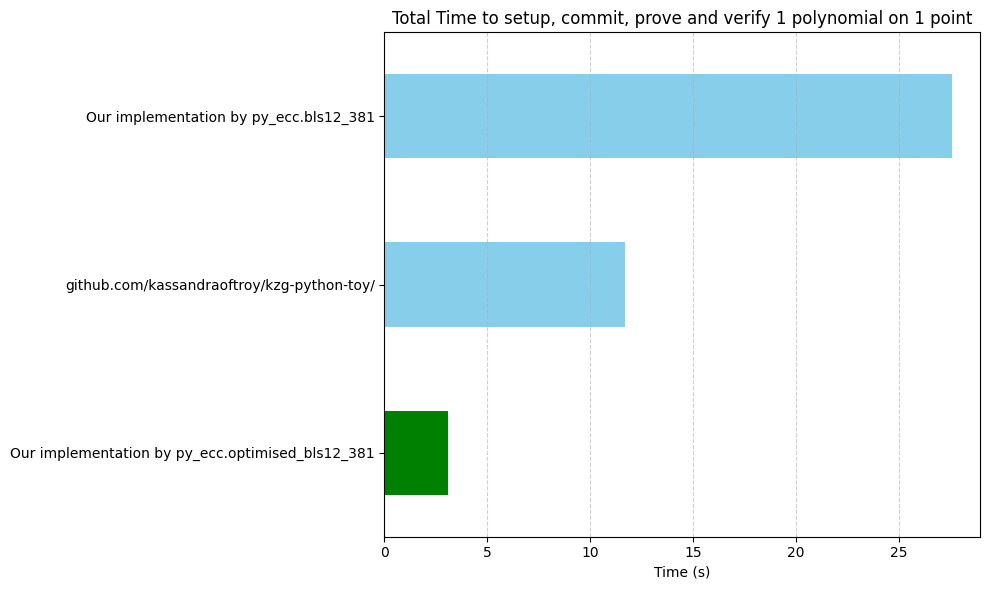

In [14]:
from tabulate import tabulate

print("----------------------------------------------------")
print("|                                                  |")
print("|  Parameters                                      |")
print("|  - 1 input with a 36 degree f(x)                 |")
print("|  - Self-generated Setup, Commit, Prove, Verify   |")
print("|                                                  |")
print("----------------------------------------------------")
print()

# Convert to pandas DataFrame
header = library_benchmark_result[0][1:]  # first row (excluding empty label)
rows = [row for row in library_benchmark_result[1:]]
index = [row[0] for row in rows]
data = [row[1:] for row in rows]

df = pd.DataFrame(data, columns=header, index=index)

# Display nicely
print(tabulate(df.round(2), headers='keys', tablefmt='pretty'))
print()
#print(tabulate(df.T.round(2), headers='keys', tablefmt='github'))

# Plot total time comparison
colors = ['skyblue'] * len(df)
colors[-1] = 'green'

df['Total time (s)'].plot(kind='barh', figsize=(10, 6), color=colors)
plt.xlabel("Time (s)")
plt.title("Total Time to setup, commit, prove and verify 1 polynomial on 1 point")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()
# plt.axhline(y=1.5, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

## Insight

The py_ecc.optimised_bls12_381 module is significantly faster than py_ecc.bls12_381 because it uses low-level, performance-optimized code written in C through the cffi interface, whereas py_ecc.bls12_381 is implemented purely in Python. The optimized version takes advantage of compiled code for expensive elliptic curve operations like point addition, multiplication, and pairings, resulting in substantial speedups especially for high-degree polynomials or batch operations.

For this reason, we have chosen to use our py_ecc.optimised_bls_381 implementation for our other demonstrations.

In [15]:
# WARNING: Run time ~ 45 mintues on Google Colab with a 4000 degree polynomial

print("---------------------------------------------------------")
print("|                                                       |")
print("|        Optimisation Benchmark: Baseline Setup         |")
print("|                                                       |")
print("|  - Using py_ecc.optimized_bls12_381                   |")
print("|  - 8 polynomials committed individually               |")
print("|  - SRS generated on the fly (non-precomputed)         |")
print("|  - 25 distinct evaluation points (z-values) proved    |")
print("|  - 25 separate proofs verified                        |")
print("|                                                       |")
print("---------------------------------------------------------")

srs_list = list()
commitment_list = list()
proofs_list = list()
ys_list = list()
g2_tau_list = list()

# --------------------------------
# Trusted Setup
# --------------------------------
print(f"\n-- Trusted Setup --")
start_t1 = time.perf_counter()
for i in range(len(fx_list)):
    srs, g1, g2, g2_tau = opt_trusted_setup(fx_list[i])
    srs_list.append(srs)
    g2_tau_list.append(g2_tau)
end_t1 = time.perf_counter()
for i in range(len(fx_list)):
    print(f"SRS[{len(srs_list[i])}] of fx[{i}] = ({opt_normalize(srs_list[i][-1])})")
print(f"g1={g1}\ng2={g2}\ng2_tau={g2_tau}")

# --------------------------------
# Generate commitment
# --------------------------------
start_t2 = time.perf_counter()
for i in range(len(fx_list)):
    commitment_list.append(opt_kzg_commit(fx_list[i], srs_list[i]))
end_t2 = time.perf_counter()
print("\n-- Commitment --")
for i in range(len(fx_list)):
    print(f"C[{i}] = {commitment_list[i]}")

# --------------------------------
# Generate proof
# --------------------------------

start_t3 = time.perf_counter()
zs = [secrets.randbelow(opt_curve_order - 1) + 1 for _ in range(points)]
print(f"\n-- Prove at {points} different points --\nz's =",zs)
print("Generating proofs... (It will take some time.)")
for i in range(len(fx_list)):
    ys_list.append([evaluate_polynomial(fx_list[i], z) for z in zs])
    proofs_list.append([opt_kzg_prove(fx_list[i], z, y, srs_list[i]) for z, y in zip(zs, ys_list[i])])
end_t3 = time.perf_counter()
for i in range(len(fx_list)):
    try:
        print(f"y[0] of fx[{i}] = {ys_list[i][0]}")
    except ValueError:
        print(f"y[0] of fx[{i}] is too large to print: {digit_count_bitwise(ys_list[i][0])} digits.")
    print(f"Proofs[0] of fx[{i}] = {opt_normalize(proofs_list[i][0])}")

# --------------------------------
# Verify proof
# --------------------------------
print(f"\n-- Verify {points} different points --")
valid_all = True
start_t4 = time.perf_counter()
for i in range(len(fx_list)):
  for j in range(points):
    valid = opt_kzg_verify(commitment_list[i], proofs_list[i][j], zs[j], ys_list[i][j], g1, g2, g2_tau_list[i])
    valid_all = valid_all and valid
    if not valid: print(f"KZG proof for fx_list[{i}] by point {j+1} is Invalid.")
end_t4 = time.perf_counter()
print(f"KZG proofs for all {len(fx_list)} commitments by {points} points are valid:", valid_all)

# --------------------------------
# Benchmarking
# --------------------------------
print("\n-- Benchmarking --")
print(f"{len(fx_list)} fxs Trusted Setup:            \t{end_t1 - start_t1:.6f} seconds")
print(f"{len(fx_list)} fxs Separate Commitment generation:  \t{end_t2 - start_t2:.6f} seconds")
print(f"{len(fx_list)} * {points}  Proofs generation:        \t{end_t3 - start_t3:.6f} seconds")
print(f"{len(fx_list)} * {points}  Separate Verification:       \t{end_t4 - start_t4:.6f} seconds")
print(f"Total time:                      \t{end_t4 - start_t1:.6f} seconds")

optimisation_benchmark_result.append([
    "Baseline",
    end_t1 - start_t1,
    end_t2 - start_t2,
    end_t3 - start_t3,
    end_t4 - start_t4,
    end_t4 - start_t1,
])



---------------------------------------------------------
|                                                       |
|        Optimisation Benchmark: Baseline Setup         |
|                                                       |
|  - Using py_ecc.optimized_bls12_381                   |
|  - 8 polynomials committed individually               |
|  - SRS generated on the fly (non-precomputed)         |
|  - 25 distinct evaluation points (z-values) proved    |
|  - 25 separate proofs verified                        |
|                                                       |
---------------------------------------------------------

-- Trusted Setup --
SRS[36] of fx[0] = ((1481583402266216293600760876481201788761391635857026738338391215967422115770872946374452627844314243076784223947155, 2826724007794229846272837883514565235938334771033001685408602250201402575291465558426704294800435997512991552918467))
SRS[39] of fx[1] = ((3552652008832270309582887405347487507122121085592643312255804943

In [16]:
# @title
# # Debug use - please ignore

# import random

# def compute_g2_tau_minus_z(g2_tau, z):
#     """
#     Computes g2^{τ - z} as ∑ (τ^i - z) · g2^τ^i
#     Assumes g2_tau = [g2^τ^0, g2^τ^1, ..., g2^τ^d]
#     Approximated here as g2^1 / (τ - z) if structured reference string used.
#     """
#     # This is a placeholder: in practice, you'd use division in exponent:
#     # g2^{1 / (τ - z)} or equivalent using structured CRS
#     # Here we simply return g2 - z * g2^1 as a naive placeholder
#     # You should replace this with a secure SRS-aware implementation
#     return opt_add(g2_tau[1], opt_neg(opt_multiply(opt_G2, z)))

# def fully_batch_verify_kzg(commitment_list, proofs_list, zs, ys_list, g1, g2, g2_tau):
#     N = len(commitment_list)
#     m = len(zs)

#     # Random batching scalars
#     r_i = [random.randint(1, opt_curve_order - 1) for _ in range(N)]
#     s_j = [random.randint(1, opt_curve_order - 1) for _ in range(m)]

#     # Aggregate all proofs (G1) into one using scalars r_i * s_j
#     agg_proof = opt_Z1
#     for i in range(N):
#         for j in range(m):
#             scaled_proof = opt_multiply(proofs_list[i][j], r_i[i] * s_j[j] % opt_curve_order)
#             agg_proof = opt_add(agg_proof, scaled_proof)

#     lhs = opt_pairing(agg_proof, g2)

#     # Compute rhs numerator: aggregated (C_i - y_{i,j}·g1)
#     rhs_numerator = opt_Z1
#     for i in range(N):
#         for j in range(m):
#             eval_term = opt_add(commitment_list[i], opt_neg(opt_multiply(g1, ys_list[i][j])))
#             scaled_term = opt_multiply(eval_term, r_i[i] * s_j[j] % opt_curve_order)
#             rhs_numerator = opt_add(rhs_numerator, scaled_term)

#     # Compute rhs denominator in G2: ∑ s_j · (τ - z_j)
#     rhs_denominator = opt_Z2
#     for j in range(m):
#         g2_tau_minus_zj = compute_g2_tau_minus_z(g2_tau, zs[j])  # <-- helper below
#         scaled = opt_multiply(g2_tau_minus_zj, s_j[j])
#         rhs_denominator = opt_add(rhs_denominator, scaled)

#     rhs = opt_pairing(rhs_numerator, rhs_denominator)

#     return opt_final_exponentiate(lhs) == opt_final_exponentiate(rhs)

def poly_add(a, b, mod):
    length = max(len(a), len(b))
    a += [0] * (length - len(a))
    b += [0] * (length - len(b))
    return [(x + y) % mod for x, y in zip(a, b)]

def poly_sub(a, b, mod):
    length = max(len(a), len(b))
    a += [0] * (length - len(a))
    b += [0] * (length - len(b))
    return [(x - y) % mod for x, y in zip(a, b)]

def poly_mul(a, b, mod):
    res = [0] * (len(a) + len(b) - 1)
    for i in range(len(a)):
        for j in range(len(b)):
            res[i+j] = (res[i+j] + a[i]*b[j]) % mod
    return res

def poly_div(dividend, divisor, mod):
    # Long division for polynomials
    out = list(dividend)
    normalizer = divisor[-1]
    quotient = [0] * (len(dividend) - len(divisor) + 1)
    for i in range(len(quotient)-1, -1, -1):
        quotient[i] = out[i + len(divisor) -1] * pow(normalizer, -1, mod) % mod
        for j in range(len(divisor)):
            out[i+j] = (out[i+j] - quotient[i] * divisor[j]) % mod
    # Remove trailing zeros
    while len(out) > 0 and out[-1] == 0:
        out.pop()
    return quotient, out  # quotient, remainder

def poly_eval(poly, x, mod):
    result = 0
    power = 1
    for coeff in poly:
        result = (result + coeff * power) % mod
        power = (power * x) % mod
    return result

def lagrange_interpolate(xs, ys, mod):
    # Interpolate polynomial I(x) s.t. I(xs[i]) = ys[i]
    k = len(xs)
    coeffs = [0] * k
    for i in range(k):
        li_num = [1]
        li_den = 1
        for j in range(k):
            if i != j:
                li_num = poly_mul(li_num, [-xs[j] % mod, 1], mod)  # (x - xs[j])
                li_den = (li_den * (xs[i] - xs[j])) % mod
        li_den_inv = pow(li_den, -1, mod)
        li = [(c * li_den_inv) % mod for c in li_num]
        li = [(c * ys[i]) % mod for c in li]
        coeffs = poly_add(coeffs, li, mod)
    return coeffs

def opt_kzg_batch_prove(fx, zs, ys, srs, mod=opt_curve_order):
    # Step 1: Compute vanishing polynomial Z(x) = ∏(x - z_i)
    Z = [1]
    for z in zs:
        Z = poly_mul(Z, [-z % mod, 1], mod)

    # Step 2: Interpolate I(x) s.t. I(z_i) = y_i
    I = lagrange_interpolate(zs, ys, mod)

    # Step 3: Compute numerator polynomial N(x) = f(x) - I(x)
    N = poly_sub(fx[:], I, mod)

    # Step 4: Compute quotient polynomial q(x) = N(x) / Z(x)
    q, r = poly_div(N, Z, mod)
    if len(r) != 0:
        raise Exception("Non-zero remainder in polynomial division; bad proof inputs")

    # Step 5: Commit to q(x)
    proof = opt_kzg_commit(q, srs)

    return proof

proof = opt_kzg_batch_prove(fx, zs, ys, srs)

def opt_kzg_batch_verify(commitment, proof, zs, ys, srs_g2, opt_g1, opt_g2, mod=opt_curve_order):
    Z = [1]
    for z in zs:
        Z = poly_mul(Z, [-z % mod, 1], mod)

    I = lagrange_interpolate(zs, ys, mod)
    commit_I = opt_kzg_commit(I, srs)

    # Compute e(C - Commit(I), G2)
    left_expr = opt_add(commitment, opt_neg(commit_I))
    left = opt_final_exponentiate(opt_pairing(opt_g2, left_expr))

    # Commit(Z) on G2 side
    commit_Z = opt_kzg_commit(Z, srs_g2)

    # Compute e(proof, Commit(Z))
    right = opt_final_exponentiate(opt_pairing(commit_Z, proof))

    return left == right

In [17]:
#print("---------------------------------------------------------")
print("---------------------------------------------------------")
print("|                                                       |")
print("|     Optimisation Benchmark: Multi-point Verification  |")
print("|                                                       |")
print("|  - Using py_ecc.optimized_bls12_381                   |")
print("|  - 8 polynomials committed individually               |")
print("|  - SRS generated on the fly (non-precomputed)         |")
print("|  - 25 evaluation points (z-values) proved and         |")
print("|    verified in a combined batch                       |")
print("|                                                       |")
print("|  - According to the original KZG paper, it's possible |")
print("|    to batch verify multiple evaluation proofs         |")
print("|    at different points for the same polynomial        |")
print("|    using random linear combinations                   |")
print("|                                                       |")
print("|  - The verification function is adapted from a PLONK  |")
print("|    implementation, with minor modifications due to    |")
print("|    py_ecc.FQ12 lacking native Python pow() support    |")
print("|                                                       |")
print("---------------------------------------------------------")

srs_list = list()
commitment_list = list()
ys_list = list()
proofs_list = list()
g2_tau_list = list()

# --------------------------------
# Trusted Setup
# --------------------------------
print(f"\n-- Trusted Setup --")
start_t1 = time.perf_counter()
for i in range(len(fx_list)):
    srs, g1, g2, g2_tau = opt_trusted_setup(fx_list[i])
    srs_list.append(srs)
    g2_tau_list.append(g2_tau)
end_t1 = time.perf_counter()
for i in range(len(fx_list)):
    print(f"SRS[{len(srs_list[i])}] of fx[{i}] = ({opt_normalize(srs_list[i][-1])})")
print(f"g1={g1}\ng2={g2}\ng2_tau={g2_tau}")

# --------------------------------
# Generate commitment
# --------------------------------
start_t2 = time.perf_counter()
for i in range(len(fx_list)):
    commitment_list.append(opt_kzg_commit(fx_list[i], srs_list[i]))
end_t2 = time.perf_counter()
print("\n-- Commitment --")
for i in range(len(fx_list)):
    print(f"C[{i}] = {commitment_list[i]}")

# --------------------------------
# Generate proof
# --------------------------------

start_t3 = time.perf_counter()
zs = [secrets.randbelow(opt_curve_order - 1) + 1 for _ in range(points)]
print(f"\n-- Prove at {points} different points --\nz's =",zs)
print("Generating proofs... (It will take some time.)")
for i in range(len(fx_list)):
    ys_list.append([evaluate_polynomial(fx_list[i], z) for z in zs])
    proofs_list.append([opt_kzg_prove(fx_list[i], z, y, srs_list[i]) for z, y in zip(zs, ys_list[i])])
end_t3 = time.perf_counter()
for i in range(len(fx_list)):
    try:
        print(f"y[0] of fx[{i}] = {ys_list[i][0]}")
    except ValueError:
        print(f"y[0] of fx[{i}] is too large to print: {digit_count_bitwise(ys_list[i][0])} digits.")
    print(f"Proofs[0] of fx[{i}] = {opt_normalize(proofs_list[i][0])}")

# --------------------------------#
# Verify proof
# --------------------------------
print(f"\n-- Verify {points} different points --")
start_t4 = time.perf_counter()
valid_all = True
for i in range(len(fx_list)):
    valid = opt_batch_verify_same_poly(commitment_list[i], proofs_list[i], zs, ys_list[i], g1, g2, g2_tau_list[i])
    valid_all = valid_all and valid
    if not valid: print(f"KZG proof by {points} points for fx_list[{i}] is Invalid.")
end_t4 = time.perf_counter()
print(f"KZG proofs for all {len(fx_list)} commitments by {points} points are valid:", valid_all)

# start_t5 = time.perf_counter()
# check = fully_batch_verify_kzg(commitment_list, proofs_list, zs, ys_list, g1, g2, g2_tau_list)
# print(f"KZG proofs for all {len(fx_list)} commitments by {points} points are valid:", check)
# end_t5 = time.perf_counter()

# --------------------------------
# Benchmarking
# --------------------------------
print("\n-- Benchmarking --")
print(f"{len(fx_list)} fxs Trusted Setup:            \t{end_t1 - start_t1:.6f} seconds")
print(f"{len(fx_list)} fxs separate Commitment generation:  \t{end_t2 - start_t2:.6f} seconds")
print(f"{len(fx_list)} * {points}  Proofs generation:        \t{end_t3 - start_t3:.6f} seconds")
print(f"{len(fx_list)} * {points}  Batch Verification:       \t{end_t4 - start_t4:.6f} seconds")
print(f"Total time:                      \t{end_t4 - start_t1:.6f} seconds")

# print(f"{len(fx_list)} * {points}  Batch Verification 2:       \t{end_t5 - start_t5:.6f} seconds")

optimisation_benchmark_result.append([
    "Batch Verify",
    end_t1 - start_t1,
    end_t2 - start_t2,
    end_t3 - start_t3,
    end_t4 - start_t4,
    end_t4 - start_t1,
])



---------------------------------------------------------
|                                                       |
|     Optimisation Benchmark: Multi-point Verification  |
|                                                       |
|  - Using py_ecc.optimized_bls12_381                   |
|  - 8 polynomials committed individually               |
|  - SRS generated on the fly (non-precomputed)         |
|  - 25 evaluation points (z-values) proved and         |
|    verified in a combined batch                       |
|                                                       |
|  - According to the original KZG paper, it's possible |
|    to batch verify multiple evaluation proofs         |
|    at different points for the same polynomial        |
|    using random linear combinations                   |
|                                                       |
|  - The verification function is adapted from a PLONK  |
|    implementation, with minor modifications due to    |
|    py_ecc.FQ

In [18]:
print("---------------------------------------------------------")
print("|                                                       |")
print("|     Optimisation Benchmark: Additive Homomorphism     |")
print("|                                                       |")
print("|  - Using py_ecc.optimized_bls12_381                   |")
print("|  - 8 polynomials committed individually               |")
print("|  - SRS generated on the fly (non-precomputed)         |")
print("|  - 25 evaluation points (z-values) proved and         |")
print("|    verified separately                                |")
print("|                                                       |")
print("|  - Utilizes KZG's additive homomorphism property to   |")
print("|    merge 8 commitments into a single proof and        |")
print("|    verification process                               |")
print("|                                                       |")
print("|  - This technique is referenced in the KZG paper      |")
print("|    under 'Additive Homomorphism'                      |")
print("|                                                       |")
print("---------------------------------------------------------")
srs_list = list()
commitment_list = list()
ys_list = list()
proofs_list = list()
g2_tau_list = list()

# --------------------------------
# Combine polynomials using KZG's Additive Homomorphism property
# --------------------------------
max_len = 0
for i in range(len(fx_list)):
    max_len = max(max_len,len(fx_list[i]))
for i in range(len(fx_list)):
    fx_list[i] += [0] * (max_len - len(fx_list[i]))
hx = [sum(coeffs) % opt_curve_order for coeffs in zip(*fx_list)]
print(f"\n-- Pad messages to same length --\nhx (length: {len(hx)}): {hx}")

# --------------------------------
# Trusted Setup
# --------------------------------
print(f"\n-- Trusted Setup --")
start_t1 = time.perf_counter()
srs, g1, g2, g2_tau = opt_trusted_setup(hx)
end_t1 = time.perf_counter()
print(f"SRS[{len(srs)}] of hx = ({opt_normalize(srs[len(srs)-1])})")
print(f"g1={g1}\ng2={g2}\ng2_tau={g2_tau}")

# --------------------------------
# Generate commitment
# --------------------------------
start_t2 = time.perf_counter()
commitment = opt_kzg_commit(hx, srs)
end_t2 = time.perf_counter()
print("\n-- Commitment --\nC = ",opt_normalize(commitment))

# --------------------------------
# Generate proof
# --------------------------------

start_t3 = time.perf_counter()
zs = [secrets.randbelow(opt_curve_order - 1) + 1 for _ in range(points)]
print(f"\n-- Prove at {points} different points --\nz's =",zs)
print("Generating proofs... (It will take some time.)")
ys = [evaluate_polynomial(hx, z) for z in zs]
proofs = [opt_kzg_prove(hx, z, y, srs) for z, y in zip(zs, ys)]
end_t3 = time.perf_counter()
try:
    print(f"ys[0] of hx = {ys[0]}")
except ValueError:
    print(f"ys[0] of hx is too large to print: {digit_count_bitwise(ys[0])} digits.")
print(f"Proofs[0] of hx = {opt_normalize(proofs[0])}")

# --------------------------------
# Verify proof
# --------------------------------
print(f"\n-- Verify {points} different points --")
valid_all = True
start_t4 = time.perf_counter()
for j in range(points):
  valid = opt_kzg_verify(commitment, proofs[j], zs[j], ys[j], g1, g2, g2_tau)
  valid_all = valid_all and valid
  if not valid: print(f"KZG proof for hx by point {j+1} is Invalid.")
end_t4 = time.perf_counter()
print(f"KZG proofs for all {len(fx_list)} commitments by {points} points are valid:", valid_all)

# --------------------------------
# Benchmarking
# --------------------------------
print("\n-- Benchmarking --")
print(f"{len(fx_list)} fxs Trusted Setup:            \t{end_t1 - start_t1:.6f} seconds")
print(f"{len(fx_list)} fxs Combined Commitment generation:  \t{end_t2 - start_t2:.6f} seconds")
print(f"{len(fx_list)} * {points}  Proofs generation:        \t{end_t3 - start_t3:.6f} seconds")
print(f"{len(fx_list)} * {points}  Separate Verification:       \t{end_t4 - start_t4:.6f} seconds")
print(f"Total time:                      \t{end_t4 - start_t1:.6f} seconds")

optimisation_benchmark_result.append([
    "Additive hom",
    end_t1 - start_t1,
    end_t2 - start_t2,
    end_t3 - start_t3,
    end_t4 - start_t4,
    end_t4 - start_t1,
])



---------------------------------------------------------
|                                                       |
|     Optimisation Benchmark: Additive Homomorphism     |
|                                                       |
|  - Using py_ecc.optimized_bls12_381                   |
|  - 8 polynomials committed individually               |
|  - SRS generated on the fly (non-precomputed)         |
|  - 25 evaluation points (z-values) proved and         |
|    verified separately                                |
|                                                       |
|  - Utilizes KZG's additive homomorphism property to   |
|    merge 8 commitments into a single proof and        |
|    verification process                               |
|                                                       |
|  - This technique is referenced in the KZG paper      |
|    under 'Batch Opening'                              |
|                                                       |
--------------

In [19]:
print("---------------------------------------------------------")
print("|                                                       |")
print("|       Optimisation Benchmark: Trusted SRS             |")
print("|                                                       |")
print("|  - Using py_ecc.optimized_bls12_381                   |")
print("|  - 8 polynomials committed individually               |")
print("|  - Public, pre-generated trusted SRS is used          |")
print("|  - 25 evaluation points (z-values) proved and         |")
print("|    verified separately                                |")
print("|                                                       |")
print("|  - Supports polynomials up to degree 4095             |")
print("|  - For degrees > 4095, falls back to on-the-fly       |")
print("|    SRS generation (significantly slower)              |")
print("|                                                       |")
print("---------------------------------------------------------")

srs_list = list()
commitment_list = list()
proofs_list = list()
ys_list = list()
g2_tau_list = list()

# --------------------------------
# Trusted Setup
# --------------------------------
print(f"\n-- Trusted Setup --")
start_t1 = time.perf_counter()
for i in range(len(fx_list)):
    srs, g1, g2, g2_tau = opt_trusted_setup_with_trusted_srs(fx_list[i])
    srs_list.append(srs)
    g2_tau_list.append(g2_tau)
end_t1 = time.perf_counter()
for i in range(len(fx_list)):
    print(f"SRS[{len(srs_list[i])}] of fx[{i}] = ({opt_normalize(srs_list[i][-1])})")
print(f"g1={g1}\ng2={g2}\ng2_tau={g2_tau}")

# --------------------------------
# Generate commitment
# --------------------------------
start_t2 = time.perf_counter()
for i in range(len(fx_list)):
    commitment_list.append(opt_kzg_commit(fx_list[i], srs_list[i]))
end_t2 = time.perf_counter()
print("\n-- Commitment --")
for i in range(len(fx_list)):
    print(f"C[{i}] = {commitment_list[i]}")

# --------------------------------
# Generate proof
# --------------------------------

start_t3 = time.perf_counter()
zs = [secrets.randbelow(opt_curve_order - 1) + 1 for _ in range(points)]
print(f"\n-- Prove at {points} different points --\nz's =",zs)
print("Generating proofs... (It will take some time.)")
for i in range(len(fx_list)):
    ys_list.append([evaluate_polynomial(fx_list[i], z) for z in zs])
    proofs_list.append([opt_kzg_prove(fx_list[i], z, y, srs_list[i]) for z, y in zip(zs, ys_list[i])])
end_t3 = time.perf_counter()
for i in range(len(fx_list)):
    try:
        print(f"y[0] of fx[{i}] = {ys_list[i][0]}")
    except ValueError:
        print(f"y[0] of fx[{i}] is too large to print: {digit_count_bitwise(ys_list[i][0])} digits.")
    print(f"Proofs[0] of fx[{i}] = {opt_normalize(proofs_list[i][0])}")

# --------------------------------
# Verify proof
# --------------------------------
print(f"\n-- Verify {points} different points --")
valid_all = True
start_t4 = time.perf_counter()
for i in range(len(fx_list)):
  for j in range(points):
    valid = opt_kzg_verify(commitment_list[i], proofs_list[i][j], zs[j], ys_list[i][j], g1, g2, g2_tau_list[i])
    valid_all = valid_all and valid
    if not valid: print(f"KZG proof for fx_list[{i}] by point {j+1} is Invalid.")
end_t4 = time.perf_counter()
print(f"KZG proofs for all {len(fx_list)} commitments by {points} points are valid:", valid_all)

# --------------------------------
# Benchmarking
# --------------------------------
print("\n-- Benchmarking --")
print(f"{len(fx_list)} fxs Public Trusted Setup:            \t{end_t1 - start_t1:.6f} seconds")
print(f"{len(fx_list)} fxs Separate Commitment generation:  \t{end_t2 - start_t2:.6f} seconds")
print(f"{len(fx_list)} * {points}  Proofs generation:        \t{end_t3 - start_t3:.6f} seconds")
print(f"{len(fx_list)} * {points}  Separate Verification:       \t{end_t4 - start_t4:.6f} seconds")
print(f"Total time:                      \t{end_t4 - start_t1:.6f} seconds")

optimisation_benchmark_result.append([
    "Public Trusted SRS",
    end_t1 - start_t1,
    end_t2 - start_t2,
    end_t3 - start_t3,
    end_t4 - start_t4,
    end_t4 - start_t1,
])


---------------------------------------------------------
|                                                       |
|       Optimisation Benchmark: Trusted SRS             |
|                                                       |
|  - Using py_ecc.optimized_bls12_381                   |
|  - 8 polynomials committed individually               |
|  - Public, pre-generated trusted SRS is used          |
|  - 25 evaluation points (z-values) proved and         |
|    verified separately                                |
|                                                       |
|  - Supports polynomials up to degree 4095             |
|  - For degrees > 4095, falls back to on-the-fly       |
|    SRS generation (significantly slower)              |
|                                                       |
---------------------------------------------------------

-- Trusted Setup --
SRS[3991] of fx[0] = ((25016463020733085118906064747611548170399336679208466498412117940627991449300538730940

In [20]:
print("---------------------------------------------------------")
print("|                                                       |")
print("|             Optimisation Benchmark: All               |")
print("|                                                       |")
print("|  - Using py_ecc.optimized_bls12_381                   |")
print("|  - 8 input polynomials committed as one               |")
print("|  - Public, pre-generated trusted SRS is used          |")
print("|  - 25 evaluation points (z-values) proved and         |")
print("|    verified in a combined fashion                     |")
print("|                                                       |")
print("---------------------------------------------------------")


srs_list = list()
commitment_list = list()
ys_list = list()
proofs_list = list()
g2_tau_list = list()

# --------------------------------
# Combine polynomials using KZG's Additive Homomorphism property
# --------------------------------
max_len = 0
for i in range(len(fx_list)):
    max_len = max(max_len,len(fx_list[i]))
for i in range(len(fx_list)):
    fx_list[i] += [0] * (max_len - len(fx_list[i]))
hx = [sum(coeffs) % opt_curve_order for coeffs in zip(*fx_list)]
print(f"\n-- Pad messages to same length --\nhx (length: {len(hx)}): {hx}")

# --------------------------------
# Trusted Setup
# --------------------------------
print(f"\n-- Trusted Setup --")
start_t1 = time.perf_counter()
srs, g1, g2, g2_tau = opt_trusted_setup_with_trusted_srs(hx)
end_t1 = time.perf_counter()
print(f"SRS[{len(srs)}] of hx = ({opt_normalize(srs[len(srs)-1])})")
print(f"g1={g1}\ng2={g2}\ng2_tau={g2_tau}")

# --------------------------------
# Generate commitment
# --------------------------------
start_t2 = time.perf_counter()
commitment = opt_kzg_commit(hx, srs)
end_t2 = time.perf_counter()
print("\n-- Commitment --\nC = ",opt_normalize(commitment))

# --------------------------------
# Generate proof
# --------------------------------
start_t3 = time.perf_counter()
zs = [secrets.randbelow(opt_curve_order - 1) + 1 for _ in range(points)]
print(f"\n-- Prove at {points} different points --\nz's =",zs)
print("Generating proofs... (It will take some time.)")
ys = [evaluate_polynomial(hx, z) for z in zs]
proofs = [opt_kzg_prove(hx, z, y, srs) for z, y in zip(zs, ys)]
end_t3 = time.perf_counter()
try:
    print(f"ys[0] of hx = {ys[0]}")
except ValueError:
    print(f"ys[0] of hx is too large to print: {digit_count_bitwise(ys[0])} digits.")
print(f"Proofs[0] of hx = {opt_normalize(proofs[0])}")

# --------------------------------
# Verify proof
# --------------------------------
print(f"\n-- Verify {points} different points --")
start_t4 = time.perf_counter()
valid = opt_batch_verify_same_poly(commitment, proofs, zs, ys, g1, g2, g2_tau)
end_t4 = time.perf_counter()
print(f"KZG proofs for all {len(fx_list)} commitments by {points} points are valid:", valid)

# --------------------------------
# Benchmarking
# --------------------------------
print("\n-- Benchmarking --")
print(f"{len(fx_list)} fxs Public Trusted Setup:            \t{end_t1 - start_t1:.6f} seconds")
print(f"{len(fx_list)} fxs Combined Commitment generation:  \t{end_t2 - start_t2:.6f} seconds")
print(f"{len(fx_list)} * {points}  Proofs generation:        \t{end_t3 - start_t3:.6f} seconds")
print(f"{len(fx_list)} * {points}  Combined Verification:       \t{end_t4 - start_t4:.6f} seconds")
print(f"Total time:                      \t{end_t4 - start_t1:.6f} seconds")

optimisation_benchmark_result.append([
    "All optimisation",
    end_t1 - start_t1,
    end_t2 - start_t2,
    end_t3 - start_t3,
    end_t4 - start_t4,
    end_t4 - start_t1,
])



---------------------------------------------------------
|                                                       |
|             Optimisation Benchmark: All               |
|                                                       |
|  - Using py_ecc.optimized_bls12_381                   |
|  - 8 input polynomials committed as one               |
|  - Public, pre-generated trusted SRS is used          |
|  - 25 evaluation points (z-values) proved and         |
|    verified in a combined fashion                     |
|                                                       |
---------------------------------------------------------

-- Pad messages to same length --
hx (length: 3991): [33834278126045338025221314715462698657045322535443184580205007423296928867583, 42910655108720392571311519902536996475049676318619382659431160943941809874142, 6504024049512235744924932938357520822016745293243604817280965743361556229744, 47562862431766135950054134813887716091052291755583790208151052850027651

+--------------------+---------------+-----------------------+------------------+--------------+----------------+
|                    | Trusted Setup | Commitment generation | Proof generation | Verification | Total time (s) |
+--------------------+---------------+-----------------------+------------------+--------------+----------------+
|      Baseline      |     87.36     |         61.8          |     2174.03      |    382.68    |    2705.88     |
|    Batch Verify    |     84.11     |         61.68         |     2135.02      |    201.34    |    2482.15     |
|    Additive hom    |     53.22     |         53.38         |     1350.81      |    45.03     |    1502.44     |
| Public Trusted SRS |      0.0      |         60.96         |     2173.66      |    382.66    |    2617.29     |
|  All optimisation  |      0.0      |         64.11         |     1372.07      |    25.37     |    1461.55     |
+--------------------+---------------+-----------------------+------------------+-------

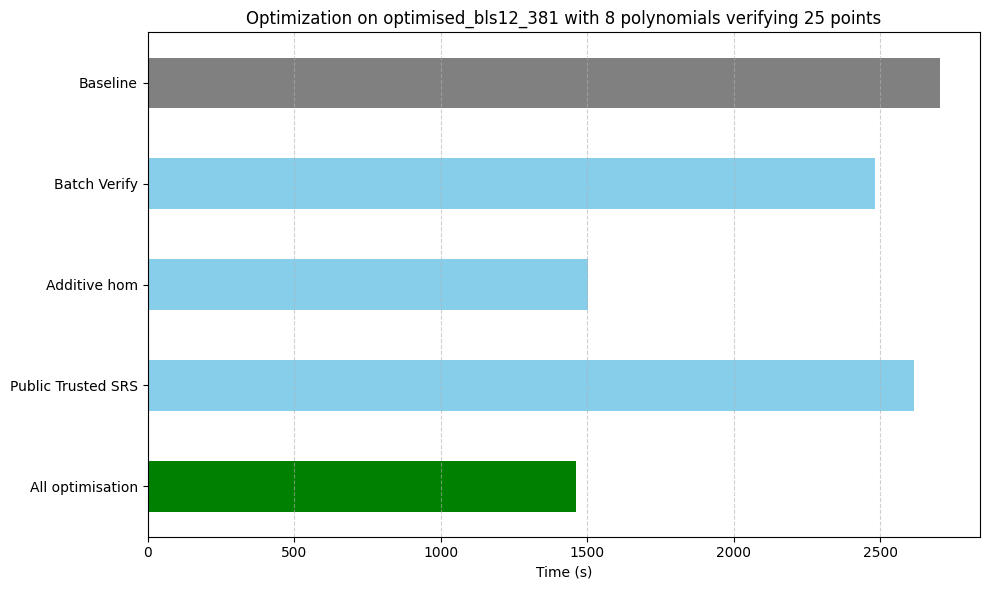

In [21]:
header = optimisation_benchmark_result[0][1:]  # first row (excluding empty label)
rows = [row for row in optimisation_benchmark_result[1:]]
index = [row[0] for row in rows]
data = [row[1:] for row in rows]

df2 = pd.DataFrame(data, columns=header, index=index)

# Display nicely
print(tabulate(df2.round(2), headers='keys', tablefmt='pretty'))
print()

# Plot total time comparison
colors = ['skyblue'] * len(df2)
colors[0] = 'grey'
colors[-1] = 'green'

df2['Total time (s)'].plot(kind='barh', figsize=(10, 6), color=colors)
plt.xlabel("Time (s)")
plt.title(f"Optimization on optimised_bls12_381 with 8 polynomials verifying {points} points")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()
# plt.axhline(y=1.5, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

## Insight & Conclusion

* Our benchmarks reveal that **Additive homomorphism** delivers the most substantial performance improvement. By compressing multiple proof generations into a single pairing operation, it eliminates the most computationally expensive part of the KZG protocol — proving. This results in a dramatic reduction in runtime, particularly when working with multiple commitments.

* **Batch Verification** also provides valuable optimization, especially when verifying many evaluation points from the same polynomial. In our tests, verifying 25 such points with batch verification achieved a performance boost of approximately **40%**, thanks to fewer pairing operations and amortized cost.

* Lastly, **Trusted SRS** enables a powerful static optimization. By reusing a precomputed, publicly available SRS, we avoid the costly SRS generation phase. This becomes particularly advantageous when dealing with **high-degree polynomials**, where setup time otherwise dominates the total runtime.

* In conclusion, combining all three strategies — **Additive Homomorphism, Batch Verification, and Trusted SRS** — yields a highly efficient, scalable, and practical KZG commitment system. These optimizations make it more viable for real-world applications, especially in blockchain and zero-knowledge proof systems where performance and scalability are critical.

## Possible Improvements that were on our chart but left out on purpose

- **Consistent Use of Tau and Evaluation Points (z)**  
  We could consider using the same τ and evaluation points z for all optimization tests. While this approach undermines the "discardable τ" philosophy — since it reuses trusted parameters — it improves consistency across benchmarks. This consistency can help us better isolate the performance impact of each optimization, making results easier to compare and interpret.

- **Pre-generated and Cached SRS**  
  Instead of regenerating the structured reference string (SRS) for each test, we could precompute it up to a high enough degree and cache it. This would reduce computational overhead during benchmarking. However, this approach assumes a shared τ, again conflicting with the discardable setup principle and reintroducing dependence on a common trusted setup.

- **Limitations of Batch Opening with Our SRS**  
  Our current trusted setup only includes powers of τ in G1 (i.e., [g^τ^i]) and does not produce the corresponding G2 elements (i.e., [h^τ^i]). As a result, some batch opening techniques—which require elements in G2—are not compatible with our setup. Unless we modify our SRS to include G2 powers, we are limited in which batch optimizations we can apply.

